In [1]:
!conda info --envs

# conda environments:
#
base                     C:\Users\armin\anaconda3
CCGG                  *  C:\Users\armin\anaconda3\envs\CCGG
CCGG_backup              C:\Users\armin\anaconda3\envs\CCGG_backup



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples
import time
import sys

from CCGG_classes import Data, AXIS_interval, AXIS, FLEQ, MDLS, MCMCRunner

# conda environments:
#
base                     C:\Users\armin\anaconda3
CCGG                  *  C:\Users\armin\anaconda3\envs\CCGG
CCGG_backup              C:\Users\armin\anaconda3\envs\CCGG_backup



# Data

In [3]:
dataset = Data()

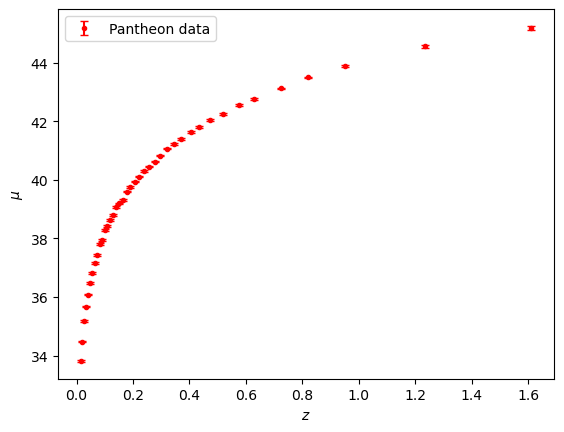

In [4]:
dataset.plot_SNe_Data()

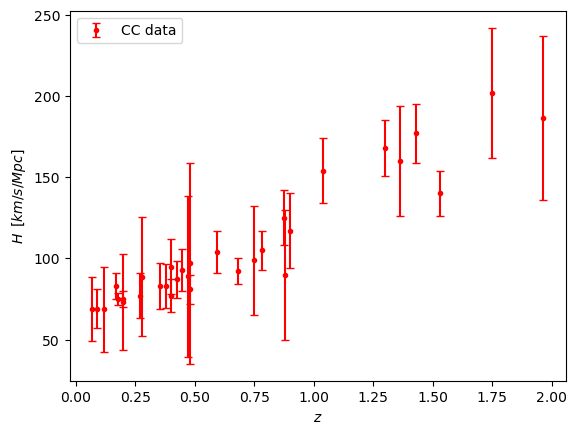

In [5]:
dataset.plot_CC_Data()

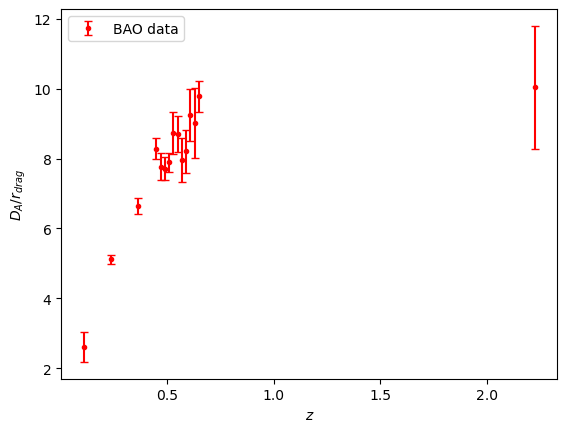

In [6]:
dataset.plot_BAO_Data()

In [7]:
dataset.print_CMB_Data()

CMB redshift = 1089
R = 1.7661
la = 301.7293
Covariance matrix = [[ 0.00033484 -0.00044417]
 [-0.00044417  0.04245662]]


In [8]:
dataset.print_BBN_Data()

BBN redshift = 1000000000
Hubble parameter at BBN = 4.76589971472913e+17


# Numerical Solution

In [9]:
#def quad_interpol(x, y, xi):
#    xx0 = xi-x[0];   xx1 = xi-x[1];   xx2 = xi-x[2]
#    x01 = x[0]-x[1]; x02 = x[0]-x[2]; x12 = x[1]-x[2]
#    return y[0]*xx1*xx2/(x01*x02)-y[1]*xx0*xx2/(x01*x12)+y[2]*xx0*xx1/(x02*x12)

In [10]:
def calc_mcmc_input(MD, *args):
    if MD.FL.GR == 'y' or (MD.FL.GR == 'n' and MD.GR_asym == 'n'):
        prm  = args
    else:
        Og   = MD.Ol_GR*(3-5*args[5])/(1-args[5])**2/2   # Og
        s1   = np.sqrt(2*MD.Ol_GR/(1-args[5]))           # s1
        prm  = [args[0], args[1], 0.0, args[3], args[4], args[5], Og, s1]
    
    MD.FL.set_prm(*prm)
    MD.FL.solve_FLeq()
    MD.calc_mu()
    MD.calc_R_la()
    MD.calc_HBBN()
    HBBN = MD.HBBN_CG if MD.FL.GR == 'n' else MD.HBBN_GR
    return MD.z, MD.mu, MD.R, MD.la, MD.bao, HBBN

In [121]:
# -------------------------------
# --- Initialization ------------
# -------------------------------
# t - axis 
nsp  = 1000      # number of sampling points per interval t_iv[i]
t_iv = []
t_iv.append([ 0.0, 0.3, 100000]) #change last value; need 100k at least to get good plot in GR = 'y' case!
t_iv.append([ 0.3, 0.5, nsp])
t_iv.append([ 0.5, 1.0, nsp])
AX = AXIS(t_iv)

GR      = 'n'     # GR='y': Einstein, GR='n': CCGG
GR_asym = 'y'     # if CCGG: 'y' = calculation with GR-asymptotic s1 not free, 'n' = else s1 free
Ol_GR   = 0.685   # relevant only if GR_asym = 'y'

In [182]:
# -------------------------------
# --- Calculation ---------------
# -------------------------------
FL = FLEQ(GR, AX)
MD = MDLS(FL, GR_asym, Ol_GR)

#          Om,    Orad,    Ol,     Ok,    h,     Os      Og     s1      !!!! for test purpose only
#args  = (0.315, 5.4372e-5, 0.685,  0.000, 0.674, 0.900, -1.000, 0.500)
args  = (0.315, 5.4372e-5, 0.685,  0.0, 0.674, 0.526404, -1.000, 0.500) #BAP plot very sensitive to little changes in Omega_s, Omega_m, Omega_r!
#args = (0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.900, -1.000, 0.500)
#args = (0.315, 5.44e-5, 1.013, 0.000, 0.674, 0.700, -1.000, 0.500)
#args  = (0.315, 5.44e-5, 1.013,  0.000, 0.674, 2.700, -1.000, 0.500)
#args  = (0.315, 5.4372e-5, 0.685,  0.000, 0.674, 0.900, -1.000, 0.500)
#args = [0.33492140731495706, 5.44e-05, 0.685, 0.0, 0.674, 0.6462080816568292, -1.0, 0.5]

starttime = time.time()
z, mu, R, la, bao, HBBN = calc_mcmc_input(MD, *args)
elapsedtime = time.time()-starttime
print('\n elapsed time [sec] = ', elapsedtime)

90149 [0.00000000e+00 3.45167771e+14 1.85422467e+05 9.17996623e+02]
[   521.14642805    917.99662341 185422.46672663]

 elapsed time [sec] =  0.6274511814117432



 --- Cosmological parameters ---------------------
 Ω_m                  =   3.150e-01  []
 Ω_r                  =   5.437e-05  []
 Ω_Λ                  =   0.000e+00  []
 Ω_K                  =   0.000e+00  []
 h                    =   6.740e-01  []
 Ω_s                  =   5.264e-01  []
 Ω_g                  =   5.619e-01  []
 s(τ=1)               =   1.701e+00  []
 Σ(τ=1)               =   5.249e-01  []
 -------------------------------------------------

 --- Solution of FL eq. --------------------------
 τ_min                =   2.704e-01  []
 τ_max                =   1.000e+00  []
 a(τ=τ_min)           =   5.393e-06  []
 a(τ=τ_max)           =   1.000e+00  []
 z(τ=τ_min)           =   1.854e+05  []
 z(τ=τ_max)           =   0.000e+00  []
 H(τ=τ_min)           =   5.492e+08  []
 H(τ=τ_max)           =   1.000e+00  []
 s(τ=τ_min)           =  -4.335e+07  []
 s(τ=τ_max)           =   1.701e+00  []
 -------------------------------------------------


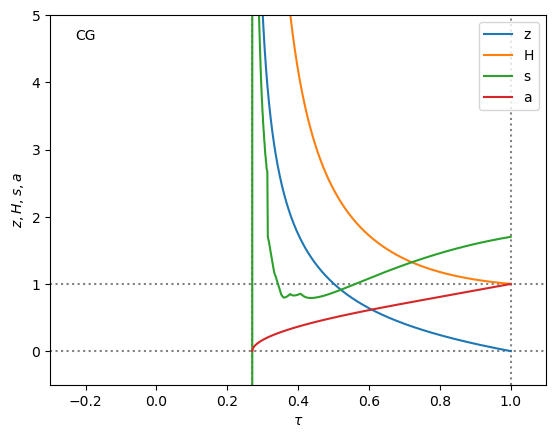


 --- Results -------------------------------------
 zmin                 =   0.000e+00  []
 zmax                 =   1.854e+05  []
 z(transparency)      =   1.089e+03  []
 r(transparency)      =   7.388e+03  [Mpc]
 z_drag               =   1.020e+03  []
 r_drag               =   2.812e+02  [Mpc]
 H(zmin)              =   1.000e+00  []
 H(zmax)              =   5.492e+08  []
 H_GR(z=10^9)         =   7.374e+15  []
 H_CG(z=10^9)         =   0.000e+00  []
 r_sound              =   5.107e+02  []
 R                    =   9.318e-01  []
 R(Planck)            =   1.766e+00  []
 la                   =   4.545e+01  []
 la(Planck)           =   3.017e+02  []
 -------------------------------------------------


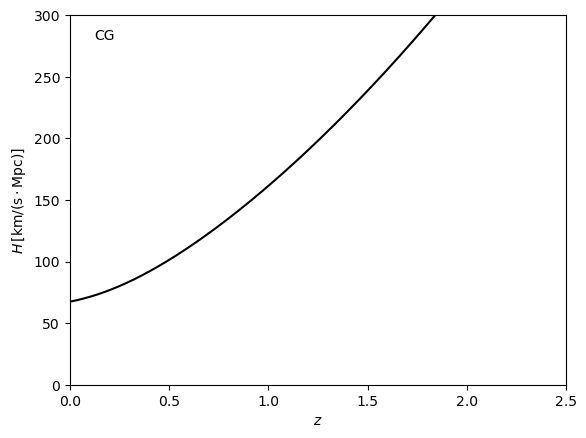

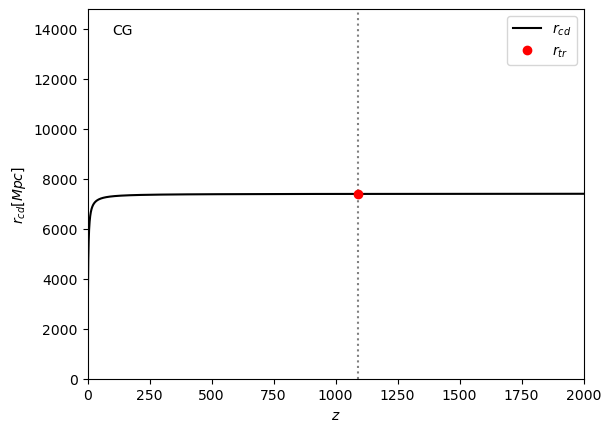

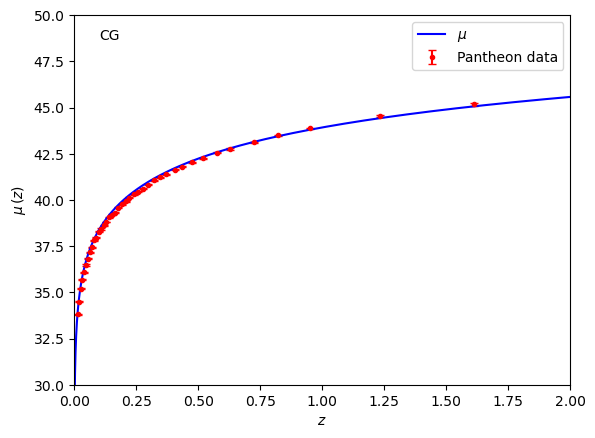

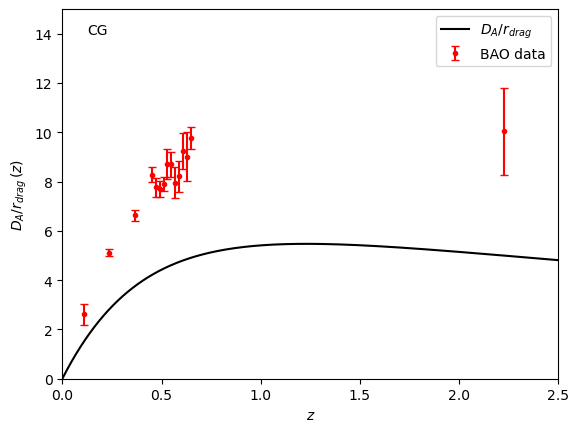

In [183]:
# -------------------------------
# --- Output for test data ------
# -------------------------------
FL.print_parameters()
FL.print_solution()
#print(FL.y[1, FL.imin:FL.imin+10])
#print(MD.Hz[-10:-1])

xmin = -0.3; xmax = 1.1; ymin = -5.e-1; ymax = 5.e0
#xmin = -0.23; xmax = -0.2; ymin = -5.e-2; ymax = 5.e-1
#xmin = -0.23; xmax = 0.1; ymin = -5.e-2; ymax = 5.e-1
FL.draw_zHs(xmin, xmax, ymin, ymax)

MD.print_results()

#xmin = 0; xmax = MD.z[-1]*1.1; ymin = min(MD.Hz)*0.9; ymax = max(MD.Hz)*1.1
xmin = 0; xmax = 2.5; ymin = 0; ymax = 300
MD.draw_H(xmin, xmax, ymin, ymax)

xmin = 0; xmax = 2000; ymin = 0; ymax = 2*MD.rtr
#xmin = 0; xmax = 2000; ymin = 0; ymax = 0.1*max(MD.rcd)
#print(ymax)
MD.draw_rcd(xmin, xmax, ymin, ymax)

xmin = 0; xmax = 2; ymin = 30; ymax = 50
MD.draw_mu(xmin, xmax, ymin, ymax, dataset.SNe_redshift, dataset.distmod, dataset.distmod_unc)

xmin = 0; xmax = 2.5; ymin = 0; ymax = 15
MD.draw_bao(xmin, xmax, ymin, ymax, dataset.BAO_redshift, dataset.BAO_DA_rdrag, dataset.BAO_DA_rdrag_unc)

In [21]:
#sys.exit()

# MCMC

In [15]:
#Set GR='n'
GR = 'n'

#Put 'n' if the parameter has a fixed value or 'y' if it is to be optimised in MCMC
paramlist = {'Omega_matter': 'y', 'Omega_radiation': 'n', 'Omega_lambda': 'n', 'Omega_k': 'n', 'h': 'n', 'Omega_s': 'y', 'Omega_g': 'n', 's1': 'n'}

#Provide the values of the fixed parameters
fixed_values = {'Omega_radiation': 5.44e-5, 'Omega_lambda': 0.685, 'Omega_k': 0.0, 'h': 0.674, 'Omega_g': -1.0, 's1': 0.5}

#Provide the prior ranges of the parameters to optimise
prior_range = {'Omega_matter': [0.3,0.34], 'Omega_s': [0.55,0.8]}

#Provide which datasets we want to use
datasets_used = {'SNeIa': 'y', 'CC': 'y', 'BAO': 'y', 'CMB': 'y', 'BBN': 'y'}

#Number of MCMC iterations
n_iterations = 300

#Initialise 
Test = MCMCRunner(paramlist, fixed_values, prior_range, datasets_used, calc_mcmc_input, n_iterations)

#Print
Test.printparams()


 --- Parameters/Datasets -------------------------------------
 
 #Parameters to optimise               = 2
 Parameters to optimise                = ['Omega_matter', 'Omega_s']
 Prior ranges                          = {'Omega_matter': [0.3, 0.34], 'Omega_s': [0.55, 0.8]}
 
 Fixed Parameters                      = ['Omega_radiation', 'Omega_lambda', 'Omega_k', 'h', 'Omega_g', 's1']
 Values of fixed Parameters            = {'Omega_radiation': 5.44e-05, 'Omega_lambda': 0.685, 'Omega_k': 0.0, 'h': 0.674, 'Omega_g': -1.0, 's1': 0.5}
 
 Datasets used                         = {'SNeIa': 'y', 'CC': 'y', 'BAO': 'y', 'CMB': 'y', 'BBN': 'y'}
 
 -------------------------------------------------------------


In [16]:
Test.runmcmc(MD, dataset, FL)

853 [ 0.00000000e+00 -6.40096301e+21  1.21952396e+11  1.98392181e+02]
[ 45.36373575  64.51973474 198.39218071]
853 [ 0.00000000e+00 -6.40096301e+21  1.21952396e+11  1.98392181e+02]
[ 45.36373575  64.51973474 198.39218071]
853 [ 0.00000000e+00 -6.40096301e+21  1.21952396e+11  1.98392181e+02]
[ 45.36373575  64.51973474 198.39218071]
853 [ 0.00000000e+00 -6.40096301e+21  1.21952396e+11  1.98392181e+02]
[ 45.36373575  64.51973474 198.39218071]
862 [ 0.00000000e+00 -2.22741117e+08  3.58281411e+02  6.98138167e+01]
[37.49406783 46.91403262 69.81381667]
862 [ 0.00000000e+00 -2.22741117e+08  3.58281411e+02  6.98138167e+01]
[37.49406783 46.91403262 69.81381667]
862 [ 0.00000000e+00 -2.22741117e+08  3.58281411e+02  6.98138167e+01]
[37.49406783 46.91403262 69.81381667]
862 [ 0.00000000e+00 -2.22741117e+08  3.58281411e+02  6.98138167e+01]
[37.49406783 46.91403262 69.81381667]
889 [8.36534252e+21 1.19504893e+21 5.32639962e+02 7.11600381e+01]
[7.11600381e+01 5.32639962e+02 1.19504893e+21]
889 [8.3653

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

856 [7.39399354e+15 1.05628486e+15 3.01552024e+02 6.86498060e+01]
[6.86498060e+01 3.01552024e+02 1.05628486e+15]
856 [7.39399354e+15 1.05628486e+15 3.01552024e+02 6.86498060e+01]
[6.86498060e+01 3.01552024e+02 1.05628486e+15]
856 [7.39399354e+15 1.05628486e+15 3.01552024e+02 6.86498060e+01]
[6.86498060e+01 3.01552024e+02 1.05628486e+15]
856 [7.39399354e+15 1.05628486e+15 3.01552024e+02 6.86498060e+01]
[6.86498060e+01 3.01552024e+02 1.05628486e+15]
856 [7.39399354e+15 1.05628486e+15 3.01552024e+02 6.86498060e+01]
[6.86498060e+01 3.01552024e+02 1.05628486e+15]
867 [0.0000000e+00 0.0000000e+00 8.6340873e+11 6.5805894e+02]
[ 47.72438416  73.65268555 658.05894014]
867 [0.0000000e+00 0.0000000e+00 8.6340873e+11 6.5805894e+02]
[ 47.72438416  73.65268555 658.05894014]
867 [0.0000000e+00 0.0000000e+00 8.6340873e+11 6.5805894e+02]
[ 47.72438416  73.65268555 658.05894014]
867 [0.0000000e+00 0.0000000e+00 8.6340873e+11 6.5805894e+02]
[ 47.72438416  73.65268555 658.05894014]
883 [2.19064030e+13 3.1

C:\Users\armin\anaconda3\envs\CCGG\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


883 [2.19064030e+13 3.12948937e+12 2.18065838e+02 6.38009023e+01]
[6.38009023e+01 2.18065838e+02 3.12948937e+12]
883 [2.19064030e+13 3.12948937e+12 2.18065838e+02 6.38009023e+01]
[6.38009023e+01 2.18065838e+02 3.12948937e+12]
883 [2.19064030e+13 3.12948937e+12 2.18065838e+02 6.38009023e+01]
[6.38009023e+01 2.18065838e+02 3.12948937e+12]


  0%|▎                                                                                 | 1/300 [00:01<07:42,  1.55s/it]

883 [2.19064030e+13 3.12948937e+12 2.18065838e+02 6.38009023e+01]
[6.38009023e+01 2.18065838e+02 3.12948937e+12]
877 [0.00000000e+00 1.72822147e+14 3.24822423e+07 1.33452122e+02]
[5.80146915e+01 1.33452122e+02 3.24822423e+07]
877 [0.00000000e+00 1.72822147e+14 3.24822423e+07 1.33452122e+02]
[5.80146915e+01 1.33452122e+02 3.24822423e+07]
877 [0.00000000e+00 1.72822147e+14 3.24822423e+07 1.33452122e+02]
[5.80146915e+01 1.33452122e+02 3.24822423e+07]
877 [0.00000000e+00 1.72822147e+14 3.24822423e+07 1.33452122e+02]
[5.80146915e+01 1.33452122e+02 3.24822423e+07]
877 [0.00000000e+00 1.72822147e+14 3.24822423e+07 1.33452122e+02]
[5.80146915e+01 1.33452122e+02 3.24822423e+07]
848 [0.00000000e+00 0.00000000e+00 8.58936383e+08 3.53319366e+02]
[ 47.51020034  70.5703324  353.31936627]
848 [0.00000000e+00 0.00000000e+00 8.58936383e+08 3.53319366e+02]
[ 47.51020034  70.5703324  353.31936627]
848 [0.00000000e+00 0.00000000e+00 8.58936383e+08 3.53319366e+02]
[ 47.51020034  70.5703324  353.31936627]
8

  1%|▌                                                                                 | 2/300 [00:03<07:34,  1.52s/it]

861 [0.00000000e+00 3.26941478e+13 1.46262982e+07 1.31283259e+02]
[5.86550372e+01 1.31283259e+02 1.46262982e+07]
861 [0.00000000e+00 3.26941478e+13 1.46262982e+07 1.31283259e+02]
[5.86550372e+01 1.31283259e+02 1.46262982e+07]
859 [0.00000000e+00 5.28192564e+15 1.76215424e+08 1.46298502e+02]
[6.01058167e+01 1.46298502e+02 1.76215424e+08]
859 [0.00000000e+00 5.28192564e+15 1.76215424e+08 1.46298502e+02]
[6.01058167e+01 1.46298502e+02 1.76215424e+08]
859 [0.00000000e+00 5.28192564e+15 1.76215424e+08 1.46298502e+02]
[6.01058167e+01 1.46298502e+02 1.76215424e+08]
859 [0.00000000e+00 5.28192564e+15 1.76215424e+08 1.46298502e+02]
[6.01058167e+01 1.46298502e+02 1.76215424e+08]
859 [0.00000000e+00 5.28192564e+15 1.76215424e+08 1.46298502e+02]
[6.01058167e+01 1.46298502e+02 1.76215424e+08]
900 [0.00000000e+00 4.26188391e+21 7.71649154e+03 8.62631241e+01]
[  50.0973261    86.26312407 7716.49153919]
900 [0.00000000e+00 4.26188391e+21 7.71649154e+03 8.62631241e+01]
[  50.0973261    86.26312407 7716

  1%|▊                                                                                 | 3/300 [00:04<07:30,  1.52s/it]

862 [0.00000000e+00 3.43742269e+13 9.52593256e+02 7.71483032e+01]
[ 49.07294631  77.14830322 952.59325607]
866 [0.00000000e+00 3.16024589e+19 3.98990074e+03 8.55530722e+01]
[  51.07810507   85.55307216 3989.90073861]
866 [0.00000000e+00 3.16024589e+19 3.98990074e+03 8.55530722e+01]
[  51.07810507   85.55307216 3989.90073861]
866 [0.00000000e+00 3.16024589e+19 3.98990074e+03 8.55530722e+01]
[  51.07810507   85.55307216 3989.90073861]
866 [0.00000000e+00 3.16024589e+19 3.98990074e+03 8.55530722e+01]
[  51.07810507   85.55307216 3989.90073861]
866 [0.00000000e+00 3.16024589e+19 3.98990074e+03 8.55530722e+01]
[  51.07810507   85.55307216 3989.90073861]
856 [ 0.00000000e+00 -3.32752321e+23  3.48249831e+06  1.23383740e+02]
[ 42.69294661  57.87802329 123.38374005]
856 [ 0.00000000e+00 -3.32752321e+23  3.48249831e+06  1.23383740e+02]
[ 42.69294661  57.87802329 123.38374005]
856 [ 0.00000000e+00 -3.32752321e+23  3.48249831e+06  1.23383740e+02]
[ 42.69294661  57.87802329 123.38374005]
856 [ 0.00

  1%|█                                                                                 | 4/300 [00:07<09:33,  1.94s/it]

849 [0.00000000e+00 4.95042855e+19 4.26229350e+03 8.73576176e+01]
[  52.05573721   87.35761756 4262.29349848]
855 [0.00000000e+00 0.00000000e+00 3.40358825e+08 3.63583903e+02]
[ 47.23649417  70.33182289 363.58390304]
855 [0.00000000e+00 0.00000000e+00 3.40358825e+08 3.63583903e+02]
[ 47.23649417  70.33182289 363.58390304]
855 [0.00000000e+00 0.00000000e+00 3.40358825e+08 3.63583903e+02]
[ 47.23649417  70.33182289 363.58390304]
855 [0.00000000e+00 0.00000000e+00 3.40358825e+08 3.63583903e+02]
[ 47.23649417  70.33182289 363.58390304]
879 [ 0.00000000e+00 -4.15059530e+18  4.43158682e+02  7.03442090e+01]
[37.07220243 46.59074176 70.34420904]
879 [ 0.00000000e+00 -4.15059530e+18  4.43158682e+02  7.03442090e+01]
[37.07220243 46.59074176 70.34420904]
879 [ 0.00000000e+00 -4.15059530e+18  4.43158682e+02  7.03442090e+01]
[37.07220243 46.59074176 70.34420904]
879 [ 0.00000000e+00 -4.15059530e+18  4.43158682e+02  7.03442090e+01]
[37.07220243 46.59074176 70.34420904]
867 [7.05598742e+21 1.00799820

  2%|█▎                                                                                | 5/300 [00:09<09:32,  1.94s/it]

871 [0.00000000e+00 7.16452619e+12 1.33773866e+04 9.13543589e+01]
[   52.03287878    91.35435893 13377.38664656]
871 [0.00000000e+00 7.16452619e+12 1.33773866e+04 9.13543589e+01]
[   52.03287878    91.35435893 13377.38664656]
874 [0.00000000e+00 1.63755406e+13 9.02672034e+02 7.59253346e+01]
[ 48.39547448  75.92533463 902.67203403]
874 [0.00000000e+00 1.63755406e+13 9.02672034e+02 7.59253346e+01]
[ 48.39547448  75.92533463 902.67203403]
874 [0.00000000e+00 1.63755406e+13 9.02672034e+02 7.59253346e+01]
[ 48.39547448  75.92533463 902.67203403]
874 [0.00000000e+00 1.63755406e+13 9.02672034e+02 7.59253346e+01]
[ 48.39547448  75.92533463 902.67203403]
903 [0.00000000e+00 2.92654577e+13 8.98596754e+02 7.38448954e+01]
[ 47.01406046  73.84489544 898.59675381]
903 [0.00000000e+00 2.92654577e+13 8.98596754e+02 7.38448954e+01]
[ 47.01406046  73.84489544 898.59675381]
903 [0.00000000e+00 2.92654577e+13 8.98596754e+02 7.38448954e+01]
[ 47.01406046  73.84489544 898.59675381]
903 [0.00000000e+00 2.926

  2%|█▋                                                                                | 6/300 [00:11<10:02,  2.05s/it]

885 [0.00000000e+00 4.54070453e+13 9.60127869e+02 7.55289436e+01]
[ 47.96714336  75.52894357 960.12786947]
885 [0.00000000e+00 4.54070453e+13 9.60127869e+02 7.55289436e+01]
[ 47.96714336  75.52894357 960.12786947]
849 [0.00000000e+00 4.12653090e+16 4.93909002e+08 1.55159080e+02]
[6.15870413e+01 1.55159080e+02 4.93909002e+08]
849 [0.00000000e+00 4.12653090e+16 4.93909002e+08 1.55159080e+02]
[6.15870413e+01 1.55159080e+02 4.93909002e+08]
849 [0.00000000e+00 4.12653090e+16 4.93909002e+08 1.55159080e+02]
[6.15870413e+01 1.55159080e+02 4.93909002e+08]
849 [0.00000000e+00 4.12653090e+16 4.93909002e+08 1.55159080e+02]
[6.15870413e+01 1.55159080e+02 4.93909002e+08]
849 [0.00000000e+00 4.12653090e+16 4.93909002e+08 1.55159080e+02]
[6.15870413e+01 1.55159080e+02 4.93909002e+08]
867 [0.00000000e+00 7.37055069e+15 2.05639010e+08 1.45845179e+02]
[5.95964137e+01 1.45845179e+02 2.05639010e+08]
867 [0.00000000e+00 7.37055069e+15 2.05639010e+08 1.45845179e+02]
[5.95964137e+01 1.45845179e+02 2.05639010e

  2%|█▉                                                                                | 7/300 [00:13<09:57,  2.04s/it]

855 [0.00000000e+00 2.40274784e+18 4.04713183e+02 7.11860252e+01]
[ 47.48352174  71.1860252  404.71318271]
855 [0.00000000e+00 2.40274784e+18 4.04713183e+02 7.11860252e+01]
[ 47.48352174  71.1860252  404.71318271]
855 [0.00000000e+00 2.40274784e+18 4.04713183e+02 7.11860252e+01]
[ 47.48352174  71.1860252  404.71318271]
854 [0.00000000e+00 6.71865474e+14 3.97067192e+04 9.90865078e+01]
[   54.26759697    99.08650779 39706.71922425]
854 [0.00000000e+00 6.71865474e+14 3.97067192e+04 9.90865078e+01]
[   54.26759697    99.08650779 39706.71922425]
854 [0.00000000e+00 6.71865474e+14 3.97067192e+04 9.90865078e+01]
[   54.26759697    99.08650779 39706.71922425]
854 [0.00000000e+00 6.71865474e+14 3.97067192e+04 9.90865078e+01]
[   54.26759697    99.08650779 39706.71922425]
854 [0.00000000e+00 6.71865474e+14 3.97067192e+04 9.90865078e+01]
[   54.26759697    99.08650779 39706.71922425]
883 [0.00000000e+00 2.07530374e+18 3.50803384e+09 1.63262208e+02]
[6.05544810e+01 1.63262208e+02 3.50803384e+09]
8

  3%|██▏                                                                               | 8/300 [00:15<10:39,  2.19s/it]

881 [ 0.00000000e+00 -3.87456223e+11  3.13906281e+02  6.74165253e+01]
[36.56533459 45.64395522 67.41652532]
881 [ 0.00000000e+00 -3.87456223e+11  3.13906281e+02  6.74165253e+01]
[36.56533459 45.64395522 67.41652532]
881 [ 0.00000000e+00 -3.87456223e+11  3.13906281e+02  6.74165253e+01]
[36.56533459 45.64395522 67.41652532]
868 [2.13141106e+20 3.04487295e+19 4.57988728e+02 7.14079498e+01]
[7.14079498e+01 4.57988728e+02 3.04487295e+19]
868 [2.13141106e+20 3.04487295e+19 4.57988728e+02 7.14079498e+01]
[7.14079498e+01 4.57988728e+02 3.04487295e+19]
868 [2.13141106e+20 3.04487295e+19 4.57988728e+02 7.14079498e+01]
[7.14079498e+01 4.57988728e+02 3.04487295e+19]
868 [2.13141106e+20 3.04487295e+19 4.57988728e+02 7.14079498e+01]
[7.14079498e+01 4.57988728e+02 3.04487295e+19]
868 [2.13141106e+20 3.04487295e+19 4.57988728e+02 7.14079498e+01]
[7.14079498e+01 4.57988728e+02 3.04487295e+19]
864 [0.00000000e+00 1.36498016e+20 7.06222213e+05 1.13004246e+02]
[5.59521905e+01 1.13004246e+02 7.06222213e+05

  3%|██▍                                                                               | 9/300 [00:18<11:27,  2.36s/it]

884 [0.00000000e+00 7.75148485e+14 6.76719759e+07 1.37192067e+02]
[5.81692148e+01 1.37192067e+02 6.76719759e+07]
884 [0.00000000e+00 7.75148485e+14 6.76719759e+07 1.37192067e+02]
[5.81692148e+01 1.37192067e+02 6.76719759e+07]
884 [0.00000000e+00 7.75148485e+14 6.76719759e+07 1.37192067e+02]
[5.81692148e+01 1.37192067e+02 6.76719759e+07]
854 [0.00000000e+00 4.36014358e+14 5.19902597e+07 1.39825165e+02]
[5.98721050e+01 1.39825165e+02 5.19902597e+07]
854 [0.00000000e+00 4.36014358e+14 5.19902597e+07 1.39825165e+02]
[5.98721050e+01 1.39825165e+02 5.19902597e+07]
854 [0.00000000e+00 4.36014358e+14 5.19902597e+07 1.39825165e+02]
[5.98721050e+01 1.39825165e+02 5.19902597e+07]
854 [0.00000000e+00 4.36014358e+14 5.19902597e+07 1.39825165e+02]
[5.98721050e+01 1.39825165e+02 5.19902597e+07]
854 [0.00000000e+00 4.36014358e+14 5.19902597e+07 1.39825165e+02]
[5.98721050e+01 1.39825165e+02 5.19902597e+07]
855 [0.00000000e+00 2.54007535e+12 4.24585435e+06 1.24687990e+02]
[5.81004029e+01 1.24687990e+02

  3%|██▋                                                                              | 10/300 [00:20<10:55,  2.26s/it]

862 [0.00000000e+00 6.62531090e+13 2.52437859e+02 6.63275179e+01]
[ 45.67773259  66.32751795 252.43785875]
861 [0.00000000e+00 2.05942238e+20 7.10737929e+10 1.89538510e+02]
[6.34494805e+01 1.89538510e+02 7.10737929e+10]
861 [0.00000000e+00 2.05942238e+20 7.10737929e+10 1.89538510e+02]
[6.34494805e+01 1.89538510e+02 7.10737929e+10]
861 [0.00000000e+00 2.05942238e+20 7.10737929e+10 1.89538510e+02]
[6.34494805e+01 1.89538510e+02 7.10737929e+10]
861 [0.00000000e+00 2.05942238e+20 7.10737929e+10 1.89538510e+02]
[6.34494805e+01 1.89538510e+02 7.10737929e+10]
861 [0.00000000e+00 2.05942238e+20 7.10737929e+10 1.89538510e+02]
[6.34494805e+01 1.89538510e+02 7.10737929e+10]
890 [-7.12110413e+19 -1.01730059e+19  7.64308809e+02  7.67462160e+01]
[37.69382173 48.11595816 76.74621599]
890 [-7.12110413e+19 -1.01730059e+19  7.64308809e+02  7.67462160e+01]
[37.69382173 48.11595816 76.74621599]
890 [-7.12110413e+19 -1.01730059e+19  7.64308809e+02  7.67462160e+01]
[37.69382173 48.11595816 76.74621599]
890 

  4%|██▉                                                                              | 11/300 [00:22<09:44,  2.02s/it]

882 [0.00000000e+00 4.47944039e+12 7.60114110e+02 7.41629922e+01]
[ 47.66607294  74.16299216 760.1141099 ]
882 [0.00000000e+00 4.47944039e+12 7.60114110e+02 7.41629922e+01]
[ 47.66607294  74.16299216 760.1141099 ]
871 [0.00000000e+00 1.79830207e+17 2.25371911e+03 8.18272491e+01]
[  50.01562396   81.82724906 2253.71910604]
871 [0.00000000e+00 1.79830207e+17 2.25371911e+03 8.18272491e+01]
[  50.01562396   81.82724906 2253.71910604]
871 [0.00000000e+00 1.79830207e+17 2.25371911e+03 8.18272491e+01]
[  50.01562396   81.82724906 2253.71910604]
871 [0.00000000e+00 1.79830207e+17 2.25371911e+03 8.18272491e+01]
[  50.01562396   81.82724906 2253.71910604]
871 [0.00000000e+00 1.79830207e+17 2.25371911e+03 8.18272491e+01]
[  50.01562396   81.82724906 2253.71910604]
883 [0.00000000e+00 2.31998648e+19 3.78684558e+03 8.38728581e+01]
[  50.14582021   83.8728581  3786.84558235]
883 [0.00000000e+00 2.31998648e+19 3.78684558e+03 8.38728581e+01]
[  50.14582021   83.8728581  3786.84558235]
883 [0.00000000e

  4%|███▏                                                                             | 12/300 [00:24<10:50,  2.26s/it]

857 [0.00000000e+00 1.18796183e+19 4.02551613e+05 1.10691020e+02]
[5.58868714e+01 1.10691020e+02 4.02551613e+05]
857 [0.00000000e+00 1.18796183e+19 4.02551613e+05 1.10691020e+02]
[5.58868714e+01 1.10691020e+02 4.02551613e+05]
867 [0.00000000e+00 1.81565755e+17 2.34082524e+03 8.24524441e+01]
[  50.32436518   82.45244409 2340.8252442 ]
867 [0.00000000e+00 1.81565755e+17 2.34082524e+03 8.24524441e+01]
[  50.32436518   82.45244409 2340.8252442 ]
867 [0.00000000e+00 1.81565755e+17 2.34082524e+03 8.24524441e+01]
[  50.32436518   82.45244409 2340.8252442 ]
867 [0.00000000e+00 1.81565755e+17 2.34082524e+03 8.24524441e+01]
[  50.32436518   82.45244409 2340.8252442 ]
867 [0.00000000e+00 1.81565755e+17 2.34082524e+03 8.24524441e+01]
[  50.32436518   82.45244409 2340.8252442 ]
866 [0.00000000e+00 1.95620816e+17 2.28213283e+03 8.22580229e+01]
[  50.26442947   82.2580229  2282.13283216]
866 [0.00000000e+00 1.95620816e+17 2.28213283e+03 8.22580229e+01]
[  50.26442947   82.2580229  2282.13283216]
866 

  4%|███▌                                                                             | 13/300 [00:27<11:20,  2.37s/it]

869 [0.00000000e+00 4.88450161e+13 2.07850661e+04 9.39158197e+01]
[   52.6295197     93.91581972 20785.06609704]
869 [0.00000000e+00 4.88450161e+13 2.07850661e+04 9.39158197e+01]
[   52.6295197     93.91581972 20785.06609704]
860 [0.00000000e+00 9.28484103e+15 2.33043808e+08 1.48419216e+02]
[6.04042510e+01 1.48419216e+02 2.33043808e+08]
860 [0.00000000e+00 9.28484103e+15 2.33043808e+08 1.48419216e+02]
[6.04042510e+01 1.48419216e+02 2.33043808e+08]
860 [0.00000000e+00 9.28484103e+15 2.33043808e+08 1.48419216e+02]
[6.04042510e+01 1.48419216e+02 2.33043808e+08]
860 [0.00000000e+00 9.28484103e+15 2.33043808e+08 1.48419216e+02]
[6.04042510e+01 1.48419216e+02 2.33043808e+08]
860 [0.00000000e+00 9.28484103e+15 2.33043808e+08 1.48419216e+02]
[6.04042510e+01 1.48419216e+02 2.33043808e+08]
879 [0.00000000e+00 4.24573217e+14 5.06418849e+07 1.36223464e+02]
[5.83350665e+01 1.36223464e+02 5.06418849e+07]
879 [0.00000000e+00 4.24573217e+14 5.06418849e+07 1.36223464e+02]
[5.83350665e+01 1.36223464e+02

  5%|███▊                                                                             | 14/300 [00:30<11:41,  2.45s/it]

869 [0.00000000e+00 3.95435567e+15 1.52182045e+03 7.94220198e+01]
[  49.38828619   79.42201981 1521.82044587]
889 [0.00000000e+00 3.38330472e+18 4.43421185e+09 1.63342767e+02]
[6.00980322e+01 1.63342767e+02 4.43421185e+09]
889 [0.00000000e+00 3.38330472e+18 4.43421185e+09 1.63342767e+02]
[6.00980322e+01 1.63342767e+02 4.43421185e+09]
889 [0.00000000e+00 3.38330472e+18 4.43421185e+09 1.63342767e+02]
[6.00980322e+01 1.63342767e+02 4.43421185e+09]
889 [0.00000000e+00 3.38330472e+18 4.43421185e+09 1.63342767e+02]
[6.00980322e+01 1.63342767e+02 4.43421185e+09]
889 [0.00000000e+00 3.38330472e+18 4.43421185e+09 1.63342767e+02]
[6.00980322e+01 1.63342767e+02 4.43421185e+09]
855 [6.86831286e+15 9.81187604e+14 2.87992317e+02 6.82826467e+01]
[6.82826467e+01 2.87992317e+02 9.81187604e+14]
855 [6.86831286e+15 9.81187604e+14 2.87992317e+02 6.82826467e+01]
[6.82826467e+01 2.87992317e+02 9.81187604e+14]
855 [6.86831286e+15 9.81187604e+14 2.87992317e+02 6.82826467e+01]
[6.82826467e+01 2.87992317e+02 9.

  5%|████                                                                             | 15/300 [00:32<11:14,  2.37s/it]

865 [0.00000000e+00 3.26611029e+12 1.12720043e+04 9.10969297e+01]
[   52.2334783     91.0969297  11272.00427933]
898 [ 0.00000000e+00 -6.09429426e+08  4.92223780e+03  8.37860684e+01]
[38.23892216 49.53905035 83.78606837]
898 [ 0.00000000e+00 -6.09429426e+08  4.92223780e+03  8.37860684e+01]
[38.23892216 49.53905035 83.78606837]
898 [ 0.00000000e+00 -6.09429426e+08  4.92223780e+03  8.37860684e+01]
[38.23892216 49.53905035 83.78606837]
898 [ 0.00000000e+00 -6.09429426e+08  4.92223780e+03  8.37860684e+01]
[38.23892216 49.53905035 83.78606837]
866 [-1.25655504e+15 -1.79507619e+14  3.58967915e+02  6.94842406e+01]
[37.29577201 46.67145198 69.48424062]
866 [-1.25655504e+15 -1.79507619e+14  3.58967915e+02  6.94842406e+01]
[37.29577201 46.67145198 69.48424062]
866 [-1.25655504e+15 -1.79507619e+14  3.58967915e+02  6.94842406e+01]
[37.29577201 46.67145198 69.48424062]
866 [-1.25655504e+15 -1.79507619e+14  3.58967915e+02  6.94842406e+01]
[37.29577201 46.67145198 69.48424062]
847 [0.00000000e+00 6.8

  5%|████▎                                                                            | 16/300 [00:35<11:54,  2.52s/it]

884 [0.00000000e+00 1.34587178e+19 3.55102522e+03 8.34564170e+01]
[  50.026156     83.45641695 3551.02521661]
862 [0.00000000e+00 3.72235583e+12 7.61122084e+02 7.56195471e+01]
[ 48.65127984  75.61954707 761.12208435]
862 [0.00000000e+00 3.72235583e+12 7.61122084e+02 7.56195471e+01]
[ 48.65127984  75.61954707 761.12208435]
862 [0.00000000e+00 3.72235583e+12 7.61122084e+02 7.56195471e+01]
[ 48.65127984  75.61954707 761.12208435]
862 [0.00000000e+00 3.72235583e+12 7.61122084e+02 7.56195471e+01]
[ 48.65127984  75.61954707 761.12208435]
891 [0.00000000e+00 1.34401218e+19 9.28099622e+09 1.68529063e+02]
[6.04574564e+01 1.68529063e+02 9.28099622e+09]
891 [0.00000000e+00 1.34401218e+19 9.28099622e+09 1.68529063e+02]
[6.04574564e+01 1.68529063e+02 9.28099622e+09]
891 [0.00000000e+00 1.34401218e+19 9.28099622e+09 1.68529063e+02]
[6.04574564e+01 1.68529063e+02 9.28099622e+09]
891 [0.00000000e+00 1.34401218e+19 9.28099622e+09 1.68529063e+02]
[6.04574564e+01 1.68529063e+02 9.28099622e+09]
891 [0.000

  6%|████▌                                                                            | 17/300 [00:36<10:27,  2.22s/it]

874 [0.00000000e+00 6.08799584e+19 6.87892989e+05 1.12070382e+02]
[5.55210703e+01 1.12070382e+02 6.87892989e+05]
881 [0.00000000e+00 2.99210762e+13 1.38182517e+07 1.28291273e+02]
[5.73932269e+01 1.28291273e+02 1.38182517e+07]
881 [0.00000000e+00 2.99210762e+13 1.38182517e+07 1.28291273e+02]
[5.73932269e+01 1.28291273e+02 1.38182517e+07]
881 [0.00000000e+00 2.99210762e+13 1.38182517e+07 1.28291273e+02]
[5.73932269e+01 1.28291273e+02 1.38182517e+07]
881 [0.00000000e+00 2.99210762e+13 1.38182517e+07 1.28291273e+02]
[5.73932269e+01 1.28291273e+02 1.38182517e+07]
881 [0.00000000e+00 2.99210762e+13 1.38182517e+07 1.28291273e+02]
[5.73932269e+01 1.28291273e+02 1.38182517e+07]
865 [0.00000000e+00 2.16231584e+12 3.90157573e+06 1.22786422e+02]
[5.73582502e+01 1.22786422e+02 3.90157573e+06]
865 [0.00000000e+00 2.16231584e+12 3.90157573e+06 1.22786422e+02]
[5.73582502e+01 1.22786422e+02 3.90157573e+06]
865 [0.00000000e+00 2.16231584e+12 3.90157573e+06 1.22786422e+02]
[5.73582502e+01 1.22786422e+02

  6%|████▊                                                                            | 18/300 [00:39<10:51,  2.31s/it]

880 [0.00000000e+00 3.82915044e+14 3.36303346e+04 9.55773942e+01]
[   52.60978664    95.57739424 33630.33459562]
880 [0.00000000e+00 3.82915044e+14 3.36303346e+04 9.55773942e+01]
[   52.60978664    95.57739424 33630.33459562]
880 [0.00000000e+00 3.82915044e+14 3.36303346e+04 9.55773942e+01]
[   52.60978664    95.57739424 33630.33459562]
861 [0.00000000e+00 1.09173536e+17 7.94255496e+08 1.56286032e+02]
[6.10219829e+01 1.56286032e+02 7.94255496e+08]
861 [0.00000000e+00 1.09173536e+17 7.94255496e+08 1.56286032e+02]
[6.10219829e+01 1.56286032e+02 7.94255496e+08]
861 [0.00000000e+00 1.09173536e+17 7.94255496e+08 1.56286032e+02]
[6.10219829e+01 1.56286032e+02 7.94255496e+08]
861 [0.00000000e+00 1.09173536e+17 7.94255496e+08 1.56286032e+02]
[6.10219829e+01 1.56286032e+02 7.94255496e+08]
861 [0.00000000e+00 1.09173536e+17 7.94255496e+08 1.56286032e+02]
[6.10219829e+01 1.56286032e+02 7.94255496e+08]
880 [0.00000000e+00 4.50917428e+12 1.19776080e+04 9.01377482e+01]
[   51.53618184    90.13774818

  6%|█████▏                                                                           | 19/300 [00:42<12:05,  2.58s/it]

853 [0.00000000e+00 0.00000000e+00 2.42410478e+07 1.13431486e+03]
[  49.82874261   79.13654422 1134.31485684]
853 [0.00000000e+00 0.00000000e+00 2.42410478e+07 1.13431486e+03]
[  49.82874261   79.13654422 1134.31485684]
853 [0.00000000e+00 0.00000000e+00 2.42410478e+07 1.13431486e+03]
[  49.82874261   79.13654422 1134.31485684]
860 [-1.49214714e+15 -2.13163844e+14  2.74322363e+02  6.74789529e+01]
[37.14145233 46.19815599 67.4789529 ]
860 [-1.49214714e+15 -2.13163844e+14  2.74322363e+02  6.74789529e+01]
[37.14145233 46.19815599 67.4789529 ]
860 [-1.49214714e+15 -2.13163844e+14  2.74322363e+02  6.74789529e+01]
[37.14145233 46.19815599 67.4789529 ]
860 [-1.49214714e+15 -2.13163844e+14  2.74322363e+02  6.74789529e+01]
[37.14145233 46.19815599 67.4789529 ]
875 [0.00000000e+00 2.39031524e+21 1.63402372e+06 1.16920419e+02]
[5.62296025e+01 1.16920419e+02 1.63402372e+06]
875 [0.00000000e+00 2.39031524e+21 1.63402372e+06 1.16920419e+02]
[5.62296025e+01 1.16920419e+02 1.63402372e+06]
875 [0.00000

  7%|█████▍                                                                           | 20/300 [00:45<12:47,  2.74s/it]

869 [0.00000000e+00 1.33648105e+17 2.18202662e+03 8.16405081e+01]
[  49.97613193   81.64050813 2182.02661612]
869 [0.00000000e+00 1.33648105e+17 2.18202662e+03 8.16405081e+01]
[  49.97613193   81.64050813 2182.02661612]
874 [0.00000000e+00 1.47393151e+18 2.95821874e+09 1.63145586e+02]
[6.08940129e+01 1.63145586e+02 2.95821874e+09]
874 [0.00000000e+00 1.47393151e+18 2.95821874e+09 1.63145586e+02]
[6.08940129e+01 1.63145586e+02 2.95821874e+09]
874 [0.00000000e+00 1.47393151e+18 2.95821874e+09 1.63145586e+02]
[6.08940129e+01 1.63145586e+02 2.95821874e+09]
874 [0.00000000e+00 1.47393151e+18 2.95821874e+09 1.63145586e+02]
[6.08940129e+01 1.63145586e+02 2.95821874e+09]
874 [0.00000000e+00 1.47393151e+18 2.95821874e+09 1.63145586e+02]
[6.08940129e+01 1.63145586e+02 2.95821874e+09]
873 [1.84145265e+17 2.63064668e+16 3.26194040e+02 6.81439569e+01]
[6.81439569e+01 3.26194040e+02 2.63064668e+16]
873 [1.84145265e+17 2.63064668e+16 3.26194040e+02 6.81439569e+01]
[6.81439569e+01 3.26194040e+02 2.630

  7%|█████▋                                                                           | 21/300 [00:48<12:28,  2.68s/it]

1301 [ 0.00000000e+00 -3.35801537e+03  2.32619773e+00  2.32229014e+00]
[2.31451379 2.31839551 2.32229014]
1301 [ 0.00000000e+00 -3.35801537e+03  2.32619773e+00  2.32229014e+00]
[2.31451379 2.31839551 2.32229014]
1301 [ 0.00000000e+00 -3.35801537e+03  2.32619773e+00  2.32229014e+00]
[2.31451379 2.31839551 2.32229014]
1301 [ 0.00000000e+00 -3.35801537e+03  2.32619773e+00  2.32229014e+00]
[2.31451379 2.31839551 2.32229014]
867 [ 0.00000000e+00 -3.54852535e+23  9.75120792e+11  2.10675682e+02]
[ 44.83399319  64.19268695 210.67568159]
867 [ 0.00000000e+00 -3.54852535e+23  9.75120792e+11  2.10675682e+02]
[ 44.83399319  64.19268695 210.67568159]
867 [ 0.00000000e+00 -3.54852535e+23  9.75120792e+11  2.10675682e+02]
[ 44.83399319  64.19268695 210.67568159]
867 [ 0.00000000e+00 -3.54852535e+23  9.75120792e+11  2.10675682e+02]
[ 44.83399319  64.19268695 210.67568159]
874 [0.00000000e+00 1.36736943e+13 1.54874315e+04 9.20612128e+01]
[   52.14437915    92.06121281 15487.43148057]
874 [0.00000000e+00

  7%|█████▉                                                                           | 22/300 [00:50<11:18,  2.44s/it]

855 [3.65825671e+13 5.22608514e+12 2.29259818e+02 6.60112456e+01]
[6.60112456e+01 2.29259818e+02 5.22608514e+12]
855 [3.65825671e+13 5.22608514e+12 2.29259818e+02 6.60112456e+01]
[6.60112456e+01 2.29259818e+02 5.22608514e+12]
875 [0.00000000e+00 3.04967713e+21 1.79451316e+06 1.17301591e+02]
[5.62370895e+01 1.17301591e+02 1.79451316e+06]
875 [0.00000000e+00 3.04967713e+21 1.79451316e+06 1.17301591e+02]
[5.62370895e+01 1.17301591e+02 1.79451316e+06]
875 [0.00000000e+00 3.04967713e+21 1.79451316e+06 1.17301591e+02]
[5.62370895e+01 1.17301591e+02 1.79451316e+06]
875 [0.00000000e+00 3.04967713e+21 1.79451316e+06 1.17301591e+02]
[5.62370895e+01 1.17301591e+02 1.79451316e+06]
875 [0.00000000e+00 3.04967713e+21 1.79451316e+06 1.17301591e+02]
[5.62370895e+01 1.17301591e+02 1.79451316e+06]
854 [0.00000000e+00 0.00000000e+00 9.29975696e+08 3.54000796e+02]
[ 47.24264141  70.21090198 354.0007957 ]
854 [0.00000000e+00 0.00000000e+00 9.29975696e+08 3.54000796e+02]
[ 47.24264141  70.21090198 354.00079

  8%|██████▏                                                                          | 23/300 [00:51<10:23,  2.25s/it]

864 [ 0.00000000e+00 -7.28723047e+10  1.95690056e+02  6.35571895e+01]
[36.2482951  44.68593561 63.55718954]
875 [0.00000000e+00 6.06449788e+17 2.51403555e+05 1.06664190e+02]
[5.47023444e+01 1.06664190e+02 2.51403555e+05]
875 [0.00000000e+00 6.06449788e+17 2.51403555e+05 1.06664190e+02]
[5.47023444e+01 1.06664190e+02 2.51403555e+05]
875 [0.00000000e+00 6.06449788e+17 2.51403555e+05 1.06664190e+02]
[5.47023444e+01 1.06664190e+02 2.51403555e+05]
875 [0.00000000e+00 6.06449788e+17 2.51403555e+05 1.06664190e+02]
[5.47023444e+01 1.06664190e+02 2.51403555e+05]
875 [0.00000000e+00 6.06449788e+17 2.51403555e+05 1.06664190e+02]
[5.47023444e+01 1.06664190e+02 2.51403555e+05]
882 [0.00000000e+00 9.85976921e+16 1.20504656e+05 1.02075131e+02]
[5.36889990e+01 1.02075131e+02 1.20504656e+05]
882 [0.00000000e+00 9.85976921e+16 1.20504656e+05 1.02075131e+02]
[5.36889990e+01 1.02075131e+02 1.20504656e+05]
882 [0.00000000e+00 9.85976921e+16 1.20504656e+05 1.02075131e+02]
[5.36889990e+01 1.02075131e+02 1.20

  8%|██████▍                                                                          | 24/300 [00:53<09:23,  2.04s/it]

848 [0.00000000e+00 4.06037599e+14 3.52324041e+04 9.91775178e+01]
[   54.56461218    99.17751779 35232.40413455]
889 [0.00000000e+00 9.13972710e+17 2.63481229e+03 8.12153654e+01]
[  49.27692667   81.21536544 2634.81228711]
889 [0.00000000e+00 9.13972710e+17 2.63481229e+03 8.12153654e+01]
[  49.27692667   81.21536544 2634.81228711]
889 [0.00000000e+00 9.13972710e+17 2.63481229e+03 8.12153654e+01]
[  49.27692667   81.21536544 2634.81228711]
889 [0.00000000e+00 9.13972710e+17 2.63481229e+03 8.12153654e+01]
[  49.27692667   81.21536544 2634.81228711]
889 [0.00000000e+00 9.13972710e+17 2.63481229e+03 8.12153654e+01]
[  49.27692667   81.21536544 2634.81228711]
883 [0.00000000e+00 1.04078893e+19 8.25840782e+09 1.69277332e+02]
[6.09778092e+01 1.69277332e+02 8.25840782e+09]
883 [0.00000000e+00 1.04078893e+19 8.25840782e+09 1.69277332e+02]
[6.09778092e+01 1.69277332e+02 8.25840782e+09]
883 [0.00000000e+00 1.04078893e+19 8.25840782e+09 1.69277332e+02]
[6.09778092e+01 1.69277332e+02 8.25840782e+09

  8%|██████▊                                                                          | 25/300 [00:56<10:46,  2.35s/it]

859 [0.00000000e+00 1.11275320e+21 6.19415371e+03 8.84203684e+01]
[  51.89030695   88.42036843 6194.15370914]
887 [1.71567383e+22 2.45096262e+21 5.62821462e+02 7.16778483e+01]
[7.16778483e+01 5.62821462e+02 2.45096262e+21]
887 [1.71567383e+22 2.45096262e+21 5.62821462e+02 7.16778483e+01]
[7.16778483e+01 5.62821462e+02 2.45096262e+21]
887 [1.71567383e+22 2.45096262e+21 5.62821462e+02 7.16778483e+01]
[7.16778483e+01 5.62821462e+02 2.45096262e+21]
887 [1.71567383e+22 2.45096262e+21 5.62821462e+02 7.16778483e+01]
[7.16778483e+01 5.62821462e+02 2.45096262e+21]
887 [1.71567383e+22 2.45096262e+21 5.62821462e+02 7.16778483e+01]
[7.16778483e+01 5.62821462e+02 2.45096262e+21]
1118 [0.         0.         3.27744155 3.26954285]
[3.25386057 3.26168114 3.26954285]
1118 [0.         0.         3.27744155 3.26954285]
[3.25386057 3.26168114 3.26954285]
1118 [0.         0.         3.27744155 3.26954285]
[3.25386057 3.26168114 3.26954285]
1118 [0.         0.         3.27744155 3.26954285]
[3.25386057 3.26

  9%|███████                                                                          | 26/300 [00:57<09:25,  2.07s/it]

881 [0.00000000e+00 1.42427426e+19 3.97197652e+05 1.08459921e+02]
[5.47370982e+01 1.08459921e+02 3.97197652e+05]
881 [0.00000000e+00 1.42427426e+19 3.97197652e+05 1.08459921e+02]
[5.47370982e+01 1.08459921e+02 3.97197652e+05]
881 [0.00000000e+00 1.42427426e+19 3.97197652e+05 1.08459921e+02]
[5.47370982e+01 1.08459921e+02 3.97197652e+05]
887 [0.00000000e+00 1.25359233e+14 2.75961919e+07 1.31294041e+02]
[5.73733368e+01 1.31294041e+02 2.75961919e+07]
887 [0.00000000e+00 1.25359233e+14 2.75961919e+07 1.31294041e+02]
[5.73733368e+01 1.31294041e+02 2.75961919e+07]
887 [0.00000000e+00 1.25359233e+14 2.75961919e+07 1.31294041e+02]
[5.73733368e+01 1.31294041e+02 2.75961919e+07]
887 [0.00000000e+00 1.25359233e+14 2.75961919e+07 1.31294041e+02]
[5.73733368e+01 1.31294041e+02 2.75961919e+07]
887 [0.00000000e+00 1.25359233e+14 2.75961919e+07 1.31294041e+02]
[5.73733368e+01 1.31294041e+02 2.75961919e+07]
875 [0.00000000e+00 9.39360589e+18 7.75191155e+09 1.69743391e+02]
[6.13063093e+01 1.69743391e+02

  9%|███████▎                                                                         | 27/300 [00:58<08:04,  1.77s/it]

875 [0.00000000e+00 9.39360589e+18 7.75191155e+09 1.69743391e+02]
[6.13063093e+01 1.69743391e+02 7.75191155e+09]
875 [0.00000000e+00 9.39360589e+18 7.75191155e+09 1.69743391e+02]
[6.13063093e+01 1.69743391e+02 7.75191155e+09]
875 [0.00000000e+00 9.39360589e+18 7.75191155e+09 1.69743391e+02]
[6.13063093e+01 1.69743391e+02 7.75191155e+09]
871 [0.00000000e+00 4.42866458e+20 5.39474220e+03 8.67749077e+01]
[  51.176295     86.77490768 5394.74220293]
871 [0.00000000e+00 4.42866458e+20 5.39474220e+03 8.67749077e+01]
[  51.176295     86.77490768 5394.74220293]
871 [0.00000000e+00 4.42866458e+20 5.39474220e+03 8.67749077e+01]
[  51.176295     86.77490768 5394.74220293]
871 [0.00000000e+00 4.42866458e+20 5.39474220e+03 8.67749077e+01]
[  51.176295     86.77490768 5394.74220293]
871 [0.00000000e+00 4.42866458e+20 5.39474220e+03 8.67749077e+01]
[  51.176295     86.77490768 5394.74220293]
863 [0.00000000e+00 1.18650193e+14 2.73493234e+07 1.34616435e+02]
[5.88849980e+01 1.34616435e+02 2.73493234e+07

  9%|███████▌                                                                         | 28/300 [01:01<09:14,  2.04s/it]

887 [7.16997056e+15 1.02428156e+15 2.77726660e+02 6.56112964e+01]
[6.56112964e+01 2.77726660e+02 1.02428156e+15]
887 [7.16997056e+15 1.02428156e+15 2.77726660e+02 6.56112964e+01]
[6.56112964e+01 2.77726660e+02 1.02428156e+15]
887 [7.16997056e+15 1.02428156e+15 2.77726660e+02 6.56112964e+01]
[6.56112964e+01 2.77726660e+02 1.02428156e+15]
856 [0.00000000e+00 4.80987725e+13 1.00669299e+03 7.80400093e+01]
[  49.51763517   78.04000926 1006.69298754]
856 [0.00000000e+00 4.80987725e+13 1.00669299e+03 7.80400093e+01]
[  49.51763517   78.04000926 1006.69298754]
856 [0.00000000e+00 4.80987725e+13 1.00669299e+03 7.80400093e+01]
[  49.51763517   78.04000926 1006.69298754]
856 [0.00000000e+00 4.80987725e+13 1.00669299e+03 7.80400093e+01]
[  49.51763517   78.04000926 1006.69298754]
886 [0.00000000e+00 0.00000000e+00 1.66031236e+11 1.91516818e+02]
[ 43.73683265  62.21001584 191.51681812]
886 [0.00000000e+00 0.00000000e+00 1.66031236e+11 1.91516818e+02]
[ 43.73683265  62.21001584 191.51681812]
886 [0.

 10%|███████▊                                                                         | 29/300 [01:03<09:05,  2.01s/it]

876 [0.00000000e+00 2.48400492e+12 1.05099585e+04 8.98312427e+01]
[   51.62249524    89.83124272 10509.95851514]
876 [1.11228663e+16 1.58898098e+15 2.99603380e+02 6.73092997e+01]
[6.73092997e+01 2.99603380e+02 1.58898098e+15]
876 [1.11228663e+16 1.58898098e+15 2.99603380e+02 6.73092997e+01]
[6.73092997e+01 2.99603380e+02 1.58898098e+15]
876 [1.11228663e+16 1.58898098e+15 2.99603380e+02 6.73092997e+01]
[6.73092997e+01 2.99603380e+02 1.58898098e+15]
876 [1.11228663e+16 1.58898098e+15 2.99603380e+02 6.73092997e+01]
[6.73092997e+01 2.99603380e+02 1.58898098e+15]
876 [1.11228663e+16 1.58898098e+15 2.99603380e+02 6.73092997e+01]
[6.73092997e+01 2.99603380e+02 1.58898098e+15]
884 [0.00000000e+00 1.96148336e+18 2.86928815e+03 8.22047810e+01]
[  49.71058934   82.20478099 2869.28814948]
884 [0.00000000e+00 1.96148336e+18 2.86928815e+03 8.22047810e+01]
[  49.71058934   82.20478099 2869.28814948]
884 [0.00000000e+00 1.96148336e+18 2.86928815e+03 8.22047810e+01]
[  49.71058934   82.20478099 2869.28

 10%|████████                                                                         | 30/300 [01:06<10:22,  2.31s/it]

855 [0.00000000e+00 3.20444578e+14 2.72150801e+02 6.74858785e+01]
[ 46.23874252  67.48587855 272.15080121]
855 [0.00000000e+00 3.20444578e+14 2.72150801e+02 6.74858785e+01]
[ 46.23874252  67.48587855 272.15080121]
883 [ 0.00000000e+00 -4.77581112e+19  2.29446500e+10  1.76510010e+02]
[ 43.49627632  61.40088084 176.51000987]
883 [ 0.00000000e+00 -4.77581112e+19  2.29446500e+10  1.76510010e+02]
[ 43.49627632  61.40088084 176.51000987]
883 [ 0.00000000e+00 -4.77581112e+19  2.29446500e+10  1.76510010e+02]
[ 43.49627632  61.40088084 176.51000987]
883 [ 0.00000000e+00 -4.77581112e+19  2.29446500e+10  1.76510010e+02]
[ 43.49627632  61.40088084 176.51000987]
875 [0.00000000e+00 2.60741021e+14 3.05748816e+04 9.53271687e+01]
[   52.66242745    95.32716867 30574.88164222]
875 [0.00000000e+00 2.60741021e+14 3.05748816e+04 9.53271687e+01]
[   52.66242745    95.32716867 30574.88164222]
875 [0.00000000e+00 2.60741021e+14 3.05748816e+04 9.53271687e+01]
[   52.66242745    95.32716867 30574.88164222]
875

 10%|████████▎                                                                        | 31/300 [01:07<09:05,  2.03s/it]

852 [0.00000000e+00 0.00000000e+00 6.26432677e+11 6.46871546e+02]
[ 48.71928705  75.04427682 646.8715461 ]
874 [0.00000000e+00 6.12115059e+19 2.25496112e+10 1.77950065e+02]
[6.19556765e+01 1.77950065e+02 2.25496112e+10]
874 [0.00000000e+00 6.12115059e+19 2.25496112e+10 1.77950065e+02]
[6.19556765e+01 1.77950065e+02 2.25496112e+10]
874 [0.00000000e+00 6.12115059e+19 2.25496112e+10 1.77950065e+02]
[6.19556765e+01 1.77950065e+02 2.25496112e+10]
874 [0.00000000e+00 6.12115059e+19 2.25496112e+10 1.77950065e+02]
[6.19556765e+01 1.77950065e+02 2.25496112e+10]
874 [0.00000000e+00 6.12115059e+19 2.25496112e+10 1.77950065e+02]
[6.19556765e+01 1.77950065e+02 2.25496112e+10]
876 [0.00000000e+00 1.12781880e+18 2.25509689e+05 1.06058325e+02]
[5.45865864e+01 1.06058325e+02 2.25509689e+05]
876 [0.00000000e+00 1.12781880e+18 2.25509689e+05 1.06058325e+02]
[5.45865864e+01 1.06058325e+02 2.25509689e+05]
876 [0.00000000e+00 1.12781880e+18 2.25509689e+05 1.06058325e+02]
[5.45865864e+01 1.06058325e+02 2.255

 11%|████████▋                                                                        | 32/300 [01:10<09:49,  2.20s/it]

877 [0.00000000e+00 2.12749125e+12 3.03928361e+11 1.97780513e+02]
[6.29149969e+01 1.97780513e+02 3.03928361e+11]
852 [0.00000000e+00 4.70214926e+13 1.04253592e+03 7.86508023e+01]
[  49.82252524   78.65080231 1042.53592258]
852 [0.00000000e+00 4.70214926e+13 1.04253592e+03 7.86508023e+01]
[  49.82252524   78.65080231 1042.53592258]
852 [0.00000000e+00 4.70214926e+13 1.04253592e+03 7.86508023e+01]
[  49.82252524   78.65080231 1042.53592258]
852 [0.00000000e+00 4.70214926e+13 1.04253592e+03 7.86508023e+01]
[  49.82252524   78.65080231 1042.53592258]
879 [0.00000000e+00 3.46336835e+13 9.32279071e+02 7.56714158e+01]
[ 48.14334516  75.67141582 932.27907145]
879 [0.00000000e+00 3.46336835e+13 9.32279071e+02 7.56714158e+01]
[ 48.14334516  75.67141582 932.27907145]
879 [0.00000000e+00 3.46336835e+13 9.32279071e+02 7.56714158e+01]
[ 48.14334516  75.67141582 932.27907145]
879 [0.00000000e+00 3.46336835e+13 9.32279071e+02 7.56714158e+01]
[ 48.14334516  75.67141582 932.27907145]
876 [0.00000000e+00

 11%|████████▉                                                                        | 33/300 [01:13<10:39,  2.40s/it]

867 [ 0.00000000e+00 -1.03244560e+23  5.32420358e+11  2.06607998e+02]
[ 44.81659311  64.05690612 206.60799817]
876 [0.00000000e+00 7.02034230e+15 1.60906775e+03 7.93591250e+01]
[  49.20826559   79.35912503 1609.0677475 ]
876 [0.00000000e+00 7.02034230e+15 1.60906775e+03 7.93591250e+01]
[  49.20826559   79.35912503 1609.0677475 ]
876 [0.00000000e+00 7.02034230e+15 1.60906775e+03 7.93591250e+01]
[  49.20826559   79.35912503 1609.0677475 ]
876 [0.00000000e+00 7.02034230e+15 1.60906775e+03 7.93591250e+01]
[  49.20826559   79.35912503 1609.0677475 ]
876 [0.00000000e+00 7.02034230e+15 1.60906775e+03 7.93591250e+01]
[  49.20826559   79.35912503 1609.0677475 ]
883 [0.00000000e+00 9.13851554e+18 3.53618504e+05 1.07823391e+02]
[5.46183031e+01 1.07823391e+02 3.53618504e+05]
883 [0.00000000e+00 9.13851554e+18 3.53618504e+05 1.07823391e+02]
[5.46183031e+01 1.07823391e+02 3.53618504e+05]
883 [0.00000000e+00 9.13851554e+18 3.53618504e+05 1.07823391e+02]
[5.46183031e+01 1.07823391e+02 3.53618504e+05]


 11%|█████████▏                                                                       | 34/300 [01:15<10:44,  2.42s/it]

1209 [    0.         -1094.06232811     2.69363719     2.68846135]
[2.67817106 2.68330602 2.68846135]
874 [0.00000000e+00 1.24036465e+20 4.59826746e+03 8.55181168e+01]
[  50.75056799   85.51811684 4598.26745604]
874 [0.00000000e+00 1.24036465e+20 4.59826746e+03 8.55181168e+01]
[  50.75056799   85.51811684 4598.26745604]
874 [0.00000000e+00 1.24036465e+20 4.59826746e+03 8.55181168e+01]
[  50.75056799   85.51811684 4598.26745604]
874 [0.00000000e+00 1.24036465e+20 4.59826746e+03 8.55181168e+01]
[  50.75056799   85.51811684 4598.26745604]
874 [0.00000000e+00 1.24036465e+20 4.59826746e+03 8.55181168e+01]
[  50.75056799   85.51811684 4598.26745604]
875 [0.00000000e+00 4.56013916e+19 1.88134419e+10 1.76469902e+02]
[6.18182135e+01 1.76469902e+02 1.88134419e+10]
875 [0.00000000e+00 4.56013916e+19 1.88134419e+10 1.76469902e+02]
[6.18182135e+01 1.76469902e+02 1.88134419e+10]
875 [0.00000000e+00 4.56013916e+19 1.88134419e+10 1.76469902e+02]
[6.18182135e+01 1.76469902e+02 1.88134419e+10]
875 [0.00

 12%|█████████▍                                                                       | 35/300 [01:18<10:18,  2.33s/it]

860 [0.00000000e+00 3.57823434e+17 1.44710981e+09 1.60504056e+02]
[6.14094326e+01 1.60504056e+02 1.44710981e+09]
860 [0.00000000e+00 3.57823434e+17 1.44710981e+09 1.60504056e+02]
[6.14094326e+01 1.60504056e+02 1.44710981e+09]
860 [0.00000000e+00 3.57823434e+17 1.44710981e+09 1.60504056e+02]
[6.14094326e+01 1.60504056e+02 1.44710981e+09]
860 [0.00000000e+00 3.57823434e+17 1.44710981e+09 1.60504056e+02]
[6.14094326e+01 1.60504056e+02 1.44710981e+09]
860 [0.00000000e+00 3.57823434e+17 1.44710981e+09 1.60504056e+02]
[6.14094326e+01 1.60504056e+02 1.44710981e+09]
876 [2.59389668e+20 3.70556668e+19 4.53449355e+02 7.07996742e+01]
[7.07996742e+01 4.53449355e+02 3.70556668e+19]
876 [2.59389668e+20 3.70556668e+19 4.53449355e+02 7.07996742e+01]
[7.07996742e+01 4.53449355e+02 3.70556668e+19]
876 [2.59389668e+20 3.70556668e+19 4.53449355e+02 7.07996742e+01]
[7.07996742e+01 4.53449355e+02 3.70556668e+19]
876 [2.59389668e+20 3.70556668e+19 4.53449355e+02 7.07996742e+01]
[7.07996742e+01 4.53449355e+02

 12%|█████████▋                                                                       | 36/300 [01:20<10:38,  2.42s/it]

878 [0.00000000e+00 2.06605726e+12 1.00388296e+04 8.91566882e+01]
[   51.31969794    89.15668815 10038.82958057]
873 [0.00000000e+00 0.00000000e+00 5.22962743e+08 3.30724977e+02]
[ 46.0910921   68.28584476 330.72497681]
873 [0.00000000e+00 0.00000000e+00 5.22962743e+08 3.30724977e+02]
[ 46.0910921   68.28584476 330.72497681]
873 [0.00000000e+00 0.00000000e+00 5.22962743e+08 3.30724977e+02]
[ 46.0910921   68.28584476 330.72497681]
873 [0.00000000e+00 0.00000000e+00 5.22962743e+08 3.30724977e+02]
[ 46.0910921   68.28584476 330.72497681]
846 [0.00000000e+00 8.71434624e+14 5.82838867e+04 1.02133773e+02]
[5.51906124e+01 1.02133773e+02 5.82838867e+04]
846 [0.00000000e+00 8.71434624e+14 5.82838867e+04 1.02133773e+02]
[5.51906124e+01 1.02133773e+02 5.82838867e+04]
846 [0.00000000e+00 8.71434624e+14 5.82838867e+04 1.02133773e+02]
[5.51906124e+01 1.02133773e+02 5.82838867e+04]
846 [0.00000000e+00 8.71434624e+14 5.82838867e+04 1.02133773e+02]
[5.51906124e+01 1.02133773e+02 5.82838867e+04]
846 [0.

 12%|█████████▉                                                                       | 37/300 [01:22<10:16,  2.35s/it]

869 [ 0.00000000e+00 -2.07461113e+19  1.92495703e+10  1.84259662e+02]
[ 44.21641712  62.58420411 184.25966159]
856 [1.19537822e+14 1.70768391e+13 2.41673183e+02 6.65142506e+01]
[6.65142506e+01 2.41673183e+02 1.70768391e+13]
856 [1.19537822e+14 1.70768391e+13 2.41673183e+02 6.65142506e+01]
[6.65142506e+01 2.41673183e+02 1.70768391e+13]
856 [1.19537822e+14 1.70768391e+13 2.41673183e+02 6.65142506e+01]
[6.65142506e+01 2.41673183e+02 1.70768391e+13]
856 [1.19537822e+14 1.70768391e+13 2.41673183e+02 6.65142506e+01]
[6.65142506e+01 2.41673183e+02 1.70768391e+13]
856 [1.19537822e+14 1.70768391e+13 2.41673183e+02 6.65142506e+01]
[6.65142506e+01 2.41673183e+02 1.70768391e+13]
874 [      0.               0.         1275749.15982949  183741.87179484]
[5.44406103e+01 1.05005598e+02 1.83741872e+05]
874 [      0.               0.         1275749.15982949  183741.87179484]
[5.44406103e+01 1.05005598e+02 1.83741872e+05]
874 [      0.               0.         1275749.15982949  183741.87179484]
[5.44406

 13%|██████████▎                                                                      | 38/300 [01:25<10:50,  2.48s/it]

859 [0.00000000e+00 1.70036624e+19 1.10963602e+10 1.75385169e+02]
[6.26014375e+01 1.75385169e+02 1.10963602e+10]
859 [0.00000000e+00 1.70036624e+19 1.10963602e+10 1.75385169e+02]
[6.26014375e+01 1.75385169e+02 1.10963602e+10]
853 [ 0.00000000e+00 -3.20562472e+22  9.40512405e+03  9.14617340e+01]
[40.55618117 52.82999177 91.46173403]
853 [ 0.00000000e+00 -3.20562472e+22  9.40512405e+03  9.14617340e+01]
[40.55618117 52.82999177 91.46173403]
853 [ 0.00000000e+00 -3.20562472e+22  9.40512405e+03  9.14617340e+01]
[40.55618117 52.82999177 91.46173403]
853 [ 0.00000000e+00 -3.20562472e+22  9.40512405e+03  9.14617340e+01]
[40.55618117 52.82999177 91.46173403]
1325 [0.         0.         2.20033547 2.19686299]
[2.18993877 2.19339566 2.19686299]
1325 [0.         0.         2.20033547 2.19686299]
[2.18993877 2.19339566 2.19686299]
1325 [0.         0.         2.20033547 2.19686299]
[2.18993877 2.19339566 2.19686299]
854 [2.00612406e+13 2.86589463e+12 2.23562857e+02 6.57194503e+01]
[6.57194503e+01 2.

 13%|██████████▌                                                                      | 39/300 [01:28<10:55,  2.51s/it]

863 [ 0.00000000e+00 -3.44113211e+18  2.95129615e+10  1.81840318e+02]
[ 44.41296986  62.75075512 181.84031823]
868 [0.00000000e+00 2.47560521e+16 3.75447299e+08 1.49981797e+02]
[6.00515500e+01 1.49981797e+02 3.75447299e+08]
868 [0.00000000e+00 2.47560521e+16 3.75447299e+08 1.49981797e+02]
[6.00515500e+01 1.49981797e+02 3.75447299e+08]
868 [0.00000000e+00 2.47560521e+16 3.75447299e+08 1.49981797e+02]
[6.00515500e+01 1.49981797e+02 3.75447299e+08]
868 [0.00000000e+00 2.47560521e+16 3.75447299e+08 1.49981797e+02]
[6.00515500e+01 1.49981797e+02 3.75447299e+08]
868 [0.00000000e+00 2.47560521e+16 3.75447299e+08 1.49981797e+02]
[6.00515500e+01 1.49981797e+02 3.75447299e+08]
880 [0.00000000e+00 6.10503483e+19 5.80751147e+05 1.10642137e+02]
[5.51148519e+01 1.10642137e+02 5.80751147e+05]
880 [0.00000000e+00 6.10503483e+19 5.80751147e+05 1.10642137e+02]
[5.51148519e+01 1.10642137e+02 5.80751147e+05]
880 [0.00000000e+00 6.10503483e+19 5.80751147e+05 1.10642137e+02]
[5.51148519e+01 1.10642137e+02 5

 13%|██████████▊                                                                      | 40/300 [01:29<09:36,  2.22s/it]

874 [0.00000000e+00 3.84698729e+14 4.81574723e+07 1.36384153e+02]
[5.85124833e+01 1.36384153e+02 4.81574723e+07]
858 [0.00000000e+00 3.29183878e+21 7.33720900e+03 8.93529224e+01]
[  52.09474969   89.35292242 7337.20899882]
858 [0.00000000e+00 3.29183878e+21 7.33720900e+03 8.93529224e+01]
[  52.09474969   89.35292242 7337.20899882]
858 [0.00000000e+00 3.29183878e+21 7.33720900e+03 8.93529224e+01]
[  52.09474969   89.35292242 7337.20899882]
858 [0.00000000e+00 3.29183878e+21 7.33720900e+03 8.93529224e+01]
[  52.09474969   89.35292242 7337.20899882]
858 [0.00000000e+00 3.29183878e+21 7.33720900e+03 8.93529224e+01]
[  52.09474969   89.35292242 7337.20899882]
867 [-1.96985740e+23 -2.81408199e+22  6.82297513e+02  7.45198691e+01]
[38.09153859 48.20635858 74.51986911]
867 [-1.96985740e+23 -2.81408199e+22  6.82297513e+02  7.45198691e+01]
[38.09153859 48.20635858 74.51986911]
867 [-1.96985740e+23 -2.81408199e+22  6.82297513e+02  7.45198691e+01]
[38.09153859 48.20635858 74.51986911]
867 [-1.96985

 14%|███████████                                                                      | 41/300 [01:32<10:40,  2.47s/it]

849 [0.00000000e+00 3.31131741e+15 1.41456692e+08 1.46896178e+02]
[6.08203726e+01 1.46896178e+02 1.41456692e+08]
849 [0.00000000e+00 3.31131741e+15 1.41456692e+08 1.46896178e+02]
[6.08203726e+01 1.46896178e+02 1.41456692e+08]
849 [0.00000000e+00 3.31131741e+15 1.41456692e+08 1.46896178e+02]
[6.08203726e+01 1.46896178e+02 1.41456692e+08]
876 [0.00000000e+00 6.17742681e+17 1.87731807e+09 1.59656017e+02]
[6.05169825e+01 1.59656017e+02 1.87731807e+09]
876 [0.00000000e+00 6.17742681e+17 1.87731807e+09 1.59656017e+02]
[6.05169825e+01 1.59656017e+02 1.87731807e+09]
876 [0.00000000e+00 6.17742681e+17 1.87731807e+09 1.59656017e+02]
[6.05169825e+01 1.59656017e+02 1.87731807e+09]
876 [0.00000000e+00 6.17742681e+17 1.87731807e+09 1.59656017e+02]
[6.05169825e+01 1.59656017e+02 1.87731807e+09]
876 [0.00000000e+00 6.17742681e+17 1.87731807e+09 1.59656017e+02]
[6.05169825e+01 1.59656017e+02 1.87731807e+09]
880 [0.00000000e+00 2.87006543e+19 1.42045288e+10 1.73470577e+02]
[6.13498899e+01 1.73470577e+02

 14%|███████████▎                                                                     | 42/300 [01:34<10:06,  2.35s/it]

863 [0.00000000e+00 1.53939498e+17 9.38413108e+08 1.56718023e+02]
[6.08436710e+01 1.56718023e+02 9.38413108e+08]
863 [0.00000000e+00 1.53939498e+17 9.38413108e+08 1.56718023e+02]
[6.08436710e+01 1.56718023e+02 9.38413108e+08]
863 [0.00000000e+00 1.53939498e+17 9.38413108e+08 1.56718023e+02]
[6.08436710e+01 1.56718023e+02 9.38413108e+08]
859 [2.95484298e+15 4.22120490e+14 3.05173538e+02 6.85903335e+01]
[6.85903335e+01 3.05173538e+02 4.22120490e+14]
859 [2.95484298e+15 4.22120490e+14 3.05173538e+02 6.85903335e+01]
[6.85903335e+01 3.05173538e+02 4.22120490e+14]
859 [2.95484298e+15 4.22120490e+14 3.05173538e+02 6.85903335e+01]
[6.85903335e+01 3.05173538e+02 4.22120490e+14]
859 [2.95484298e+15 4.22120490e+14 3.05173538e+02 6.85903335e+01]
[6.85903335e+01 3.05173538e+02 4.22120490e+14]
859 [2.95484298e+15 4.22120490e+14 3.05173538e+02 6.85903335e+01]
[6.85903335e+01 3.05173538e+02 4.22120490e+14]
879 [0.00000000e+00 1.25344015e+16 7.48991862e+04 9.99051629e+01]
[5.34354501e+01 9.99051629e+01

 14%|███████████▌                                                                     | 43/300 [01:37<10:24,  2.43s/it]

867 [0.00000000e+00 1.75677779e+18 3.94218650e+02 7.01718983e+01]
[ 46.84728546  70.17189827 394.21865019]
867 [0.00000000e+00 1.75677779e+18 3.94218650e+02 7.01718983e+01]
[ 46.84728546  70.17189827 394.21865019]
877 [6.40412781e+18 9.14875403e+17 3.86879561e+02 6.95201226e+01]
[6.95201226e+01 3.86879561e+02 9.14875403e+17]
877 [6.40412781e+18 9.14875403e+17 3.86879561e+02 6.95201226e+01]
[6.95201226e+01 3.86879561e+02 9.14875403e+17]
877 [6.40412781e+18 9.14875403e+17 3.86879561e+02 6.95201226e+01]
[6.95201226e+01 3.86879561e+02 9.14875403e+17]
877 [6.40412781e+18 9.14875403e+17 3.86879561e+02 6.95201226e+01]
[6.95201226e+01 3.86879561e+02 9.14875403e+17]
877 [6.40412781e+18 9.14875403e+17 3.86879561e+02 6.95201226e+01]
[6.95201226e+01 3.86879561e+02 9.14875403e+17]
863 [0.00000000e+00 7.84843215e+12 7.27669739e+06 1.26229488e+02]
[5.77405016e+01 1.26229488e+02 7.27669739e+06]
863 [0.00000000e+00 7.84843215e+12 7.27669739e+06 1.26229488e+02]
[5.77405016e+01 1.26229488e+02 7.27669739e

 15%|███████████▉                                                                     | 44/300 [01:39<10:22,  2.43s/it]

858 [ 0.00000000e+00 -3.25736677e+23  9.05795897e+11  2.12741033e+02]
[ 45.36552313  64.94563909 212.74103348]
858 [ 0.00000000e+00 -3.25736677e+23  9.05795897e+11  2.12741033e+02]
[ 45.36552313  64.94563909 212.74103348]
858 [ 0.00000000e+00 -3.25736677e+23  9.05795897e+11  2.12741033e+02]
[ 45.36552313  64.94563909 212.74103348]
858 [ 0.00000000e+00 -3.25736677e+23  9.05795897e+11  2.12741033e+02]
[ 45.36552313  64.94563909 212.74103348]
877 [0.00000000e+00 2.42284368e+17 1.50546778e+05 1.03881603e+02]
[5.42226061e+01 1.03881603e+02 1.50546778e+05]
877 [0.00000000e+00 2.42284368e+17 1.50546778e+05 1.03881603e+02]
[5.42226061e+01 1.03881603e+02 1.50546778e+05]
877 [0.00000000e+00 2.42284368e+17 1.50546778e+05 1.03881603e+02]
[5.42226061e+01 1.03881603e+02 1.50546778e+05]
877 [0.00000000e+00 2.42284368e+17 1.50546778e+05 1.03881603e+02]
[5.42226061e+01 1.03881603e+02 1.50546778e+05]
877 [0.00000000e+00 2.42284368e+17 1.50546778e+05 1.03881603e+02]
[5.42226061e+01 1.03881603e+02 1.50546

 15%|████████████▏                                                                    | 45/300 [01:42<10:57,  2.58s/it]

851 [ 0.00000000e+00 -1.95860740e+10  8.78490112e+04  1.03705442e+02]
[ 41.6666209   55.22071103 103.70544158]
878 [0.00000000e+00 2.43535909e+17 1.49525962e+05 1.03788684e+02]
[5.41829693e+01 1.03788684e+02 1.49525962e+05]
878 [0.00000000e+00 2.43535909e+17 1.49525962e+05 1.03788684e+02]
[5.41829693e+01 1.03788684e+02 1.49525962e+05]
878 [0.00000000e+00 2.43535909e+17 1.49525962e+05 1.03788684e+02]
[5.41829693e+01 1.03788684e+02 1.49525962e+05]
878 [0.00000000e+00 2.43535909e+17 1.49525962e+05 1.03788684e+02]
[5.41829693e+01 1.03788684e+02 1.49525962e+05]
878 [0.00000000e+00 2.43535909e+17 1.49525962e+05 1.03788684e+02]
[5.41829693e+01 1.03788684e+02 1.49525962e+05]
879 [0.00000000e+00 1.71982834e+21 1.42163052e+06 1.15514717e+02]
[5.58138128e+01 1.15514717e+02 1.42163052e+06]
879 [0.00000000e+00 1.71982834e+21 1.42163052e+06 1.15514717e+02]
[5.58138128e+01 1.15514717e+02 1.42163052e+06]
879 [0.00000000e+00 1.71982834e+21 1.42163052e+06 1.15514717e+02]
[5.58138128e+01 1.15514717e+02 1

 15%|████████████▍                                                                    | 46/300 [01:44<09:38,  2.28s/it]

848 [0.00000000e+00 1.13094221e+16 2.60358134e+08 1.51023586e+02]
[6.12533899e+01 1.51023586e+02 2.60358134e+08]
848 [0.00000000e+00 1.13094221e+16 2.60358134e+08 1.51023586e+02]
[6.12533899e+01 1.51023586e+02 2.60358134e+08]
870 [ 0.00000000e+00 -2.54622510e+20  1.39072546e+11  1.92920063e+02]
[ 44.37812335  63.07590939 192.92006281]
870 [ 0.00000000e+00 -2.54622510e+20  1.39072546e+11  1.92920063e+02]
[ 44.37812335  63.07590939 192.92006281]
870 [ 0.00000000e+00 -2.54622510e+20  1.39072546e+11  1.92920063e+02]
[ 44.37812335  63.07590939 192.92006281]
870 [ 0.00000000e+00 -2.54622510e+20  1.39072546e+11  1.92920063e+02]
[ 44.37812335  63.07590939 192.92006281]
854 [0.00000000e+00 0.00000000e+00 6.37889118e+07 3.05950540e+02]
[ 46.8589869   68.95054535 305.95054006]
854 [0.00000000e+00 0.00000000e+00 6.37889118e+07 3.05950540e+02]
[ 46.8589869   68.95054535 305.95054006]
854 [0.00000000e+00 0.00000000e+00 6.37889118e+07 3.05950540e+02]
[ 46.8589869   68.95054535 305.95054006]
854 [0.00

 16%|████████████▋                                                                    | 47/300 [01:46<09:53,  2.35s/it]

879 [5.38952817e+13 7.69933087e+12 2.27389867e+02 6.45146686e+01]
[6.45146686e+01 2.27389867e+02 7.69933087e+12]
875 [ 0.00000000e+00 -9.16568216e+22  9.88855154e+03  8.99518136e+01]
[39.66178841 51.72143801 89.95181358]
875 [ 0.00000000e+00 -9.16568216e+22  9.88855154e+03  8.99518136e+01]
[39.66178841 51.72143801 89.95181358]
875 [ 0.00000000e+00 -9.16568216e+22  9.88855154e+03  8.99518136e+01]
[39.66178841 51.72143801 89.95181358]
875 [ 0.00000000e+00 -9.16568216e+22  9.88855154e+03  8.99518136e+01]
[39.66178841 51.72143801 89.95181358]
878 [0.00000000e+00 5.30295077e+13 2.09950736e+04 9.30424026e+01]
[   52.10354229    93.04240258 20995.07360382]
878 [0.00000000e+00 5.30295077e+13 2.09950736e+04 9.30424026e+01]
[   52.10354229    93.04240258 20995.07360382]
878 [0.00000000e+00 5.30295077e+13 2.09950736e+04 9.30424026e+01]
[   52.10354229    93.04240258 20995.07360382]
878 [0.00000000e+00 5.30295077e+13 2.09950736e+04 9.30424026e+01]
[   52.10354229    93.04240258 20995.07360382]
878

 16%|████████████▉                                                                    | 48/300 [01:49<10:06,  2.41s/it]

854 [0.00000000e+00 0.00000000e+00 1.07427151e+10 4.40331843e+02]
[ 47.68253138  71.85794528 440.33184314]
854 [0.00000000e+00 0.00000000e+00 1.07427151e+10 4.40331843e+02]
[ 47.68253138  71.85794528 440.33184314]
854 [0.00000000e+00 1.44844691e+14 2.72589284e+04 9.71399359e+01]
[   53.9303089     97.13993594 27258.92842616]
854 [0.00000000e+00 1.44844691e+14 2.72589284e+04 9.71399359e+01]
[   53.9303089     97.13993594 27258.92842616]
854 [0.00000000e+00 1.44844691e+14 2.72589284e+04 9.71399359e+01]
[   53.9303089     97.13993594 27258.92842616]
854 [0.00000000e+00 1.44844691e+14 2.72589284e+04 9.71399359e+01]
[   53.9303089     97.13993594 27258.92842616]
854 [0.00000000e+00 1.44844691e+14 2.72589284e+04 9.71399359e+01]
[   53.9303089     97.13993594 27258.92842616]
1164 [0.         0.         2.83839968 2.87008597]
[2.85251082 2.85834404 2.86420237]
1164 [0.         0.         2.83839968 2.87008597]
[2.85251082 2.85834404 2.86420237]
1164 [0.         0.         2.83839968 2.87008597

 16%|█████████████▏                                                                   | 49/300 [01:51<09:33,  2.29s/it]

849 [0.00000000e+00 5.28253220e+18 5.99182487e+09 1.72678812e+02]
[6.29695878e+01 1.72678812e+02 5.99182487e+09]
879 [0.00000000e+00 5.83999393e+13 1.14218821e+03 7.70754198e+01]
[  48.52299246   77.07541978 1142.18821166]
879 [0.00000000e+00 5.83999393e+13 1.14218821e+03 7.70754198e+01]
[  48.52299246   77.07541978 1142.18821166]
879 [0.00000000e+00 5.83999393e+13 1.14218821e+03 7.70754198e+01]
[  48.52299246   77.07541978 1142.18821166]
879 [0.00000000e+00 5.83999393e+13 1.14218821e+03 7.70754198e+01]
[  48.52299246   77.07541978 1142.18821166]
879 [0.00000000e+00 5.83999393e+13 1.14218821e+03 7.70754198e+01]
[  48.52299246   77.07541978 1142.18821166]
873 [0.00000000e+00 2.26040706e+18 2.95122426e+03 8.32348480e+01]
[  50.29719363   83.234848   2951.2242588 ]
873 [0.00000000e+00 2.26040706e+18 2.95122426e+03 8.32348480e+01]
[  50.29719363   83.234848   2951.2242588 ]
873 [0.00000000e+00 2.26040706e+18 2.95122426e+03 8.32348480e+01]
[  50.29719363   83.234848   2951.2242588 ]
873 [0.

 17%|█████████████▌                                                                   | 50/300 [01:54<10:35,  2.54s/it]

877 [0.00000000e+00 8.44275916e+16 2.91630594e+05 1.07026839e+02]
[5.46044674e+01 1.07026839e+02 2.91630594e+05]
870 [0.00000000e+00 1.98099575e+14 2.88305897e+04 9.56469942e+01]
[   52.96152158    95.64699418 28830.58966374]
870 [0.00000000e+00 1.98099575e+14 2.88305897e+04 9.56469942e+01]
[   52.96152158    95.64699418 28830.58966374]
870 [0.00000000e+00 1.98099575e+14 2.88305897e+04 9.56469942e+01]
[   52.96152158    95.64699418 28830.58966374]
870 [0.00000000e+00 1.98099575e+14 2.88305897e+04 9.56469942e+01]
[   52.96152158    95.64699418 28830.58966374]
870 [0.00000000e+00 1.98099575e+14 2.88305897e+04 9.56469942e+01]
[   52.96152158    95.64699418 28830.58966374]
873 [0.00000000e+00 4.03500283e+12 1.17506358e+04 9.06653197e+01]
[   51.88877789    90.66531965 11750.6357746 ]
873 [0.00000000e+00 4.03500283e+12 1.17506358e+04 9.06653197e+01]
[   51.88877789    90.66531965 11750.6357746 ]
873 [0.00000000e+00 4.03500283e+12 1.17506358e+04 9.06653197e+01]
[   51.88877789    90.66531965

 17%|█████████████▊                                                                   | 51/300 [01:56<10:00,  2.41s/it]

849 [0.00000000e+00 2.32543526e+13 1.24869036e+07 1.31738346e+02]
[5.91956789e+01 1.31738346e+02 1.24869036e+07]
863 [0.00000000e+00 2.09066888e+20 4.96329869e+03 8.69454969e+01]
[  51.46429884   86.94549695 4963.29869111]
863 [0.00000000e+00 2.09066888e+20 4.96329869e+03 8.69454969e+01]
[  51.46429884   86.94549695 4963.29869111]
863 [0.00000000e+00 2.09066888e+20 4.96329869e+03 8.69454969e+01]
[  51.46429884   86.94549695 4963.29869111]
863 [0.00000000e+00 2.09066888e+20 4.96329869e+03 8.69454969e+01]
[  51.46429884   86.94549695 4963.29869111]
863 [0.00000000e+00 2.09066888e+20 4.96329869e+03 8.69454969e+01]
[  51.46429884   86.94549695 4963.29869111]
857 [0.00000000e+00 9.35154626e+12 8.35811483e+02 7.65412272e+01]
[ 49.01979672  76.54122719 835.81148289]
857 [0.00000000e+00 9.35154626e+12 8.35811483e+02 7.65412272e+01]
[ 49.01979672  76.54122719 835.81148289]
857 [0.00000000e+00 9.35154626e+12 8.35811483e+02 7.65412272e+01]
[ 49.01979672  76.54122719 835.81148289]
857 [0.00000000e

 17%|██████████████                                                                   | 52/300 [01:59<10:42,  2.59s/it]

867 [0.00000000e+00 2.56859384e+12 1.06582492e+04 9.06003443e+01]
[   52.05473397    90.60034434 10658.24920534]
867 [0.00000000e+00 2.56859384e+12 1.06582492e+04 9.06003443e+01]
[   52.05473397    90.60034434 10658.24920534]
874 [0.00000000e+00 9.07485540e+13 2.37952166e+07 1.32156730e+02]
[5.80621684e+01 1.32156730e+02 2.37952166e+07]
874 [0.00000000e+00 9.07485540e+13 2.37952166e+07 1.32156730e+02]
[5.80621684e+01 1.32156730e+02 2.37952166e+07]
874 [0.00000000e+00 9.07485540e+13 2.37952166e+07 1.32156730e+02]
[5.80621684e+01 1.32156730e+02 2.37952166e+07]
874 [0.00000000e+00 9.07485540e+13 2.37952166e+07 1.32156730e+02]
[5.80621684e+01 1.32156730e+02 2.37952166e+07]
874 [0.00000000e+00 9.07485540e+13 2.37952166e+07 1.32156730e+02]
[5.80621684e+01 1.32156730e+02 2.37952166e+07]
875 [0.00000000e+00 6.39111625e+19 5.76212610e+05 1.10802298e+02]
[5.52255407e+01 1.10802298e+02 5.76212610e+05]
875 [0.00000000e+00 6.39111625e+19 5.76212610e+05 1.10802298e+02]
[5.52255407e+01 1.10802298e+02

 18%|██████████████▎                                                                  | 53/300 [02:00<08:46,  2.13s/it]

875 [0.00000000e+00 6.39111625e+19 5.76212610e+05 1.10802298e+02]
[5.52255407e+01 1.10802298e+02 5.76212610e+05]
874 [0.00000000e+00 1.05899850e+18 2.73772431e+03 8.26035190e+01]
[  50.070649     82.60351898 2737.72431054]
874 [0.00000000e+00 1.05899850e+18 2.73772431e+03 8.26035190e+01]
[  50.070649     82.60351898 2737.72431054]
874 [0.00000000e+00 1.05899850e+18 2.73772431e+03 8.26035190e+01]
[  50.070649     82.60351898 2737.72431054]
874 [0.00000000e+00 1.05899850e+18 2.73772431e+03 8.26035190e+01]
[  50.070649     82.60351898 2737.72431054]
874 [0.00000000e+00 1.05899850e+18 2.73772431e+03 8.26035190e+01]
[  50.070649     82.60351898 2737.72431054]
870 [0.00000000e+00 1.20745950e+17 8.26007387e+08 1.54843414e+02]
[6.03628682e+01 1.54843414e+02 8.26007387e+08]
870 [0.00000000e+00 1.20745950e+17 8.26007387e+08 1.54843414e+02]
[6.03628682e+01 1.54843414e+02 8.26007387e+08]
870 [0.00000000e+00 1.20745950e+17 8.26007387e+08 1.54843414e+02]
[6.03628682e+01 1.54843414e+02 8.26007387e+08

 18%|██████████████▌                                                                  | 54/300 [02:02<08:02,  1.96s/it]

874 [0.00000000e+00 1.09051804e+16 1.68451777e+03 7.99596723e+01]
[  49.49267618   79.95967225 1684.51777102]
874 [0.00000000e+00 1.09051804e+16 1.68451777e+03 7.99596723e+01]
[  49.49267618   79.95967225 1684.51777102]
888 [0.00000000e+00 1.30006841e+14 2.55438786e+04 9.34408965e+01]
[   51.92949766    93.44089653 25543.87857888]
888 [0.00000000e+00 1.30006841e+14 2.55438786e+04 9.34408965e+01]
[   51.92949766    93.44089653 25543.87857888]
888 [0.00000000e+00 1.30006841e+14 2.55438786e+04 9.34408965e+01]
[   51.92949766    93.44089653 25543.87857888]
888 [0.00000000e+00 1.30006841e+14 2.55438786e+04 9.34408965e+01]
[   51.92949766    93.44089653 25543.87857888]
888 [0.00000000e+00 1.30006841e+14 2.55438786e+04 9.34408965e+01]
[   51.92949766    93.44089653 25543.87857888]
853 [0.00000000e+00 7.02477669e+14 4.02660869e+04 9.93166695e+01]
[   54.3683993     99.31666955 40266.08685398]
853 [0.00000000e+00 7.02477669e+14 4.02660869e+04 9.93166695e+01]
[   54.3683993     99.31666955 40266

 18%|██████████████▊                                                                  | 55/300 [02:04<08:09,  2.00s/it]

932 [ 0.         -1.14493774  7.6845556   7.59528801]
[7.42446828 7.50863122 7.59528801]
932 [ 0.         -1.14493774  7.6845556   7.59528801]
[7.42446828 7.50863122 7.59528801]
932 [ 0.         -1.14493774  7.6845556   7.59528801]
[7.42446828 7.50863122 7.59528801]
870 [0.00000000e+00 1.39981253e+12 6.88453101e+02 7.42781036e+01]
[ 48.0181204   74.27810355 688.45310117]
870 [0.00000000e+00 1.39981253e+12 6.88453101e+02 7.42781036e+01]
[ 48.0181204   74.27810355 688.45310117]
870 [0.00000000e+00 1.39981253e+12 6.88453101e+02 7.42781036e+01]
[ 48.0181204   74.27810355 688.45310117]
870 [0.00000000e+00 1.39981253e+12 6.88453101e+02 7.42781036e+01]
[ 48.0181204   74.27810355 688.45310117]
875 [0.00000000e+00 6.66698722e+15 6.75606732e+04 9.98669883e+01]
[5.36198388e+01 9.98669883e+01 6.75606732e+04]
875 [0.00000000e+00 6.66698722e+15 6.75606732e+04 9.98669883e+01]
[5.36198388e+01 9.98669883e+01 6.75606732e+04]
875 [0.00000000e+00 6.66698722e+15 6.75606732e+04 9.98669883e+01]
[5.36198388e+

 19%|███████████████                                                                  | 56/300 [02:07<09:01,  2.22s/it]

857 [0.00000000e+00 2.71056936e+19 1.45611494e+10 1.77653305e+02]
[6.28233472e+01 1.77653305e+02 1.45611494e+10]
873 [0.00000000e+00 4.37846669e+14 5.13330753e+07 1.36879745e+02]
[5.86007019e+01 1.36879745e+02 5.13330753e+07]
873 [0.00000000e+00 4.37846669e+14 5.13330753e+07 1.36879745e+02]
[5.86007019e+01 1.36879745e+02 5.13330753e+07]
873 [0.00000000e+00 4.37846669e+14 5.13330753e+07 1.36879745e+02]
[5.86007019e+01 1.36879745e+02 5.13330753e+07]
873 [0.00000000e+00 4.37846669e+14 5.13330753e+07 1.36879745e+02]
[5.86007019e+01 1.36879745e+02 5.13330753e+07]
873 [0.00000000e+00 4.37846669e+14 5.13330753e+07 1.36879745e+02]
[5.86007019e+01 1.36879745e+02 5.13330753e+07]
868 [ 0.00000000e+00 -4.88236587e+08  2.45437155e+02  6.57913822e+01]
[36.58371574 45.38919135 65.79138221]
868 [ 0.00000000e+00 -4.88236587e+08  2.45437155e+02  6.57913822e+01]
[36.58371574 45.38919135 65.79138221]
868 [ 0.00000000e+00 -4.88236587e+08  2.45437155e+02  6.57913822e+01]
[36.58371574 45.38919135 65.79138221

 19%|███████████████▍                                                                 | 57/300 [02:09<09:29,  2.34s/it]

845 [8.42282916e+14 1.20326150e+14 2.65092427e+02 6.81585807e+01]
[6.81585807e+01 2.65092427e+02 1.20326150e+14]
845 [8.42282916e+14 1.20326150e+14 2.65092427e+02 6.81585807e+01]
[6.81585807e+01 2.65092427e+02 1.20326150e+14]
881 [3.38166786e+15 4.83095446e+14 2.70838195e+02 6.60722077e+01]
[6.60722077e+01 2.70838195e+02 4.83095446e+14]
881 [3.38166786e+15 4.83095446e+14 2.70838195e+02 6.60722077e+01]
[6.60722077e+01 2.70838195e+02 4.83095446e+14]
881 [3.38166786e+15 4.83095446e+14 2.70838195e+02 6.60722077e+01]
[6.60722077e+01 2.70838195e+02 4.83095446e+14]
881 [3.38166786e+15 4.83095446e+14 2.70838195e+02 6.60722077e+01]
[6.60722077e+01 2.70838195e+02 4.83095446e+14]
881 [3.38166786e+15 4.83095446e+14 2.70838195e+02 6.60722077e+01]
[6.60722077e+01 2.70838195e+02 4.83095446e+14]
855 [1.02528973e+15 1.46469982e+14 2.64771302e+02 6.75096549e+01]
[6.75096549e+01 2.64771302e+02 1.46469982e+14]
855 [1.02528973e+15 1.46469982e+14 2.64771302e+02 6.75096549e+01]
[6.75096549e+01 2.64771302e+02

 19%|███████████████▋                                                                 | 58/300 [02:12<09:57,  2.47s/it]

855 [0.00000000e+00 1.26881227e+20 7.09201791e+05 1.14514137e+02]
[5.67092714e+01 1.14514137e+02 7.09201791e+05]
855 [0.00000000e+00 1.26881227e+20 7.09201791e+05 1.14514137e+02]
[5.67092714e+01 1.14514137e+02 7.09201791e+05]
855 [0.00000000e+00 1.26881227e+20 7.09201791e+05 1.14514137e+02]
[5.67092714e+01 1.14514137e+02 7.09201791e+05]
875 [0.00000000e+00 0.00000000e+00 6.75285855e+08 5.05456185e+02]
[ 47.17027306  71.75873623 505.45618478]
875 [0.00000000e+00 0.00000000e+00 6.75285855e+08 5.05456185e+02]
[ 47.17027306  71.75873623 505.45618478]
875 [0.00000000e+00 0.00000000e+00 6.75285855e+08 5.05456185e+02]
[ 47.17027306  71.75873623 505.45618478]
875 [0.00000000e+00 0.00000000e+00 6.75285855e+08 5.05456185e+02]
[ 47.17027306  71.75873623 505.45618478]
872 [0.00000000e+00 9.56922888e+16 7.32971800e+08 1.53621496e+02]
[6.01260883e+01 1.53621496e+02 7.32971800e+08]
872 [0.00000000e+00 9.56922888e+16 7.32971800e+08 1.53621496e+02]
[6.01260883e+01 1.53621496e+02 7.32971800e+08]
872 [0.

 20%|███████████████▉                                                                 | 59/300 [02:15<10:38,  2.65s/it]

859 [0.00000000e+00 1.84780982e+12 7.12406395e+02 7.52445637e+01]
[ 48.58351001  75.24456373 712.4063953 ]
859 [0.00000000e+00 1.84780982e+12 7.12406395e+02 7.52445637e+01]
[ 48.58351001  75.24456373 712.4063953 ]
853 [0.00000000e+00 6.57961498e+13 1.04611628e+03 7.83422600e+01]
[  49.61987611   78.34226002 1046.11627588]
853 [0.00000000e+00 6.57961498e+13 1.04611628e+03 7.83422600e+01]
[  49.61987611   78.34226002 1046.11627588]
853 [0.00000000e+00 6.57961498e+13 1.04611628e+03 7.83422600e+01]
[  49.61987611   78.34226002 1046.11627588]
853 [0.00000000e+00 6.57961498e+13 1.04611628e+03 7.83422600e+01]
[  49.61987611   78.34226002 1046.11627588]
868 [0.00000000e+00 2.83155521e+21 2.18877868e+06 1.19388523e+02]
[5.68639305e+01 1.19388523e+02 2.18877868e+06]
868 [0.00000000e+00 2.83155521e+21 2.18877868e+06 1.19388523e+02]
[5.68639305e+01 1.19388523e+02 2.18877868e+06]
868 [0.00000000e+00 2.83155521e+21 2.18877868e+06 1.19388523e+02]
[5.68639305e+01 1.19388523e+02 2.18877868e+06]
868 [0.

 20%|████████████████▏                                                                | 60/300 [02:18<11:00,  2.75s/it]

850 [0.00000000e+00 9.94963673e+17 2.47424040e+09 1.66085220e+02]
[6.2417119e+01 1.6608522e+02 2.4742404e+09]
870 [0.00000000e+00 2.15200814e+15 1.43610527e+03 7.90038697e+01]
[  49.24912618   79.00386975 1436.10526933]
870 [0.00000000e+00 2.15200814e+15 1.43610527e+03 7.90038697e+01]
[  49.24912618   79.00386975 1436.10526933]
870 [0.00000000e+00 2.15200814e+15 1.43610527e+03 7.90038697e+01]
[  49.24912618   79.00386975 1436.10526933]
870 [0.00000000e+00 2.15200814e+15 1.43610527e+03 7.90038697e+01]
[  49.24912618   79.00386975 1436.10526933]
870 [0.00000000e+00 2.15200814e+15 1.43610527e+03 7.90038697e+01]
[  49.24912618   79.00386975 1436.10526933]
859 [4.50449540e+15 6.43499385e+14 2.80667876e+02 6.77611091e+01]
[6.77611091e+01 2.80667876e+02 6.43499385e+14]
859 [4.50449540e+15 6.43499385e+14 2.80667876e+02 6.77611091e+01]
[6.77611091e+01 2.80667876e+02 6.43499385e+14]
859 [4.50449540e+15 6.43499385e+14 2.80667876e+02 6.77611091e+01]
[6.77611091e+01 2.80667876e+02 6.43499385e+14]
8

 20%|████████████████▍                                                                | 61/300 [02:21<10:34,  2.65s/it]

847 [ 0.00000000e+00 -1.92474538e+12  2.02105755e+05  1.08731517e+02]
[ 42.20008877  56.24195956 108.73151701]
847 [ 0.00000000e+00 -1.92474538e+12  2.02105755e+05  1.08731517e+02]
[ 42.20008877  56.24195956 108.73151701]
865 [0.00000000e+00 5.01273584e+19 2.01063326e+10 1.78409797e+02]
[6.23810127e+01 1.78409797e+02 2.01063326e+10]
865 [0.00000000e+00 5.01273584e+19 2.01063326e+10 1.78409797e+02]
[6.23810127e+01 1.78409797e+02 2.01063326e+10]
865 [0.00000000e+00 5.01273584e+19 2.01063326e+10 1.78409797e+02]
[6.23810127e+01 1.78409797e+02 2.01063326e+10]
865 [0.00000000e+00 5.01273584e+19 2.01063326e+10 1.78409797e+02]
[6.23810127e+01 1.78409797e+02 2.01063326e+10]
865 [0.00000000e+00 5.01273584e+19 2.01063326e+10 1.78409797e+02]
[6.23810127e+01 1.78409797e+02 2.01063326e+10]
854 [3.14971740e+13 4.49960012e+12 2.27835568e+02 6.59550276e+01]
[6.59550276e+01 2.27835568e+02 4.49960012e+12]
854 [3.14971740e+13 4.49960012e+12 2.27835568e+02 6.59550276e+01]
[6.59550276e+01 2.27835568e+02 4.4

 21%|████████████████▋                                                                | 62/300 [02:23<10:21,  2.61s/it]

851 [1.58646636e+15 2.26638078e+14 2.70612333e+02 6.79798311e+01]
[6.79798311e+01 2.70612333e+02 2.26638078e+14]
875 [0.00000000e+00 1.26038493e+17 8.42120543e+08 1.54434124e+02]
[6.01533363e+01 1.54434124e+02 8.42120543e+08]
875 [0.00000000e+00 1.26038493e+17 8.42120543e+08 1.54434124e+02]
[6.01533363e+01 1.54434124e+02 8.42120543e+08]
875 [0.00000000e+00 1.26038493e+17 8.42120543e+08 1.54434124e+02]
[6.01533363e+01 1.54434124e+02 8.42120543e+08]
875 [0.00000000e+00 1.26038493e+17 8.42120543e+08 1.54434124e+02]
[6.01533363e+01 1.54434124e+02 8.42120543e+08]
875 [0.00000000e+00 1.26038493e+17 8.42120543e+08 1.54434124e+02]
[6.01533363e+01 1.54434124e+02 8.42120543e+08]
857 [0.00000000e+00 1.73980656e+20 5.09405512e+10 1.87134370e+02]
[6.33496168e+01 1.87134370e+02 5.09405512e+10]
857 [0.00000000e+00 1.73980656e+20 5.09405512e+10 1.87134370e+02]
[6.33496168e+01 1.87134370e+02 5.09405512e+10]
857 [0.00000000e+00 1.73980656e+20 5.09405512e+10 1.87134370e+02]
[6.33496168e+01 1.87134370e+02

 21%|█████████████████                                                                | 63/300 [02:25<09:07,  2.31s/it]

867 [0.00000000e+00 2.84580435e+16 1.86018843e+03 8.08116233e+01]
[  49.8161911    80.81162333 1860.18843301]
867 [0.00000000e+00 2.84580435e+16 1.86018843e+03 8.08116233e+01]
[  49.8161911    80.81162333 1860.18843301]
867 [0.00000000e+00 2.84580435e+16 1.86018843e+03 8.08116233e+01]
[  49.8161911    80.81162333 1860.18843301]
865 [0.00000000e+00 2.58981941e+13 9.19912506e+02 7.65181590e+01]
[ 48.74680399  76.518159   919.91250637]
865 [0.00000000e+00 2.58981941e+13 9.19912506e+02 7.65181590e+01]
[ 48.74680399  76.518159   919.91250637]
865 [0.00000000e+00 2.58981941e+13 9.19912506e+02 7.65181590e+01]
[ 48.74680399  76.518159   919.91250637]
865 [0.00000000e+00 2.58981941e+13 9.19912506e+02 7.65181590e+01]
[ 48.74680399  76.518159   919.91250637]
852 [0.00000000e+00 4.20413084e+13 2.04712889e+04 9.58420918e+01]
[   53.77436439    95.84209178 20471.2888792 ]
852 [0.00000000e+00 4.20413084e+13 2.04712889e+04 9.58420918e+01]
[   53.77436439    95.84209178 20471.2888792 ]
852 [0.00000000e

 21%|█████████████████▎                                                               | 64/300 [02:27<08:43,  2.22s/it]

868 [0.00000000e+00 6.85975444e+16 6.23686273e+08 1.53309598e+02]
[6.03396798e+01 1.53309598e+02 6.23686273e+08]
857 [0.00000000e+00 1.59298764e+14 2.77832403e+04 9.69326843e+01]
[   53.77169147    96.93268435 27783.24031524]
857 [0.00000000e+00 1.59298764e+14 2.77832403e+04 9.69326843e+01]
[   53.77169147    96.93268435 27783.24031524]
857 [0.00000000e+00 1.59298764e+14 2.77832403e+04 9.69326843e+01]
[   53.77169147    96.93268435 27783.24031524]
857 [0.00000000e+00 1.59298764e+14 2.77832403e+04 9.69326843e+01]
[   53.77169147    96.93268435 27783.24031524]
857 [0.00000000e+00 1.59298764e+14 2.77832403e+04 9.69326843e+01]
[   53.77169147    96.93268435 27783.24031524]
870 [3.45884952e+13 4.94121758e+12 2.25009148e+02 6.48857005e+01]
[6.48857005e+01 2.25009148e+02 4.94121758e+12]
870 [3.45884952e+13 4.94121758e+12 2.25009148e+02 6.48857005e+01]
[6.48857005e+01 2.25009148e+02 4.94121758e+12]
870 [3.45884952e+13 4.94121758e+12 2.25009148e+02 6.48857005e+01]
[6.48857005e+01 2.25009148e+02

 22%|█████████████████▌                                                               | 65/300 [02:29<09:08,  2.33s/it]

880 [0.00000000e+00 4.15807636e+14 3.36346973e+04 9.57749469e+01]
[   52.70849635    95.77494694 33634.6973459 ]
880 [0.00000000e+00 4.15807636e+14 3.36346973e+04 9.57749469e+01]
[   52.70849635    95.77494694 33634.6973459 ]
871 [0.00000000e+00 1.13323917e+13 1.48585064e+04 9.20000476e+01]
[   52.19598769    92.00004755 14858.50644873]
871 [0.00000000e+00 1.13323917e+13 1.48585064e+04 9.20000476e+01]
[   52.19598769    92.00004755 14858.50644873]
871 [0.00000000e+00 1.13323917e+13 1.48585064e+04 9.20000476e+01]
[   52.19598769    92.00004755 14858.50644873]
871 [0.00000000e+00 1.13323917e+13 1.48585064e+04 9.20000476e+01]
[   52.19598769    92.00004755 14858.50644873]
871 [0.00000000e+00 1.13323917e+13 1.48585064e+04 9.20000476e+01]
[   52.19598769    92.00004755 14858.50644873]
865 [ 0.00000000e+00 -2.26785124e+07  2.43534184e+02  6.58741022e+01]
[36.67036744 45.48407346 65.8741022 ]
865 [ 0.00000000e+00 -2.26785124e+07  2.43534184e+02  6.58741022e+01]
[36.67036744 45.48407346 65.874

 22%|█████████████████▊                                                               | 66/300 [02:31<08:36,  2.21s/it]

878 [ 0.00000000e+00 -1.96829513e+09  3.56230738e+02  6.88055147e+01]
[36.91632167 46.20333031 68.80551466]
878 [0.00000000e+00 3.15251795e+13 9.65767450e+02 7.61624361e+01]
[ 48.36161598  76.16243613 965.76744959]
878 [0.00000000e+00 3.15251795e+13 9.65767450e+02 7.61624361e+01]
[ 48.36161598  76.16243613 965.76744959]
878 [0.00000000e+00 3.15251795e+13 9.65767450e+02 7.61624361e+01]
[ 48.36161598  76.16243613 965.76744959]
878 [0.00000000e+00 3.15251795e+13 9.65767450e+02 7.61624361e+01]
[ 48.36161598  76.16243613 965.76744959]
860 [0.00000000e+00 2.43025636e+19 3.87033965e+03 8.56649082e+01]
[  51.22126517   85.66490821 3870.33964568]
860 [0.00000000e+00 2.43025636e+19 3.87033965e+03 8.56649082e+01]
[  51.22126517   85.66490821 3870.33964568]
860 [0.00000000e+00 2.43025636e+19 3.87033965e+03 8.56649082e+01]
[  51.22126517   85.66490821 3870.33964568]
860 [0.00000000e+00 2.43025636e+19 3.87033965e+03 8.56649082e+01]
[  51.22126517   85.66490821 3870.33964568]
860 [0.00000000e+00 2.43

 22%|██████████████████                                                               | 67/300 [02:33<08:39,  2.23s/it]

877 [0.00000000e+00 5.17860869e+16 5.36513994e+08 1.50684238e+02]
[5.95938006e+01 1.50684238e+02 5.36513994e+08]
877 [0.00000000e+00 5.17860869e+16 5.36513994e+08 1.50684238e+02]
[5.95938006e+01 1.50684238e+02 5.36513994e+08]
877 [0.00000000e+00 5.17860869e+16 5.36513994e+08 1.50684238e+02]
[5.95938006e+01 1.50684238e+02 5.36513994e+08]
877 [0.00000000e+00 5.17860869e+16 5.36513994e+08 1.50684238e+02]
[5.95938006e+01 1.50684238e+02 5.36513994e+08]
877 [0.00000000e+00 5.17860869e+16 5.36513994e+08 1.50684238e+02]
[5.95938006e+01 1.50684238e+02 5.36513994e+08]
850 [0.00000000e+00 2.27298483e+13 9.20935969e+02 7.76714014e+01]
[ 49.51789929  77.67140141 920.93596934]
850 [0.00000000e+00 2.27298483e+13 9.20935969e+02 7.76714014e+01]
[ 49.51789929  77.67140141 920.93596934]
850 [0.00000000e+00 2.27298483e+13 9.20935969e+02 7.76714014e+01]
[ 49.51789929  77.67140141 920.93596934]
850 [0.00000000e+00 2.27298483e+13 9.20935969e+02 7.76714014e+01]
[ 49.51789929  77.67140141 920.93596934]
883 [0.

 23%|██████████████████▎                                                              | 68/300 [02:36<08:47,  2.27s/it]

844 [ 0.00000000e+00 -4.08354490e+08  6.43642761e+02  7.58420276e+01]
[38.99221532 49.28259851 75.84202765]
844 [ 0.00000000e+00 -4.08354490e+08  6.43642761e+02  7.58420276e+01]
[38.99221532 49.28259851 75.84202765]
875 [ 0.00000000e+00 -5.62354571e+22  5.13299091e+11  2.02789548e+02]
[ 44.28682763  63.25515673 202.78954771]
875 [ 0.00000000e+00 -5.62354571e+22  5.13299091e+11  2.02789548e+02]
[ 44.28682763  63.25515673 202.78954771]
875 [ 0.00000000e+00 -5.62354571e+22  5.13299091e+11  2.02789548e+02]
[ 44.28682763  63.25515673 202.78954771]
875 [ 0.00000000e+00 -5.62354571e+22  5.13299091e+11  2.02789548e+02]
[ 44.28682763  63.25515673 202.78954771]
869 [ 0.00000000e+00 -2.11636877e+09  1.05994586e+05  1.02757666e+02]
[ 40.92896348  54.32006976 102.75766623]
869 [ 0.00000000e+00 -2.11636877e+09  1.05994586e+05  1.02757666e+02]
[ 40.92896348  54.32006976 102.75766623]
869 [ 0.00000000e+00 -2.11636877e+09  1.05994586e+05  1.02757666e+02]
[ 40.92896348  54.32006976 102.75766623]
869 [ 0

 23%|██████████████████▋                                                              | 69/300 [02:37<07:43,  2.00s/it]

866 [3.40440413e+19 4.86343448e+18 4.13176020e+02 7.06346823e+01]
[7.06346823e+01 4.13176020e+02 4.86343448e+18]
866 [3.40440413e+19 4.86343448e+18 4.13176020e+02 7.06346823e+01]
[7.06346823e+01 4.13176020e+02 4.86343448e+18]
866 [3.40440413e+19 4.86343448e+18 4.13176020e+02 7.06346823e+01]
[7.06346823e+01 4.13176020e+02 4.86343448e+18]
868 [0.00000000e+00 1.34214114e+20 4.66408873e+03 8.60064507e+01]
[  51.02372192   86.0064507  4664.08872799]
868 [0.00000000e+00 1.34214114e+20 4.66408873e+03 8.60064507e+01]
[  51.02372192   86.0064507  4664.08872799]
868 [0.00000000e+00 1.34214114e+20 4.66408873e+03 8.60064507e+01]
[  51.02372192   86.0064507  4664.08872799]
868 [0.00000000e+00 1.34214114e+20 4.66408873e+03 8.60064507e+01]
[  51.02372192   86.0064507  4664.08872799]
868 [0.00000000e+00 1.34214114e+20 4.66408873e+03 8.60064507e+01]
[  51.02372192   86.0064507  4664.08872799]
866 [1.17943338e+14 1.68490562e+13 2.40900996e+02 6.57098201e+01]
[6.57098201e+01 2.40900996e+02 1.68490562e+13

 23%|██████████████████▉                                                              | 70/300 [02:39<07:14,  1.89s/it]

852 [0.00000000e+00 5.79373681e+15 1.85780315e+08 1.48026029e+02]
[6.07215157e+01 1.48026029e+02 1.85780315e+08]
852 [0.00000000e+00 5.79373681e+15 1.85780315e+08 1.48026029e+02]
[6.07215157e+01 1.48026029e+02 1.85780315e+08]
852 [0.00000000e+00 5.79373681e+15 1.85780315e+08 1.48026029e+02]
[6.07215157e+01 1.48026029e+02 1.85780315e+08]
864 [ 0.00000000e+00 -9.22186025e+22  4.60381005e+11  2.06814171e+02]
[ 44.87984509  64.14231932 206.8141705 ]
864 [ 0.00000000e+00 -9.22186025e+22  4.60381005e+11  2.06814171e+02]
[ 44.87984509  64.14231932 206.8141705 ]
864 [ 0.00000000e+00 -9.22186025e+22  4.60381005e+11  2.06814171e+02]
[ 44.87984509  64.14231932 206.8141705 ]
864 [ 0.00000000e+00 -9.22186025e+22  4.60381005e+11  2.06814171e+02]
[ 44.87984509  64.14231932 206.8141705 ]
871 [0.00000000e+00 0.00000000e+00 1.40976404e+09 3.61563569e+02]
[ 46.49703522  69.28172789 361.5635692 ]
871 [0.00000000e+00 0.00000000e+00 1.40976404e+09 3.61563569e+02]
[ 46.49703522  69.28172789 361.5635692 ]
871

 24%|███████████████████▏                                                             | 71/300 [02:41<07:41,  2.01s/it]

846 [0.00000000e+00 2.32284822e+17 1.18270231e+09 1.61728431e+02]
[6.23304920e+01 1.61728431e+02 1.18270231e+09]
846 [0.00000000e+00 2.32284822e+17 1.18270231e+09 1.61728431e+02]
[6.23304920e+01 1.61728431e+02 1.18270231e+09]
1206 [0.         0.         1.59247016 2.66825689]
[2.65314942 2.65816569 2.66320149]
1206 [0.         0.         1.59247016 2.66825689]
[2.65314942 2.65816569 2.66320149]
1206 [0.         0.         1.59247016 2.66825689]
[2.65314942 2.65816569 2.66320149]
1206 [0.         0.         1.59247016 2.66825689]
[2.65314942 2.65816569 2.66320149]
862 [0.00000000e+00 2.72284255e+12 4.36691150e+06 1.23715497e+02]
[5.75786186e+01 1.23715497e+02 4.36691150e+06]
862 [0.00000000e+00 2.72284255e+12 4.36691150e+06 1.23715497e+02]
[5.75786186e+01 1.23715497e+02 4.36691150e+06]
862 [0.00000000e+00 2.72284255e+12 4.36691150e+06 1.23715497e+02]
[5.75786186e+01 1.23715497e+02 4.36691150e+06]
862 [0.00000000e+00 2.72284255e+12 4.36691150e+06 1.23715497e+02]
[5.75786186e+01 1.2371549

 24%|███████████████████▍                                                             | 72/300 [02:43<07:24,  1.95s/it]

857 [0.00000000e+00 1.16939199e+15 1.37087897e+03 7.98096896e+01]
[  49.88739268   79.80968964 1370.87896886]
857 [0.00000000e+00 1.16939199e+15 1.37087897e+03 7.98096896e+01]
[  49.88739268   79.80968964 1370.87896886]
853 [ 0.00000000e+00 -1.22157541e+20  1.12506951e+11  1.94975423e+02]
[ 45.24618329  64.25831837 194.97542283]
853 [ 0.00000000e+00 -1.22157541e+20  1.12506951e+11  1.94975423e+02]
[ 45.24618329  64.25831837 194.97542283]
853 [ 0.00000000e+00 -1.22157541e+20  1.12506951e+11  1.94975423e+02]
[ 45.24618329  64.25831837 194.97542283]
853 [ 0.00000000e+00 -1.22157541e+20  1.12506951e+11  1.94975423e+02]
[ 45.24618329  64.25831837 194.97542283]
879 [0.00000000e+00 1.78253290e+19 4.54549340e+03 8.50023308e+01]
[  50.45224454   85.00233081 4545.49339636]
879 [0.00000000e+00 1.78253290e+19 4.54549340e+03 8.50023308e+01]
[  50.45224454   85.00233081 4545.49339636]
879 [0.00000000e+00 1.78253290e+19 4.54549340e+03 8.50023308e+01]
[  50.45224454   85.00233081 4545.49339636]
879 [0

 24%|███████████████████▋                                                             | 73/300 [02:45<07:49,  2.07s/it]

852 [1.07242680e+14 1.53203902e+13 2.42335853e+02 6.67427503e+01]
[6.67427503e+01 2.42335853e+02 1.53203902e+13]
864 [0.00000000e+00 7.09608032e+16 2.05249721e+03 8.16925070e+01]
[  50.15155393   81.69250696 2052.49721062]
864 [0.00000000e+00 7.09608032e+16 2.05249721e+03 8.16925070e+01]
[  50.15155393   81.69250696 2052.49721062]
864 [0.00000000e+00 7.09608032e+16 2.05249721e+03 8.16925070e+01]
[  50.15155393   81.69250696 2052.49721062]
864 [0.00000000e+00 7.09608032e+16 2.05249721e+03 8.16925070e+01]
[  50.15155393   81.69250696 2052.49721062]
864 [0.00000000e+00 7.09608032e+16 2.05249721e+03 8.16925070e+01]
[  50.15155393   81.69250696 2052.49721062]
865 [0.00000000e+00 6.41951510e+15 1.60178516e+03 8.00597698e+01]
[  49.68292104   80.05976981 1601.78516405]
865 [0.00000000e+00 6.41951510e+15 1.60178516e+03 8.00597698e+01]
[  49.68292104   80.05976981 1601.78516405]
865 [0.00000000e+00 6.41951510e+15 1.60178516e+03 8.00597698e+01]
[  49.68292104   80.05976981 1601.78516405]
865 [0.

 25%|███████████████████▉                                                             | 74/300 [02:47<07:34,  2.01s/it]

875 [ 0.00000000e+00 -5.17409547e+10  2.45680054e+02  6.55217589e+01]
[36.40627255 45.17888928 65.52175887]
875 [ 0.00000000e+00 -5.17409547e+10  2.45680054e+02  6.55217589e+01]
[36.40627255 45.17888928 65.52175887]
853 [0.00000000e+00 6.31679323e+14 1.34221445e+03 8.01928407e+01]
[  50.14202352   80.19284075 1342.21445   ]
853 [0.00000000e+00 6.31679323e+14 1.34221445e+03 8.01928407e+01]
[  50.14202352   80.19284075 1342.21445   ]
853 [0.00000000e+00 6.31679323e+14 1.34221445e+03 8.01928407e+01]
[  50.14202352   80.19284075 1342.21445   ]
853 [0.00000000e+00 6.31679323e+14 1.34221445e+03 8.01928407e+01]
[  50.14202352   80.19284075 1342.21445   ]
853 [0.00000000e+00 6.31679323e+14 1.34221445e+03 8.01928407e+01]
[  50.14202352   80.19284075 1342.21445   ]
875 [1.47504201e+16 2.10720295e+15 2.93256809e+02 6.72421753e+01]
[6.72421753e+01 2.93256809e+02 2.10720295e+15]
875 [1.47504201e+16 2.10720295e+15 2.93256809e+02 6.72421753e+01]
[6.72421753e+01 2.93256809e+02 2.10720295e+15]
875 [1.4

 25%|████████████████████▎                                                            | 75/300 [02:51<09:01,  2.41s/it]

863 [0.00000000e+00 4.94252338e+18 5.62653381e+09 1.69441962e+02]
[6.18952117e+01 1.69441962e+02 5.62653381e+09]
863 [0.00000000e+00 4.94252338e+18 5.62653381e+09 1.69441962e+02]
[6.18952117e+01 1.69441962e+02 5.62653381e+09]
863 [0.00000000e+00 4.94252338e+18 5.62653381e+09 1.69441962e+02]
[6.18952117e+01 1.69441962e+02 5.62653381e+09]
865 [0.00000000e+00 1.33104755e+12 6.87685959e+02 7.45011299e+01]
[ 48.17625138  74.5011299  687.68595874]
865 [0.00000000e+00 1.33104755e+12 6.87685959e+02 7.45011299e+01]
[ 48.17625138  74.5011299  687.68595874]
865 [0.00000000e+00 1.33104755e+12 6.87685959e+02 7.45011299e+01]
[ 48.17625138  74.5011299  687.68595874]
865 [0.00000000e+00 1.33104755e+12 6.87685959e+02 7.45011299e+01]
[ 48.17625138  74.5011299  687.68595874]
855 [0.00000000e+00 3.83211819e+16 1.94056858e+03 8.19804355e+01]
[  50.47000234   81.98043551 1940.56857591]
855 [0.00000000e+00 3.83211819e+16 1.94056858e+03 8.19804355e+01]
[  50.47000234   81.98043551 1940.56857591]
855 [0.000000

 25%|████████████████████▌                                                            | 76/300 [02:52<08:31,  2.28s/it]

871 [0.00000000e+00 3.15255709e+13 1.87512105e+04 9.31349178e+01]
[   52.38601466    93.13491777 18751.21045907]
864 [0.00000000e+00 7.90114913e+17 2.15008764e+09 1.62318823e+02]
[6.12675869e+01 1.62318823e+02 2.15008764e+09]
864 [0.00000000e+00 7.90114913e+17 2.15008764e+09 1.62318823e+02]
[6.12675869e+01 1.62318823e+02 2.15008764e+09]
864 [0.00000000e+00 7.90114913e+17 2.15008764e+09 1.62318823e+02]
[6.12675869e+01 1.62318823e+02 2.15008764e+09]
864 [0.00000000e+00 7.90114913e+17 2.15008764e+09 1.62318823e+02]
[6.12675869e+01 1.62318823e+02 2.15008764e+09]
864 [0.00000000e+00 7.90114913e+17 2.15008764e+09 1.62318823e+02]
[6.12675869e+01 1.62318823e+02 2.15008764e+09]
877 [ 0.00000000e+00 -1.02138523e+06  2.47091070e+02  6.54766323e+01]
[36.35220214 45.12095777 65.47663232]
877 [ 0.00000000e+00 -1.02138523e+06  2.47091070e+02  6.54766323e+01]
[36.35220214 45.12095777 65.47663232]
877 [ 0.00000000e+00 -1.02138523e+06  2.47091070e+02  6.54766323e+01]
[36.35220214 45.12095777 65.47663232

 26%|████████████████████▊                                                            | 77/300 [02:55<09:03,  2.44s/it]

855 [0.00000000e+00 3.74970609e+13 1.98481125e+04 9.52087030e+01]
[   53.47329634    95.20870299 19848.11245341]
855 [0.00000000e+00 3.74970609e+13 1.98481125e+04 9.52087030e+01]
[   53.47329634    95.20870299 19848.11245341]
855 [0.00000000e+00 3.74970609e+13 1.98481125e+04 9.52087030e+01]
[   53.47329634    95.20870299 19848.11245341]
861 [0.00000000e+00 0.00000000e+00 2.06581139e+11 2.95119365e+10]
[6.28623591e+01 1.82160356e+02 2.95119365e+10]
861 [0.00000000e+00 0.00000000e+00 2.06581139e+11 2.95119365e+10]
[6.28623591e+01 1.82160356e+02 2.95119365e+10]
861 [0.00000000e+00 0.00000000e+00 2.06581139e+11 2.95119365e+10]
[6.28623591e+01 1.82160356e+02 2.95119365e+10]
861 [0.00000000e+00 0.00000000e+00 2.06581139e+11 2.95119365e+10]
[6.28623591e+01 1.82160356e+02 2.95119365e+10]
861 [0.00000000e+00 0.00000000e+00 2.06581139e+11 2.95119365e+10]
[6.28623591e+01 1.82160356e+02 2.95119365e+10]
875 [0.00000000e+00 1.36621879e+19 3.56223766e+03 8.37990940e+01]
[  50.24278872   83.79909399 3

 26%|█████████████████████                                                            | 78/300 [02:57<08:35,  2.32s/it]

880 [ 0.00000000e+00 -2.57485402e+10  6.34383669e+02  7.30706834e+01]
[37.49964235 47.41636986 73.07068342]
880 [ 0.00000000e+00 -2.57485402e+10  6.34383669e+02  7.30706834e+01]
[37.49964235 47.41636986 73.07068342]
880 [ 0.00000000e+00 -2.57485402e+10  6.34383669e+02  7.30706834e+01]
[37.49964235 47.41636986 73.07068342]
855 [0.00000000e+00 6.27243609e+12 6.56122615e+06 1.26746565e+02]
[5.81963174e+01 1.26746565e+02 6.56122615e+06]
855 [0.00000000e+00 6.27243609e+12 6.56122615e+06 1.26746565e+02]
[5.81963174e+01 1.26746565e+02 6.56122615e+06]
855 [0.00000000e+00 6.27243609e+12 6.56122615e+06 1.26746565e+02]
[5.81963174e+01 1.26746565e+02 6.56122615e+06]
855 [0.00000000e+00 6.27243609e+12 6.56122615e+06 1.26746565e+02]
[5.81963174e+01 1.26746565e+02 6.56122615e+06]
855 [0.00000000e+00 6.27243609e+12 6.56122615e+06 1.26746565e+02]
[5.81963174e+01 1.26746565e+02 6.56122615e+06]
845 [0.00000000e+00 3.66280721e+12 5.10299724e+06 1.27154732e+02]
[5.89027172e+01 1.27154732e+02 5.10299724e+06

 26%|█████████████████████▎                                                           | 79/300 [03:00<09:00,  2.45s/it]

874 [6.69004069e+14 9.55720285e+13 2.57476443e+02 6.61362243e+01]
[6.61362243e+01 2.57476443e+02 9.55720285e+13]
855 [0.00000000e+00 7.42344010e+18 3.73742344e+05 1.10887177e+02]
[5.61339901e+01 1.10887177e+02 3.73742344e+05]
855 [0.00000000e+00 7.42344010e+18 3.73742344e+05 1.10887177e+02]
[5.61339901e+01 1.10887177e+02 3.73742344e+05]
855 [0.00000000e+00 7.42344010e+18 3.73742344e+05 1.10887177e+02]
[5.61339901e+01 1.10887177e+02 3.73742344e+05]
855 [0.00000000e+00 7.42344010e+18 3.73742344e+05 1.10887177e+02]
[5.61339901e+01 1.10887177e+02 3.73742344e+05]
855 [0.00000000e+00 7.42344010e+18 3.73742344e+05 1.10887177e+02]
[5.61339901e+01 1.10887177e+02 3.73742344e+05]
861 [0.00000000e+00 0.00000000e+00 8.42417898e+08 3.48000838e+02]
[ 46.80508315  69.52002805 348.00083769]
861 [0.00000000e+00 0.00000000e+00 8.42417898e+08 3.48000838e+02]
[ 46.80508315  69.52002805 348.00083769]
861 [0.00000000e+00 0.00000000e+00 8.42417898e+08 3.48000838e+02]
[ 46.80508315  69.52002805 348.00083769]
8

 27%|█████████████████████▌                                                           | 80/300 [03:02<08:55,  2.44s/it]

874 [0.00000000e+00 1.04412341e+19 3.69430130e+05 1.09121224e+02]
[5.52090873e+01 1.09121224e+02 3.69430130e+05]
878 [0.00000000e+00 2.80026854e+14 3.08047995e+04 9.54181597e+01]
[   52.68706726    95.41815972 30804.79947519]
878 [0.00000000e+00 2.80026854e+14 3.08047995e+04 9.54181597e+01]
[   52.68706726    95.41815972 30804.79947519]
878 [0.00000000e+00 2.80026854e+14 3.08047995e+04 9.54181597e+01]
[   52.68706726    95.41815972 30804.79947519]
878 [0.00000000e+00 2.80026854e+14 3.08047995e+04 9.54181597e+01]
[   52.68706726    95.41815972 30804.79947519]
878 [0.00000000e+00 2.80026854e+14 3.08047995e+04 9.54181597e+01]
[   52.68706726    95.41815972 30804.79947519]
855 [2.37712066e+13 3.39589001e+12 2.24689513e+02 6.56855945e+01]
[6.56855945e+01 2.24689513e+02 3.39589001e+12]
855 [2.37712066e+13 3.39589001e+12 2.24689513e+02 6.56855945e+01]
[6.56855945e+01 2.24689513e+02 3.39589001e+12]
855 [2.37712066e+13 3.39589001e+12 2.24689513e+02 6.56855945e+01]
[6.56855945e+01 2.24689513e+02

 27%|█████████████████████▊                                                           | 81/300 [03:05<08:26,  2.31s/it]

859 [1.94467415e+13 2.77810902e+12 2.22183556e+02 6.53354715e+01]
[6.53354715e+01 2.22183556e+02 2.77810902e+12]
859 [1.94467415e+13 2.77810902e+12 2.22183556e+02 6.53354715e+01]
[6.53354715e+01 2.22183556e+02 2.77810902e+12]
859 [1.94467415e+13 2.77810902e+12 2.22183556e+02 6.53354715e+01]
[6.53354715e+01 2.22183556e+02 2.77810902e+12]
871 [0.00000000e+00 7.70088054e+17 2.09678820e+09 1.60690110e+02]
[6.0692526e+01 1.6069011e+02 2.0967882e+09]
871 [0.00000000e+00 7.70088054e+17 2.09678820e+09 1.60690110e+02]
[6.0692526e+01 1.6069011e+02 2.0967882e+09]
871 [0.00000000e+00 7.70088054e+17 2.09678820e+09 1.60690110e+02]
[6.0692526e+01 1.6069011e+02 2.0967882e+09]
871 [0.00000000e+00 7.70088054e+17 2.09678820e+09 1.60690110e+02]
[6.0692526e+01 1.6069011e+02 2.0967882e+09]
871 [0.00000000e+00 7.70088054e+17 2.09678820e+09 1.60690110e+02]
[6.0692526e+01 1.6069011e+02 2.0967882e+09]
849 [0.00000000e+00 2.55132233e+20 5.18538599e+03 8.85154546e+01]
[  52.33408646   88.51545456 5185.38599483]
8

 27%|██████████████████████▏                                                          | 82/300 [03:07<08:08,  2.24s/it]

853 [0.00000000e+00 2.32932507e+21 2.05942241e+06 1.20759979e+02]
[5.76725261e+01 1.20759979e+02 2.05942241e+06]
853 [0.00000000e+00 2.32932507e+21 2.05942241e+06 1.20759979e+02]
[5.76725261e+01 1.20759979e+02 2.05942241e+06]
862 [0.00000000e+00 6.67024013e+14 6.35486136e+07 1.39606778e+02]
[5.93593920e+01 1.39606778e+02 6.35486136e+07]
862 [0.00000000e+00 6.67024013e+14 6.35486136e+07 1.39606778e+02]
[5.93593920e+01 1.39606778e+02 6.35486136e+07]
862 [0.00000000e+00 6.67024013e+14 6.35486136e+07 1.39606778e+02]
[5.93593920e+01 1.39606778e+02 6.35486136e+07]
862 [0.00000000e+00 6.67024013e+14 6.35486136e+07 1.39606778e+02]
[5.93593920e+01 1.39606778e+02 6.35486136e+07]
862 [0.00000000e+00 6.67024013e+14 6.35486136e+07 1.39606778e+02]
[5.93593920e+01 1.39606778e+02 6.35486136e+07]
846 [0.00000000e+00 7.05564586e+15 2.06175520e+08 1.49928576e+02]
[6.12979671e+01 1.49928576e+02 2.06175520e+08]
846 [0.00000000e+00 7.05564586e+15 2.06175520e+08 1.49928576e+02]
[6.12979671e+01 1.49928576e+02

 28%|██████████████████████▍                                                          | 83/300 [03:09<07:45,  2.14s/it]

858 [ 0.00000000e+00 -2.76159523e+08  6.29830630e+02  7.44836739e+01]
[38.30943678 48.41397277 74.48367395]
858 [ 0.00000000e+00 -2.76159523e+08  6.29830630e+02  7.44836739e+01]
[38.30943678 48.41397277 74.48367395]
858 [ 0.00000000e+00 -2.76159523e+08  6.29830630e+02  7.44836739e+01]
[38.30943678 48.41397277 74.48367395]
860 [0.00000000e+00 1.07260507e+14 2.52476188e+04 9.61031069e+01]
[   53.4914544     96.10310686 25247.61879704]
860 [0.00000000e+00 1.07260507e+14 2.52476188e+04 9.61031069e+01]
[   53.4914544     96.10310686 25247.61879704]
860 [0.00000000e+00 1.07260507e+14 2.52476188e+04 9.61031069e+01]
[   53.4914544     96.10310686 25247.61879704]
860 [0.00000000e+00 1.07260507e+14 2.52476188e+04 9.61031069e+01]
[   53.4914544     96.10310686 25247.61879704]
860 [0.00000000e+00 1.07260507e+14 2.52476188e+04 9.61031069e+01]
[   53.4914544     96.10310686 25247.61879704]
850 [0.00000000e+00 1.97874927e+13 2.61693660e+02 6.76236734e+01]
[ 46.49706932  67.62367337 261.69365952]
850 

 28%|██████████████████████▋                                                          | 84/300 [03:11<08:07,  2.26s/it]

872 [0.00000000e+00 2.75513900e+17 2.37604574e+03 8.21108338e+01]
[  50.07371863   82.11083383 2376.04573886]
872 [0.00000000e+00 2.75513900e+17 2.37604574e+03 8.21108338e+01]
[  50.07371863   82.11083383 2376.04573886]
872 [0.00000000e+00 2.75513900e+17 2.37604574e+03 8.21108338e+01]
[  50.07371863   82.11083383 2376.04573886]
861 [5.03391186e+15 7.19130310e+14 2.81067342e+02 6.75438842e+01]
[6.75438842e+01 2.81067342e+02 7.19130310e+14]
861 [5.03391186e+15 7.19130310e+14 2.81067342e+02 6.75438842e+01]
[6.75438842e+01 2.81067342e+02 7.19130310e+14]
861 [5.03391186e+15 7.19130310e+14 2.81067342e+02 6.75438842e+01]
[6.75438842e+01 2.81067342e+02 7.19130310e+14]
861 [5.03391186e+15 7.19130310e+14 2.81067342e+02 6.75438842e+01]
[6.75438842e+01 2.81067342e+02 7.19130310e+14]
861 [5.03391186e+15 7.19130310e+14 2.81067342e+02 6.75438842e+01]
[6.75438842e+01 2.81067342e+02 7.19130310e+14]
851 [0.00000000e+00 2.25620798e+18 4.06704095e+02 7.16817854e+01]
[ 47.81763392  71.68178538 406.70409547

 28%|██████████████████████▉                                                          | 85/300 [03:13<08:06,  2.26s/it]

872 [0.00000000e+00 0.00000000e+00 3.52557802e+09 2.49581482e+03]
[  50.09918564   82.33118739 2495.81481669]
874 [0.00000000e+00 5.06536524e+13 9.80816625e+02 7.62510979e+01]
[ 48.39919796  76.2510979  980.81662537]
874 [0.00000000e+00 5.06536524e+13 9.80816625e+02 7.62510979e+01]
[ 48.39919796  76.2510979  980.81662537]
874 [0.00000000e+00 5.06536524e+13 9.80816625e+02 7.62510979e+01]
[ 48.39919796  76.2510979  980.81662537]
874 [0.00000000e+00 5.06536524e+13 9.80816625e+02 7.62510979e+01]
[ 48.39919796  76.2510979  980.81662537]
863 [0.00000000e+00 2.85038537e+15 1.29866997e+08 1.44322566e+02]
[5.99010477e+01 1.44322566e+02 1.29866997e+08]
863 [0.00000000e+00 2.85038537e+15 1.29866997e+08 1.44322566e+02]
[5.99010477e+01 1.44322566e+02 1.29866997e+08]
863 [0.00000000e+00 2.85038537e+15 1.29866997e+08 1.44322566e+02]
[5.99010477e+01 1.44322566e+02 1.29866997e+08]
863 [0.00000000e+00 2.85038537e+15 1.29866997e+08 1.44322566e+02]
[5.99010477e+01 1.44322566e+02 1.29866997e+08]
863 [0.000

 29%|███████████████████████▏                                                         | 86/300 [03:15<07:10,  2.01s/it]

855 [0.00000000e+00 7.35456051e+17 2.10172350e+09 1.63946158e+02]
[6.19463809e+01 1.63946158e+02 2.10172350e+09]
871 [ 0.00000000e+00 -4.70610133e+09  6.40827748e+02  7.35712166e+01]
[37.75756532 47.73883285 73.57121658]
871 [ 0.00000000e+00 -4.70610133e+09  6.40827748e+02  7.35712166e+01]
[37.75756532 47.73883285 73.57121658]
871 [ 0.00000000e+00 -4.70610133e+09  6.40827748e+02  7.35712166e+01]
[37.75756532 47.73883285 73.57121658]
871 [ 0.00000000e+00 -4.70610133e+09  6.40827748e+02  7.35712166e+01]
[37.75756532 47.73883285 73.57121658]
855 [0.00000000e+00 1.42811084e+18 3.97034092e+02 7.12294239e+01]
[ 47.57537543  71.22942395 397.03409158]
855 [0.00000000e+00 1.42811084e+18 3.97034092e+02 7.12294239e+01]
[ 47.57537543  71.22942395 397.03409158]
855 [0.00000000e+00 1.42811084e+18 3.97034092e+02 7.12294239e+01]
[ 47.57537543  71.22942395 397.03409158]
855 [0.00000000e+00 1.42811084e+18 3.97034092e+02 7.12294239e+01]
[ 47.57537543  71.22942395 397.03409158]
849 [4.00147434e+21 5.71639

 29%|███████████████████████▍                                                         | 87/300 [03:17<07:25,  2.09s/it]

866 [0.00000000e+00 2.29265929e+17 1.14381623e+09 1.57599344e+02]
[6.07710081e+01 1.57599344e+02 1.14381623e+09]
866 [0.00000000e+00 2.29265929e+17 1.14381623e+09 1.57599344e+02]
[6.07710081e+01 1.57599344e+02 1.14381623e+09]
866 [0.00000000e+00 2.29265929e+17 1.14381623e+09 1.57599344e+02]
[6.07710081e+01 1.57599344e+02 1.14381623e+09]
866 [0.00000000e+00 2.29265929e+17 1.14381623e+09 1.57599344e+02]
[6.07710081e+01 1.57599344e+02 1.14381623e+09]
866 [0.00000000e+00 2.29265929e+17 1.14381623e+09 1.57599344e+02]
[6.07710081e+01 1.57599344e+02 1.14381623e+09]
856 [ 0.00000000e+00 -6.44500288e+11  2.39432391e+05  1.08173621e+02]
[ 41.67809748  55.60675953 108.17362134]
856 [ 0.00000000e+00 -6.44500288e+11  2.39432391e+05  1.08173621e+02]
[ 41.67809748  55.60675953 108.17362134]
856 [ 0.00000000e+00 -6.44500288e+11  2.39432391e+05  1.08173621e+02]
[ 41.67809748  55.60675953 108.17362134]
856 [ 0.00000000e+00 -6.44500288e+11  2.39432391e+05  1.08173621e+02]
[ 41.67809748  55.60675953 108.1

 29%|███████████████████████▊                                                         | 88/300 [03:19<07:38,  2.16s/it]

854 [0.00000000e+00 4.74056487e+18 3.25387722e+03 8.52847096e+01]
[  51.37123261   85.28470963 3253.87721897]
854 [0.00000000e+00 4.74056487e+18 3.25387722e+03 8.52847096e+01]
[  51.37123261   85.28470963 3253.87721897]
848 [0.00000000e+00 4.84959695e+14 5.49690973e+07 1.41089055e+02]
[6.03138511e+01 1.41089055e+02 5.49690973e+07]
848 [0.00000000e+00 4.84959695e+14 5.49690973e+07 1.41089055e+02]
[6.03138511e+01 1.41089055e+02 5.49690973e+07]
848 [0.00000000e+00 4.84959695e+14 5.49690973e+07 1.41089055e+02]
[6.03138511e+01 1.41089055e+02 5.49690973e+07]
848 [0.00000000e+00 4.84959695e+14 5.49690973e+07 1.41089055e+02]
[6.03138511e+01 1.41089055e+02 5.49690973e+07]
848 [0.00000000e+00 4.84959695e+14 5.49690973e+07 1.41089055e+02]
[6.03138511e+01 1.41089055e+02 5.49690973e+07]
877 [2.37387955e+15 3.39125681e+14 2.66905684e+02 6.59902999e+01]
[6.59902999e+01 2.66905684e+02 3.39125681e+14]
877 [2.37387955e+15 3.39125681e+14 2.66905684e+02 6.59902999e+01]
[6.59902999e+01 2.66905684e+02 3.391

 30%|████████████████████████                                                         | 89/300 [03:21<07:27,  2.12s/it]

857 [0.00000000e+00 1.16968441e+15 4.61930625e+04 9.94971152e+01]
[   54.19122903    99.49711524 46193.06246296]
866 [0.00000000e+00 9.41239095e+16 7.31301558e+08 1.54593417e+02]
[6.05220982e+01 1.54593417e+02 7.31301558e+08]
866 [0.00000000e+00 9.41239095e+16 7.31301558e+08 1.54593417e+02]
[6.05220982e+01 1.54593417e+02 7.31301558e+08]
866 [0.00000000e+00 9.41239095e+16 7.31301558e+08 1.54593417e+02]
[6.05220982e+01 1.54593417e+02 7.31301558e+08]
866 [0.00000000e+00 9.41239095e+16 7.31301558e+08 1.54593417e+02]
[6.05220982e+01 1.54593417e+02 7.31301558e+08]
866 [0.00000000e+00 9.41239095e+16 7.31301558e+08 1.54593417e+02]
[6.05220982e+01 1.54593417e+02 7.31301558e+08]
871 [0.00000000e+00 5.95457558e+12 8.71133273e+02 7.59498147e+01]
[ 48.50417737  75.94981468 871.13327282]
871 [0.00000000e+00 5.95457558e+12 8.71133273e+02 7.59498147e+01]
[ 48.50417737  75.94981468 871.13327282]
871 [0.00000000e+00 5.95457558e+12 8.71133273e+02 7.59498147e+01]
[ 48.50417737  75.94981468 871.13327282]
8

 30%|████████████████████████▎                                                        | 90/300 [03:24<07:40,  2.19s/it]

854 [0.00000000e+00 1.72140145e+19 3.75263395e+03 8.60776718e+01]
[  51.54643405   86.07767179 3752.63395383]
854 [0.00000000e+00 1.72140145e+19 3.75263395e+03 8.60776718e+01]
[  51.54643405   86.07767179 3752.63395383]
854 [0.00000000e+00 1.72140145e+19 3.75263395e+03 8.60776718e+01]
[  51.54643405   86.07767179 3752.63395383]
858 [0.00000000e+00 2.26972565e+18 2.98941685e+03 8.43951185e+01]
[  51.0048653    84.39511849 2989.41684873]
858 [0.00000000e+00 2.26972565e+18 2.98941685e+03 8.43951185e+01]
[  51.0048653    84.39511849 2989.41684873]
858 [0.00000000e+00 2.26972565e+18 2.98941685e+03 8.43951185e+01]
[  51.0048653    84.39511849 2989.41684873]
858 [0.00000000e+00 2.26972565e+18 2.98941685e+03 8.43951185e+01]
[  51.0048653    84.39511849 2989.41684873]
858 [0.00000000e+00 2.26972565e+18 2.98941685e+03 8.43951185e+01]
[  51.0048653    84.39511849 2989.41684873]
876 [0.00000000e+00 1.25547686e+14 1.07819171e+03 7.69545801e+01]
[  48.62138511   76.95458013 1078.19171442]
876 [0.000

 30%|████████████████████████▌                                                        | 91/300 [03:26<07:50,  2.25s/it]

871 [0.00000000e+00 4.46737979e+21 8.28971941e+03 8.90880186e+01]
[  51.67004037   89.08801862 8289.7194077 ]
871 [0.00000000e+00 4.46737979e+21 8.28971941e+03 8.90880186e+01]
[  51.67004037   89.08801862 8289.7194077 ]
854 [1.09413790e+16 1.56305422e+15 2.98726106e+02 6.87684171e+01]
[6.87684171e+01 2.98726106e+02 1.56305422e+15]
854 [1.09413790e+16 1.56305422e+15 2.98726106e+02 6.87684171e+01]
[6.87684171e+01 2.98726106e+02 1.56305422e+15]
854 [1.09413790e+16 1.56305422e+15 2.98726106e+02 6.87684171e+01]
[6.87684171e+01 2.98726106e+02 1.56305422e+15]
854 [1.09413790e+16 1.56305422e+15 2.98726106e+02 6.87684171e+01]
[6.87684171e+01 2.98726106e+02 1.56305422e+15]
854 [1.09413790e+16 1.56305422e+15 2.98726106e+02 6.87684171e+01]
[6.87684171e+01 2.98726106e+02 1.56305422e+15]
867 [0.00000000e+00 0.00000000e+00 2.82865365e+07 3.06078617e+02]
[ 46.17882619  68.02274774 306.07861749]
867 [0.00000000e+00 0.00000000e+00 2.82865365e+07 3.06078617e+02]
[ 46.17882619  68.02274774 306.07861749]
8

 31%|████████████████████████▊                                                        | 92/300 [03:28<07:56,  2.29s/it]

855 [0.00000000e+00 8.66431966e+12 7.70000057e+06 1.28094240e+02]
[5.84945803e+01 1.28094240e+02 7.70000057e+06]
852 [0.00000000e+00 5.79483448e+17 2.60441494e+03 8.41100887e+01]
[  51.14089238   84.11008869 2604.41494371]
852 [0.00000000e+00 5.79483448e+17 2.60441494e+03 8.41100887e+01]
[  51.14089238   84.11008869 2604.41494371]
852 [0.00000000e+00 5.79483448e+17 2.60441494e+03 8.41100887e+01]
[  51.14089238   84.11008869 2604.41494371]
852 [0.00000000e+00 5.79483448e+17 2.60441494e+03 8.41100887e+01]
[  51.14089238   84.11008869 2604.41494371]
852 [0.00000000e+00 5.79483448e+17 2.60441494e+03 8.41100887e+01]
[  51.14089238   84.11008869 2604.41494371]
877 [0.00000000e+00 1.76341188e+14 2.94998542e+04 9.52417668e+01]
[   52.67954813    95.24176684 29499.85419326]
877 [0.00000000e+00 1.76341188e+14 2.94998542e+04 9.52417668e+01]
[   52.67954813    95.24176684 29499.85419326]
877 [0.00000000e+00 1.76341188e+14 2.94998542e+04 9.52417668e+01]
[   52.67954813    95.24176684 29499.85419326

 31%|█████████████████████████                                                        | 93/300 [03:30<07:31,  2.18s/it]

864 [0.00000000e+00 1.06680143e+13 8.40095603e+02 7.60111608e+01]
[ 48.64894899  76.01116075 840.09560288]
872 [6.76206139e+13 9.66009323e+12 2.31536902e+02 6.51420164e+01]
[6.51420164e+01 2.31536902e+02 9.66009323e+12]
872 [6.76206139e+13 9.66009323e+12 2.31536902e+02 6.51420164e+01]
[6.51420164e+01 2.31536902e+02 9.66009323e+12]
872 [6.76206139e+13 9.66009323e+12 2.31536902e+02 6.51420164e+01]
[6.51420164e+01 2.31536902e+02 9.66009323e+12]
872 [6.76206139e+13 9.66009323e+12 2.31536902e+02 6.51420164e+01]
[6.51420164e+01 2.31536902e+02 9.66009323e+12]
872 [6.76206139e+13 9.66009323e+12 2.31536902e+02 6.51420164e+01]
[6.51420164e+01 2.31536902e+02 9.66009323e+12]
855 [0.00000000e+00 0.00000000e+00 9.40731466e+08 3.53140281e+02]
[ 47.09473328  69.99086758 353.14028133]
855 [0.00000000e+00 0.00000000e+00 9.40731466e+08 3.53140281e+02]
[ 47.09473328  69.99086758 353.14028133]
855 [0.00000000e+00 0.00000000e+00 9.40731466e+08 3.53140281e+02]
[ 47.09473328  69.99086758 353.14028133]
855 [0.

 31%|█████████████████████████▍                                                       | 94/300 [03:33<07:45,  2.26s/it]

844 [3.96691614e+14 5.66702508e+13 2.67077647e+02 6.83335707e+01]
[6.83335707e+01 2.67077647e+02 5.66702508e+13]
851 [-2.44784701e+22 -3.49692430e+21  6.54616474e+02  7.54761021e+01]
[38.73777607 48.98014874 75.47610208]
851 [-2.44784701e+22 -3.49692430e+21  6.54616474e+02  7.54761021e+01]
[38.73777607 48.98014874 75.47610208]
851 [-2.44784701e+22 -3.49692430e+21  6.54616474e+02  7.54761021e+01]
[38.73777607 48.98014874 75.47610208]
851 [-2.44784701e+22 -3.49692430e+21  6.54616474e+02  7.54761021e+01]
[38.73777607 48.98014874 75.47610208]
848 [0.00000000e+00 1.59005668e+20 4.90188993e+03 8.83011718e+01]
[  52.32658503   88.30117182 4901.88992794]
848 [0.00000000e+00 1.59005668e+20 4.90188993e+03 8.83011718e+01]
[  52.32658503   88.30117182 4901.88992794]
848 [0.00000000e+00 1.59005668e+20 4.90188993e+03 8.83011718e+01]
[  52.32658503   88.30117182 4901.88992794]
848 [0.00000000e+00 1.59005668e+20 4.90188993e+03 8.83011718e+01]
[  52.32658503   88.30117182 4901.88992794]
848 [0.00000000

 32%|█████████████████████████▋                                                       | 95/300 [03:35<08:00,  2.34s/it]

870 [0.00000000e+00 4.33823899e+14 5.12854887e+07 1.37651863e+02]
[5.89353838e+01 1.37651863e+02 5.12854887e+07]
870 [0.00000000e+00 4.33823899e+14 5.12854887e+07 1.37651863e+02]
[5.89353838e+01 1.37651863e+02 5.12854887e+07]
851 [0.00000000e+00 2.05431724e+14 2.96323785e+04 9.76584713e+01]
[   54.05949228    97.65847125 29632.37853405]
851 [0.00000000e+00 2.05431724e+14 2.96323785e+04 9.76584713e+01]
[   54.05949228    97.65847125 29632.37853405]
851 [0.00000000e+00 2.05431724e+14 2.96323785e+04 9.76584713e+01]
[   54.05949228    97.65847125 29632.37853405]
851 [0.00000000e+00 2.05431724e+14 2.96323785e+04 9.76584713e+01]
[   54.05949228    97.65847125 29632.37853405]
851 [0.00000000e+00 2.05431724e+14 2.96323785e+04 9.76584713e+01]
[   54.05949228    97.65847125 29632.37853405]
869 [0.00000000e+00 1.29895724e+16 2.73363833e+08 1.48222051e+02]
[5.99813759e+01 1.48222051e+02 2.73363833e+08]
869 [0.00000000e+00 1.29895724e+16 2.73363833e+08 1.48222051e+02]
[5.99813759e+01 1.48222051e+02

 32%|█████████████████████████▉                                                       | 96/300 [03:39<08:44,  2.57s/it]

848 [0.00000000e+00 4.00917226e+14 6.12895102e+04 1.02144159e+02]
[5.50933098e+01 1.02144159e+02 6.12895102e+04]
848 [0.00000000e+00 4.00917226e+14 6.12895102e+04 1.02144159e+02]
[5.50933098e+01 1.02144159e+02 6.12895102e+04]
853 [0.00000000e+00 7.66707015e+17 3.13640530e+05 1.09923078e+02]
[5.59866211e+01 1.09923078e+02 3.13640530e+05]
853 [0.00000000e+00 7.66707015e+17 3.13640530e+05 1.09923078e+02]
[5.59866211e+01 1.09923078e+02 3.13640530e+05]
853 [0.00000000e+00 7.66707015e+17 3.13640530e+05 1.09923078e+02]
[5.59866211e+01 1.09923078e+02 3.13640530e+05]
853 [0.00000000e+00 7.66707015e+17 3.13640530e+05 1.09923078e+02]
[5.59866211e+01 1.09923078e+02 3.13640530e+05]
853 [0.00000000e+00 7.66707015e+17 3.13640530e+05 1.09923078e+02]
[5.59866211e+01 1.09923078e+02 3.13640530e+05]
863 [0.00000000e+00 6.30385275e+19 4.69171419e+02 7.20222901e+01]
[ 47.59045558  72.02229014 469.17141883]
863 [0.00000000e+00 6.30385275e+19 4.69171419e+02 7.20222901e+01]
[ 47.59045558  72.02229014 469.17141

 32%|██████████████████████████▏                                                      | 97/300 [03:41<08:35,  2.54s/it]

850 [0.00000000e+00 6.80009773e+20 1.14244501e+06 1.17873011e+02]
[5.74397756e+01 1.17873011e+02 1.14244501e+06]
850 [0.00000000e+00 6.80009773e+20 1.14244501e+06 1.17873011e+02]
[5.74397756e+01 1.17873011e+02 1.14244501e+06]
852 [6.08613289e+15 8.69447606e+14 2.87067452e+02 6.83511965e+01]
[6.83511965e+01 2.87067452e+02 8.69447606e+14]
852 [6.08613289e+15 8.69447606e+14 2.87067452e+02 6.83511965e+01]
[6.83511965e+01 2.87067452e+02 8.69447606e+14]
852 [6.08613289e+15 8.69447606e+14 2.87067452e+02 6.83511965e+01]
[6.83511965e+01 2.87067452e+02 8.69447606e+14]
852 [6.08613289e+15 8.69447606e+14 2.87067452e+02 6.83511965e+01]
[6.83511965e+01 2.87067452e+02 8.69447606e+14]
852 [6.08613289e+15 8.69447606e+14 2.87067452e+02 6.83511965e+01]
[6.83511965e+01 2.87067452e+02 8.69447606e+14]
856 [ 0.00000000e+00 -4.33100858e+15  3.60161851e+02  7.01614765e+01]
[37.68244801 47.14848845 70.16147654]
856 [ 0.00000000e+00 -4.33100858e+15  3.60161851e+02  7.01614765e+01]
[37.68244801 47.14848845 70.161

 33%|██████████████████████████▍                                                      | 98/300 [03:44<08:59,  2.67s/it]

873 [1.00742563e+16 1.43917953e+15 2.90768053e+02 6.73215080e+01]
[6.73215080e+01 2.90768053e+02 1.43917953e+15]
853 [ 0.00000000e+00 -1.01677727e+09  6.12693998e+02  7.45049117e+01]
[38.40684666 48.51164711 74.50491168]
853 [ 0.00000000e+00 -1.01677727e+09  6.12693998e+02  7.45049117e+01]
[38.40684666 48.51164711 74.50491168]
853 [ 0.00000000e+00 -1.01677727e+09  6.12693998e+02  7.45049117e+01]
[38.40684666 48.51164711 74.50491168]
853 [ 0.00000000e+00 -1.01677727e+09  6.12693998e+02  7.45049117e+01]
[38.40684666 48.51164711 74.50491168]
893 [ 0.00000000e+00 -2.32475751e+08  1.29682497e+01  1.28240377e+01]
[12.1786997  12.49005514 12.82403774]
893 [ 0.00000000e+00 -2.32475751e+08  1.29682497e+01  1.28240377e+01]
[12.1786997  12.49005514 12.82403774]
893 [ 0.00000000e+00 -2.32475751e+08  1.29682497e+01  1.28240377e+01]
[12.1786997  12.49005514 12.82403774]
893 [ 0.00000000e+00 -2.32475751e+08  1.29682497e+01  1.28240377e+01]
[12.1786997  12.49005514 12.82403774]
860 [ 0.00000000e+00 -5

 33%|██████████████████████████▋                                                      | 99/300 [03:46<08:03,  2.40s/it]

851 [0.00000000e+00 2.55948946e+15 1.24062628e+08 1.45541142e+02]
[6.05255665e+01 1.45541142e+02 1.24062628e+08]
850 [ 0.00000000e+00 -2.55632461e+21  1.81885073e+11  1.99172725e+02]
[ 45.36289516  64.53793549 199.17272473]
850 [ 0.00000000e+00 -2.55632461e+21  1.81885073e+11  1.99172725e+02]
[ 45.36289516  64.53793549 199.17272473]
850 [ 0.00000000e+00 -2.55632461e+21  1.81885073e+11  1.99172725e+02]
[ 45.36289516  64.53793549 199.17272473]
850 [ 0.00000000e+00 -2.55632461e+21  1.81885073e+11  1.99172725e+02]
[ 45.36289516  64.53793549 199.17272473]
859 [ 0.00000000e+00 -4.77836818e+22  4.59082567e+11  2.05879606e+02]
[ 45.20705434  64.54378565 205.87960627]
859 [ 0.00000000e+00 -4.77836818e+22  4.59082567e+11  2.05879606e+02]
[ 45.20705434  64.54378565 205.87960627]
859 [ 0.00000000e+00 -4.77836818e+22  4.59082567e+11  2.05879606e+02]
[ 45.20705434  64.54378565 205.87960627]
859 [ 0.00000000e+00 -4.77836818e+22  4.59082567e+11  2.05879606e+02]
[ 45.20705434  64.54378565 205.87960627]

 33%|██████████████████████████▋                                                     | 100/300 [03:48<08:15,  2.48s/it]

871 [0.00000000e+00 6.82468294e+18 7.44579282e+09 1.70503065e+02]
[6.16565242e+01 1.70503065e+02 7.44579282e+09]
871 [0.00000000e+00 6.82468294e+18 7.44579282e+09 1.70503065e+02]
[6.16565242e+01 1.70503065e+02 7.44579282e+09]
871 [0.00000000e+00 6.82468294e+18 7.44579282e+09 1.70503065e+02]
[6.16565242e+01 1.70503065e+02 7.44579282e+09]
854 [ 0.00000000e+00 -1.95838098e+09  1.19583659e+05  1.05039120e+02]
[ 41.65347899  55.32169079 105.03911954]
854 [ 0.00000000e+00 -1.95838098e+09  1.19583659e+05  1.05039120e+02]
[ 41.65347899  55.32169079 105.03911954]
854 [ 0.00000000e+00 -1.95838098e+09  1.19583659e+05  1.05039120e+02]
[ 41.65347899  55.32169079 105.03911954]
854 [ 0.00000000e+00 -1.95838098e+09  1.19583659e+05  1.05039120e+02]
[ 41.65347899  55.32169079 105.03911954]
855 [0.00000000e+00 5.55945796e+17 2.60044663e+03 8.39862502e+01]
[  51.06284887   83.98625021 2600.446635  ]
855 [0.00000000e+00 5.55945796e+17 2.60044663e+03 8.39862502e+01]
[  51.06284887   83.98625021 2600.446635 

 34%|██████████████████████████▉                                                     | 101/300 [03:51<08:47,  2.65s/it]

869 [0.00000000e+00 8.35533087e+19 6.24322617e+05 1.12365973e+02]
[5.58554459e+01 1.12365973e+02 6.24322617e+05]
854 [ 0.00000000e+00 -3.98505727e+22  4.29107941e+11  2.06289332e+02]
[ 45.43027783  64.84411014 206.2893321 ]
854 [ 0.00000000e+00 -3.98505727e+22  4.29107941e+11  2.06289332e+02]
[ 45.43027783  64.84411014 206.2893321 ]
854 [ 0.00000000e+00 -3.98505727e+22  4.29107941e+11  2.06289332e+02]
[ 45.43027783  64.84411014 206.2893321 ]
854 [ 0.00000000e+00 -3.98505727e+22  4.29107941e+11  2.06289332e+02]
[ 45.43027783  64.84411014 206.2893321 ]
853 [1.27644161e+13 1.82349070e+12 2.20385441e+02 6.55178885e+01]
[6.55178885e+01 2.20385441e+02 1.82349070e+12]
853 [1.27644161e+13 1.82349070e+12 2.20385441e+02 6.55178885e+01]
[6.55178885e+01 2.20385441e+02 1.82349070e+12]
853 [1.27644161e+13 1.82349070e+12 2.20385441e+02 6.55178885e+01]
[6.55178885e+01 2.20385441e+02 1.82349070e+12]
853 [1.27644161e+13 1.82349070e+12 2.20385441e+02 6.55178885e+01]
[6.55178885e+01 2.20385441e+02 1.82349

 34%|███████████████████████████▏                                                    | 102/300 [03:53<07:52,  2.39s/it]

856 [ 0.00000000e+00 -2.59356705e+07  3.57130878e+02  7.00886483e+01]
[37.67070425 47.1256686  70.08864828]
856 [ 0.00000000e+00 -2.59356705e+07  3.57130878e+02  7.00886483e+01]
[37.67070425 47.1256686  70.08864828]
856 [ 0.00000000e+00 -2.59356705e+07  3.57130878e+02  7.00886483e+01]
[37.67070425 47.1256686  70.08864828]
856 [0.00000000e+00 9.58832018e+13 2.59398399e+02 6.72296111e+01]
[ 46.23701987  67.22961115 259.39839891]
856 [0.00000000e+00 9.58832018e+13 2.59398399e+02 6.72296111e+01]
[ 46.23701987  67.22961115 259.39839891]
856 [0.00000000e+00 9.58832018e+13 2.59398399e+02 6.72296111e+01]
[ 46.23701987  67.22961115 259.39839891]
856 [0.00000000e+00 9.58832018e+13 2.59398399e+02 6.72296111e+01]
[ 46.23701987  67.22961115 259.39839891]
852 [0.00000000e+00 3.85645654e+19 5.26191442e+05 1.13109035e+02]
[5.65951218e+01 1.13109035e+02 5.26191442e+05]
852 [0.00000000e+00 3.85645654e+19 5.26191442e+05 1.13109035e+02]
[5.65951218e+01 1.13109035e+02 5.26191442e+05]
852 [0.00000000e+00 3.

 34%|███████████████████████████▍                                                    | 103/300 [03:55<07:22,  2.25s/it]

855 [0.00000000e+00 6.69273529e+19 2.54834393e+10 1.82393379e+02]
[6.32747065e+01 1.82393379e+02 2.54834393e+10]
855 [0.00000000e+00 6.69273529e+19 2.54834393e+10 1.82393379e+02]
[6.32747065e+01 1.82393379e+02 2.54834393e+10]
855 [0.00000000e+00 6.69273529e+19 2.54834393e+10 1.82393379e+02]
[6.32747065e+01 1.82393379e+02 2.54834393e+10]
854 [0.00000000e+00 7.35489819e+16 6.57848251e+08 1.55717653e+02]
[6.11913379e+01 1.55717653e+02 6.57848251e+08]
854 [0.00000000e+00 7.35489819e+16 6.57848251e+08 1.55717653e+02]
[6.11913379e+01 1.55717653e+02 6.57848251e+08]
854 [0.00000000e+00 7.35489819e+16 6.57848251e+08 1.55717653e+02]
[6.11913379e+01 1.55717653e+02 6.57848251e+08]
854 [0.00000000e+00 7.35489819e+16 6.57848251e+08 1.55717653e+02]
[6.11913379e+01 1.55717653e+02 6.57848251e+08]
854 [0.00000000e+00 7.35489819e+16 6.57848251e+08 1.55717653e+02]
[6.11913379e+01 1.55717653e+02 6.57848251e+08]
869 [0.00000000e+00 0.00000000e+00 5.11139132e+11 1.95768752e+06]
[5.67355554e+01 1.18796595e+02

 35%|███████████████████████████▋                                                    | 104/300 [03:58<08:08,  2.49s/it]

855 [0.00000000e+00 2.07268167e+18 3.59244745e+09 1.67742984e+02]
[6.22351050e+01 1.67742984e+02 3.59244745e+09]
853 [4.90743044e+21 7.01061492e+20 5.48286702e+02 7.37492172e+01]
[7.37492172e+01 5.48286702e+02 7.01061492e+20]
853 [4.90743044e+21 7.01061492e+20 5.48286702e+02 7.37492172e+01]
[7.37492172e+01 5.48286702e+02 7.01061492e+20]
853 [4.90743044e+21 7.01061492e+20 5.48286702e+02 7.37492172e+01]
[7.37492172e+01 5.48286702e+02 7.01061492e+20]
853 [4.90743044e+21 7.01061492e+20 5.48286702e+02 7.37492172e+01]
[7.37492172e+01 5.48286702e+02 7.01061492e+20]
853 [4.90743044e+21 7.01061492e+20 5.48286702e+02 7.37492172e+01]
[7.37492172e+01 5.48286702e+02 7.01061492e+20]
855 [0.00000000e+00 1.97677913e+13 1.71446621e+04 9.44615197e+01]
[   53.34137923    94.46151973 17144.6620734 ]
855 [0.00000000e+00 1.97677913e+13 1.71446621e+04 9.44615197e+01]
[   53.34137923    94.46151973 17144.6620734 ]
855 [0.00000000e+00 1.97677913e+13 1.71446621e+04 9.44615197e+01]
[   53.34137923    94.46151973

 35%|████████████████████████████                                                    | 105/300 [04:00<07:42,  2.37s/it]

871 [1.63762640e+16 2.33946638e+15 2.98941910e+02 6.76851715e+01]
[6.76851715e+01 2.98941910e+02 2.33946638e+15]
871 [1.63762640e+16 2.33946638e+15 2.98941910e+02 6.76851715e+01]
[6.76851715e+01 2.98941910e+02 2.33946638e+15]
871 [1.63762640e+16 2.33946638e+15 2.98941910e+02 6.76851715e+01]
[6.76851715e+01 2.98941910e+02 2.33946638e+15]
856 [ 0.00000000e+00 -3.30380242e+06  2.44590973e+02  6.65320074e+01]
[37.05952664 45.96032514 66.53200736]
856 [ 0.00000000e+00 -3.30380242e+06  2.44590973e+02  6.65320074e+01]
[37.05952664 45.96032514 66.53200736]
856 [ 0.00000000e+00 -3.30380242e+06  2.44590973e+02  6.65320074e+01]
[37.05952664 45.96032514 66.53200736]
856 [ 0.00000000e+00 -3.30380242e+06  2.44590973e+02  6.65320074e+01]
[37.05952664 45.96032514 66.53200736]
855 [0.00000000e+00 1.28478148e+19 3.62190701e+03 8.56528489e+01]
[  51.36260721   85.6528489  3621.90701205]
855 [0.00000000e+00 1.28478148e+19 3.62190701e+03 8.56528489e+01]
[  51.36260721   85.6528489  3621.90701205]
855 [0.00

 35%|████████████████████████████▎                                                   | 106/300 [04:02<06:40,  2.06s/it]

861 [0.00000000e+00 0.00000000e+00 7.01922790e+08 3.43267272e+02]
[ 46.82906187  69.48906025 343.26727192]
853 [4.86495094e+13 6.94993466e+12 2.31813303e+02 6.60600602e+01]
[6.60600602e+01 2.31813303e+02 6.94993466e+12]
853 [4.86495094e+13 6.94993466e+12 2.31813303e+02 6.60600602e+01]
[6.60600602e+01 2.31813303e+02 6.94993466e+12]
853 [4.86495094e+13 6.94993466e+12 2.31813303e+02 6.60600602e+01]
[6.60600602e+01 2.31813303e+02 6.94993466e+12]
853 [4.86495094e+13 6.94993466e+12 2.31813303e+02 6.60600602e+01]
[6.60600602e+01 2.31813303e+02 6.94993466e+12]
853 [4.86495094e+13 6.94993466e+12 2.31813303e+02 6.60600602e+01]
[6.60600602e+01 2.31813303e+02 6.94993466e+12]
870 [ 0.00000000e+00 -5.31470494e+21  2.40708995e+11  1.98096729e+02]
[ 44.59621016  63.5250366  198.09672852]
870 [ 0.00000000e+00 -5.31470494e+21  2.40708995e+11  1.98096729e+02]
[ 44.59621016  63.5250366  198.09672852]
870 [ 0.00000000e+00 -5.31470494e+21  2.40708995e+11  1.98096729e+02]
[ 44.59621016  63.5250366  198.09672

 36%|████████████████████████████▌                                                   | 107/300 [04:04<06:27,  2.01s/it]

863 [0.00000000e+00 4.84996285e+14 5.44447405e+07 1.38907260e+02]
[5.93676136e+01 1.38907260e+02 5.44447405e+07]
863 [0.00000000e+00 4.84996285e+14 5.44447405e+07 1.38907260e+02]
[5.93676136e+01 1.38907260e+02 5.44447405e+07]
854 [ 0.00000000e+00 -2.94784857e+23  3.30133043e+06  1.23469730e+02]
[ 42.81453666  58.02664102 123.46972976]
854 [ 0.00000000e+00 -2.94784857e+23  3.30133043e+06  1.23469730e+02]
[ 42.81453666  58.02664102 123.46972976]
854 [ 0.00000000e+00 -2.94784857e+23  3.30133043e+06  1.23469730e+02]
[ 42.81453666  58.02664102 123.46972976]
854 [ 0.00000000e+00 -2.94784857e+23  3.30133043e+06  1.23469730e+02]
[ 42.81453666  58.02664102 123.46972976]
852 [0.00000000e+00 7.96011016e+18 7.35050779e+09 1.73193454e+02]
[6.27130088e+01 1.73193454e+02 7.35050779e+09]
852 [0.00000000e+00 7.96011016e+18 7.35050779e+09 1.73193454e+02]
[6.27130088e+01 1.73193454e+02 7.35050779e+09]
852 [0.00000000e+00 7.96011016e+18 7.35050779e+09 1.73193454e+02]
[6.27130088e+01 1.73193454e+02 7.35050

 36%|████████████████████████████▊                                                   | 108/300 [04:06<07:10,  2.24s/it]

850 [0.00000000e+00 2.36738543e+17 1.18900803e+09 1.61060248e+02]
[6.20535195e+01 1.61060248e+02 1.18900803e+09]
850 [0.00000000e+00 2.36738543e+17 1.18900803e+09 1.61060248e+02]
[6.20535195e+01 1.61060248e+02 1.18900803e+09]
1361 [ 0.00000000e+00 -1.69261982e+04  2.04906405e+00  2.04606989e+00]
[2.04010621 2.04308395 2.04606989]
1361 [ 0.00000000e+00 -1.69261982e+04  2.04906405e+00  2.04606989e+00]
[2.04010621 2.04308395 2.04606989]
1361 [ 0.00000000e+00 -1.69261982e+04  2.04906405e+00  2.04606989e+00]
[2.04010621 2.04308395 2.04606989]
853 [7.96264143e+15 1.13752026e+15 2.91574195e+02 6.85098556e+01]
[6.85098556e+01 2.91574195e+02 1.13752026e+15]
853 [7.96264143e+15 1.13752026e+15 2.91574195e+02 6.85098556e+01]
[6.85098556e+01 2.91574195e+02 1.13752026e+15]
853 [7.96264143e+15 1.13752026e+15 2.91574195e+02 6.85098556e+01]
[6.85098556e+01 2.91574195e+02 1.13752026e+15]
853 [7.96264143e+15 1.13752026e+15 2.91574195e+02 6.85098556e+01]
[6.85098556e+01 2.91574195e+02 1.13752026e+15]
853 

 36%|█████████████████████████████                                                   | 109/300 [04:08<06:46,  2.13s/it]

847 [7.90511844e+15 1.12930270e+15 2.98295012e+02 6.91848881e+01]
[6.91848881e+01 2.98295012e+02 1.12930270e+15]
854 [0.00000000e+00 1.31502955e+15 1.41049950e+03 8.03231291e+01]
[  50.13507716   80.32312905 1410.49950472]
854 [0.00000000e+00 1.31502955e+15 1.41049950e+03 8.03231291e+01]
[  50.13507716   80.32312905 1410.49950472]
854 [0.00000000e+00 1.31502955e+15 1.41049950e+03 8.03231291e+01]
[  50.13507716   80.32312905 1410.49950472]
854 [0.00000000e+00 1.31502955e+15 1.41049950e+03 8.03231291e+01]
[  50.13507716   80.32312905 1410.49950472]
854 [0.00000000e+00 1.31502955e+15 1.41049950e+03 8.03231291e+01]
[  50.13507716   80.32312905 1410.49950472]
851 [0.00000000e+00 2.32545400e+18 3.82827641e+09 1.68790733e+02]
[6.24968691e+01 1.68790733e+02 3.82827641e+09]
851 [0.00000000e+00 2.32545400e+18 3.82827641e+09 1.68790733e+02]
[6.24968691e+01 1.68790733e+02 3.82827641e+09]
851 [0.00000000e+00 2.32545400e+18 3.82827641e+09 1.68790733e+02]
[6.24968691e+01 1.68790733e+02 3.82827641e+09

 37%|█████████████████████████████▎                                                  | 110/300 [04:10<06:33,  2.07s/it]

850 [0.00000000e+00 0.00000000e+00 2.16368351e+05 1.08477505e+02]
[ 41.97935242  55.97135854 108.47750453]
855 [1.79678795e+13 2.56684295e+12 2.23141331e+02 6.57292998e+01]
[6.57292998e+01 2.23141331e+02 2.56684295e+12]
855 [1.79678795e+13 2.56684295e+12 2.23141331e+02 6.57292998e+01]
[6.57292998e+01 2.23141331e+02 2.56684295e+12]
855 [1.79678795e+13 2.56684295e+12 2.23141331e+02 6.57292998e+01]
[6.57292998e+01 2.23141331e+02 2.56684295e+12]
855 [1.79678795e+13 2.56684295e+12 2.23141331e+02 6.57292998e+01]
[6.57292998e+01 2.23141331e+02 2.56684295e+12]
855 [1.79678795e+13 2.56684295e+12 2.23141331e+02 6.57292998e+01]
[6.57292998e+01 2.23141331e+02 2.56684295e+12]
866 [0.00000000e+00 3.00415597e+18 4.33496817e+09 1.67391388e+02]
[6.16838796e+01 1.67391388e+02 4.33496817e+09]
866 [0.00000000e+00 3.00415597e+18 4.33496817e+09 1.67391388e+02]
[6.16838796e+01 1.67391388e+02 4.33496817e+09]
866 [0.00000000e+00 3.00415597e+18 4.33496817e+09 1.67391388e+02]
[6.16838796e+01 1.67391388e+02 4.334

 37%|█████████████████████████████▌                                                  | 111/300 [04:12<06:29,  2.06s/it]

873 [0.00000000e+00 6.51581043e+13 1.13930782e+03 7.75556521e+01]
[  48.849189    77.5556521 1139.3078166]
873 [0.00000000e+00 6.51581043e+13 1.13930782e+03 7.75556521e+01]
[  48.849189    77.5556521 1139.3078166]
871 [0.00000000e+00 2.64053394e+12 8.20467953e+02 7.55492266e+01]
[ 48.39344685  75.54922656 820.46795294]
871 [0.00000000e+00 2.64053394e+12 8.20467953e+02 7.55492266e+01]
[ 48.39344685  75.54922656 820.46795294]
871 [0.00000000e+00 2.64053394e+12 8.20467953e+02 7.55492266e+01]
[ 48.39344685  75.54922656 820.46795294]
871 [0.00000000e+00 2.64053394e+12 8.20467953e+02 7.55492266e+01]
[ 48.39344685  75.54922656 820.46795294]
850 [0.00000000e+00 1.51340555e+13 8.83264201e+02 7.74572963e+01]
[ 49.48677546  77.45729626 883.26420114]
850 [0.00000000e+00 1.51340555e+13 8.83264201e+02 7.74572963e+01]
[ 49.48677546  77.45729626 883.26420114]
850 [0.00000000e+00 1.51340555e+13 8.83264201e+02 7.74572963e+01]
[ 49.48677546  77.45729626 883.26420114]


 37%|█████████████████████████████▊                                                  | 112/300 [04:13<05:16,  1.68s/it]

850 [0.00000000e+00 1.51340555e+13 8.83264201e+02 7.74572963e+01]
[ 49.48677546  77.45729626 883.26420114]
851 [0.00000000e+00 3.08345026e+15 1.35940043e+08 1.46089155e+02]
[6.05665673e+01 1.46089155e+02 1.35940043e+08]
851 [0.00000000e+00 3.08345026e+15 1.35940043e+08 1.46089155e+02]
[6.05665673e+01 1.46089155e+02 1.35940043e+08]
851 [0.00000000e+00 3.08345026e+15 1.35940043e+08 1.46089155e+02]
[6.05665673e+01 1.46089155e+02 1.35940043e+08]
851 [0.00000000e+00 3.08345026e+15 1.35940043e+08 1.46089155e+02]
[6.05665673e+01 1.46089155e+02 1.35940043e+08]
851 [0.00000000e+00 3.08345026e+15 1.35940043e+08 1.46089155e+02]
[6.05665673e+01 1.46089155e+02 1.35940043e+08]
852 [4.22847658e+15 6.04068124e+14 2.82172797e+02 6.82688330e+01]
[6.82688330e+01 2.82172797e+02 6.04068124e+14]
852 [4.22847658e+15 6.04068124e+14 2.82172797e+02 6.82688330e+01]
[6.82688330e+01 2.82172797e+02 6.04068124e+14]
852 [4.22847658e+15 6.04068124e+14 2.82172797e+02 6.82688330e+01]
[6.82688330e+01 2.82172797e+02 6.040

 38%|██████████████████████████████▏                                                 | 113/300 [04:15<05:29,  1.76s/it]

851 [1.06138970e+14 1.51627171e+13 2.41848083e+02 6.67894027e+01]
[6.67894027e+01 2.41848083e+02 1.51627171e+13]
851 [1.06138970e+14 1.51627171e+13 2.41848083e+02 6.67894027e+01]
[6.67894027e+01 2.41848083e+02 1.51627171e+13]
851 [1.06138970e+14 1.51627171e+13 2.41848083e+02 6.67894027e+01]
[6.67894027e+01 2.41848083e+02 1.51627171e+13]
851 [0.00000000e+00 2.10332657e+21 1.69767286e+06 1.19805775e+02]
[5.75976767e+01 1.19805775e+02 1.69767286e+06]
851 [0.00000000e+00 2.10332657e+21 1.69767286e+06 1.19805775e+02]
[5.75976767e+01 1.19805775e+02 1.69767286e+06]
851 [0.00000000e+00 2.10332657e+21 1.69767286e+06 1.19805775e+02]
[5.75976767e+01 1.19805775e+02 1.69767286e+06]
851 [0.00000000e+00 2.10332657e+21 1.69767286e+06 1.19805775e+02]
[5.75976767e+01 1.19805775e+02 1.69767286e+06]
851 [0.00000000e+00 2.10332657e+21 1.69767286e+06 1.19805775e+02]
[5.75976767e+01 1.19805775e+02 1.69767286e+06]
870 [0.00000000e+00 1.99408641e+14 3.50643275e+07 1.35301242e+02]
[5.86772308e+01 1.35301242e+02

 38%|██████████████████████████████▍                                                 | 114/300 [04:17<06:02,  1.95s/it]

848 [     0.              0.         335339.98183092   1081.78266734]
[  50.11809787   79.57022597 1081.78266734]
854 [0.00000000e+00 3.42010092e+19 4.06087454e+03 8.66199270e+01]
[  51.705791     86.61992704 4060.87453661]
854 [0.00000000e+00 3.42010092e+19 4.06087454e+03 8.66199270e+01]
[  51.705791     86.61992704 4060.87453661]
854 [0.00000000e+00 3.42010092e+19 4.06087454e+03 8.66199270e+01]
[  51.705791     86.61992704 4060.87453661]
854 [0.00000000e+00 3.42010092e+19 4.06087454e+03 8.66199270e+01]
[  51.705791     86.61992704 4060.87453661]
854 [0.00000000e+00 3.42010092e+19 4.06087454e+03 8.66199270e+01]
[  51.705791     86.61992704 4060.87453661]
868 [0.00000000e+00 4.03730719e+13 1.99720441e+04 9.42398188e+01]
[   52.87484035    94.23981878 19972.04408567]
868 [0.00000000e+00 4.03730719e+13 1.99720441e+04 9.42398188e+01]
[   52.87484035    94.23981878 19972.04408567]
868 [0.00000000e+00 4.03730719e+13 1.99720441e+04 9.42398188e+01]
[   52.87484035    94.23981878 19972.0440856

 38%|██████████████████████████████▋                                                 | 115/300 [04:19<06:07,  1.99s/it]

850 [0.00000000e+00 4.27560324e+17 1.60019878e+09 1.62836712e+02]
[6.21099974e+01 1.62836712e+02 1.60019878e+09]
850 [0.00000000e+00 4.27560324e+17 1.60019878e+09 1.62836712e+02]
[6.21099974e+01 1.62836712e+02 1.60019878e+09]
850 [0.00000000e+00 4.27560324e+17 1.60019878e+09 1.62836712e+02]
[6.21099974e+01 1.62836712e+02 1.60019878e+09]
853 [0.00000000e+00 1.90905613e+18 4.00514291e+02 7.11234728e+01]
[ 47.475637    71.12347278 400.51429125]
853 [0.00000000e+00 1.90905613e+18 4.00514291e+02 7.11234728e+01]
[ 47.475637    71.12347278 400.51429125]
853 [0.00000000e+00 1.90905613e+18 4.00514291e+02 7.11234728e+01]
[ 47.475637    71.12347278 400.51429125]
853 [0.00000000e+00 1.90905613e+18 4.00514291e+02 7.11234728e+01]
[ 47.475637    71.12347278 400.51429125]
854 [0.00000000e+00 2.47934450e+18 4.05465945e+02 7.12379360e+01]
[ 47.51480476  71.23793598 405.46594457]
854 [0.00000000e+00 2.47934450e+18 4.05465945e+02 7.12379360e+01]
[ 47.51480476  71.23793598 405.46594457]
854 [0.00000000e+00

 39%|██████████████████████████████▉                                                 | 116/300 [04:22<06:41,  2.18s/it]

845 [0.00000000e+00 4.87505875e+13 1.80267731e+07 1.34820804e+02]
[5.98353019e+01 1.34820804e+02 1.80267731e+07]
845 [0.00000000e+00 4.87505875e+13 1.80267731e+07 1.34820804e+02]
[5.98353019e+01 1.34820804e+02 1.80267731e+07]
846 [0.00000000e+00 1.52917721e+20 7.57888099e+05 1.16162705e+02]
[5.74132946e+01 1.16162705e+02 7.57888099e+05]
846 [0.00000000e+00 1.52917721e+20 7.57888099e+05 1.16162705e+02]
[5.74132946e+01 1.16162705e+02 7.57888099e+05]
846 [0.00000000e+00 1.52917721e+20 7.57888099e+05 1.16162705e+02]
[5.74132946e+01 1.16162705e+02 7.57888099e+05]
846 [0.00000000e+00 1.52917721e+20 7.57888099e+05 1.16162705e+02]
[5.74132946e+01 1.16162705e+02 7.57888099e+05]
846 [0.00000000e+00 1.52917721e+20 7.57888099e+05 1.16162705e+02]
[5.74132946e+01 1.16162705e+02 7.57888099e+05]
853 [1.44506909e+20 2.06438441e+19 4.49099950e+02 7.23012839e+01]
[7.23012839e+01 4.49099950e+02 2.06438441e+19]
853 [1.44506909e+20 2.06438441e+19 4.49099950e+02 7.23012839e+01]
[7.23012839e+01 4.49099950e+02

 39%|███████████████████████████████▏                                                | 117/300 [04:24<06:05,  2.00s/it]

868 [0.00000000e+00 3.56950903e+14 3.34567773e+04 9.69090092e+01]
[   53.36875923    96.90900924 33456.77725711]
868 [0.00000000e+00 3.56950903e+14 3.34567773e+04 9.69090092e+01]
[   53.36875923    96.90900924 33456.77725711]
871 [ 0.00000000e+00 -1.21009781e+05  4.91002313e+02  7.12646757e+01]
[37.26898349 46.92122569 71.26467574]
871 [ 0.00000000e+00 -1.21009781e+05  4.91002313e+02  7.12646757e+01]
[37.26898349 46.92122569 71.26467574]
871 [ 0.00000000e+00 -1.21009781e+05  4.91002313e+02  7.12646757e+01]
[37.26898349 46.92122569 71.26467574]
871 [ 0.00000000e+00 -1.21009781e+05  4.91002313e+02  7.12646757e+01]
[37.26898349 46.92122569 71.26467574]
855 [0.00000000e+00 1.16989844e+13 8.89469739e+06 1.28755228e+02]
[5.85121125e+01 1.28755228e+02 8.89469739e+06]
855 [0.00000000e+00 1.16989844e+13 8.89469739e+06 1.28755228e+02]
[5.85121125e+01 1.28755228e+02 8.89469739e+06]
855 [0.00000000e+00 1.16989844e+13 8.89469739e+06 1.28755228e+02]
[5.85121125e+01 1.28755228e+02 8.89469739e+06]
855

 39%|███████████████████████████████▍                                                | 118/300 [04:26<06:25,  2.12s/it]

850 [0.00000000e+00 0.00000000e+00 4.58716445e+08 3.34055940e+02]
[ 47.2456064   69.92511727 334.05593951]
850 [0.00000000e+00 0.00000000e+00 4.58716445e+08 3.34055940e+02]
[ 47.2456064   69.92511727 334.05593951]
870 [0.00000000e+00 1.44702802e+19 3.62171983e+03 8.44958197e+01]
[  50.63207663   84.49581969 3621.71983417]
870 [0.00000000e+00 1.44702802e+19 3.62171983e+03 8.44958197e+01]
[  50.63207663   84.49581969 3621.71983417]
870 [0.00000000e+00 1.44702802e+19 3.62171983e+03 8.44958197e+01]
[  50.63207663   84.49581969 3621.71983417]
870 [0.00000000e+00 1.44702802e+19 3.62171983e+03 8.44958197e+01]
[  50.63207663   84.49581969 3621.71983417]
870 [0.00000000e+00 1.44702802e+19 3.62171983e+03 8.44958197e+01]
[  50.63207663   84.49581969 3621.71983417]
853 [ 0.00000000e+00 -2.35099654e+18  2.27477548e+03  8.32987742e+01]
[39.64525425 50.9383263  83.2987742 ]
853 [ 0.00000000e+00 -2.35099654e+18  2.27477548e+03  8.32987742e+01]
[39.64525425 50.9383263  83.2987742 ]
853 [ 0.00000000e+00

 40%|███████████████████████████████▋                                                | 119/300 [04:28<06:15,  2.08s/it]

850 [0.00000000e+00 1.16112364e+15 1.39362249e+03 8.05550875e+01]
[  50.3216249    80.55508747 1393.62249229]
850 [0.00000000e+00 1.16112364e+15 1.39362249e+03 8.05550875e+01]
[  50.3216249    80.55508747 1393.62249229]
850 [0.00000000e+00 1.16112364e+15 1.39362249e+03 8.05550875e+01]
[  50.3216249    80.55508747 1393.62249229]
850 [0.00000000e+00 4.19491601e+15 1.55902895e+03 8.12366191e+01]
[  50.51282212   81.23661912 1559.02894737]
850 [0.00000000e+00 4.19491601e+15 1.55902895e+03 8.12366191e+01]
[  50.51282212   81.23661912 1559.02894737]
850 [0.00000000e+00 4.19491601e+15 1.55902895e+03 8.12366191e+01]
[  50.51282212   81.23661912 1559.02894737]
850 [0.00000000e+00 4.19491601e+15 1.55902895e+03 8.12366191e+01]
[  50.51282212   81.23661912 1559.02894737]
850 [0.00000000e+00 4.19491601e+15 1.55902895e+03 8.12366191e+01]
[  50.51282212   81.23661912 1559.02894737]
854 [0.00000000e+00 6.34093641e+16 2.05497759e+03 8.27176444e+01]
[  50.80298181   82.71764439 2054.97758839]
854 [0.000

 40%|████████████████████████████████                                                | 120/300 [04:29<05:45,  1.92s/it]

865 [0.00000000e+00 2.06916558e+14 3.58473891e+07 1.36139224e+02]
[5.90001314e+01 1.36139224e+02 3.58473891e+07]
865 [0.00000000e+00 2.06916558e+14 3.58473891e+07 1.36139224e+02]
[5.90001314e+01 1.36139224e+02 3.58473891e+07]
865 [0.00000000e+00 2.06916558e+14 3.58473891e+07 1.36139224e+02]
[5.90001314e+01 1.36139224e+02 3.58473891e+07]
852 [0.00000000e+00 0.00000000e+00 2.34328040e+08 6.99739463e+04]
[5.47491813e+01 1.02005082e+02 6.99739463e+04]
852 [0.00000000e+00 0.00000000e+00 2.34328040e+08 6.99739463e+04]
[5.47491813e+01 1.02005082e+02 6.99739463e+04]
852 [0.00000000e+00 0.00000000e+00 2.34328040e+08 6.99739463e+04]
[5.47491813e+01 1.02005082e+02 6.99739463e+04]
852 [0.00000000e+00 0.00000000e+00 2.34328040e+08 6.99739463e+04]
[5.47491813e+01 1.02005082e+02 6.99739463e+04]
852 [0.00000000e+00 0.00000000e+00 2.34328040e+08 6.99739463e+04]
[5.47491813e+01 1.02005082e+02 6.99739463e+04]
871 [1.35348992e+22 1.93355703e+21 5.71031708e+02 7.29858676e+01]
[7.29858676e+01 5.71031708e+02

 40%|████████████████████████████████▎                                               | 121/300 [04:32<05:55,  1.99s/it]

849 [ 0.00000000e+00 -2.89581758e+10  1.73542801e+05  1.07533942e+02]
[ 41.99633026  55.91383639 107.53394219]
849 [ 0.00000000e+00 -2.89581758e+10  1.73542801e+05  1.07533942e+02]
[ 41.99633026  55.91383639 107.53394219]
849 [ 0.00000000e+00 -2.89581758e+10  1.73542801e+05  1.07533942e+02]
[ 41.99633026  55.91383639 107.53394219]
849 [ 0.00000000e+00 -2.89581758e+10  1.73542801e+05  1.07533942e+02]
[ 41.99633026  55.91383639 107.53394219]
855 [ 0.00000000e+00 -6.92405081e+09  1.54764166e+05  1.06182659e+02]
[ 41.65587307  55.41998526 106.18265857]
855 [ 0.00000000e+00 -6.92405081e+09  1.54764166e+05  1.06182659e+02]
[ 41.65587307  55.41998526 106.18265857]
855 [ 0.00000000e+00 -6.92405081e+09  1.54764166e+05  1.06182659e+02]
[ 41.65587307  55.41998526 106.18265857]
855 [ 0.00000000e+00 -6.92405081e+09  1.54764166e+05  1.06182659e+02]
[ 41.65587307  55.41998526 106.18265857]
848 [ 0.00000000e+00 -4.12859696e+23  9.81003797e+11  2.15336779e+02]
[ 45.89522536  65.70809109 215.33677933]


 41%|████████████████████████████████▌                                               | 122/300 [04:33<05:13,  1.76s/it]

848 [ 0.00000000e+00 -4.12859696e+23  9.81003797e+11  2.15336779e+02]
[ 45.89522536  65.70809109 215.33677933]
848 [ 0.00000000e+00 -4.12859696e+23  9.81003797e+11  2.15336779e+02]
[ 45.89522536  65.70809109 215.33677933]
848 [ 0.00000000e+00 -4.12859696e+23  9.81003797e+11  2.15336779e+02]
[ 45.89522536  65.70809109 215.33677933]
850 [0.00000000e+00 2.23037654e+21 7.14607119e+03 9.01709447e+01]
[  52.64395834   90.17094466 7146.07119403]
850 [0.00000000e+00 2.23037654e+21 7.14607119e+03 9.01709447e+01]
[  52.64395834   90.17094466 7146.07119403]
850 [0.00000000e+00 2.23037654e+21 7.14607119e+03 9.01709447e+01]
[  52.64395834   90.17094466 7146.07119403]
850 [0.00000000e+00 2.23037654e+21 7.14607119e+03 9.01709447e+01]
[  52.64395834   90.17094466 7146.07119403]
850 [0.00000000e+00 2.23037654e+21 7.14607119e+03 9.01709447e+01]
[  52.64395834   90.17094466 7146.07119403]
849 [ 0.00000000e+00 -4.16334966e+21  1.78152860e+11  1.99855945e+02]
[ 45.4944307   64.73052002 199.8559455 ]
849 [ 

 41%|████████████████████████████████▊                                               | 123/300 [04:34<04:56,  1.67s/it]

855 [0.00000000e+00 1.30565920e+18 2.82144970e+09 1.65940518e+02]
[6.20753661e+01 1.65940518e+02 2.82144970e+09]
855 [0.00000000e+00 1.30565920e+18 2.82144970e+09 1.65940518e+02]
[6.20753661e+01 1.65940518e+02 2.82144970e+09]
851 [0.00000000e+00 1.38022730e+15 5.43964164e+04 1.00993024e+02]
[   54.69775202   100.99302361 54396.41636385]
851 [0.00000000e+00 1.38022730e+15 5.43964164e+04 1.00993024e+02]
[   54.69775202   100.99302361 54396.41636385]
851 [0.00000000e+00 1.38022730e+15 5.43964164e+04 1.00993024e+02]
[   54.69775202   100.99302361 54396.41636385]
851 [0.00000000e+00 1.38022730e+15 5.43964164e+04 1.00993024e+02]
[   54.69775202   100.99302361 54396.41636385]
851 [0.00000000e+00 1.38022730e+15 5.43964164e+04 1.00993024e+02]
[   54.69775202   100.99302361 54396.41636385]
849 [0.00000000e+00 0.00000000e+00 2.73234336e+08 3.57750128e+02]
[ 47.42558675  70.5126059  357.75012828]
849 [0.00000000e+00 0.00000000e+00 2.73234336e+08 3.57750128e+02]
[ 47.42558675  70.5126059  357.75012

 41%|█████████████████████████████████                                               | 124/300 [04:36<05:04,  1.73s/it]

855 [0.00000000e+00 0.00000000e+00 5.06737860e+08 3.35040349e+02]
[ 46.97871266  69.57169628 335.04034923]
855 [0.00000000e+00 0.00000000e+00 5.06737860e+08 3.35040349e+02]
[ 46.97871266  69.57169628 335.04034923]
850 [ 0.00000000e+00 -2.02777204e+09  1.18246589e+05  1.05206808e+02]
[ 41.7479278   55.439554   105.20680808]
850 [ 0.00000000e+00 -2.02777204e+09  1.18246589e+05  1.05206808e+02]
[ 41.7479278   55.439554   105.20680808]
850 [ 0.00000000e+00 -2.02777204e+09  1.18246589e+05  1.05206808e+02]
[ 41.7479278   55.439554   105.20680808]
850 [ 0.00000000e+00 -2.02777204e+09  1.18246589e+05  1.05206808e+02]
[ 41.7479278   55.439554   105.20680808]
853 [0.00000000e+00 2.39404228e+13 9.21777573e+02 7.73493544e+01]
[ 49.30068952  77.34935436 921.77757315]
853 [0.00000000e+00 2.39404228e+13 9.21777573e+02 7.73493544e+01]
[ 49.30068952  77.34935436 921.77757315]
853 [0.00000000e+00 2.39404228e+13 9.21777573e+02 7.73493544e+01]
[ 49.30068952  77.34935436 921.77757315]
853 [0.00000000e+00 2

 42%|█████████████████████████████████▎                                              | 125/300 [04:38<04:55,  1.69s/it]

997 [   0.         -447.82024741    4.32328998    4.30182688]
[4.25963312 4.28060947 4.30182688]
997 [   0.         -447.82024741    4.32328998    4.30182688]
[4.25963312 4.28060947 4.30182688]
997 [   0.         -447.82024741    4.32328998    4.30182688]
[4.25963312 4.28060947 4.30182688]
849 [6.66182732e+15 9.51689670e+14 2.90019700e+02 6.86645663e+01]
[6.86645663e+01 2.90019700e+02 9.51689670e+14]
849 [6.66182732e+15 9.51689670e+14 2.90019700e+02 6.86645663e+01]
[6.86645663e+01 2.90019700e+02 9.51689670e+14]
849 [6.66182732e+15 9.51689670e+14 2.90019700e+02 6.86645663e+01]
[6.86645663e+01 2.90019700e+02 9.51689670e+14]
849 [6.66182732e+15 9.51689670e+14 2.90019700e+02 6.86645663e+01]
[6.86645663e+01 2.90019700e+02 9.51689670e+14]
849 [6.66182732e+15 9.51689670e+14 2.90019700e+02 6.86645663e+01]
[6.86645663e+01 2.90019700e+02 9.51689670e+14]
856 [0.00000000e+00 9.66645681e+16 7.51760109e+08 1.56860761e+02]
[6.13697236e+01 1.56860761e+02 7.51760109e+08]
856 [0.00000000e+00 9.66645681e

 42%|█████████████████████████████████▌                                              | 126/300 [04:40<05:03,  1.75s/it]

855 [ 0.00000000e+00 -2.35867723e+23  3.52575182e+06  1.23601462e+02]
[ 42.74920022  57.95806014 123.60146178]
855 [ 0.00000000e+00 -2.35867723e+23  3.52575182e+06  1.23601462e+02]
[ 42.74920022  57.95806014 123.60146178]
855 [ 0.00000000e+00 -2.35867723e+23  3.52575182e+06  1.23601462e+02]
[ 42.74920022  57.95806014 123.60146178]
866 [ 0.00000000e+00 -2.60110425e+22  9.42518731e+03  9.00321514e+01]
[39.89430887 51.97236618 90.03215135]
866 [ 0.00000000e+00 -2.60110425e+22  9.42518731e+03  9.00321514e+01]
[39.89430887 51.97236618 90.03215135]
866 [ 0.00000000e+00 -2.60110425e+22  9.42518731e+03  9.00321514e+01]
[39.89430887 51.97236618 90.03215135]
866 [ 0.00000000e+00 -2.60110425e+22  9.42518731e+03  9.00321514e+01]
[39.89430887 51.97236618 90.03215135]
845 [0.00000000e+00 1.27012849e+20 7.22153481e+10 1.93108410e+02]
[6.46437633e+01 1.93108410e+02 7.22153481e+10]
845 [0.00000000e+00 1.27012849e+20 7.22153481e+10 1.93108410e+02]
[6.46437633e+01 1.93108410e+02 7.22153481e+10]
845 [0.00

 42%|█████████████████████████████████▊                                              | 127/300 [04:42<05:35,  1.94s/it]

855 [ 0.00000000e+00 -2.44024795e+09  1.19260720e+05  1.04818286e+02]
[ 41.56957273  55.20861506 104.8182857 ]
855 [ 0.00000000e+00 -2.44024795e+09  1.19260720e+05  1.04818286e+02]
[ 41.56957273  55.20861506 104.8182857 ]
855 [ 0.00000000e+00 -2.44024795e+09  1.19260720e+05  1.04818286e+02]
[ 41.56957273  55.20861506 104.8182857 ]
852 [7.54653564e+15 1.07807658e+15 2.91141213e+02 6.84446023e+01]
[6.84446023e+01 2.91141213e+02 1.07807658e+15]
852 [7.54653564e+15 1.07807658e+15 2.91141213e+02 6.84446023e+01]
[6.84446023e+01 2.91141213e+02 1.07807658e+15]
852 [7.54653564e+15 1.07807658e+15 2.91141213e+02 6.84446023e+01]
[6.84446023e+01 2.91141213e+02 1.07807658e+15]
852 [7.54653564e+15 1.07807658e+15 2.91141213e+02 6.84446023e+01]
[6.84446023e+01 2.91141213e+02 1.07807658e+15]
852 [7.54653564e+15 1.07807658e+15 2.91141213e+02 6.84446023e+01]
[6.84446023e+01 2.91141213e+02 1.07807658e+15]
870 [0.00000000e+00 6.02033820e+14 3.92413970e+04 9.75182288e+01]
[   53.39332987    97.51822881 39241

 43%|██████████████████████████████████▏                                             | 128/300 [04:45<06:07,  2.14s/it]

850 [3.95681830e+13 5.65260188e+12 2.30809383e+02 6.62771657e+01]
[6.62771657e+01 2.30809383e+02 5.65260188e+12]
870 [0.00000000e+00 0.00000000e+00 5.81911068e+10 6.04276558e+02]
[ 47.79602298  73.42095427 604.2765584 ]
870 [0.00000000e+00 0.00000000e+00 5.81911068e+10 6.04276558e+02]
[ 47.79602298  73.42095427 604.2765584 ]
870 [0.00000000e+00 0.00000000e+00 5.81911068e+10 6.04276558e+02]
[ 47.79602298  73.42095427 604.2765584 ]
870 [0.00000000e+00 0.00000000e+00 5.81911068e+10 6.04276558e+02]
[ 47.79602298  73.42095427 604.2765584 ]
847 [0.00000000e+00 3.66290826e+14 3.43532314e+04 9.90825458e+01]
[   54.56410571    99.08254578 34353.23139302]
847 [0.00000000e+00 3.66290826e+14 3.43532314e+04 9.90825458e+01]
[   54.56410571    99.08254578 34353.23139302]
847 [0.00000000e+00 3.66290826e+14 3.43532314e+04 9.90825458e+01]
[   54.56410571    99.08254578 34353.23139302]
847 [0.00000000e+00 3.66290826e+14 3.43532314e+04 9.90825458e+01]
[   54.56410571    99.08254578 34353.23139302]
847 [0.

 43%|██████████████████████████████████▍                                             | 129/300 [04:47<06:23,  2.24s/it]

848 [0.00000000e+00 3.70346497e+14 1.29650018e+03 8.04709146e+01]
[  50.3926745    80.47091464 1296.50018381]
851 [0.00000000e+00 3.47943995e+14 2.75207149e+02 6.80368557e+01]
[ 46.60073511  68.03685569 275.2071494 ]
851 [0.00000000e+00 3.47943995e+14 2.75207149e+02 6.80368557e+01]
[ 46.60073511  68.03685569 275.2071494 ]
851 [0.00000000e+00 3.47943995e+14 2.75207149e+02 6.80368557e+01]
[ 46.60073511  68.03685569 275.2071494 ]
851 [0.00000000e+00 3.47943995e+14 2.75207149e+02 6.80368557e+01]
[ 46.60073511  68.03685569 275.2071494 ]
871 [0.00000000e+00 1.09274487e+16 1.68845737e+03 8.01892757e+01]
[  49.6315622    80.18927573 1688.45737072]
871 [0.00000000e+00 1.09274487e+16 1.68845737e+03 8.01892757e+01]
[  49.6315622    80.18927573 1688.45737072]
871 [0.00000000e+00 1.09274487e+16 1.68845737e+03 8.01892757e+01]
[  49.6315622    80.18927573 1688.45737072]
871 [0.00000000e+00 1.09274487e+16 1.68845737e+03 8.01892757e+01]
[  49.6315622    80.18927573 1688.45737072]
871 [0.00000000e+00 1.

 43%|██████████████████████████████████▋                                             | 130/300 [04:49<06:03,  2.14s/it]

857 [0.00000000e+00 4.37126953e+12 7.91951074e+02 7.63335408e+01]
[ 49.02443035  76.3335408  791.9510735 ]
853 [0.00000000e+00 4.94266406e+13 2.51808920e+02 6.68881806e+01]
[ 46.10808219  66.88818062 251.80892037]
853 [0.00000000e+00 4.94266406e+13 2.51808920e+02 6.68881806e+01]
[ 46.10808219  66.88818062 251.80892037]
853 [0.00000000e+00 4.94266406e+13 2.51808920e+02 6.68881806e+01]
[ 46.10808219  66.88818062 251.80892037]
853 [0.00000000e+00 4.94266406e+13 2.51808920e+02 6.68881806e+01]
[ 46.10808219  66.88818062 251.80892037]
869 [0.00000000e+00 1.17163818e+14 2.53988107e+04 9.53659051e+01]
[   53.04308004    95.36590511 25398.81068416]
869 [0.00000000e+00 1.17163818e+14 2.53988107e+04 9.53659051e+01]
[   53.04308004    95.36590511 25398.81068416]
869 [0.00000000e+00 1.17163818e+14 2.53988107e+04 9.53659051e+01]
[   53.04308004    95.36590511 25398.81068416]
869 [0.00000000e+00 1.17163818e+14 2.53988107e+04 9.53659051e+01]
[   53.04308004    95.36590511 25398.81068416]
869 [0.000000

 44%|██████████████████████████████████▉                                             | 131/300 [04:51<06:14,  2.22s/it]

866 [ 0.00000000e+00 -7.87736880e+20  1.37393853e+11  1.94086815e+02]
[ 44.64537585  63.45924596 194.08681513]
865 [0.00000000e+00 6.97622590e+13 2.10868142e+07 1.33026459e+02]
[5.86951543e+01 1.33026459e+02 2.10868142e+07]
865 [0.00000000e+00 6.97622590e+13 2.10868142e+07 1.33026459e+02]
[5.86951543e+01 1.33026459e+02 2.10868142e+07]
865 [0.00000000e+00 6.97622590e+13 2.10868142e+07 1.33026459e+02]
[5.86951543e+01 1.33026459e+02 2.10868142e+07]
865 [0.00000000e+00 6.97622590e+13 2.10868142e+07 1.33026459e+02]
[5.86951543e+01 1.33026459e+02 2.10868142e+07]
865 [0.00000000e+00 6.97622590e+13 2.10868142e+07 1.33026459e+02]
[5.86951543e+01 1.33026459e+02 2.10868142e+07]
848 [0.00000000e+00 8.79471393e+14 7.35225480e+07 1.42782513e+02]
[6.04429859e+01 1.42782513e+02 7.35225480e+07]
848 [0.00000000e+00 8.79471393e+14 7.35225480e+07 1.42782513e+02]
[6.04429859e+01 1.42782513e+02 7.35225480e+07]
848 [0.00000000e+00 8.79471393e+14 7.35225480e+07 1.42782513e+02]
[6.04429859e+01 1.42782513e+02 7

 44%|███████████████████████████████████▏                                            | 132/300 [04:53<05:58,  2.13s/it]

861 [ 0.00000000e+00 -9.73961758e+22  4.29676905e+11  2.08267733e+02]
[ 45.12885906  64.51041689 208.26773316]
857 [0.00000000e+00 1.60181839e+15 9.83496861e+07 1.43564431e+02]
[6.01579829e+01 1.43564431e+02 9.83496861e+07]
857 [0.00000000e+00 1.60181839e+15 9.83496861e+07 1.43564431e+02]
[6.01579829e+01 1.43564431e+02 9.83496861e+07]
857 [0.00000000e+00 1.60181839e+15 9.83496861e+07 1.43564431e+02]
[6.01579829e+01 1.43564431e+02 9.83496861e+07]
857 [0.00000000e+00 1.60181839e+15 9.83496861e+07 1.43564431e+02]
[6.01579829e+01 1.43564431e+02 9.83496861e+07]
857 [0.00000000e+00 1.60181839e+15 9.83496861e+07 1.43564431e+02]
[6.01579829e+01 1.43564431e+02 9.83496861e+07]
848 [0.00000000e+00 1.39983606e+15 5.43201971e+04 1.01482820e+02]
[   54.97238677   101.48281968 54320.19706307]
848 [0.00000000e+00 1.39983606e+15 5.43201971e+04 1.01482820e+02]
[   54.97238677   101.48281968 54320.19706307]
848 [0.00000000e+00 1.39983606e+15 5.43201971e+04 1.01482820e+02]
[   54.97238677   101.48281968 5

 44%|███████████████████████████████████▍                                            | 133/300 [04:56<06:16,  2.26s/it]

845 [0.00000000e+00 4.26720284e+12 6.09602887e+11 2.21233115e+02]
[6.61798251e+01 2.21233115e+02 6.09602887e+11]
850 [ 0.00000000e+00 -4.99080771e+11  7.81477140e+02  7.67757382e+01]
[38.93653687 49.36173444 76.77573824]
850 [ 0.00000000e+00 -4.99080771e+11  7.81477140e+02  7.67757382e+01]
[38.93653687 49.36173444 76.77573824]
850 [ 0.00000000e+00 -4.99080771e+11  7.81477140e+02  7.67757382e+01]
[38.93653687 49.36173444 76.77573824]
850 [ 0.00000000e+00 -4.99080771e+11  7.81477140e+02  7.67757382e+01]
[38.93653687 49.36173444 76.77573824]
853 [0.00000000e+00 5.69202348e+19 2.41228941e+10 1.82755923e+02]
[6.35205478e+01 1.82755923e+02 2.41228941e+10]
853 [0.00000000e+00 5.69202348e+19 2.41228941e+10 1.82755923e+02]
[6.35205478e+01 1.82755923e+02 2.41228941e+10]
853 [0.00000000e+00 5.69202348e+19 2.41228941e+10 1.82755923e+02]
[6.35205478e+01 1.82755923e+02 2.41228941e+10]
853 [0.00000000e+00 5.69202348e+19 2.41228941e+10 1.82755923e+02]
[6.35205478e+01 1.82755923e+02 2.41228941e+10]
853

 45%|███████████████████████████████████▋                                            | 134/300 [04:58<06:04,  2.20s/it]

849 [0.00000000e+00 5.41572717e+19 2.27949299e+10 1.82642716e+02]
[6.36055379e+01 1.82642716e+02 2.27949299e+10]
849 [0.00000000e+00 5.41572717e+19 2.27949299e+10 1.82642716e+02]
[6.36055379e+01 1.82642716e+02 2.27949299e+10]
850 [0.00000000e+00 8.22370761e+17 2.23721960e+09 1.65200430e+02]
[6.22982111e+01 1.65200430e+02 2.23721960e+09]
850 [0.00000000e+00 8.22370761e+17 2.23721960e+09 1.65200430e+02]
[6.22982111e+01 1.65200430e+02 2.23721960e+09]
850 [0.00000000e+00 8.22370761e+17 2.23721960e+09 1.65200430e+02]
[6.22982111e+01 1.65200430e+02 2.23721960e+09]
850 [0.00000000e+00 8.22370761e+17 2.23721960e+09 1.65200430e+02]
[6.22982111e+01 1.65200430e+02 2.23721960e+09]
850 [0.00000000e+00 8.22370761e+17 2.23721960e+09 1.65200430e+02]
[6.22982111e+01 1.65200430e+02 2.23721960e+09]
850 [0.00000000e+00 1.42616253e+15 5.59817419e+04 1.01179723e+02]
[5.47445379e+01 1.01179723e+02 5.59817419e+04]
850 [0.00000000e+00 1.42616253e+15 5.59817419e+04 1.01179723e+02]
[5.47445379e+01 1.01179723e+02

 45%|████████████████████████████████████                                            | 135/300 [05:00<06:02,  2.20s/it]

847 [0.00000000e+00 1.24902722e+16 1.75142864e+03 8.22971741e+01]
[  50.91480782   82.29717406 1751.42864301]
847 [0.00000000e+00 1.24902722e+16 1.75142864e+03 8.22971741e+01]
[  50.91480782   82.29717406 1751.42864301]
845 [0.00000000e+00 3.76899098e+16 1.96736135e+03 8.32607273e+01]
[  51.25525501   83.26072735 1967.36134654]
845 [0.00000000e+00 3.76899098e+16 1.96736135e+03 8.32607273e+01]
[  51.25525501   83.26072735 1967.36134654]
845 [0.00000000e+00 3.76899098e+16 1.96736135e+03 8.32607273e+01]
[  51.25525501   83.26072735 1967.36134654]
845 [0.00000000e+00 3.76899098e+16 1.96736135e+03 8.32607273e+01]
[  51.25525501   83.26072735 1967.36134654]
845 [0.00000000e+00 3.76899098e+16 1.96736135e+03 8.32607273e+01]
[  51.25525501   83.26072735 1967.36134654]
857 [0.00000000e+00 1.83771274e+14 2.87855186e+04 9.72061419e+01]
[   53.85355302    97.20614186 28785.51863245]
857 [0.00000000e+00 1.83771274e+14 2.87855186e+04 9.72061419e+01]
[   53.85355302    97.20614186 28785.51863245]
857 

 45%|████████████████████████████████████▎                                           | 136/300 [05:02<06:00,  2.20s/it]

851 [1.54808351e+17 2.21154791e+16 3.59702917e+02 7.04439361e+01]
[7.04439361e+01 3.59702917e+02 2.21154791e+16]
850 [0.00000000e+00 9.58552813e+19 9.43450078e+10 1.93792310e+02]
[6.42686098e+01 1.93792310e+02 9.43450078e+10]
850 [0.00000000e+00 9.58552813e+19 9.43450078e+10 1.93792310e+02]
[6.42686098e+01 1.93792310e+02 9.43450078e+10]
850 [0.00000000e+00 9.58552813e+19 9.43450078e+10 1.93792310e+02]
[6.42686098e+01 1.93792310e+02 9.43450078e+10]
850 [0.00000000e+00 9.58552813e+19 9.43450078e+10 1.93792310e+02]
[6.42686098e+01 1.93792310e+02 9.43450078e+10]
850 [0.00000000e+00 9.58552813e+19 9.43450078e+10 1.93792310e+02]
[6.42686098e+01 1.93792310e+02 9.43450078e+10]
850 [0.00000000e+00 1.99002360e+13 9.08249341e+02 7.76320900e+01]
[ 49.5285704   77.63208996 908.2493405 ]
850 [0.00000000e+00 1.99002360e+13 9.08249341e+02 7.76320900e+01]
[ 49.5285704   77.63208996 908.2493405 ]


 46%|████████████████████████████████████▌                                           | 137/300 [05:03<05:00,  1.84s/it]

850 [0.00000000e+00 1.99002360e+13 9.08249341e+02 7.76320900e+01]
[ 49.5285704   77.63208996 908.2493405 ]
850 [0.00000000e+00 1.99002360e+13 9.08249341e+02 7.76320900e+01]
[ 49.5285704   77.63208996 908.2493405 ]
868 [4.72821123e+15 6.75458790e+14 2.79543709e+02 6.72911596e+01]
[6.72911596e+01 2.79543709e+02 6.75458790e+14]
868 [4.72821123e+15 6.75458790e+14 2.79543709e+02 6.72911596e+01]
[6.72911596e+01 2.79543709e+02 6.75458790e+14]
868 [4.72821123e+15 6.75458790e+14 2.79543709e+02 6.72911596e+01]
[6.72911596e+01 2.79543709e+02 6.75458790e+14]
868 [4.72821123e+15 6.75458790e+14 2.79543709e+02 6.72911596e+01]
[6.72911596e+01 2.79543709e+02 6.75458790e+14]
868 [4.72821123e+15 6.75458790e+14 2.79543709e+02 6.72911596e+01]
[6.72911596e+01 2.79543709e+02 6.75458790e+14]
852 [    0.             0.         15212.0430576    615.58777139]
[ 48.48487791  74.48507746 615.58777139]
852 [    0.             0.         15212.0430576    615.58777139]
[ 48.48487791  74.48507746 615.58777139]
852 [  

 46%|████████████████████████████████████▊                                           | 138/300 [05:05<04:38,  1.72s/it]

850 [ 0.00000000e+00 -8.10847229e+14  6.49990221e+04  1.02046012e+02]
[ 41.52979407  54.92100868 102.04601232]
850 [ 0.00000000e+00 -8.10847229e+14  6.49990221e+04  1.02046012e+02]
[ 41.52979407  54.92100868 102.04601232]
850 [ 0.00000000e+00 -8.10847229e+14  6.49990221e+04  1.02046012e+02]
[ 41.52979407  54.92100868 102.04601232]
852 [1.13108695e+13 1.61584126e+12 2.22057835e+02 6.58823239e+01]
[6.58823239e+01 2.22057835e+02 1.61584126e+12]
852 [1.13108695e+13 1.61584126e+12 2.22057835e+02 6.58823239e+01]
[6.58823239e+01 2.22057835e+02 1.61584126e+12]
852 [1.13108695e+13 1.61584126e+12 2.22057835e+02 6.58823239e+01]
[6.58823239e+01 2.22057835e+02 1.61584126e+12]
852 [1.13108695e+13 1.61584126e+12 2.22057835e+02 6.58823239e+01]
[6.58823239e+01 2.22057835e+02 1.61584126e+12]
852 [1.13108695e+13 1.61584126e+12 2.22057835e+02 6.58823239e+01]
[6.58823239e+01 2.22057835e+02 1.61584126e+12]
849 [0.00000000e+00 4.85224413e+13 1.00757153e+03 7.84308784e+01]
[  49.78096758   78.43087837 1007.57

 46%|█████████████████████████████████████                                           | 139/300 [05:07<05:15,  1.96s/it]

847 [0.00000000e+00 1.81609213e+21 1.74859892e+06 1.20674370e+02]
[5.79649937e+01 1.20674370e+02 1.74859892e+06]
847 [0.00000000e+00 1.81609213e+21 1.74859892e+06 1.20674370e+02]
[5.79649937e+01 1.20674370e+02 1.74859892e+06]
847 [0.00000000e+00 1.81609213e+21 1.74859892e+06 1.20674370e+02]
[5.79649937e+01 1.20674370e+02 1.74859892e+06]
854 [0.00000000e+00 2.52900655e+16 1.86165021e+03 8.18316286e+01]
[  50.47228109   81.83162857 1861.65020902]
854 [0.00000000e+00 2.52900655e+16 1.86165021e+03 8.18316286e+01]
[  50.47228109   81.83162857 1861.65020902]
854 [0.00000000e+00 2.52900655e+16 1.86165021e+03 8.18316286e+01]
[  50.47228109   81.83162857 1861.65020902]
854 [0.00000000e+00 2.52900655e+16 1.86165021e+03 8.18316286e+01]
[  50.47228109   81.83162857 1861.65020902]
854 [0.00000000e+00 2.52900655e+16 1.86165021e+03 8.18316286e+01]
[  50.47228109   81.83162857 1861.65020902]
849 [0.00000000e+00 6.14893965e+13 1.07945491e+03 7.89669406e+01]
[  49.94266134   78.96694059 1079.45491279]
8

 47%|█████████████████████████████████████▎                                          | 140/300 [05:09<05:20,  2.00s/it]

851 [0.00000000e+00 7.18656730e+18 3.72933457e+05 1.11570411e+02]
[5.64921111e+01 1.11570411e+02 3.72933457e+05]
851 [0.00000000e+00 1.49009088e+15 5.32260310e+04 1.00726986e+02]
[   54.5954126    100.72698566 53226.03096464]
851 [0.00000000e+00 1.49009088e+15 5.32260310e+04 1.00726986e+02]
[   54.5954126    100.72698566 53226.03096464]
851 [0.00000000e+00 1.49009088e+15 5.32260310e+04 1.00726986e+02]
[   54.5954126    100.72698566 53226.03096464]
851 [0.00000000e+00 1.49009088e+15 5.32260310e+04 1.00726986e+02]
[   54.5954126    100.72698566 53226.03096464]
851 [0.00000000e+00 1.49009088e+15 5.32260310e+04 1.00726986e+02]
[   54.5954126    100.72698566 53226.03096464]
851 [0.00000000e+00 3.46565591e+19 1.73774765e+10 1.80436357e+02]
[6.34322317e+01 1.80436357e+02 1.73774765e+10]
851 [0.00000000e+00 3.46565591e+19 1.73774765e+10 1.80436357e+02]
[6.34322317e+01 1.80436357e+02 1.73774765e+10]
851 [0.00000000e+00 3.46565591e+19 1.73774765e+10 1.80436357e+02]
[6.34322317e+01 1.80436357e+02

 47%|█████████████████████████████████████▌                                          | 141/300 [05:12<05:24,  2.04s/it]

853 [0.00000000e+00 3.39119608e+18 4.70337692e+09 1.70019153e+02]
[6.25068568e+01 1.70019153e+02 4.70337692e+09]
853 [0.00000000e+00 3.39119608e+18 4.70337692e+09 1.70019153e+02]
[6.25068568e+01 1.70019153e+02 4.70337692e+09]
853 [0.00000000e+00 3.39119608e+18 4.70337692e+09 1.70019153e+02]
[6.25068568e+01 1.70019153e+02 4.70337692e+09]
853 [0.00000000e+00 3.39119608e+18 4.70337692e+09 1.70019153e+02]
[6.25068568e+01 1.70019153e+02 4.70337692e+09]
853 [0.00000000e+00 3.39119608e+18 4.70337692e+09 1.70019153e+02]
[6.25068568e+01 1.70019153e+02 4.70337692e+09]
850 [0.00000000e+00 9.14291751e+17 2.76276358e+03 8.46403833e+01]
[  51.33984068   84.64038334 2762.76358462]
850 [0.00000000e+00 9.14291751e+17 2.76276358e+03 8.46403833e+01]
[  51.33984068   84.64038334 2762.76358462]
850 [0.00000000e+00 9.14291751e+17 2.76276358e+03 8.46403833e+01]
[  51.33984068   84.64038334 2762.76358462]
850 [0.00000000e+00 9.14291751e+17 2.76276358e+03 8.46403833e+01]
[  51.33984068   84.64038334 2762.76358

 47%|█████████████████████████████████████▊                                          | 142/300 [05:14<05:22,  2.04s/it]

848 [ 0.00000000e+00 -1.30094538e+23  6.07850490e+11  2.13040774e+02]
[ 45.85439008  65.59021706 213.04077448]
848 [ 0.00000000e+00 -1.30094538e+23  6.07850490e+11  2.13040774e+02]
[ 45.85439008  65.59021706 213.04077448]
856 [0.00000000e+00 7.75624678e+15 2.14221201e+08 1.48678072e+02]
[6.06884188e+01 1.48678072e+02 2.14221201e+08]
856 [0.00000000e+00 7.75624678e+15 2.14221201e+08 1.48678072e+02]
[6.06884188e+01 1.48678072e+02 2.14221201e+08]
856 [0.00000000e+00 7.75624678e+15 2.14221201e+08 1.48678072e+02]
[6.06884188e+01 1.48678072e+02 2.14221201e+08]
856 [0.00000000e+00 7.75624678e+15 2.14221201e+08 1.48678072e+02]
[6.06884188e+01 1.48678072e+02 2.14221201e+08]
856 [0.00000000e+00 7.75624678e+15 2.14221201e+08 1.48678072e+02]
[6.06884188e+01 1.48678072e+02 2.14221201e+08]
866 [0.00000000e+00 9.63000567e+20 6.00419653e+03 8.77742105e+01]
[  51.55925453   87.77421051 6004.19653011]
866 [0.00000000e+00 9.63000567e+20 6.00419653e+03 8.77742105e+01]
[  51.55925453   87.77421051 6004.196

 48%|██████████████████████████████████████▏                                         | 143/300 [05:15<05:01,  1.92s/it]

846 [0.00000000e+00 1.86918164e+18 3.46113932e+09 1.69364986e+02]
[6.29342127e+01 1.69364986e+02 3.46113932e+09]
851 [0.00000000e+00 9.58362706e+19 6.64632894e+05 1.14706776e+02]
[5.69389709e+01 1.14706776e+02 6.64632894e+05]
851 [0.00000000e+00 9.58362706e+19 6.64632894e+05 1.14706776e+02]
[5.69389709e+01 1.14706776e+02 6.64632894e+05]
851 [0.00000000e+00 9.58362706e+19 6.64632894e+05 1.14706776e+02]
[5.69389709e+01 1.14706776e+02 6.64632894e+05]
851 [0.00000000e+00 9.58362706e+19 6.64632894e+05 1.14706776e+02]
[5.69389709e+01 1.14706776e+02 6.64632894e+05]
851 [0.00000000e+00 9.58362706e+19 6.64632894e+05 1.14706776e+02]
[5.69389709e+01 1.14706776e+02 6.64632894e+05]
867 [8.17635908e+21 1.16805130e+21 5.63932862e+02 7.32469226e+01]
[7.32469226e+01 5.63932862e+02 1.16805130e+21]
867 [8.17635908e+21 1.16805130e+21 5.63932862e+02 7.32469226e+01]
[7.32469226e+01 5.63932862e+02 1.16805130e+21]
867 [8.17635908e+21 1.16805130e+21 5.63932862e+02 7.32469226e+01]
[7.32469226e+01 5.63932862e+02

 48%|██████████████████████████████████████▍                                         | 144/300 [05:18<05:33,  2.13s/it]

850 [0.00000000e+00 1.23487236e+20 4.72288595e+03 8.76910367e+01]
[  52.03597629   87.69103666 4722.88595   ]
853 [0.00000000e+00 2.39519379e+21 2.31102057e+06 1.20948221e+02]
[5.75366842e+01 1.20948221e+02 2.31102057e+06]
853 [0.00000000e+00 2.39519379e+21 2.31102057e+06 1.20948221e+02]
[5.75366842e+01 1.20948221e+02 2.31102057e+06]
853 [0.00000000e+00 2.39519379e+21 2.31102057e+06 1.20948221e+02]
[5.75366842e+01 1.20948221e+02 2.31102057e+06]
853 [0.00000000e+00 2.39519379e+21 2.31102057e+06 1.20948221e+02]
[5.75366842e+01 1.20948221e+02 2.31102057e+06]
853 [0.00000000e+00 2.39519379e+21 2.31102057e+06 1.20948221e+02]
[5.75366842e+01 1.20948221e+02 2.31102057e+06]
853 [0.00000000e+00 3.83279928e+19 1.84123898e+10 1.80684630e+02]
[6.33873112e+01 1.80684630e+02 1.84123898e+10]
853 [0.00000000e+00 3.83279928e+19 1.84123898e+10 1.80684630e+02]
[6.33873112e+01 1.80684630e+02 1.84123898e+10]
853 [0.00000000e+00 3.83279928e+19 1.84123898e+10 1.80684630e+02]
[6.33873112e+01 1.80684630e+02 1.

 48%|██████████████████████████████████████▋                                         | 145/300 [05:20<05:42,  2.21s/it]

851 [0.00000000e+00 5.82478087e+12 8.02808961e+02 7.66491297e+01]
[ 49.20490929  76.64912968 802.80896124]
851 [0.00000000e+00 5.82478087e+12 8.02808961e+02 7.66491297e+01]
[ 49.20490929  76.64912968 802.80896124]
851 [0.00000000e+00 1.37140585e+15 5.03918285e+04 1.00433082e+02]
[   54.54254253   100.43308169 50391.82854429]
851 [0.00000000e+00 1.37140585e+15 5.03918285e+04 1.00433082e+02]
[   54.54254253   100.43308169 50391.82854429]
851 [0.00000000e+00 1.37140585e+15 5.03918285e+04 1.00433082e+02]
[   54.54254253   100.43308169 50391.82854429]
851 [0.00000000e+00 1.37140585e+15 5.03918285e+04 1.00433082e+02]
[   54.54254253   100.43308169 50391.82854429]
851 [0.00000000e+00 1.37140585e+15 5.03918285e+04 1.00433082e+02]
[   54.54254253   100.43308169 50391.82854429]
853 [0.00000000e+00 1.43088347e+21 1.47220291e+06 1.19035772e+02]
[5.75009055e+01 1.19035772e+02 1.47220291e+06]
853 [0.00000000e+00 1.43088347e+21 1.47220291e+06 1.19035772e+02]
[5.75009055e+01 1.19035772e+02 1.47220291e

 49%|██████████████████████████████████████▉                                         | 146/300 [05:22<05:31,  2.15s/it]

845 [0.00000000e+00 9.69478252e+12 8.19192113e+06 1.30057107e+02]
[5.92881327e+01 1.30057107e+02 8.19192113e+06]
850 [0.00000000e+00 1.21928452e+13 8.64563369e+02 7.73664063e+01]
[ 49.48329467  77.36640628 864.56336888]
850 [0.00000000e+00 1.21928452e+13 8.64563369e+02 7.73664063e+01]
[ 49.48329467  77.36640628 864.56336888]
850 [0.00000000e+00 1.21928452e+13 8.64563369e+02 7.73664063e+01]
[ 49.48329467  77.36640628 864.56336888]
850 [0.00000000e+00 1.21928452e+13 8.64563369e+02 7.73664063e+01]
[ 49.48329467  77.36640628 864.56336888]
850 [0.00000000e+00 1.30367468e+20 4.75322325e+03 8.77274815e+01]
[  52.04429189   87.72748153 4753.22324983]
850 [0.00000000e+00 1.30367468e+20 4.75322325e+03 8.77274815e+01]
[  52.04429189   87.72748153 4753.22324983]
850 [0.00000000e+00 1.30367468e+20 4.75322325e+03 8.77274815e+01]
[  52.04429189   87.72748153 4753.22324983]
850 [0.00000000e+00 1.30367468e+20 4.75322325e+03 8.77274815e+01]
[  52.04429189   87.72748153 4753.22324983]
850 [0.00000000e+00

 49%|███████████████████████████████████████▏                                        | 147/300 [05:24<05:22,  2.11s/it]

849 [ 0.00000000e+00 -2.54606619e+21  8.62991545e+03  9.13073632e+01]
[40.66017163 52.92310766 91.30736321]
849 [ 0.00000000e+00 -2.54606619e+21  8.62991545e+03  9.13073632e+01]
[40.66017163 52.92310766 91.30736321]
849 [ 0.00000000e+00 -2.54606619e+21  8.62991545e+03  9.13073632e+01]
[40.66017163 52.92310766 91.30736321]
849 [ 0.00000000e+00 -2.54606619e+21  8.62991545e+03  9.13073632e+01]
[40.66017163 52.92310766 91.30736321]
866 [0.00000000e+00 2.92253516e+19 4.57844838e+03 8.64344025e+01]
[  51.31682765   86.43440251 4578.44838127]
866 [0.00000000e+00 2.92253516e+19 4.57844838e+03 8.64344025e+01]
[  51.31682765   86.43440251 4578.44838127]
866 [0.00000000e+00 2.92253516e+19 4.57844838e+03 8.64344025e+01]
[  51.31682765   86.43440251 4578.44838127]
866 [0.00000000e+00 2.92253516e+19 4.57844838e+03 8.64344025e+01]
[  51.31682765   86.43440251 4578.44838127]
866 [0.00000000e+00 2.92253516e+19 4.57844838e+03 8.64344025e+01]
[  51.31682765   86.43440251 4578.44838127]
849 [0.00000000e+0

 49%|███████████████████████████████████████▍                                        | 148/300 [05:26<04:52,  1.92s/it]

849 [0.00000000e+00 3.43162525e+19 5.14983266e+05 1.13422210e+02]
[5.67998413e+01 1.13422210e+02 5.14983266e+05]
849 [0.00000000e+00 3.43162525e+19 5.14983266e+05 1.13422210e+02]
[5.67998413e+01 1.13422210e+02 5.14983266e+05]
849 [0.00000000e+00 3.43162525e+19 5.14983266e+05 1.13422210e+02]
[5.67998413e+01 1.13422210e+02 5.14983266e+05]
851 [0.00000000e+00 4.82119391e+17 2.59529635e+03 8.40880031e+01]
[  51.13596415   84.08800307 2595.29634513]
851 [0.00000000e+00 4.82119391e+17 2.59529635e+03 8.40880031e+01]
[  51.13596415   84.08800307 2595.29634513]
851 [0.00000000e+00 4.82119391e+17 2.59529635e+03 8.40880031e+01]
[  51.13596415   84.08800307 2595.29634513]
851 [0.00000000e+00 4.82119391e+17 2.59529635e+03 8.40880031e+01]
[  51.13596415   84.08800307 2595.29634513]
851 [0.00000000e+00 4.82119391e+17 2.59529635e+03 8.40880031e+01]
[  51.13596415   84.08800307 2595.29634513]
851 [0.00000000e+00 2.12455921e+17 2.36810679e+03 8.36708676e+01]
[  51.0823765    83.67086759 2368.10679479]
8

 50%|███████████████████████████████████████▋                                        | 149/300 [05:27<04:12,  1.67s/it]

851 [0.00000000e+00 2.12455921e+17 2.36810679e+03 8.36708676e+01]
[  51.0823765    83.67086759 2368.10679479]
854 [0.00000000e+00 1.02499097e+12 6.79539637e+02 7.54821442e+01]
[ 48.87660145  75.48214422 679.53963727]
854 [0.00000000e+00 1.02499097e+12 6.79539637e+02 7.54821442e+01]
[ 48.87660145  75.48214422 679.53963727]
854 [0.00000000e+00 1.02499097e+12 6.79539637e+02 7.54821442e+01]
[ 48.87660145  75.48214422 679.53963727]
854 [0.00000000e+00 1.02499097e+12 6.79539637e+02 7.54821442e+01]
[ 48.87660145  75.48214422 679.53963727]
850 [0.00000000e+00 2.54141239e+16 3.87257907e+08 1.53024925e+02]
[6.12367021e+01 1.53024925e+02 3.87257907e+08]
850 [0.00000000e+00 2.54141239e+16 3.87257907e+08 1.53024925e+02]
[6.12367021e+01 1.53024925e+02 3.87257907e+08]
850 [0.00000000e+00 2.54141239e+16 3.87257907e+08 1.53024925e+02]
[6.12367021e+01 1.53024925e+02 3.87257907e+08]
850 [0.00000000e+00 2.54141239e+16 3.87257907e+08 1.53024925e+02]
[6.12367021e+01 1.53024925e+02 3.87257907e+08]
850 [0.000

 50%|████████████████████████████████████████                                        | 150/300 [05:29<04:15,  1.71s/it]

849 [0.00000000e+00 1.38958759e+13 8.77976535e+02 7.76636589e+01]
[ 49.63950196  77.66365893 877.97653452]
851 [0.00000000e+00 8.31779990e+19 4.81496090e+02 7.29494264e+01]
[ 48.16344944  72.94942641 481.49609049]
851 [0.00000000e+00 8.31779990e+19 4.81496090e+02 7.29494264e+01]
[ 48.16344944  72.94942641 481.49609049]
851 [0.00000000e+00 8.31779990e+19 4.81496090e+02 7.29494264e+01]
[ 48.16344944  72.94942641 481.49609049]
851 [0.00000000e+00 8.31779990e+19 4.81496090e+02 7.29494264e+01]
[ 48.16344944  72.94942641 481.49609049]
846 [6.40377619e+15 9.14825233e+14 3.01129906e+02 6.93750324e+01]
[6.93750324e+01 3.01129906e+02 9.14825233e+14]
846 [6.40377619e+15 9.14825233e+14 3.01129906e+02 6.93750324e+01]
[6.93750324e+01 3.01129906e+02 9.14825233e+14]
846 [6.40377619e+15 9.14825233e+14 3.01129906e+02 6.93750324e+01]
[6.93750324e+01 3.01129906e+02 9.14825233e+14]
846 [6.40377619e+15 9.14825233e+14 3.01129906e+02 6.93750324e+01]
[6.93750324e+01 3.01129906e+02 9.14825233e+14]
846 [6.403776

 50%|████████████████████████████████████████▎                                       | 151/300 [05:30<04:03,  1.63s/it]

871 [0.00000000e+00 3.11435869e+13 1.87428789e+04 9.35620080e+01]
[   52.6131113     93.56200798 18742.87893262]
871 [0.00000000e+00 3.11435869e+13 1.87428789e+04 9.35620080e+01]
[   52.6131113     93.56200798 18742.87893262]
849 [0.00000000e+00 1.96194071e+21 1.74795390e+06 1.20321829e+02]
[5.77923803e+01 1.20321829e+02 1.74795390e+06]
849 [0.00000000e+00 1.96194071e+21 1.74795390e+06 1.20321829e+02]
[5.77923803e+01 1.20321829e+02 1.74795390e+06]
849 [0.00000000e+00 1.96194071e+21 1.74795390e+06 1.20321829e+02]
[5.77923803e+01 1.20321829e+02 1.74795390e+06]
849 [0.00000000e+00 1.96194071e+21 1.74795390e+06 1.20321829e+02]
[5.77923803e+01 1.20321829e+02 1.74795390e+06]
849 [0.00000000e+00 1.96194071e+21 1.74795390e+06 1.20321829e+02]
[5.77923803e+01 1.20321829e+02 1.74795390e+06]
855 [0.00000000e+00 1.12476360e+12 6.81902793e+02 7.51743898e+01]
[ 48.66058536  75.17438981 681.90279273]
855 [0.00000000e+00 1.12476360e+12 6.81902793e+02 7.51743898e+01]
[ 48.66058536  75.17438981 681.90279

 51%|████████████████████████████████████████▌                                       | 152/300 [05:32<04:14,  1.72s/it]

848 [0.00000000e+00 6.07339003e+14 1.33345215e+03 8.05762530e+01]
[  50.42054254   80.57625301 1333.4521518 ]
848 [0.00000000e+00 6.07339003e+14 1.33345215e+03 8.05762530e+01]
[  50.42054254   80.57625301 1333.4521518 ]
853 [0.00000000e+00 5.85742144e+14 5.97658169e+07 1.40179238e+02]
[5.97485345e+01 1.40179238e+02 5.97658169e+07]
853 [0.00000000e+00 5.85742144e+14 5.97658169e+07 1.40179238e+02]
[5.97485345e+01 1.40179238e+02 5.97658169e+07]
853 [0.00000000e+00 5.85742144e+14 5.97658169e+07 1.40179238e+02]
[5.97485345e+01 1.40179238e+02 5.97658169e+07]
853 [0.00000000e+00 5.85742144e+14 5.97658169e+07 1.40179238e+02]
[5.97485345e+01 1.40179238e+02 5.97658169e+07]
853 [0.00000000e+00 5.85742144e+14 5.97658169e+07 1.40179238e+02]
[5.97485345e+01 1.40179238e+02 5.97658169e+07]
868 [0.00000000e+00 4.42222302e+19 1.29041449e+06 1.16970672e+02]
[5.65931113e+01 1.16970672e+02 1.29041449e+06]
868 [0.00000000e+00 4.42222302e+19 1.29041449e+06 1.16970672e+02]
[5.65931113e+01 1.16970672e+02 1.290

 51%|████████████████████████████████████████▊                                       | 153/300 [05:35<05:15,  2.15s/it]

848 [0.00000000e+00 1.02938188e+19 3.93732200e+05 1.12141264e+02]
[5.66811663e+01 1.12141264e+02 3.93732200e+05]
848 [0.00000000e+00 1.02938188e+19 3.93732200e+05 1.12141264e+02]
[5.66811663e+01 1.12141264e+02 3.93732200e+05]
855 [0.00000000e+00 1.04043564e+16 1.69673066e+03 8.12137466e+01]
[  50.29569857   81.21374663 1696.730662  ]
855 [0.00000000e+00 1.04043564e+16 1.69673066e+03 8.12137466e+01]
[  50.29569857   81.21374663 1696.730662  ]
855 [0.00000000e+00 1.04043564e+16 1.69673066e+03 8.12137466e+01]
[  50.29569857   81.21374663 1696.730662  ]
855 [0.00000000e+00 1.04043564e+16 1.69673066e+03 8.12137466e+01]
[  50.29569857   81.21374663 1696.730662  ]
855 [0.00000000e+00 1.04043564e+16 1.69673066e+03 8.12137466e+01]
[  50.29569857   81.21374663 1696.730662  ]
868 [0.00000000e+00 4.27489195e+13 2.47582941e+02 6.60648073e+01]
[ 45.55125936  66.06480726 247.58294074]
868 [0.00000000e+00 4.27489195e+13 2.47582941e+02 6.60648073e+01]
[ 45.55125936  66.06480726 247.58294074]
868 [0.000

 51%|█████████████████████████████████████████                                       | 154/300 [05:37<05:01,  2.07s/it]

850 [ 0.00000000e+00 -8.71388456e+09  2.82624593e+05  1.10007508e+02]
[ 42.10649908  56.23824064 110.00750848]
850 [ 0.00000000e+00 -8.71388456e+09  2.82624593e+05  1.10007508e+02]
[ 42.10649908  56.23824064 110.00750848]
863 [0.00000000e+00 5.76735208e+15 3.62892699e+02 6.98607926e+01]
[ 46.90320862  69.8607926  362.89269894]
863 [0.00000000e+00 5.76735208e+15 3.62892699e+02 6.98607926e+01]
[ 46.90320862  69.8607926  362.89269894]
863 [0.00000000e+00 5.76735208e+15 3.62892699e+02 6.98607926e+01]
[ 46.90320862  69.8607926  362.89269894]
863 [0.00000000e+00 5.76735208e+15 3.62892699e+02 6.98607926e+01]
[ 46.90320862  69.8607926  362.89269894]
852 [1.81427562e+15 2.59182284e+14 3.02829163e+02 6.89391492e+01]
[6.89391492e+01 3.02829163e+02 2.59182284e+14]
852 [1.81427562e+15 2.59182284e+14 3.02829163e+02 6.89391492e+01]
[6.89391492e+01 3.02829163e+02 2.59182284e+14]
852 [1.81427562e+15 2.59182284e+14 3.02829163e+02 6.89391492e+01]
[6.89391492e+01 3.02829163e+02 2.59182284e+14]
852 [1.8142

 52%|█████████████████████████████████████████▎                                      | 155/300 [05:39<04:55,  2.04s/it]

851 [0.00000000e+00 1.77445607e+18 3.19288717e+05 1.10814972e+02]
[5.64107377e+01 1.10814972e+02 3.19288717e+05]
851 [0.00000000e+00 1.77445607e+18 3.19288717e+05 1.10814972e+02]
[5.64107377e+01 1.10814972e+02 3.19288717e+05]
849 [-3.79698576e+21 -5.42426537e+20  5.73083181e+02  7.44941368e+01]
[38.60055985 48.70079984 74.49413676]
849 [-3.79698576e+21 -5.42426537e+20  5.73083181e+02  7.44941368e+01]
[38.60055985 48.70079984 74.49413676]
849 [-3.79698576e+21 -5.42426537e+20  5.73083181e+02  7.44941368e+01]
[38.60055985 48.70079984 74.49413676]
849 [-3.79698576e+21 -5.42426537e+20  5.73083181e+02  7.44941368e+01]
[38.60055985 48.70079984 74.49413676]
848 [ 0.00000000e+00 -4.45327141e+09  9.86493112e+04  1.04595517e+02]
[ 41.8251362   55.47366459 104.59551677]
848 [ 0.00000000e+00 -4.45327141e+09  9.86493112e+04  1.04595517e+02]
[ 41.8251362   55.47366459 104.59551677]
848 [ 0.00000000e+00 -4.45327141e+09  9.86493112e+04  1.04595517e+02]
[ 41.8251362   55.47366459 104.59551677]
848 [ 0.0

 52%|█████████████████████████████████████████▌                                      | 156/300 [05:41<04:37,  1.93s/it]

855 [ 0.00000000e+00 -1.68684991e+08  6.18709407e+02  7.47190284e+01]
[38.4888212  48.62540243 74.71902842]
852 [0.00000000e+00 6.53299497e+19 2.45589151e+10 1.82247603e+02]
[6.33115057e+01 1.82247603e+02 2.45589151e+10]
852 [0.00000000e+00 6.53299497e+19 2.45589151e+10 1.82247603e+02]
[6.33115057e+01 1.82247603e+02 2.45589151e+10]
852 [0.00000000e+00 6.53299497e+19 2.45589151e+10 1.82247603e+02]
[6.33115057e+01 1.82247603e+02 2.45589151e+10]
852 [0.00000000e+00 6.53299497e+19 2.45589151e+10 1.82247603e+02]
[6.33115057e+01 1.82247603e+02 2.45589151e+10]
852 [0.00000000e+00 6.53299497e+19 2.45589151e+10 1.82247603e+02]
[6.33115057e+01 1.82247603e+02 2.45589151e+10]
850 [7.36401565e+13 1.05200282e+13 2.37181044e+02 6.65729192e+01]
[6.65729192e+01 2.37181044e+02 1.05200282e+13]
850 [7.36401565e+13 1.05200282e+13 2.37181044e+02 6.65729192e+01]
[6.65729192e+01 2.37181044e+02 1.05200282e+13]
850 [7.36401565e+13 1.05200282e+13 2.37181044e+02 6.65729192e+01]
[6.65729192e+01 2.37181044e+02 1.05

 52%|█████████████████████████████████████████▊                                      | 157/300 [05:43<04:39,  1.95s/it]

851 [0.00000000e+00 3.69024757e+13 9.70153675e+02 7.80125141e+01]
[ 49.60469789  78.01251411 970.15367469]
853 [ 0.00000000e+00 -2.83246163e+23  8.38730860e+11  2.13710061e+02]
[ 45.66379954  65.36285476 213.7100609 ]
853 [ 0.00000000e+00 -2.83246163e+23  8.38730860e+11  2.13710061e+02]
[ 45.66379954  65.36285476 213.7100609 ]
853 [ 0.00000000e+00 -2.83246163e+23  8.38730860e+11  2.13710061e+02]
[ 45.66379954  65.36285476 213.7100609 ]
853 [ 0.00000000e+00 -2.83246163e+23  8.38730860e+11  2.13710061e+02]
[ 45.66379954  65.36285476 213.7100609 ]
849 [0.00000000e+00 4.77218865e+14 3.65546692e+04 9.89952765e+01]
[   54.38900044    98.99527651 36554.66915432]
849 [0.00000000e+00 4.77218865e+14 3.65546692e+04 9.89952765e+01]
[   54.38900044    98.99527651 36554.66915432]
849 [0.00000000e+00 4.77218865e+14 3.65546692e+04 9.89952765e+01]
[   54.38900044    98.99527651 36554.66915432]
849 [0.00000000e+00 4.77218865e+14 3.65546692e+04 9.89952765e+01]
[   54.38900044    98.99527651 36554.6691543

 53%|██████████████████████████████████████████▏                                     | 158/300 [05:44<04:17,  1.81s/it]

849 [0.00000000e+00 1.02244311e+18 2.50488309e+09 1.66146046e+02]
[6.24165852e+01 1.66146046e+02 2.50488309e+09]
857 [0.00000000e+00 4.44568898e+14 2.77166230e+02 6.78805729e+01]
[ 46.45273627  67.88057293 277.16622976]
857 [0.00000000e+00 4.44568898e+14 2.77166230e+02 6.78805729e+01]
[ 46.45273627  67.88057293 277.16622976]
857 [0.00000000e+00 4.44568898e+14 2.77166230e+02 6.78805729e+01]
[ 46.45273627  67.88057293 277.16622976]
857 [0.00000000e+00 4.44568898e+14 2.77166230e+02 6.78805729e+01]
[ 46.45273627  67.88057293 277.16622976]
851 [0.00000000e+00 1.34733320e+16 1.75352956e+03 8.18101916e+01]
[  50.599663     81.81019164 1753.52955631]
851 [0.00000000e+00 1.34733320e+16 1.75352956e+03 8.18101916e+01]
[  50.599663     81.81019164 1753.52955631]
851 [0.00000000e+00 1.34733320e+16 1.75352956e+03 8.18101916e+01]
[  50.599663     81.81019164 1753.52955631]
851 [0.00000000e+00 1.34733320e+16 1.75352956e+03 8.18101916e+01]
[  50.599663     81.81019164 1753.52955631]
851 [0.00000000e+00

 53%|██████████████████████████████████████████▍                                     | 159/300 [05:46<04:21,  1.85s/it]

869 [0.00000000e+00 2.75547511e+19 3.99094115e+03 8.53706167e+01]
[  50.96101209   85.37061672 3990.94115244]
849 [0.00000000e+00 2.57818557e+19 1.45301212e+10 1.79321508e+02]
[6.34336944e+01 1.79321508e+02 1.45301212e+10]
849 [0.00000000e+00 2.57818557e+19 1.45301212e+10 1.79321508e+02]
[6.34336944e+01 1.79321508e+02 1.45301212e+10]
849 [0.00000000e+00 2.57818557e+19 1.45301212e+10 1.79321508e+02]
[6.34336944e+01 1.79321508e+02 1.45301212e+10]
849 [0.00000000e+00 2.57818557e+19 1.45301212e+10 1.79321508e+02]
[6.34336944e+01 1.79321508e+02 1.45301212e+10]
849 [0.00000000e+00 2.57818557e+19 1.45301212e+10 1.79321508e+02]
[6.34336944e+01 1.79321508e+02 1.45301212e+10]
871 [4.30894351e+15 6.15563399e+14 2.76818284e+02 6.69656987e+01]
[6.69656987e+01 2.76818284e+02 6.15563399e+14]
871 [4.30894351e+15 6.15563399e+14 2.76818284e+02 6.69656987e+01]
[6.69656987e+01 2.76818284e+02 6.15563399e+14]
871 [4.30894351e+15 6.15563399e+14 2.76818284e+02 6.69656987e+01]
[6.69656987e+01 2.76818284e+02 6.

 53%|██████████████████████████████████████████▋                                     | 160/300 [05:48<04:25,  1.90s/it]

854 [0.00000000e+00 1.19388310e+12 6.89491193e+02 7.56191427e+01]
[ 48.927779    75.61914268 689.4911928 ]
854 [0.00000000e+00 1.19388310e+12 6.89491193e+02 7.56191427e+01]
[ 48.927779    75.61914268 689.4911928 ]
849 [0.00000000e+00 2.85378231e+18 3.09849711e+03 8.55080838e+01]
[  51.62221345   85.50808375 3098.49711133]
849 [0.00000000e+00 2.85378231e+18 3.09849711e+03 8.55080838e+01]
[  51.62221345   85.50808375 3098.49711133]
849 [0.00000000e+00 2.85378231e+18 3.09849711e+03 8.55080838e+01]
[  51.62221345   85.50808375 3098.49711133]
849 [0.00000000e+00 2.85378231e+18 3.09849711e+03 8.55080838e+01]
[  51.62221345   85.50808375 3098.49711133]
849 [0.00000000e+00 2.85378231e+18 3.09849711e+03 8.55080838e+01]
[  51.62221345   85.50808375 3098.49711133]
860 [0.00000000e+00 1.85027383e+13 8.93876335e+02 7.69527423e+01]
[ 49.11091324  76.95274226 893.87633547]
860 [0.00000000e+00 1.85027383e+13 8.93876335e+02 7.69527423e+01]
[ 49.11091324  76.95274226 893.87633547]
860 [0.00000000e+00 1.

 54%|██████████████████████████████████████████▉                                     | 161/300 [05:50<04:04,  1.76s/it]

856 [0.00000000e+00 9.44961567e+15 2.36299747e+08 1.49360168e+02]
[6.07649512e+01 1.49360168e+02 2.36299747e+08]
854 [0.00000000e+00 5.07408871e+13 1.81528251e+07 1.32797949e+02]
[5.89113847e+01 1.32797949e+02 1.81528251e+07]
854 [0.00000000e+00 5.07408871e+13 1.81528251e+07 1.32797949e+02]
[5.89113847e+01 1.32797949e+02 1.81528251e+07]
854 [0.00000000e+00 5.07408871e+13 1.81528251e+07 1.32797949e+02]
[5.89113847e+01 1.32797949e+02 1.81528251e+07]
854 [0.00000000e+00 5.07408871e+13 1.81528251e+07 1.32797949e+02]
[5.89113847e+01 1.32797949e+02 1.81528251e+07]
854 [0.00000000e+00 5.07408871e+13 1.81528251e+07 1.32797949e+02]
[5.89113847e+01 1.32797949e+02 1.81528251e+07]
853 [0.00000000e+00 1.24642950e+12 6.91795866e+02 7.56462189e+01]
[ 48.9384025   75.64621891 691.79586566]
853 [0.00000000e+00 1.24642950e+12 6.91795866e+02 7.56462189e+01]
[ 48.9384025   75.64621891 691.79586566]
853 [0.00000000e+00 1.24642950e+12 6.91795866e+02 7.56462189e+01]
[ 48.9384025   75.64621891 691.79586566]
8

 54%|███████████████████████████████████████████▏                                    | 162/300 [05:51<03:54,  1.70s/it]

850 [0.00000000e+00 1.41578023e+16 2.90157896e+08 1.51263429e+02]
[6.11231910e+01 1.51263429e+02 2.90157896e+08]
850 [0.00000000e+00 1.41578023e+16 2.90157896e+08 1.51263429e+02]
[6.11231910e+01 1.51263429e+02 2.90157896e+08]
852 [ 0.00000000e+00 -4.51665021e+22  4.43962550e+11  2.06494603e+02]
[ 45.37224973  64.77047744 206.49460299]
852 [ 0.00000000e+00 -4.51665021e+22  4.43962550e+11  2.06494603e+02]
[ 45.37224973  64.77047744 206.49460299]
852 [ 0.00000000e+00 -4.51665021e+22  4.43962550e+11  2.06494603e+02]
[ 45.37224973  64.77047744 206.49460299]
852 [ 0.00000000e+00 -4.51665021e+22  4.43962550e+11  2.06494603e+02]
[ 45.37224973  64.77047744 206.49460299]
855 [0.00000000e+00 9.87444040e+16 7.62115277e+08 1.57302016e+02]
[6.15144226e+01 1.57302016e+02 7.62115277e+08]
855 [0.00000000e+00 9.87444040e+16 7.62115277e+08 1.57302016e+02]
[6.15144226e+01 1.57302016e+02 7.62115277e+08]
855 [0.00000000e+00 9.87444040e+16 7.62115277e+08 1.57302016e+02]
[6.15144226e+01 1.57302016e+02 7.62115

 54%|███████████████████████████████████████████▍                                    | 163/300 [05:53<04:17,  1.88s/it]

851 [0.00000000e+00 5.73388887e+13 1.06943216e+03 7.86498885e+01]
[  49.75750958   78.64988855 1069.43216427]
851 [0.00000000e+00 5.73388887e+13 1.06943216e+03 7.86498885e+01]
[  49.75750958   78.64988855 1069.43216427]
851 [0.00000000e+00 5.73388887e+13 1.06943216e+03 7.86498885e+01]
[  49.75750958   78.64988855 1069.43216427]
854 [0.00000000e+00 5.39350022e+15 1.78106014e+08 1.46924141e+02]
[6.03547031e+01 1.46924141e+02 1.78106014e+08]
854 [0.00000000e+00 5.39350022e+15 1.78106014e+08 1.46924141e+02]
[6.03547031e+01 1.46924141e+02 1.78106014e+08]
854 [0.00000000e+00 5.39350022e+15 1.78106014e+08 1.46924141e+02]
[6.03547031e+01 1.46924141e+02 1.78106014e+08]
854 [0.00000000e+00 5.39350022e+15 1.78106014e+08 1.46924141e+02]
[6.03547031e+01 1.46924141e+02 1.78106014e+08]
854 [0.00000000e+00 5.39350022e+15 1.78106014e+08 1.46924141e+02]
[6.03547031e+01 1.46924141e+02 1.78106014e+08]
852 [ 0.00000000e+00 -6.43336927e+21  8.83999492e+03  9.10505190e+01]
[40.49407774 52.71861652 91.0505190

 55%|███████████████████████████████████████████▋                                    | 164/300 [05:55<04:21,  1.92s/it]

848 [7.40990583e+12 1.05856054e+12 2.21369733e+02 6.60448481e+01]
[6.60448481e+01 2.21369733e+02 1.05856054e+12]
854 [5.39723695e+13 7.71034350e+12 2.33640498e+02 6.63207534e+01]
[6.63207534e+01 2.33640498e+02 7.71034350e+12]
854 [5.39723695e+13 7.71034350e+12 2.33640498e+02 6.63207534e+01]
[6.63207534e+01 2.33640498e+02 7.71034350e+12]
854 [5.39723695e+13 7.71034350e+12 2.33640498e+02 6.63207534e+01]
[6.63207534e+01 2.33640498e+02 7.71034350e+12]
854 [5.39723695e+13 7.71034350e+12 2.33640498e+02 6.63207534e+01]
[6.63207534e+01 2.33640498e+02 7.71034350e+12]
854 [5.39723695e+13 7.71034350e+12 2.33640498e+02 6.63207534e+01]
[6.63207534e+01 2.33640498e+02 7.71034350e+12]
870 [5.42694441e+18 7.75277774e+17 3.82692571e+02 6.99249863e+01]
[6.99249863e+01 3.82692571e+02 7.75277774e+17]
870 [5.42694441e+18 7.75277774e+17 3.82692571e+02 6.99249863e+01]
[6.99249863e+01 3.82692571e+02 7.75277774e+17]
870 [5.42694441e+18 7.75277774e+17 3.82692571e+02 6.99249863e+01]
[6.99249863e+01 3.82692571e+02

 55%|████████████████████████████████████████████                                    | 165/300 [05:59<05:09,  2.29s/it]

850 [0.00000000e+00 8.98497258e+20 1.23201395e+06 1.18042561e+02]
[5.73745832e+01 1.18042561e+02 1.23201395e+06]
850 [0.00000000e+00 8.98497258e+20 1.23201395e+06 1.18042561e+02]
[5.73745832e+01 1.18042561e+02 1.23201395e+06]
850 [0.00000000e+00 8.98497258e+20 1.23201395e+06 1.18042561e+02]
[5.73745832e+01 1.18042561e+02 1.23201395e+06]
854 [0.00000000e+00 4.17341944e+14 1.29547145e+03 8.00912738e+01]
[  50.15342243   80.0912738  1295.47144787]
854 [0.00000000e+00 4.17341944e+14 1.29547145e+03 8.00912738e+01]
[  50.15342243   80.0912738  1295.47144787]
854 [0.00000000e+00 4.17341944e+14 1.29547145e+03 8.00912738e+01]
[  50.15342243   80.0912738  1295.47144787]
854 [0.00000000e+00 4.17341944e+14 1.29547145e+03 8.00912738e+01]
[  50.15342243   80.0912738  1295.47144787]
854 [0.00000000e+00 4.17341944e+14 1.29547145e+03 8.00912738e+01]
[  50.15342243   80.0912738  1295.47144787]
868 [0.00000000e+00 1.41555357e+13 1.57773905e+04 9.28889130e+01]
[   52.58762318    92.88891303 15777.39045515

 55%|████████████████████████████████████████████▎                                   | 166/300 [06:01<04:56,  2.21s/it]

870 [8.11150471e+16 1.15878641e+16 3.24132902e+02 6.85030458e+01]
[6.85030458e+01 3.24132902e+02 1.15878641e+16]
852 [0.00000000e+00 2.46755387e+20 8.53185265e+05 1.16072226e+02]
[5.71244262e+01 1.16072226e+02 8.53185265e+05]
852 [0.00000000e+00 2.46755387e+20 8.53185265e+05 1.16072226e+02]
[5.71244262e+01 1.16072226e+02 8.53185265e+05]
852 [0.00000000e+00 2.46755387e+20 8.53185265e+05 1.16072226e+02]
[5.71244262e+01 1.16072226e+02 8.53185265e+05]
852 [0.00000000e+00 2.46755387e+20 8.53185265e+05 1.16072226e+02]
[5.71244262e+01 1.16072226e+02 8.53185265e+05]
852 [0.00000000e+00 2.46755387e+20 8.53185265e+05 1.16072226e+02]
[5.71244262e+01 1.16072226e+02 8.53185265e+05]
847 [0.00000000e+00 2.72501164e+18 3.09199055e+03 8.57227114e+01]
[  51.76137501   85.72271135 3091.99055324]
847 [0.00000000e+00 2.72501164e+18 3.09199055e+03 8.57227114e+01]
[  51.76137501   85.72271135 3091.99055324]
847 [0.00000000e+00 2.72501164e+18 3.09199055e+03 8.57227114e+01]
[  51.76137501   85.72271135 3091.99

 56%|████████████████████████████████████████████▌                                   | 167/300 [06:03<04:46,  2.15s/it]

869 [0.00000000e+00 8.31851919e+12 1.39671955e+04 9.21443317e+01]
[   52.40136018    92.14433166 13967.19551195]
869 [0.00000000e+00 8.31851919e+12 1.39671955e+04 9.21443317e+01]
[   52.40136018    92.14433166 13967.19551195]
853 [ 0.00000000e+00 -8.19540929e+10  1.82295556e+05  1.07579995e+02]
[ 41.91935619  55.8335471  107.57999523]
853 [ 0.00000000e+00 -8.19540929e+10  1.82295556e+05  1.07579995e+02]
[ 41.91935619  55.8335471  107.57999523]
853 [ 0.00000000e+00 -8.19540929e+10  1.82295556e+05  1.07579995e+02]
[ 41.91935619  55.8335471  107.57999523]
853 [ 0.00000000e+00 -8.19540929e+10  1.82295556e+05  1.07579995e+02]
[ 41.91935619  55.8335471  107.57999523]
845 [0.00000000e+00 2.13256067e+12 1.04544923e+04 9.28671060e+01]
[   53.44412958    92.86710595 10454.4923193 ]
845 [0.00000000e+00 2.13256067e+12 1.04544923e+04 9.28671060e+01]
[   53.44412958    92.86710595 10454.4923193 ]
845 [0.00000000e+00 2.13256067e+12 1.04544923e+04 9.28671060e+01]
[   53.44412958    92.86710595 10454.4

 56%|████████████████████████████████████████████▊                                   | 168/300 [06:06<05:20,  2.43s/it]

866 [0.00000000e+00 7.58934804e+12 7.20544282e+06 1.26525310e+02]
[5.78864642e+01 1.26525310e+02 7.20544282e+06]
866 [0.00000000e+00 7.58934804e+12 7.20544282e+06 1.26525310e+02]
[5.78864642e+01 1.26525310e+02 7.20544282e+06]
852 [ 0.00000000e+00 -3.08888689e+22  2.99238652e+06  1.23160272e+02]
[ 42.87716416  58.07905988 123.16027156]
852 [ 0.00000000e+00 -3.08888689e+22  2.99238652e+06  1.23160272e+02]
[ 42.87716416  58.07905988 123.16027156]
852 [ 0.00000000e+00 -3.08888689e+22  2.99238652e+06  1.23160272e+02]
[ 42.87716416  58.07905988 123.16027156]
852 [ 0.00000000e+00 -3.08888689e+22  2.99238652e+06  1.23160272e+02]
[ 42.87716416  58.07905988 123.16027156]
848 [ 0.00000000e+00 -1.28224130e+10  1.63853010e+05  1.07457846e+02]
[ 42.06780144  55.98840507 107.45784574]
848 [ 0.00000000e+00 -1.28224130e+10  1.63853010e+05  1.07457846e+02]
[ 42.06780144  55.98840507 107.45784574]
848 [ 0.00000000e+00 -1.28224130e+10  1.63853010e+05  1.07457846e+02]
[ 42.06780144  55.98840507 107.4578457

 56%|█████████████████████████████████████████████                                   | 169/300 [06:08<05:22,  2.46s/it]

849 [0.00000000e+00 1.20337418e+19 4.05781091e+05 1.12185921e+02]
[5.66429134e+01 1.12185921e+02 4.05781091e+05]
845 [0.00000000e+00 2.89744559e+21 7.84196095e+03 9.12952228e+01]
[  53.12083532   91.29522282 7841.96094698]
845 [0.00000000e+00 2.89744559e+21 7.84196095e+03 9.12952228e+01]
[  53.12083532   91.29522282 7841.96094698]
845 [0.00000000e+00 2.89744559e+21 7.84196095e+03 9.12952228e+01]
[  53.12083532   91.29522282 7841.96094698]
845 [0.00000000e+00 2.89744559e+21 7.84196095e+03 9.12952228e+01]
[  53.12083532   91.29522282 7841.96094698]
845 [0.00000000e+00 2.89744559e+21 7.84196095e+03 9.12952228e+01]
[  53.12083532   91.29522282 7841.96094698]
851 [ 0.00000000e+00 -1.50680997e+13  2.11404999e+05  1.08237654e+02]
[ 41.92490981  55.89063646 108.23765428]
851 [ 0.00000000e+00 -1.50680997e+13  2.11404999e+05  1.08237654e+02]
[ 41.92490981  55.89063646 108.23765428]
851 [ 0.00000000e+00 -1.50680997e+13  2.11404999e+05  1.08237654e+02]
[ 41.92490981  55.89063646 108.23765428]
851 

 57%|█████████████████████████████████████████████▎                                  | 170/300 [06:10<04:39,  2.15s/it]

847 [ 0.00000000e+00 -1.86969349e+22  3.38149103e+11  2.05297852e+02]
[ 45.66868201  65.12085137 205.29785216]
852 [ 0.00000000e+00 -5.91797916e+11  8.99395416e+04  1.03770646e+02]
[ 41.64921177  55.20756994 103.77064587]
852 [ 0.00000000e+00 -5.91797916e+11  8.99395416e+04  1.03770646e+02]
[ 41.64921177  55.20756994 103.77064587]
852 [ 0.00000000e+00 -5.91797916e+11  8.99395416e+04  1.03770646e+02]
[ 41.64921177  55.20756994 103.77064587]
852 [ 0.00000000e+00 -5.91797916e+11  8.99395416e+04  1.03770646e+02]
[ 41.64921177  55.20756994 103.77064587]
848 [0.00000000e+00 1.19316022e+15 4.80318172e+04 1.00664420e+02]
[   54.76880508   100.66442006 48031.81715445]
848 [0.00000000e+00 1.19316022e+15 4.80318172e+04 1.00664420e+02]
[   54.76880508   100.66442006 48031.81715445]
848 [0.00000000e+00 1.19316022e+15 4.80318172e+04 1.00664420e+02]
[   54.76880508   100.66442006 48031.81715445]
848 [0.00000000e+00 1.19316022e+15 4.80318172e+04 1.00664420e+02]
[   54.76880508   100.66442006 48031.817

 57%|█████████████████████████████████████████████▌                                  | 171/300 [06:11<04:14,  1.97s/it]

848 [0.00000000e+00 4.70742050e+14 3.65997914e+04 9.92987791e+01]
[   54.55613566    99.29877909 36599.79137664]
848 [0.00000000e+00 4.70742050e+14 3.65997914e+04 9.92987791e+01]
[   54.55613566    99.29877909 36599.79137664]
853 [0.00000000e+00 2.72031265e+20 8.66105976e+05 1.15668232e+02]
[5.68945637e+01 1.15668232e+02 8.66105976e+05]
853 [0.00000000e+00 2.72031265e+20 8.66105976e+05 1.15668232e+02]
[5.68945637e+01 1.15668232e+02 8.66105976e+05]
853 [0.00000000e+00 2.72031265e+20 8.66105976e+05 1.15668232e+02]
[5.68945637e+01 1.15668232e+02 8.66105976e+05]
853 [0.00000000e+00 2.72031265e+20 8.66105976e+05 1.15668232e+02]
[5.68945637e+01 1.15668232e+02 8.66105976e+05]
853 [0.00000000e+00 2.72031265e+20 8.66105976e+05 1.15668232e+02]
[5.68945637e+01 1.15668232e+02 8.66105976e+05]
848 [0.00000000e+00 1.33946923e+19 3.67556222e+03 8.65074659e+01]
[  51.86101498   86.50746589 3675.56221516]
848 [0.00000000e+00 1.33946923e+19 3.67556222e+03 8.65074659e+01]
[  51.86101498   86.50746589 3675

 57%|█████████████████████████████████████████████▊                                  | 172/300 [06:14<04:42,  2.21s/it]

846 [3.24776454e+21 4.63966364e+20 5.62269049e+02 7.46742862e+01]
[7.46742862e+01 5.62269049e+02 4.63966364e+20]
846 [3.24776454e+21 4.63966364e+20 5.62269049e+02 7.46742862e+01]
[7.46742862e+01 5.62269049e+02 4.63966364e+20]
867 [0.00000000e+00 7.96975225e+15 2.14986579e+08 1.46948131e+02]
[5.99545666e+01 1.46948131e+02 2.14986579e+08]
867 [0.00000000e+00 7.96975225e+15 2.14986579e+08 1.46948131e+02]
[5.99545666e+01 1.46948131e+02 2.14986579e+08]
867 [0.00000000e+00 7.96975225e+15 2.14986579e+08 1.46948131e+02]
[5.99545666e+01 1.46948131e+02 2.14986579e+08]
867 [0.00000000e+00 7.96975225e+15 2.14986579e+08 1.46948131e+02]
[5.99545666e+01 1.46948131e+02 2.14986579e+08]
867 [0.00000000e+00 7.96975225e+15 2.14986579e+08 1.46948131e+02]
[5.99545666e+01 1.46948131e+02 2.14986579e+08]
848 [ 0.00000000e+00 -9.04120568e+20  2.37118010e+06  1.22423684e+02]
[ 43.0209853   58.19756501 122.42368352]
848 [ 0.00000000e+00 -9.04120568e+20  2.37118010e+06  1.22423684e+02]
[ 43.0209853   58.19756501 1

 58%|██████████████████████████████████████████████▏                                 | 173/300 [06:16<04:30,  2.13s/it]

854 [9.76780157e+19 1.39540023e+19 4.58635315e+02 7.25166646e+01]
[7.25166646e+01 4.58635315e+02 1.39540023e+19]
855 [0.00000000e+00 1.89818756e+20 6.38591209e+10 1.88766910e+02]
[6.34418789e+01 1.88766910e+02 6.38591209e+10]
855 [0.00000000e+00 1.89818756e+20 6.38591209e+10 1.88766910e+02]
[6.34418789e+01 1.88766910e+02 6.38591209e+10]
855 [0.00000000e+00 1.89818756e+20 6.38591209e+10 1.88766910e+02]
[6.34418789e+01 1.88766910e+02 6.38591209e+10]
855 [0.00000000e+00 1.89818756e+20 6.38591209e+10 1.88766910e+02]
[6.34418789e+01 1.88766910e+02 6.38591209e+10]
855 [0.00000000e+00 1.89818756e+20 6.38591209e+10 1.88766910e+02]
[6.34418789e+01 1.88766910e+02 6.38591209e+10]
849 [0.00000000e+00 1.29809361e+13 9.40748721e+06 1.30121482e+02]
[5.90316484e+01 1.30121482e+02 9.40748721e+06]
849 [0.00000000e+00 1.29809361e+13 9.40748721e+06 1.30121482e+02]
[5.90316484e+01 1.30121482e+02 9.40748721e+06]
849 [0.00000000e+00 1.29809361e+13 9.40748721e+06 1.30121482e+02]
[5.90316484e+01 1.30121482e+02

 58%|██████████████████████████████████████████████▍                                 | 174/300 [06:18<04:10,  1.99s/it]

870 [6.15512601e+15 8.79303765e+14 2.82517881e+02 6.72565270e+01]
[6.72565270e+01 2.82517881e+02 8.79303765e+14]
849 [0.00000000e+00 1.63174282e+18 3.17936231e+05 1.10879912e+02]
[5.64562945e+01 1.10879912e+02 3.17936231e+05]
849 [0.00000000e+00 1.63174282e+18 3.17936231e+05 1.10879912e+02]
[5.64562945e+01 1.10879912e+02 3.17936231e+05]
849 [0.00000000e+00 1.63174282e+18 3.17936231e+05 1.10879912e+02]
[5.64562945e+01 1.10879912e+02 3.17936231e+05]
849 [0.00000000e+00 1.63174282e+18 3.17936231e+05 1.10879912e+02]
[5.64562945e+01 1.10879912e+02 3.17936231e+05]
849 [0.00000000e+00 1.63174282e+18 3.17936231e+05 1.10879912e+02]
[5.64562945e+01 1.10879912e+02 3.17936231e+05]
851 [0.00000000e+00 2.11489978e+14 1.24888871e+03 7.99198206e+01]
[  50.09388628   79.91982058 1248.88870907]
851 [0.00000000e+00 2.11489978e+14 1.24888871e+03 7.99198206e+01]
[  50.09388628   79.91982058 1248.88870907]
851 [0.00000000e+00 2.11489978e+14 1.24888871e+03 7.99198206e+01]
[  50.09388628   79.91982058 1248.88

 58%|██████████████████████████████████████████████▋                                 | 175/300 [06:19<03:54,  1.88s/it]

853 [1.68870479e+21 2.41243542e+20 5.09584454e+02 7.34121386e+01]
[7.34121386e+01 5.09584454e+02 2.41243542e+20]
853 [1.68870479e+21 2.41243542e+20 5.09584454e+02 7.34121386e+01]
[7.34121386e+01 5.09584454e+02 2.41243542e+20]
853 [1.68870479e+21 2.41243542e+20 5.09584454e+02 7.34121386e+01]
[7.34121386e+01 5.09584454e+02 2.41243542e+20]
849 [0.00000000e+00 2.44139881e+13 1.27833069e+07 1.31845637e+02]
[5.91970431e+01 1.31845637e+02 1.27833069e+07]
849 [0.00000000e+00 2.44139881e+13 1.27833069e+07 1.31845637e+02]
[5.91970431e+01 1.31845637e+02 1.27833069e+07]
849 [0.00000000e+00 2.44139881e+13 1.27833069e+07 1.31845637e+02]
[5.91970431e+01 1.31845637e+02 1.27833069e+07]
849 [0.00000000e+00 2.44139881e+13 1.27833069e+07 1.31845637e+02]
[5.91970431e+01 1.31845637e+02 1.27833069e+07]
849 [0.00000000e+00 2.44139881e+13 1.27833069e+07 1.31845637e+02]
[5.91970431e+01 1.31845637e+02 1.27833069e+07]
847 [ 0.00000000e+00 -4.31243482e+21  1.05857406e+11  1.99772741e+02]
[ 45.59685501  64.86005151

 59%|██████████████████████████████████████████████▉                                 | 176/300 [06:21<03:46,  1.83s/it]

848 [ 0.00000000e+00 -1.68699952e+12  2.31712208e+05  1.09244783e+02]
[ 42.15995481  56.23782027 109.24478327]
848 [ 0.00000000e+00 -1.68699952e+12  2.31712208e+05  1.09244783e+02]
[ 42.15995481  56.23782027 109.24478327]
848 [0.00000000e+00 7.77161669e+18 3.86080614e+10 1.88091183e+02]
[6.40925102e+01 1.88091183e+02 3.86080614e+10]
848 [0.00000000e+00 7.77161669e+18 3.86080614e+10 1.88091183e+02]
[6.40925102e+01 1.88091183e+02 3.86080614e+10]
848 [0.00000000e+00 7.77161669e+18 3.86080614e+10 1.88091183e+02]
[6.40925102e+01 1.88091183e+02 3.86080614e+10]
848 [0.00000000e+00 7.77161669e+18 3.86080614e+10 1.88091183e+02]
[6.40925102e+01 1.88091183e+02 3.86080614e+10]
848 [0.00000000e+00 7.77161669e+18 3.86080614e+10 1.88091183e+02]
[6.40925102e+01 1.88091183e+02 3.86080614e+10]
867 [0.00000000e+00 0.00000000e+00 1.52072438e+10 4.50524306e+02]
[ 47.2578325   71.37340426 450.52430631]
867 [0.00000000e+00 0.00000000e+00 1.52072438e+10 4.50524306e+02]
[ 47.2578325   71.37340426 450.52430631]

 59%|███████████████████████████████████████████████▏                                | 177/300 [06:22<03:13,  1.57s/it]

867 [0.00000000e+00 0.00000000e+00 1.52072438e+10 4.50524306e+02]
[ 47.2578325   71.37340426 450.52430631]
867 [0.00000000e+00 0.00000000e+00 1.52072438e+10 4.50524306e+02]
[ 47.2578325   71.37340426 450.52430631]
856 [0.00000000e+00 1.32615264e+15 4.84428272e+04 9.93597439e+01]
[   54.02410351    99.35974386 48442.82720737]
856 [0.00000000e+00 1.32615264e+15 4.84428272e+04 9.93597439e+01]
[   54.02410351    99.35974386 48442.82720737]
856 [0.00000000e+00 1.32615264e+15 4.84428272e+04 9.93597439e+01]
[   54.02410351    99.35974386 48442.82720737]
856 [0.00000000e+00 1.32615264e+15 4.84428272e+04 9.93597439e+01]
[   54.02410351    99.35974386 48442.82720737]
856 [0.00000000e+00 1.32615264e+15 4.84428272e+04 9.93597439e+01]
[   54.02410351    99.35974386 48442.82720737]
852 [0.00000000e+00 5.55914184e+16 2.02969529e+03 8.27767969e+01]
[  50.87154898   82.77679694 2029.69529383]
852 [0.00000000e+00 5.55914184e+16 2.02969529e+03 8.27767969e+01]
[  50.87154898   82.77679694 2029.69529383]
8

 59%|███████████████████████████████████████████████▍                                | 178/300 [06:24<03:29,  1.72s/it]

848 [0.00000000e+00 4.12451680e+14 5.06899469e+07 1.40418372e+02]
[6.01929738e+01 1.40418372e+02 5.06899469e+07]
872 [0.00000000e+00 7.41203918e+19 6.29489552e+05 1.12176665e+02]
[5.57322396e+01 1.12176665e+02 6.29489552e+05]
872 [0.00000000e+00 7.41203918e+19 6.29489552e+05 1.12176665e+02]
[5.57322396e+01 1.12176665e+02 6.29489552e+05]
872 [0.00000000e+00 7.41203918e+19 6.29489552e+05 1.12176665e+02]
[5.57322396e+01 1.12176665e+02 6.29489552e+05]
872 [0.00000000e+00 7.41203918e+19 6.29489552e+05 1.12176665e+02]
[5.57322396e+01 1.12176665e+02 6.29489552e+05]
872 [0.00000000e+00 7.41203918e+19 6.29489552e+05 1.12176665e+02]
[5.57322396e+01 1.12176665e+02 6.29489552e+05]
848 [0.00000000e+00 3.09602238e+14 3.28900402e+04 9.86733802e+01]
[   54.42204476    98.67338018 32890.04024495]
848 [0.00000000e+00 3.09602238e+14 3.28900402e+04 9.86733802e+01]
[   54.42204476    98.67338018 32890.04024495]
848 [0.00000000e+00 3.09602238e+14 3.28900402e+04 9.86733802e+01]
[   54.42204476    98.67338018

 60%|███████████████████████████████████████████████▋                                | 179/300 [06:25<03:18,  1.64s/it]

850 [0.00000000e+00 4.58641225e+19 4.68002833e+02 7.27761340e+01]
[ 48.13272543  72.77613401 468.00283328]
848 [0.00000000e+00 6.05598843e+12 8.09507174e+02 7.70386694e+01]
[ 49.44405067  77.03866941 809.5071738 ]
848 [0.00000000e+00 6.05598843e+12 8.09507174e+02 7.70386694e+01]
[ 49.44405067  77.03866941 809.5071738 ]
848 [0.00000000e+00 6.05598843e+12 8.09507174e+02 7.70386694e+01]
[ 49.44405067  77.03866941 809.5071738 ]
848 [0.00000000e+00 6.05598843e+12 8.09507174e+02 7.70386694e+01]
[ 49.44405067  77.03866941 809.5071738 ]
846 [0.00000000e+00 1.95170455e+12 7.27609522e+02 7.65863486e+01]
[ 49.43534112  76.58634861 727.60952234]
846 [0.00000000e+00 1.95170455e+12 7.27609522e+02 7.65863486e+01]
[ 49.43534112  76.58634861 727.60952234]
846 [0.00000000e+00 1.95170455e+12 7.27609522e+02 7.65863486e+01]
[ 49.43534112  76.58634861 727.60952234]
846 [0.00000000e+00 1.95170455e+12 7.27609522e+02 7.65863486e+01]
[ 49.43534112  76.58634861 727.60952234]
854 [0.00000000e+00 2.38746968e+18 3.

 60%|████████████████████████████████████████████████                                | 180/300 [06:27<03:19,  1.66s/it]

868 [0.00000000e+00 1.78936672e+12 7.10653914e+02 7.47669412e+01]
[ 48.25937745  74.76694117 710.6539139 ]
868 [0.00000000e+00 1.78936672e+12 7.10653914e+02 7.47669412e+01]
[ 48.25937745  74.76694117 710.6539139 ]
868 [0.00000000e+00 1.78936672e+12 7.10653914e+02 7.47669412e+01]
[ 48.25937745  74.76694117 710.6539139 ]
849 [0.00000000e+00 1.49201818e+15 9.52241881e+07 1.44188502e+02]
[6.05057517e+01 1.44188502e+02 9.52241881e+07]
849 [0.00000000e+00 1.49201818e+15 9.52241881e+07 1.44188502e+02]
[6.05057517e+01 1.44188502e+02 9.52241881e+07]
849 [0.00000000e+00 1.49201818e+15 9.52241881e+07 1.44188502e+02]
[6.05057517e+01 1.44188502e+02 9.52241881e+07]
849 [0.00000000e+00 1.49201818e+15 9.52241881e+07 1.44188502e+02]
[6.05057517e+01 1.44188502e+02 9.52241881e+07]
849 [0.00000000e+00 1.49201818e+15 9.52241881e+07 1.44188502e+02]
[6.05057517e+01 1.44188502e+02 9.52241881e+07]
850 [0.00000000e+00 5.90681910e+19 5.89022327e+05 1.14176795e+02]
[5.69129119e+01 1.14176795e+02 5.89022327e+05]
8

 60%|████████████████████████████████████████████████▎                               | 181/300 [06:29<03:32,  1.79s/it]

845 [0.00000000e+00 2.48542832e+17 1.22674284e+09 1.62255087e+02]
[6.24576867e+01 1.62255087e+02 1.22674284e+09]
845 [0.00000000e+00 2.48542832e+17 1.22674284e+09 1.62255087e+02]
[6.24576867e+01 1.62255087e+02 1.22674284e+09]
854 [0.00000000e+00 2.01154784e+19 4.52599232e+05 1.12184896e+02]
[5.64200825e+01 1.12184896e+02 4.52599232e+05]
854 [0.00000000e+00 2.01154784e+19 4.52599232e+05 1.12184896e+02]
[5.64200825e+01 1.12184896e+02 4.52599232e+05]
854 [0.00000000e+00 2.01154784e+19 4.52599232e+05 1.12184896e+02]
[5.64200825e+01 1.12184896e+02 4.52599232e+05]
854 [0.00000000e+00 2.01154784e+19 4.52599232e+05 1.12184896e+02]
[5.64200825e+01 1.12184896e+02 4.52599232e+05]
854 [0.00000000e+00 2.01154784e+19 4.52599232e+05 1.12184896e+02]
[5.64200825e+01 1.12184896e+02 4.52599232e+05]
849 [2.92532046e+13 4.17903295e+12 2.28221398e+02 6.62523876e+01]
[6.62523876e+01 2.28221398e+02 4.17903295e+12]
849 [2.92532046e+13 4.17903295e+12 2.28221398e+02 6.62523876e+01]
[6.62523876e+01 2.28221398e+02

 61%|████████████████████████████████████████████████▌                               | 182/300 [06:31<03:37,  1.85s/it]

933 [0.         0.         6.6831895  6.62302019]
[6.50663805 6.56418592 6.62302019]
854 [0.00000000e+00 1.02375083e+20 6.72733589e+05 1.14382614e+02]
[5.67485408e+01 1.14382614e+02 6.72733589e+05]
854 [0.00000000e+00 1.02375083e+20 6.72733589e+05 1.14382614e+02]
[5.67485408e+01 1.14382614e+02 6.72733589e+05]
854 [0.00000000e+00 1.02375083e+20 6.72733589e+05 1.14382614e+02]
[5.67485408e+01 1.14382614e+02 6.72733589e+05]
854 [0.00000000e+00 1.02375083e+20 6.72733589e+05 1.14382614e+02]
[5.67485408e+01 1.14382614e+02 6.72733589e+05]
854 [0.00000000e+00 1.02375083e+20 6.72733589e+05 1.14382614e+02]
[5.67485408e+01 1.14382614e+02 6.72733589e+05]
849 [ 0.00000000e+00 -1.87981231e+09  1.25983085e+05  1.05839816e+02]
[ 41.88897033  55.65189097 105.83981648]
849 [ 0.00000000e+00 -1.87981231e+09  1.25983085e+05  1.05839816e+02]
[ 41.88897033  55.65189097 105.83981648]
849 [ 0.00000000e+00 -1.87981231e+09  1.25983085e+05  1.05839816e+02]
[ 41.88897033  55.65189097 105.83981648]
849 [ 0.00000000e

 61%|████████████████████████████████████████████████▊                               | 183/300 [06:33<03:36,  1.85s/it]

869 [0.00000000e+00 1.68633156e+15 5.61731879e+04 9.93538830e+01]
[5.37130460e+01 9.93538830e+01 5.61731879e+04]
851 [0.00000000e+00 3.37874701e+19 4.59833846e+02 7.25186032e+01]
[ 48.00855073  72.51860324 459.83384626]
851 [0.00000000e+00 3.37874701e+19 4.59833846e+02 7.25186032e+01]
[ 48.00855073  72.51860324 459.83384626]
851 [0.00000000e+00 3.37874701e+19 4.59833846e+02 7.25186032e+01]
[ 48.00855073  72.51860324 459.83384626]
851 [0.00000000e+00 3.37874701e+19 4.59833846e+02 7.25186032e+01]
[ 48.00855073  72.51860324 459.83384626]
850 [0.00000000e+00 1.94691025e+14 2.93418199e+04 9.78624461e+01]
[   54.19445422    97.86244615 29341.81990858]
850 [0.00000000e+00 1.94691025e+14 2.93418199e+04 9.78624461e+01]
[   54.19445422    97.86244615 29341.81990858]
850 [0.00000000e+00 1.94691025e+14 2.93418199e+04 9.78624461e+01]
[   54.19445422    97.86244615 29341.81990858]
850 [0.00000000e+00 1.94691025e+14 2.93418199e+04 9.78624461e+01]
[   54.19445422    97.86244615 29341.81990858]
850 [0.

 61%|█████████████████████████████████████████████████                               | 184/300 [06:36<03:56,  2.04s/it]

846 [0.00000000e+00 3.57196764e+13 1.11557701e+03 7.96234133e+01]
[  50.2702843    79.62341326 1115.57700584]
852 [0.00000000e+00 1.42891769e+15 5.71049167e+04 1.00974062e+02]
[5.45902006e+01 1.00974062e+02 5.71049167e+04]
852 [0.00000000e+00 1.42891769e+15 5.71049167e+04 1.00974062e+02]
[5.45902006e+01 1.00974062e+02 5.71049167e+04]
852 [0.00000000e+00 1.42891769e+15 5.71049167e+04 1.00974062e+02]
[5.45902006e+01 1.00974062e+02 5.71049167e+04]
852 [0.00000000e+00 1.42891769e+15 5.71049167e+04 1.00974062e+02]
[5.45902006e+01 1.00974062e+02 5.71049167e+04]
852 [0.00000000e+00 1.42891769e+15 5.71049167e+04 1.00974062e+02]
[5.45902006e+01 1.00974062e+02 5.71049167e+04]
852 [0.00000000e+00 0.00000000e+00 4.66816004e+06 2.46193772e+02]
[ 46.20807017  66.90039573 246.19377157]
852 [0.00000000e+00 0.00000000e+00 4.66816004e+06 2.46193772e+02]
[ 46.20807017  66.90039573 246.19377157]
852 [0.00000000e+00 0.00000000e+00 4.66816004e+06 2.46193772e+02]
[ 46.20807017  66.90039573 246.19377157]
852 

 62%|█████████████████████████████████████████████████▎                              | 185/300 [06:37<03:33,  1.85s/it]

849 [2.87554650e+18 4.10792358e+17 3.78743308e+02 7.11180208e+01]
[7.11180208e+01 3.78743308e+02 4.10792358e+17]
849 [2.87554650e+18 4.10792358e+17 3.78743308e+02 7.11180208e+01]
[7.11180208e+01 3.78743308e+02 4.10792358e+17]
849 [2.87554650e+18 4.10792358e+17 3.78743308e+02 7.11180208e+01]
[7.11180208e+01 3.78743308e+02 4.10792358e+17]
850 [0.00000000e+00 5.99761552e+20 1.11513987e+06 1.17734037e+02]
[5.74194247e+01 1.17734037e+02 1.11513987e+06]
850 [0.00000000e+00 5.99761552e+20 1.11513987e+06 1.17734037e+02]
[5.74194247e+01 1.17734037e+02 1.11513987e+06]
850 [0.00000000e+00 5.99761552e+20 1.11513987e+06 1.17734037e+02]
[5.74194247e+01 1.17734037e+02 1.11513987e+06]
850 [0.00000000e+00 5.99761552e+20 1.11513987e+06 1.17734037e+02]
[5.74194247e+01 1.17734037e+02 1.11513987e+06]
850 [0.00000000e+00 5.99761552e+20 1.11513987e+06 1.17734037e+02]
[5.74194247e+01 1.17734037e+02 1.11513987e+06]
849 [0.00000000e+00 7.19271329e+16 6.54998733e+08 1.56856182e+02]
[6.16591854e+01 1.56856182e+02

 62%|█████████████████████████████████████████████████▌                              | 186/300 [06:38<03:17,  1.74s/it]

843 [ 0.00000000e+00 -9.34093115e+20  1.33026370e+11  1.98705901e+02]
[ 45.81580137  65.10935388 198.70590078]
843 [ 0.00000000e+00 -9.34093115e+20  1.33026370e+11  1.98705901e+02]
[ 45.81580137  65.10935388 198.70590078]
861 [1.96330894e+18 2.80472707e+17 3.72755398e+02 7.00943698e+01]
[7.00943698e+01 3.72755398e+02 2.80472707e+17]
861 [1.96330894e+18 2.80472707e+17 3.72755398e+02 7.00943698e+01]
[7.00943698e+01 3.72755398e+02 2.80472707e+17]
861 [1.96330894e+18 2.80472707e+17 3.72755398e+02 7.00943698e+01]
[7.00943698e+01 3.72755398e+02 2.80472707e+17]
861 [1.96330894e+18 2.80472707e+17 3.72755398e+02 7.00943698e+01]
[7.00943698e+01 3.72755398e+02 2.80472707e+17]
861 [1.96330894e+18 2.80472707e+17 3.72755398e+02 7.00943698e+01]
[7.00943698e+01 3.72755398e+02 2.80472707e+17]
862 [9.85442956e+13 1.40777632e+13 2.37858771e+02 6.60255076e+01]
[6.60255076e+01 2.37858771e+02 1.40777632e+13]
862 [9.85442956e+13 1.40777632e+13 2.37858771e+02 6.60255076e+01]
[6.60255076e+01 2.37858771e+02 1.4

 62%|█████████████████████████████████████████████████▊                              | 187/300 [06:40<03:22,  1.79s/it]

851 [0.00000000e+00 3.41710623e+19 1.67782053e+10 1.79620255e+02]
[6.32241516e+01 1.79620255e+02 1.67782053e+10]
851 [0.00000000e+00 3.41710623e+19 1.67782053e+10 1.79620255e+02]
[6.32241516e+01 1.79620255e+02 1.67782053e+10]
851 [0.00000000e+00 3.41710623e+19 1.67782053e+10 1.79620255e+02]
[6.32241516e+01 1.79620255e+02 1.67782053e+10]
851 [0.00000000e+00 3.41710623e+19 1.67782053e+10 1.79620255e+02]
[6.32241516e+01 1.79620255e+02 1.67782053e+10]
851 [0.00000000e+00 3.41710623e+19 1.67782053e+10 1.79620255e+02]
[6.32241516e+01 1.79620255e+02 1.67782053e+10]
867 [0.00000000e+00 6.39885373e+18 6.52384827e+09 1.70412997e+02]
[6.19105924e+01 1.70412997e+02 6.52384827e+09]
867 [0.00000000e+00 6.39885373e+18 6.52384827e+09 1.70412997e+02]
[6.19105924e+01 1.70412997e+02 6.52384827e+09]
867 [0.00000000e+00 6.39885373e+18 6.52384827e+09 1.70412997e+02]
[6.19105924e+01 1.70412997e+02 6.52384827e+09]
867 [0.00000000e+00 6.39885373e+18 6.52384827e+09 1.70412997e+02]
[6.19105924e+01 1.70412997e+02

 63%|██████████████████████████████████████████████████▏                             | 188/300 [06:43<03:46,  2.02s/it]

845 [0.00000000e+00 1.74022034e+19 3.80875056e+03 8.71878716e+01]
[  52.20192475   87.18787159 3808.75055543]
849 [1.24864396e+15 1.78377731e+14 2.68266231e+02 6.79982156e+01]
[6.79982156e+01 2.68266231e+02 1.78377731e+14]
849 [1.24864396e+15 1.78377731e+14 2.68266231e+02 6.79982156e+01]
[6.79982156e+01 2.68266231e+02 1.78377731e+14]
849 [1.24864396e+15 1.78377731e+14 2.68266231e+02 6.79982156e+01]
[6.79982156e+01 2.68266231e+02 1.78377731e+14]
849 [1.24864396e+15 1.78377731e+14 2.68266231e+02 6.79982156e+01]
[6.79982156e+01 2.68266231e+02 1.78377731e+14]
849 [1.24864396e+15 1.78377731e+14 2.68266231e+02 6.79982156e+01]
[6.79982156e+01 2.68266231e+02 1.78377731e+14]
852 [0.00000000e+00 5.59471543e+19 4.29632365e+03 8.69066535e+01]
[  51.76168333   86.90665352 4296.32364931]
852 [0.00000000e+00 5.59471543e+19 4.29632365e+03 8.69066535e+01]
[  51.76168333   86.90665352 4296.32364931]
852 [0.00000000e+00 5.59471543e+19 4.29632365e+03 8.69066535e+01]
[  51.76168333   86.90665352 4296.32364

 63%|██████████████████████████████████████████████████▍                             | 189/300 [06:44<03:24,  1.84s/it]

856 [0.00000000e+00 2.62790339e+13 9.32472186e+02 7.75683827e+01]
[ 49.40973402  77.56838273 932.47218556]
856 [0.00000000e+00 2.62790339e+13 9.32472186e+02 7.75683827e+01]
[ 49.40973402  77.56838273 932.47218556]
856 [0.00000000e+00 2.62790339e+13 9.32472186e+02 7.75683827e+01]
[ 49.40973402  77.56838273 932.47218556]
859 [0.00000000e+00 9.94632974e+20 6.12037360e+03 8.85874008e+01]
[  52.0128751    88.58740083 6120.37359773]
859 [0.00000000e+00 9.94632974e+20 6.12037360e+03 8.85874008e+01]
[  52.0128751    88.58740083 6120.37359773]
859 [0.00000000e+00 9.94632974e+20 6.12037360e+03 8.85874008e+01]
[  52.0128751    88.58740083 6120.37359773]
859 [0.00000000e+00 9.94632974e+20 6.12037360e+03 8.85874008e+01]
[  52.0128751    88.58740083 6120.37359773]
859 [0.00000000e+00 9.94632974e+20 6.12037360e+03 8.85874008e+01]
[  52.0128751    88.58740083 6120.37359773]
849 [0.00000000e+00 1.02261584e+21 1.29937826e+06 1.18684712e+02]
[5.75842412e+01 1.18684712e+02 1.29937826e+06]
849 [0.00000000e

 63%|██████████████████████████████████████████████████▋                             | 190/300 [06:47<03:43,  2.03s/it]

849 [4.77145165e+15 6.81635994e+14 2.84746670e+02 6.85232551e+01]
[6.85232551e+01 2.84746670e+02 6.81635994e+14]
849 [4.77145165e+15 6.81635994e+14 2.84746670e+02 6.85232551e+01]
[6.85232551e+01 2.84746670e+02 6.81635994e+14]
849 [4.77145165e+15 6.81635994e+14 2.84746670e+02 6.85232551e+01]
[6.85232551e+01 2.84746670e+02 6.81635994e+14]
855 [2.45993923e+15 3.51419921e+14 2.73087895e+02 6.74760469e+01]
[6.74760469e+01 2.73087895e+02 3.51419921e+14]
855 [2.45993923e+15 3.51419921e+14 2.73087895e+02 6.74760469e+01]
[6.74760469e+01 2.73087895e+02 3.51419921e+14]
855 [2.45993923e+15 3.51419921e+14 2.73087895e+02 6.74760469e+01]
[6.74760469e+01 2.73087895e+02 3.51419921e+14]
855 [2.45993923e+15 3.51419921e+14 2.73087895e+02 6.74760469e+01]
[6.74760469e+01 2.73087895e+02 3.51419921e+14]
855 [2.45993923e+15 3.51419921e+14 2.73087895e+02 6.74760469e+01]
[6.74760469e+01 2.73087895e+02 3.51419921e+14]
867 [0.00000000e+00 3.07914397e+13 1.41336338e+07 1.30197969e+02]
[5.82215070e+01 1.30197969e+02

 64%|██████████████████████████████████████████████████▉                             | 191/300 [06:49<03:43,  2.05s/it]

849 [0.00000000e+00 2.46565555e+17 1.21268098e+09 1.61205474e+02]
[6.20707068e+01 1.61205474e+02 1.21268098e+09]
849 [0.00000000e+00 2.46565555e+17 1.21268098e+09 1.61205474e+02]
[6.20707068e+01 1.61205474e+02 1.21268098e+09]
850 [0.00000000e+00 1.83905630e+13 9.01550270e+02 7.76469481e+01]
[ 49.55772803  77.64694813 901.55027017]
850 [0.00000000e+00 1.83905630e+13 9.01550270e+02 7.76469481e+01]
[ 49.55772803  77.64694813 901.55027017]
850 [0.00000000e+00 1.83905630e+13 9.01550270e+02 7.76469481e+01]
[ 49.55772803  77.64694813 901.55027017]
850 [0.00000000e+00 1.83905630e+13 9.01550270e+02 7.76469481e+01]
[ 49.55772803  77.64694813 901.55027017]
852 [0.00000000e+00 9.70708343e+13 2.60521047e+02 6.75148403e+01]
[ 46.43302368  67.51484033 260.52104735]
852 [0.00000000e+00 9.70708343e+13 2.60521047e+02 6.75148403e+01]
[ 46.43302368  67.51484033 260.52104735]
852 [0.00000000e+00 9.70708343e+13 2.60521047e+02 6.75148403e+01]
[ 46.43302368  67.51484033 260.52104735]
852 [0.00000000e+00 9.707

 64%|███████████████████████████████████████████████████▏                            | 192/300 [06:52<04:05,  2.27s/it]

867 [0.00000000e+00 1.85040955e+13 1.67582569e+04 9.34135866e+01]
[   52.73958282    93.41358663 16758.25687815]
867 [0.00000000e+00 1.85040955e+13 1.67582569e+04 9.34135866e+01]
[   52.73958282    93.41358663 16758.25687815]
852 [0.00000000e+00 1.92591368e+20 8.77234392e+10 1.92372337e+02]
[6.39559943e+01 1.92372337e+02 8.77234392e+10]
852 [0.00000000e+00 1.92591368e+20 8.77234392e+10 1.92372337e+02]
[6.39559943e+01 1.92372337e+02 8.77234392e+10]
852 [0.00000000e+00 1.92591368e+20 8.77234392e+10 1.92372337e+02]
[6.39559943e+01 1.92372337e+02 8.77234392e+10]
852 [0.00000000e+00 1.92591368e+20 8.77234392e+10 1.92372337e+02]
[6.39559943e+01 1.92372337e+02 8.77234392e+10]
852 [0.00000000e+00 1.92591368e+20 8.77234392e+10 1.92372337e+02]
[6.39559943e+01 1.92372337e+02 8.77234392e+10]
849 [ 0.00000000e+00 -1.29836958e+23  3.54024014e+06  1.24383068e+02]
[ 43.02334066  58.32893286 124.3830675 ]
849 [ 0.00000000e+00 -1.29836958e+23  3.54024014e+06  1.24383068e+02]
[ 43.02334066  58.32893286 1

 64%|███████████████████████████████████████████████████▍                            | 193/300 [06:54<03:49,  2.15s/it]

849 [0.00000000e+00 3.50438454e+12 7.90750251e+02 7.67977954e+01]
[ 49.34621776  76.79779542 790.75025101]
849 [0.00000000e+00 3.50438454e+12 7.90750251e+02 7.67977954e+01]
[ 49.34621776  76.79779542 790.75025101]
856 [ 0.00000000e+00 -2.04020277e+09  1.22706187e+05  1.05077964e+02]
[ 41.61876802  55.28764655 105.07796375]
856 [ 0.00000000e+00 -2.04020277e+09  1.22706187e+05  1.05077964e+02]
[ 41.61876802  55.28764655 105.07796375]
856 [ 0.00000000e+00 -2.04020277e+09  1.22706187e+05  1.05077964e+02]
[ 41.61876802  55.28764655 105.07796375]
856 [ 0.00000000e+00 -2.04020277e+09  1.22706187e+05  1.05077964e+02]
[ 41.61876802  55.28764655 105.07796375]
867 [0.00000000e+00 5.25809158e+13 1.03336815e+03 7.74634077e+01]
[  49.05031238   77.46340768 1033.36814852]
867 [0.00000000e+00 5.25809158e+13 1.03336815e+03 7.74634077e+01]
[  49.05031238   77.46340768 1033.36814852]
867 [0.00000000e+00 5.25809158e+13 1.03336815e+03 7.74634077e+01]
[  49.05031238   77.46340768 1033.36814852]
867 [0.00000

 65%|███████████████████████████████████████████████████▋                            | 194/300 [06:56<04:05,  2.31s/it]

847 [0.00000000e+00 3.75335703e+15 1.51067208e+08 1.47841566e+02]
[6.10780566e+01 1.47841566e+02 1.51067208e+08]
869 [0.00000000e+00 3.58608195e+17 1.66753793e+05 1.05277326e+02]
[5.47716761e+01 1.05277326e+02 1.66753793e+05]
869 [0.00000000e+00 3.58608195e+17 1.66753793e+05 1.05277326e+02]
[5.47716761e+01 1.05277326e+02 1.66753793e+05]
869 [0.00000000e+00 3.58608195e+17 1.66753793e+05 1.05277326e+02]
[5.47716761e+01 1.05277326e+02 1.66753793e+05]
869 [0.00000000e+00 3.58608195e+17 1.66753793e+05 1.05277326e+02]
[5.47716761e+01 1.05277326e+02 1.66753793e+05]
869 [0.00000000e+00 3.58608195e+17 1.66753793e+05 1.05277326e+02]
[5.47716761e+01 1.05277326e+02 1.66753793e+05]
849 [0.00000000e+00 1.28553716e+12 6.95682075e+02 7.58868077e+01]
[ 49.08874744  75.8868077  695.68207547]
849 [0.00000000e+00 1.28553716e+12 6.95682075e+02 7.58868077e+01]
[ 49.08874744  75.8868077  695.68207547]
849 [0.00000000e+00 1.28553716e+12 6.95682075e+02 7.58868077e+01]
[ 49.08874744  75.8868077  695.68207547]
8

 65%|████████████████████████████████████████████████████                            | 195/300 [06:59<04:04,  2.33s/it]

850 [0.00000000e+00 5.89476541e+16 2.04431904e+03 8.29339767e+01]
[  50.95685667   82.93397673 2044.31904349]
850 [0.00000000e+00 1.01951340e+20 4.61845011e+03 8.75694418e+01]
[  52.0103466    87.56944179 4618.45010536]
850 [0.00000000e+00 1.01951340e+20 4.61845011e+03 8.75694418e+01]
[  52.0103466    87.56944179 4618.45010536]
850 [0.00000000e+00 1.01951340e+20 4.61845011e+03 8.75694418e+01]
[  52.0103466    87.56944179 4618.45010536]
850 [0.00000000e+00 1.01951340e+20 4.61845011e+03 8.75694418e+01]
[  52.0103466    87.56944179 4618.45010536]
850 [0.00000000e+00 1.01951340e+20 4.61845011e+03 8.75694418e+01]
[  52.0103466    87.56944179 4618.45010536]
850 [0.00000000e+00 4.56959379e+17 1.65263959e+09 1.62928326e+02]
[6.20772760e+01 1.62928326e+02 1.65263959e+09]
850 [0.00000000e+00 4.56959379e+17 1.65263959e+09 1.62928326e+02]
[6.20772760e+01 1.62928326e+02 1.65263959e+09]
850 [0.00000000e+00 4.56959379e+17 1.65263959e+09 1.62928326e+02]
[6.20772760e+01 1.62928326e+02 1.65263959e+09]
8

 65%|████████████████████████████████████████████████████▎                           | 196/300 [07:00<03:34,  2.06s/it]

865 [0.00000000e+00 2.11982851e+19 3.81556694e+03 8.53205669e+01]
[  51.03446719   85.32056694 3815.56693717]
865 [0.00000000e+00 2.11982851e+19 3.81556694e+03 8.53205669e+01]
[  51.03446719   85.32056694 3815.56693717]
865 [0.00000000e+00 2.11982851e+19 3.81556694e+03 8.53205669e+01]
[  51.03446719   85.32056694 3815.56693717]
865 [0.00000000e+00 2.11982851e+19 3.81556694e+03 8.53205669e+01]
[  51.03446719   85.32056694 3815.56693717]
865 [0.00000000e+00 2.11982851e+19 3.81556694e+03 8.53205669e+01]
[  51.03446719   85.32056694 3815.56693717]
856 [0.00000000e+00 4.62624157e+20 1.01174975e+06 1.16607439e+02]
[5.70459492e+01 1.16607439e+02 1.01174975e+06]
856 [0.00000000e+00 4.62624157e+20 1.01174975e+06 1.16607439e+02]
[5.70459492e+01 1.16607439e+02 1.01174975e+06]
856 [0.00000000e+00 4.62624157e+20 1.01174975e+06 1.16607439e+02]
[5.70459492e+01 1.16607439e+02 1.01174975e+06]
856 [0.00000000e+00 4.62624157e+20 1.01174975e+06 1.16607439e+02]
[5.70459492e+01 1.16607439e+02 1.01174975e+06

 66%|████████████████████████████████████████████████████▌                           | 197/300 [07:02<03:29,  2.04s/it]

914 [0.         0.         8.29451236 8.18975775]
[7.99011451 8.08834997 8.18975775]
914 [0.         0.         8.29451236 8.18975775]
[7.99011451 8.08834997 8.18975775]
853 [0.00000000e+00 5.97696978e+17 1.90086009e+09 1.63840128e+02]
[6.21206980e+01 1.63840128e+02 1.90086009e+09]
853 [0.00000000e+00 5.97696978e+17 1.90086009e+09 1.63840128e+02]
[6.21206980e+01 1.63840128e+02 1.90086009e+09]
853 [0.00000000e+00 5.97696978e+17 1.90086009e+09 1.63840128e+02]
[6.21206980e+01 1.63840128e+02 1.90086009e+09]
853 [0.00000000e+00 5.97696978e+17 1.90086009e+09 1.63840128e+02]
[6.21206980e+01 1.63840128e+02 1.90086009e+09]
853 [0.00000000e+00 5.97696978e+17 1.90086009e+09 1.63840128e+02]
[6.21206980e+01 1.63840128e+02 1.90086009e+09]
866 [0.00000000e+00 1.88117877e+20 6.47120627e+10 1.88157876e+02]
[6.31717910e+01 1.88157876e+02 6.47120627e+10]
866 [0.00000000e+00 1.88117877e+20 6.47120627e+10 1.88157876e+02]
[6.31717910e+01 1.88157876e+02 6.47120627e+10]
866 [0.00000000e+00 1.88117877e+20 6.47

 66%|████████████████████████████████████████████████████▊                           | 198/300 [07:05<04:01,  2.37s/it]

854 [0.00000000e+00 9.01510223e+17 2.35029346e+09 1.65289391e+02]
[6.22163527e+01 1.65289391e+02 2.35029346e+09]
854 [0.00000000e+00 9.01510223e+17 2.35029346e+09 1.65289391e+02]
[6.22163527e+01 1.65289391e+02 2.35029346e+09]
854 [0.00000000e+00 9.01510223e+17 2.35029346e+09 1.65289391e+02]
[6.22163527e+01 1.65289391e+02 2.35029346e+09]
854 [0.00000000e+00 6.34284125e+17 2.64981410e+03 8.42910967e+01]
[  51.20999051   84.29109673 2649.81409513]
854 [0.00000000e+00 6.34284125e+17 2.64981410e+03 8.42910967e+01]
[  51.20999051   84.29109673 2649.81409513]
854 [0.00000000e+00 6.34284125e+17 2.64981410e+03 8.42910967e+01]
[  51.20999051   84.29109673 2649.81409513]
854 [0.00000000e+00 6.34284125e+17 2.64981410e+03 8.42910967e+01]
[  51.20999051   84.29109673 2649.81409513]
854 [0.00000000e+00 6.34284125e+17 2.64981410e+03 8.42910967e+01]
[  51.20999051   84.29109673 2649.81409513]
849 [0.00000000e+00 3.13810397e+15 1.52758935e+03 8.12895572e+01]
[  50.5869281    81.28955724 1527.58935326]
8

 66%|█████████████████████████████████████████████████████                           | 199/300 [07:08<04:00,  2.38s/it]

850 [ 0.00000000e+00 -2.50992118e+23  3.63109941e+06  1.24435118e+02]
[ 42.99623472  58.30098129 124.43511753]
850 [ 0.00000000e+00 -2.50992118e+23  3.63109941e+06  1.24435118e+02]
[ 42.99623472  58.30098129 124.43511753]
852 [0.00000000e+00 7.75196387e+14 4.13332493e+04 9.92245461e+01]
[   54.26786708    99.22454614 41333.24930827]
852 [0.00000000e+00 7.75196387e+14 4.13332493e+04 9.92245461e+01]
[   54.26786708    99.22454614 41333.24930827]
852 [0.00000000e+00 7.75196387e+14 4.13332493e+04 9.92245461e+01]
[   54.26786708    99.22454614 41333.24930827]
852 [0.00000000e+00 7.75196387e+14 4.13332493e+04 9.92245461e+01]
[   54.26786708    99.22454614 41333.24930827]
852 [0.00000000e+00 7.75196387e+14 4.13332493e+04 9.92245461e+01]
[   54.26786708    99.22454614 41333.24930827]
846 [0.00000000e+00 6.06629384e+14 3.92035236e+04 9.99773090e+01]
[   54.79756872    99.97730895 39203.52361052]
846 [0.00000000e+00 6.06629384e+14 3.92035236e+04 9.99773090e+01]
[   54.79756872    99.97730895 392

 67%|█████████████████████████████████████████████████████▎                          | 200/300 [07:10<04:03,  2.43s/it]

847 [0.00000000e+00 2.11063686e+13 1.75469934e+04 9.54531063e+01]
[   53.87224608    95.45310631 17546.99339642]
847 [0.00000000e+00 2.11063686e+13 1.75469934e+04 9.54531063e+01]
[   53.87224608    95.45310631 17546.99339642]
847 [0.00000000e+00 2.11063686e+13 1.75469934e+04 9.54531063e+01]
[   53.87224608    95.45310631 17546.99339642]
853 [0.00000000e+00 4.51605368e+19 3.95359654e+10 1.87959694e+02]
[6.38492241e+01 1.87959694e+02 3.95359654e+10]
853 [0.00000000e+00 4.51605368e+19 3.95359654e+10 1.87959694e+02]
[6.38492241e+01 1.87959694e+02 3.95359654e+10]
853 [0.00000000e+00 4.51605368e+19 3.95359654e+10 1.87959694e+02]
[6.38492241e+01 1.87959694e+02 3.95359654e+10]
853 [0.00000000e+00 4.51605368e+19 3.95359654e+10 1.87959694e+02]
[6.38492241e+01 1.87959694e+02 3.95359654e+10]
853 [0.00000000e+00 4.51605368e+19 3.95359654e+10 1.87959694e+02]
[6.38492241e+01 1.87959694e+02 3.95359654e+10]
850 [0.00000000e+00 1.47587029e+15 5.33141740e+04 1.01095092e+02]
[   54.79461918   101.09509185

 67%|█████████████████████████████████████████████████████▌                          | 201/300 [07:12<03:46,  2.28s/it]

850 [0.00000000e+00 1.03775809e+21 1.29032349e+06 1.18365047e+02]
[5.74408421e+01 1.18365047e+02 1.29032349e+06]
851 [2.08462932e+15 2.97804218e+14 2.72957164e+02 6.78799793e+01]
[6.78799793e+01 2.72957164e+02 2.97804218e+14]
851 [2.08462932e+15 2.97804218e+14 2.72957164e+02 6.78799793e+01]
[6.78799793e+01 2.72957164e+02 2.97804218e+14]
851 [2.08462932e+15 2.97804218e+14 2.72957164e+02 6.78799793e+01]
[6.78799793e+01 2.72957164e+02 2.97804218e+14]
851 [2.08462932e+15 2.97804218e+14 2.72957164e+02 6.78799793e+01]
[6.78799793e+01 2.72957164e+02 2.97804218e+14]
851 [2.08462932e+15 2.97804218e+14 2.72957164e+02 6.78799793e+01]
[6.78799793e+01 2.72957164e+02 2.97804218e+14]
851 [0.00000000e+00 6.10729301e+12 6.52402454e+06 1.27903697e+02]
[5.87432716e+01 1.27903697e+02 6.52402454e+06]
851 [0.00000000e+00 6.10729301e+12 6.52402454e+06 1.27903697e+02]
[5.87432716e+01 1.27903697e+02 6.52402454e+06]
851 [0.00000000e+00 6.10729301e+12 6.52402454e+06 1.27903697e+02]
[5.87432716e+01 1.27903697e+02

 67%|█████████████████████████████████████████████████████▊                          | 202/300 [07:14<03:33,  2.18s/it]

851 [0.00000000e+00 4.84805852e+20 5.60444075e+03 8.87300856e+01]
[  52.29526972   88.73008565 5604.44074871]
851 [0.00000000e+00 4.84805852e+20 5.60444075e+03 8.87300856e+01]
[  52.29526972   88.73008565 5604.44074871]
850 [0.00000000e+00 2.28712352e+12 1.05591953e+04 9.23143612e+01]
[   53.09456026    92.3143612  10559.19529119]
850 [0.00000000e+00 2.28712352e+12 1.05591953e+04 9.23143612e+01]
[   53.09456026    92.3143612  10559.19529119]
850 [0.00000000e+00 2.28712352e+12 1.05591953e+04 9.23143612e+01]
[   53.09456026    92.3143612  10559.19529119]
850 [0.00000000e+00 2.28712352e+12 1.05591953e+04 9.23143612e+01]
[   53.09456026    92.3143612  10559.19529119]
850 [0.00000000e+00 2.28712352e+12 1.05591953e+04 9.23143612e+01]
[   53.09456026    92.3143612  10559.19529119]
846 [0.00000000e+00 6.02033175e+19 2.89715847e+10 1.85442056e+02]
[6.40674587e+01 1.85442056e+02 2.89715847e+10]
846 [0.00000000e+00 6.02033175e+19 2.89715847e+10 1.85442056e+02]
[6.40674587e+01 1.85442056e+02 2.897

 68%|██████████████████████████████████████████████████████▏                         | 203/300 [07:17<03:40,  2.27s/it]

849 [0.00000000e+00 3.38528738e+13 9.63922629e+02 7.81944781e+01]
[ 49.74288602  78.19447805 963.92262918]
849 [0.00000000e+00 3.38528738e+13 9.63922629e+02 7.81944781e+01]
[ 49.74288602  78.19447805 963.92262918]
867 [0.00000000e+00 2.26309515e+16 3.60544905e+08 1.50261960e+02]
[6.02456841e+01 1.50261960e+02 3.60544905e+08]
867 [0.00000000e+00 2.26309515e+16 3.60544905e+08 1.50261960e+02]
[6.02456841e+01 1.50261960e+02 3.60544905e+08]
867 [0.00000000e+00 2.26309515e+16 3.60544905e+08 1.50261960e+02]
[6.02456841e+01 1.50261960e+02 3.60544905e+08]
867 [0.00000000e+00 2.26309515e+16 3.60544905e+08 1.50261960e+02]
[6.02456841e+01 1.50261960e+02 3.60544905e+08]
867 [0.00000000e+00 2.26309515e+16 3.60544905e+08 1.50261960e+02]
[6.02456841e+01 1.50261960e+02 3.60544905e+08]
848 [0.00000000e+00 3.89951476e+14 3.48040682e+04 9.89249198e+01]
[   54.44913007    98.92491982 34804.06818082]
848 [0.00000000e+00 3.89951476e+14 3.48040682e+04 9.89249198e+01]
[   54.44913007    98.92491982 34804.06818

 68%|██████████████████████████████████████████████████████▍                         | 204/300 [07:18<03:02,  1.90s/it]

848 [0.00000000e+00 3.89951476e+14 3.48040682e+04 9.89249198e+01]
[   54.44913007    98.92491982 34804.06818082]
848 [0.00000000e+00 3.89951476e+14 3.48040682e+04 9.89249198e+01]
[   54.44913007    98.92491982 34804.06818082]
848 [0.00000000e+00 3.89951476e+14 3.48040682e+04 9.89249198e+01]
[   54.44913007    98.92491982 34804.06818082]
851 [ 0.00000000e+00 -3.00174449e+11  1.93751676e+05  1.07698906e+02]
[ 41.86684933  55.78093773 107.69890584]
851 [ 0.00000000e+00 -3.00174449e+11  1.93751676e+05  1.07698906e+02]
[ 41.86684933  55.78093773 107.69890584]
851 [ 0.00000000e+00 -3.00174449e+11  1.93751676e+05  1.07698906e+02]
[ 41.86684933  55.78093773 107.69890584]
851 [ 0.00000000e+00 -3.00174449e+11  1.93751676e+05  1.07698906e+02]
[ 41.86684933  55.78093773 107.69890584]
865 [0.00000000e+00 3.21844107e+21 7.81596614e+03 8.94117438e+01]
[  51.98652365   89.41174376 7815.96614457]
865 [0.00000000e+00 3.21844107e+21 7.81596614e+03 8.94117438e+01]
[  51.98652365   89.41174376 7815.9661445

 68%|██████████████████████████████████████████████████████▋                         | 205/300 [07:19<03:02,  1.92s/it]

849 [0.00000000e+00 1.08692673e+13 1.50422261e+04 9.43641157e+01]
[   53.55873679    94.36411572 15042.22605674]
849 [0.00000000e+00 1.08692673e+13 1.50422261e+04 9.43641157e+01]
[   53.55873679    94.36411572 15042.22605674]
848 [0.00000000e+00 1.79989252e+18 2.96014592e+03 8.52482055e+01]
[  51.56441578   85.2482055  2960.14591835]
848 [0.00000000e+00 1.79989252e+18 2.96014592e+03 8.52482055e+01]
[  51.56441578   85.2482055  2960.14591835]
848 [0.00000000e+00 1.79989252e+18 2.96014592e+03 8.52482055e+01]
[  51.56441578   85.2482055  2960.14591835]
848 [0.00000000e+00 1.79989252e+18 2.96014592e+03 8.52482055e+01]
[  51.56441578   85.2482055  2960.14591835]
848 [0.00000000e+00 1.79989252e+18 2.96014592e+03 8.52482055e+01]
[  51.56441578   85.2482055  2960.14591835]
846 [0.00000000e+00 0.00000000e+00 5.25507775e+08 3.39343424e+02]
[ 47.51490404  70.37555992 339.34342408]
846 [0.00000000e+00 0.00000000e+00 5.25507775e+08 3.39343424e+02]
[ 47.51490404  70.37555992 339.34342408]
846 [0.000

 69%|██████████████████████████████████████████████████████▉                         | 206/300 [07:21<02:57,  1.89s/it]

868 [ 0.00000000e+00 -3.79737357e+22  9.56767067e+03  9.02870456e+01]
[39.93868371 52.05237232 90.28704555]
868 [ 0.00000000e+00 -3.79737357e+22  9.56767067e+03  9.02870456e+01]
[39.93868371 52.05237232 90.28704555]
848 [0.00000000e+00 1.31859191e+19 9.83322682e+09 1.76456980e+02]
[6.32686127e+01 1.76456980e+02 9.83322682e+09]
848 [0.00000000e+00 1.31859191e+19 9.83322682e+09 1.76456980e+02]
[6.32686127e+01 1.76456980e+02 9.83322682e+09]
848 [0.00000000e+00 1.31859191e+19 9.83322682e+09 1.76456980e+02]
[6.32686127e+01 1.76456980e+02 9.83322682e+09]
848 [0.00000000e+00 1.31859191e+19 9.83322682e+09 1.76456980e+02]
[6.32686127e+01 1.76456980e+02 9.83322682e+09]
848 [0.00000000e+00 1.31859191e+19 9.83322682e+09 1.76456980e+02]
[6.32686127e+01 1.76456980e+02 9.83322682e+09]
849 [ 0.00000000e+00 -2.28741924e+11  2.49611941e+05  1.09721206e+02]
[ 42.21132019  56.33557036 109.72120613]
849 [ 0.00000000e+00 -2.28741924e+11  2.49611941e+05  1.09721206e+02]
[ 42.21132019  56.33557036 109.7212061

 69%|███████████████████████████████████████████████████████▏                        | 207/300 [07:24<03:09,  2.04s/it]

862 [0.00000000e+00 1.20560866e+18 2.70034998e+09 1.64778616e+02]
[6.17158132e+01 1.64778616e+02 2.70034998e+09]
851 [0.00000000e+00 1.38288563e+18 3.96239621e+02 7.12545097e+01]
[ 47.60438891  71.25450972 396.23962056]
851 [0.00000000e+00 1.38288563e+18 3.96239621e+02 7.12545097e+01]
[ 47.60438891  71.25450972 396.23962056]
851 [0.00000000e+00 1.38288563e+18 3.96239621e+02 7.12545097e+01]
[ 47.60438891  71.25450972 396.23962056]
851 [0.00000000e+00 1.38288563e+18 3.96239621e+02 7.12545097e+01]
[ 47.60438891  71.25450972 396.23962056]
869 [0.00000000e+00 1.19856360e+13 8.52996647e+02 7.58887281e+01]
[ 48.51640506  75.88872812 852.99664668]
869 [0.00000000e+00 1.19856360e+13 8.52996647e+02 7.58887281e+01]
[ 48.51640506  75.88872812 852.99664668]
869 [0.00000000e+00 1.19856360e+13 8.52996647e+02 7.58887281e+01]
[ 48.51640506  75.88872812 852.99664668]
869 [0.00000000e+00 1.19856360e+13 8.52996647e+02 7.58887281e+01]
[ 48.51640506  75.88872812 852.99664668]
848 [0.00000000e+00 2.13154457e

 69%|███████████████████████████████████████████████████████▍                        | 208/300 [07:26<03:14,  2.11s/it]

859 [ 0.00000000e+00 -2.55321798e+20  1.19960932e+11  1.94487193e+02]
[ 45.0042574   63.93459788 194.48719317]
859 [ 0.00000000e+00 -2.55321798e+20  1.19960932e+11  1.94487193e+02]
[ 45.0042574   63.93459788 194.48719317]
863 [0.00000000e+00 1.74010584e+20 8.31519016e+10 1.90674086e+02]
[6.34778235e+01 1.90674086e+02 8.31519016e+10]
863 [0.00000000e+00 1.74010584e+20 8.31519016e+10 1.90674086e+02]
[6.34778235e+01 1.90674086e+02 8.31519016e+10]
863 [0.00000000e+00 1.74010584e+20 8.31519016e+10 1.90674086e+02]
[6.34778235e+01 1.90674086e+02 8.31519016e+10]
863 [0.00000000e+00 1.74010584e+20 8.31519016e+10 1.90674086e+02]
[6.34778235e+01 1.90674086e+02 8.31519016e+10]
863 [0.00000000e+00 1.74010584e+20 8.31519016e+10 1.90674086e+02]
[6.34778235e+01 1.90674086e+02 8.31519016e+10]
848 [0.00000000e+00 6.54258727e+19 6.04822942e+05 1.14473441e+02]
[5.70130141e+01 1.14473441e+02 6.04822942e+05]
848 [0.00000000e+00 6.54258727e+19 6.04822942e+05 1.14473441e+02]
[5.70130141e+01 1.14473441e+02 6.0

 70%|███████████████████████████████████████████████████████▋                        | 209/300 [07:29<03:40,  2.42s/it]

868 [1.21416241e+13 1.73452022e+12 2.16752935e+02 6.47086263e+01]
[6.47086263e+01 2.16752935e+02 1.73452022e+12]
868 [1.21416241e+13 1.73452022e+12 2.16752935e+02 6.47086263e+01]
[6.47086263e+01 2.16752935e+02 1.73452022e+12]
853 [0.00000000e+00 5.26272478e+19 3.07122293e+10 1.84644617e+02]
[6.36475153e+01 1.84644617e+02 3.07122293e+10]
853 [0.00000000e+00 5.26272478e+19 3.07122293e+10 1.84644617e+02]
[6.36475153e+01 1.84644617e+02 3.07122293e+10]
853 [0.00000000e+00 5.26272478e+19 3.07122293e+10 1.84644617e+02]
[6.36475153e+01 1.84644617e+02 3.07122293e+10]
853 [0.00000000e+00 5.26272478e+19 3.07122293e+10 1.84644617e+02]
[6.36475153e+01 1.84644617e+02 3.07122293e+10]
853 [0.00000000e+00 5.26272478e+19 3.07122293e+10 1.84644617e+02]
[6.36475153e+01 1.84644617e+02 3.07122293e+10]
1061 [0.         0.         3.26018749 3.61067276]
[3.58221505 3.59164531 3.60113104]
1061 [0.         0.         3.26018749 3.61067276]
[3.58221505 3.59164531 3.60113104]
1061 [0.         0.         3.2601874

 70%|████████████████████████████████████████████████████████                        | 210/300 [07:30<03:07,  2.08s/it]

851 [0.00000000e+00 0.00000000e+00 6.47965752e+08 3.43873748e+02]
[ 47.3005822   70.14676147 343.8737478 ]
851 [0.00000000e+00 0.00000000e+00 6.47965752e+08 3.43873748e+02]
[ 47.3005822   70.14676147 343.8737478 ]
851 [0.00000000e+00 0.00000000e+00 6.47965752e+08 3.43873748e+02]
[ 47.3005822   70.14676147 343.8737478 ]
854 [0.00000000e+00 6.89476608e+20 5.86894459e+03 8.88488684e+01]
[  52.26366166   88.84886839 5868.94458615]
854 [0.00000000e+00 6.89476608e+20 5.86894459e+03 8.88488684e+01]
[  52.26366166   88.84886839 5868.94458615]
854 [0.00000000e+00 6.89476608e+20 5.86894459e+03 8.88488684e+01]
[  52.26366166   88.84886839 5868.94458615]
854 [0.00000000e+00 6.89476608e+20 5.86894459e+03 8.88488684e+01]
[  52.26366166   88.84886839 5868.94458615]
854 [0.00000000e+00 6.89476608e+20 5.86894459e+03 8.88488684e+01]
[  52.26366166   88.84886839 5868.94458615]
848 [0.00000000e+00 1.64965626e+17 2.28114302e+03 8.37040628e+01]
[  51.19091068   83.70406283 2281.14301774]
848 [0.00000000e+00

 70%|████████████████████████████████████████████████████████▎                       | 211/300 [07:33<03:13,  2.17s/it]

865 [ 0.00000000e+00 -6.42523657e+12  6.91220180e+02  7.47432406e+01]
[38.16613006 48.31469696 74.74324056]
865 [ 0.00000000e+00 -6.42523657e+12  6.91220180e+02  7.47432406e+01]
[38.16613006 48.31469696 74.74324056]
865 [ 0.00000000e+00 -6.42523657e+12  6.91220180e+02  7.47432406e+01]
[38.16613006 48.31469696 74.74324056]
851 [ 0.00000000e+00 -1.63321832e+14  2.60986070e+02  6.75733399e+01]
[37.4141919  46.46987741 67.57333989]
851 [ 0.00000000e+00 -1.63321832e+14  2.60986070e+02  6.75733399e+01]
[37.4141919  46.46987741 67.57333989]
851 [ 0.00000000e+00 -1.63321832e+14  2.60986070e+02  6.75733399e+01]
[37.4141919  46.46987741 67.57333989]
851 [ 0.00000000e+00 -1.63321832e+14  2.60986070e+02  6.75733399e+01]
[37.4141919  46.46987741 67.57333989]
849 [0.00000000e+00 1.19934904e+12 2.17096788e+02 6.58241244e+01]
[ 45.94619351  65.82412438 217.09678812]
849 [0.00000000e+00 1.19934904e+12 2.17096788e+02 6.58241244e+01]
[ 45.94619351  65.82412438 217.09678812]
849 [0.00000000e+00 1.19934904

 71%|████████████████████████████████████████████████████████▌                       | 212/300 [07:35<03:02,  2.07s/it]

867 [ 0.00000000e+00 -6.99371252e+21  2.40199878e+11  1.98768649e+02]
[ 44.73699455  63.72609525 198.76864868]
848 [0.00000000e+00 1.04794969e+19 3.94975750e+05 1.12117833e+02]
[5.66631158e+01 1.12117833e+02 3.94975750e+05]
848 [0.00000000e+00 1.04794969e+19 3.94975750e+05 1.12117833e+02]
[5.66631158e+01 1.12117833e+02 3.94975750e+05]
848 [0.00000000e+00 1.04794969e+19 3.94975750e+05 1.12117833e+02]
[5.66631158e+01 1.12117833e+02 3.94975750e+05]
848 [0.00000000e+00 1.04794969e+19 3.94975750e+05 1.12117833e+02]
[5.66631158e+01 1.12117833e+02 3.94975750e+05]
848 [0.00000000e+00 1.04794969e+19 3.94975750e+05 1.12117833e+02]
[5.66631158e+01 1.12117833e+02 3.94975750e+05]
847 [0.00000000e+00 2.11273905e+17 2.34865828e+03 8.40961825e+01]
[  51.37007669   84.09618254 2348.65827747]
847 [0.00000000e+00 2.11273905e+17 2.34865828e+03 8.40961825e+01]
[  51.37007669   84.09618254 2348.65827747]
847 [0.00000000e+00 2.11273905e+17 2.34865828e+03 8.40961825e+01]
[  51.37007669   84.09618254 2348.6582

 71%|████████████████████████████████████████████████████████▊                       | 213/300 [07:37<02:59,  2.06s/it]

849 [0.00000000e+00 1.03370197e+21 1.30164457e+06 1.18678473e+02]
[5.75778372e+01 1.18678473e+02 1.30164457e+06]
849 [0.00000000e+00 1.03370197e+21 1.30164457e+06 1.18678473e+02]
[5.75778372e+01 1.18678473e+02 1.30164457e+06]
849 [0.00000000e+00 1.03370197e+21 1.30164457e+06 1.18678473e+02]
[5.75778372e+01 1.18678473e+02 1.30164457e+06]
854 [0.00000000e+00 2.56726803e+18 4.08133048e+02 7.15577003e+01]
[ 47.71586049  71.55770031 408.1330476 ]
854 [0.00000000e+00 2.56726803e+18 4.08133048e+02 7.15577003e+01]
[ 47.71586049  71.55770031 408.1330476 ]
854 [0.00000000e+00 2.56726803e+18 4.08133048e+02 7.15577003e+01]
[ 47.71586049  71.55770031 408.1330476 ]
854 [0.00000000e+00 2.56726803e+18 4.08133048e+02 7.15577003e+01]
[ 47.71586049  71.55770031 408.1330476 ]
867 [0.00000000e+00 3.76746426e+17 2.45373548e+03 8.27409522e+01]
[  50.39465641   82.74095218 2453.73547798]
867 [0.00000000e+00 3.76746426e+17 2.45373548e+03 8.27409522e+01]
[  50.39465641   82.74095218 2453.73547798]
867 [0.000000

 71%|█████████████████████████████████████████████████████████                       | 214/300 [07:39<03:07,  2.18s/it]

854 [0.00000000e+00 1.08947562e+20 4.01340983e+10 1.86422584e+02]
[6.36335869e+01 1.86422584e+02 4.01340983e+10]
853 [2.88808876e+18 4.12584110e+17 3.80845700e+02 7.10028772e+01]
[7.10028772e+01 3.80845700e+02 4.12584110e+17]
853 [2.88808876e+18 4.12584110e+17 3.80845700e+02 7.10028772e+01]
[7.10028772e+01 3.80845700e+02 4.12584110e+17]
853 [2.88808876e+18 4.12584110e+17 3.80845700e+02 7.10028772e+01]
[7.10028772e+01 3.80845700e+02 4.12584110e+17]
853 [2.88808876e+18 4.12584110e+17 3.80845700e+02 7.10028772e+01]
[7.10028772e+01 3.80845700e+02 4.12584110e+17]
853 [2.88808876e+18 4.12584110e+17 3.80845700e+02 7.10028772e+01]
[7.10028772e+01 3.80845700e+02 4.12584110e+17]
861 [0.00000000e+00 2.43327426e+13 1.81128928e+04 9.45985446e+01]
[   53.22572107    94.59854465 18112.89275973]
861 [0.00000000e+00 2.43327426e+13 1.81128928e+04 9.45985446e+01]
[   53.22572107    94.59854465 18112.89275973]
861 [0.00000000e+00 2.43327426e+13 1.81128928e+04 9.45985446e+01]
[   53.22572107    94.59854465

 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [07:41<03:07,  2.21s/it]

849 [ 0.00000000e+00 -2.08558911e+23  7.56765854e+11  2.13159323e+02]
[ 45.75950207  65.46868521 213.15932271]
849 [ 0.00000000e+00 -2.08558911e+23  7.56765854e+11  2.13159323e+02]
[ 45.75950207  65.46868521 213.15932271]
851 [0.00000000e+00 2.88349114e+14 1.25842623e+03 7.98154591e+01]
[  50.03846491   79.81545913 1258.42622819]
851 [0.00000000e+00 2.88349114e+14 1.25842623e+03 7.98154591e+01]
[  50.03846491   79.81545913 1258.42622819]
851 [0.00000000e+00 2.88349114e+14 1.25842623e+03 7.98154591e+01]
[  50.03846491   79.81545913 1258.42622819]
851 [0.00000000e+00 2.88349114e+14 1.25842623e+03 7.98154591e+01]
[  50.03846491   79.81545913 1258.42622819]
851 [0.00000000e+00 2.88349114e+14 1.25842623e+03 7.98154591e+01]
[  50.03846491   79.81545913 1258.42622819]
848 [ 0.00000000e+00 -5.27572071e+22  4.48202399e+11  2.08150268e+02]
[ 45.6941215   65.23887381 208.15026845]
848 [ 0.00000000e+00 -5.27572071e+22  4.48202399e+11  2.08150268e+02]
[ 45.6941215   65.23887381 208.15026845]
848 [ 

 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [07:44<03:23,  2.42s/it]

867 [0.00000000e+00 1.99534455e+13 1.70110352e+04 9.34545845e+01]
[   52.74998694    93.45458448 17011.0352488 ]
854 [ 0.00000000e+00 -4.43112334e+06  1.02122081e+03  7.92827018e+01]
[39.16978521 49.93991414 79.28270177]
854 [ 0.00000000e+00 -4.43112334e+06  1.02122081e+03  7.92827018e+01]
[39.16978521 49.93991414 79.28270177]
854 [ 0.00000000e+00 -4.43112334e+06  1.02122081e+03  7.92827018e+01]
[39.16978521 49.93991414 79.28270177]
854 [ 0.00000000e+00 -4.43112334e+06  1.02122081e+03  7.92827018e+01]
[39.16978521 49.93991414 79.28270177]
850 [0.00000000e+00 3.39877163e+16 1.92855107e+03 8.25116350e+01]
[  50.82565269   82.51163501 1928.55107154]
850 [0.00000000e+00 3.39877163e+16 1.92855107e+03 8.25116350e+01]
[  50.82565269   82.51163501 1928.55107154]
850 [0.00000000e+00 3.39877163e+16 1.92855107e+03 8.25116350e+01]
[  50.82565269   82.51163501 1928.55107154]
850 [0.00000000e+00 3.39877163e+16 1.92855107e+03 8.25116350e+01]
[  50.82565269   82.51163501 1928.55107154]
850 [0.00000000

 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [07:46<03:14,  2.34s/it]

848 [0.00000000e+00 3.22896146e+12 4.78725038e+06 1.26217174e+02]
[5.85888560e+01 1.26217174e+02 4.78725038e+06]
848 [0.00000000e+00 3.22896146e+12 4.78725038e+06 1.26217174e+02]
[5.85888560e+01 1.26217174e+02 4.78725038e+06]
848 [0.00000000e+00 3.22896146e+12 4.78725038e+06 1.26217174e+02]
[5.85888560e+01 1.26217174e+02 4.78725038e+06]
852 [0.00000000e+00 4.23190897e+18 3.21960935e+03 8.53816001e+01]
[  51.45650696   85.38160006 3219.60935392]
852 [0.00000000e+00 4.23190897e+18 3.21960935e+03 8.53816001e+01]
[  51.45650696   85.38160006 3219.60935392]
852 [0.00000000e+00 4.23190897e+18 3.21960935e+03 8.53816001e+01]
[  51.45650696   85.38160006 3219.60935392]
852 [0.00000000e+00 4.23190897e+18 3.21960935e+03 8.53816001e+01]
[  51.45650696   85.38160006 3219.60935392]
852 [0.00000000e+00 4.23190897e+18 3.21960935e+03 8.53816001e+01]
[  51.45650696   85.38160006 3219.60935392]
848 [9.75836048e+14 1.39405171e+14 2.66506975e+02 6.79990312e+01]
[6.79990312e+01 2.66506975e+02 1.39405171e+14

 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [07:49<03:04,  2.25s/it]

848 [0.00000000e+00 2.40460122e+14 3.09305444e+04 9.82864214e+01]
[   54.32910549    98.28642141 30930.54440954]
848 [0.00000000e+00 2.40460122e+14 3.09305444e+04 9.82864214e+01]
[   54.32910549    98.28642141 30930.54440954]
850 [0.00000000e+00 2.04155701e+12 2.91652037e+11 2.03153898e+02]
[6.47642202e+01 2.03153898e+02 2.91652037e+11]
850 [0.00000000e+00 2.04155701e+12 2.91652037e+11 2.03153898e+02]
[6.47642202e+01 2.03153898e+02 2.91652037e+11]
850 [0.00000000e+00 2.04155701e+12 2.91652037e+11 2.03153898e+02]
[6.47642202e+01 2.03153898e+02 2.91652037e+11]
850 [0.00000000e+00 2.04155701e+12 2.91652037e+11 2.03153898e+02]
[6.47642202e+01 2.03153898e+02 2.91652037e+11]
850 [0.00000000e+00 2.04155701e+12 2.91652037e+11 2.03153898e+02]
[6.47642202e+01 2.03153898e+02 2.91652037e+11]
851 [0.00000000e+00 4.65081936e+15 1.67380513e+08 1.47735383e+02]
[6.08139465e+01 1.47735383e+02 1.67380513e+08]
851 [0.00000000e+00 4.65081936e+15 1.67380513e+08 1.47735383e+02]
[6.08139465e+01 1.47735383e+02

 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [07:51<02:59,  2.21s/it]

847 [0.00000000e+00 3.24493917e+21 7.84667034e+03 9.09925882e+01]
[  52.93850573   90.9925882  7846.67034126]
847 [0.00000000e+00 3.24493917e+21 7.84667034e+03 9.09925882e+01]
[  52.93850573   90.9925882  7846.67034126]
848 [0.00000000e+00 2.26587626e+15 1.46900635e+03 8.10135451e+01]
[  50.51293766   81.01354509 1469.00634617]
848 [0.00000000e+00 2.26587626e+15 1.46900635e+03 8.10135451e+01]
[  50.51293766   81.01354509 1469.00634617]
848 [0.00000000e+00 2.26587626e+15 1.46900635e+03 8.10135451e+01]
[  50.51293766   81.01354509 1469.00634617]
848 [0.00000000e+00 2.26587626e+15 1.46900635e+03 8.10135451e+01]
[  50.51293766   81.01354509 1469.00634617]
848 [0.00000000e+00 2.26587626e+15 1.46900635e+03 8.10135451e+01]
[  50.51293766   81.01354509 1469.00634617]
846 [0.00000000e+00 1.73748988e+18 3.33270701e+09 1.69118096e+02]
[6.29233490e+01 1.69118096e+02 3.33270701e+09]
846 [0.00000000e+00 1.73748988e+18 3.33270701e+09 1.69118096e+02]
[6.29233490e+01 1.69118096e+02 3.33270701e+09]
846 

 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [07:53<02:54,  2.18s/it]

850 [0.00000000e+00 8.23918702e+18 3.47533574e+03 8.59910163e+01]
[  51.66505862   85.9910163  3475.33574369]
852 [0.00000000e+00 4.59184623e+19 2.90071875e+10 1.84299112e+02]
[6.36566044e+01 1.84299112e+02 2.90071875e+10]
852 [0.00000000e+00 4.59184623e+19 2.90071875e+10 1.84299112e+02]
[6.36566044e+01 1.84299112e+02 2.90071875e+10]
852 [0.00000000e+00 4.59184623e+19 2.90071875e+10 1.84299112e+02]
[6.36566044e+01 1.84299112e+02 2.90071875e+10]
852 [0.00000000e+00 4.59184623e+19 2.90071875e+10 1.84299112e+02]
[6.36566044e+01 1.84299112e+02 2.90071875e+10]
852 [0.00000000e+00 4.59184623e+19 2.90071875e+10 1.84299112e+02]
[6.36566044e+01 1.84299112e+02 2.90071875e+10]
865 [0.00000000e+00 1.35170527e+18 2.82786352e+03 8.37548985e+01]
[  50.71517836   83.75489854 2827.86352276]
865 [0.00000000e+00 1.35170527e+18 2.82786352e+03 8.37548985e+01]
[  50.71517836   83.75489854 2827.86352276]
865 [0.00000000e+00 1.35170527e+18 2.82786352e+03 8.37548985e+01]
[  50.71517836   83.75489854 2827.86352

 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [07:54<02:25,  1.85s/it]

865 [0.00000000e+00 1.35170527e+18 2.82786352e+03 8.37548985e+01]
[  50.71517836   83.75489854 2827.86352276]
865 [0.00000000e+00 1.35170527e+18 2.82786352e+03 8.37548985e+01]
[  50.71517836   83.75489854 2827.86352276]
862 [0.00000000e+00 5.47895505e+18 3.42625836e+05 1.09895158e+02]
[5.57841380e+01 1.09895158e+02 3.42625836e+05]
862 [0.00000000e+00 5.47895505e+18 3.42625836e+05 1.09895158e+02]
[5.57841380e+01 1.09895158e+02 3.42625836e+05]
862 [0.00000000e+00 5.47895505e+18 3.42625836e+05 1.09895158e+02]
[5.57841380e+01 1.09895158e+02 3.42625836e+05]
862 [0.00000000e+00 5.47895505e+18 3.42625836e+05 1.09895158e+02]
[5.57841380e+01 1.09895158e+02 3.42625836e+05]
862 [0.00000000e+00 5.47895505e+18 3.42625836e+05 1.09895158e+02]
[5.57841380e+01 1.09895158e+02 3.42625836e+05]
867 [0.00000000e+00 6.45166340e+16 6.08655131e+08 1.53924524e+02]
[6.06254633e+01 1.53924524e+02 6.08655131e+08]
867 [0.00000000e+00 6.45166340e+16 6.08655131e+08 1.53924524e+02]
[6.06254633e+01 1.53924524e+02 6.086

 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [07:55<02:18,  1.78s/it]

848 [0.00000000e+00 1.46971456e+21 2.21759384e+06 1.21780280e+02]
[5.80239505e+01 1.21780280e+02 2.21759384e+06]
848 [0.00000000e+00 1.46971456e+21 2.21759384e+06 1.21780280e+02]
[5.80239505e+01 1.21780280e+02 2.21759384e+06]
848 [0.00000000e+00 1.46971456e+21 2.21759384e+06 1.21780280e+02]
[5.80239505e+01 1.21780280e+02 2.21759384e+06]
850 [3.57246312e+21 5.10351874e+20 5.34102476e+02 7.38026450e+01]
[7.38026450e+01 5.34102476e+02 5.10351874e+20]
850 [3.57246312e+21 5.10351874e+20 5.34102476e+02 7.38026450e+01]
[7.38026450e+01 5.34102476e+02 5.10351874e+20]
850 [3.57246312e+21 5.10351874e+20 5.34102476e+02 7.38026450e+01]
[7.38026450e+01 5.34102476e+02 5.10351874e+20]
850 [3.57246312e+21 5.10351874e+20 5.34102476e+02 7.38026450e+01]
[7.38026450e+01 5.34102476e+02 5.10351874e+20]
850 [3.57246312e+21 5.10351874e+20 5.34102476e+02 7.38026450e+01]
[7.38026450e+01 5.34102476e+02 5.10351874e+20]
867 [0.00000000e+00 3.32395981e+13 9.44224522e+02 7.68265685e+01]
[ 48.87612238  76.82656851 944

 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [07:57<02:09,  1.69s/it]

848 [0.00000000e+00 4.94662877e+13 2.13077622e+04 9.63060140e+01]
[   53.96327037    96.30601399 21307.76217465]
848 [0.00000000e+00 4.94662877e+13 2.13077622e+04 9.63060140e+01]
[   53.96327037    96.30601399 21307.76217465]
851 [0.00000000e+00 9.99613486e+15 1.70510701e+03 8.18637970e+01]
[  50.69862969   81.86379699 1705.10701442]
851 [0.00000000e+00 9.99613486e+15 1.70510701e+03 8.18637970e+01]
[  50.69862969   81.86379699 1705.10701442]
851 [0.00000000e+00 9.99613486e+15 1.70510701e+03 8.18637970e+01]
[  50.69862969   81.86379699 1705.10701442]
851 [0.00000000e+00 9.99613486e+15 1.70510701e+03 8.18637970e+01]
[  50.69862969   81.86379699 1705.10701442]
851 [0.00000000e+00 9.99613486e+15 1.70510701e+03 8.18637970e+01]
[  50.69862969   81.86379699 1705.10701442]
847 [ 0.00000000e+00 -6.10160475e+21  2.39755345e+11  2.02290408e+02]
[ 45.60775937  64.95096118 202.29040811]
847 [ 0.00000000e+00 -6.10160475e+21  2.39755345e+11  2.02290408e+02]
[ 45.60775937  64.95096118 202.29040811]
84

 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [07:59<02:16,  1.79s/it]

850 [8.59460102e+13 1.22780078e+13 2.39106712e+02 6.67163298e+01]
[6.67163298e+01 2.39106712e+02 1.22780078e+13]
849 [0.00000000e+00 1.55847271e+20 5.48255619e+10 1.89804208e+02]
[6.41247678e+01 1.89804208e+02 5.48255619e+10]
849 [0.00000000e+00 1.55847271e+20 5.48255619e+10 1.89804208e+02]
[6.41247678e+01 1.89804208e+02 5.48255619e+10]
849 [0.00000000e+00 1.55847271e+20 5.48255619e+10 1.89804208e+02]
[6.41247678e+01 1.89804208e+02 5.48255619e+10]
849 [0.00000000e+00 1.55847271e+20 5.48255619e+10 1.89804208e+02]
[6.41247678e+01 1.89804208e+02 5.48255619e+10]
849 [0.00000000e+00 1.55847271e+20 5.48255619e+10 1.89804208e+02]
[6.41247678e+01 1.89804208e+02 5.48255619e+10]
867 [0.00000000e+00 1.92284345e+16 3.32506141e+08 1.49732693e+02]
[6.01979887e+01 1.49732693e+02 3.32506141e+08]
867 [0.00000000e+00 1.92284345e+16 3.32506141e+08 1.49732693e+02]
[6.01979887e+01 1.49732693e+02 3.32506141e+08]
867 [0.00000000e+00 1.92284345e+16 3.32506141e+08 1.49732693e+02]
[6.01979887e+01 1.49732693e+02

 75%|████████████████████████████████████████████████████████████                    | 225/300 [08:01<02:30,  2.00s/it]

846 [ 0.00000000e+00 -8.07848473e+21  2.73531844e+06  1.23437046e+02]
[ 43.13698511  58.39983485 123.43704576]
855 [0.00000000e+00 2.73749040e+12 7.42943195e+02 7.58738966e+01]
[ 48.8937223   75.87389658 742.94319502]
855 [0.00000000e+00 2.73749040e+12 7.42943195e+02 7.58738966e+01]
[ 48.8937223   75.87389658 742.94319502]
855 [0.00000000e+00 2.73749040e+12 7.42943195e+02 7.58738966e+01]
[ 48.8937223   75.87389658 742.94319502]
855 [0.00000000e+00 2.73749040e+12 7.42943195e+02 7.58738966e+01]
[ 48.8937223   75.87389658 742.94319502]
853 [ 0.00000000e+00 -1.62377949e+12  2.40850471e+05  1.08948251e+02]
[ 41.96932758  55.99995624 108.94825137]
853 [ 0.00000000e+00 -1.62377949e+12  2.40850471e+05  1.08948251e+02]
[ 41.96932758  55.99995624 108.94825137]
853 [ 0.00000000e+00 -1.62377949e+12  2.40850471e+05  1.08948251e+02]
[ 41.96932758  55.99995624 108.94825137]
853 [ 0.00000000e+00 -1.62377949e+12  2.40850471e+05  1.08948251e+02]
[ 41.96932758  55.99995624 108.94825137]
849 [0.00000000e+

 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [08:03<02:24,  1.95s/it]

866 [0.00000000e+00 1.24051127e+20 4.65783322e+03 8.64266001e+01]
[  51.27950476   86.42660006 4657.83322392]
861 [0.00000000e+00 1.40237245e+20 8.80780946e+10 1.91538580e+02]
[6.36435324e+01 1.91538580e+02 8.80780946e+10]
861 [0.00000000e+00 1.40237245e+20 8.80780946e+10 1.91538580e+02]
[6.36435324e+01 1.91538580e+02 8.80780946e+10]
861 [0.00000000e+00 1.40237245e+20 8.80780946e+10 1.91538580e+02]
[6.36435324e+01 1.91538580e+02 8.80780946e+10]
861 [0.00000000e+00 1.40237245e+20 8.80780946e+10 1.91538580e+02]
[6.36435324e+01 1.91538580e+02 8.80780946e+10]
861 [0.00000000e+00 1.40237245e+20 8.80780946e+10 1.91538580e+02]
[6.36435324e+01 1.91538580e+02 8.80780946e+10]
852 [0.00000000e+00 1.22389477e+19 3.61190988e+03 8.58709830e+01]
[  51.50557485   85.87098299 3611.90987855]
852 [0.00000000e+00 1.22389477e+19 3.61190988e+03 8.58709830e+01]
[  51.50557485   85.87098299 3611.90987855]
852 [0.00000000e+00 1.22389477e+19 3.61190988e+03 8.58709830e+01]
[  51.50557485   85.87098299 3611.90987

 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [08:05<02:12,  1.81s/it]

1510 [   0.         -343.17966502    1.67138303    1.66930923]
[1.66517415 1.66723946 1.66930923]
848 [0.00000000e+00 1.32518115e+17 8.87491901e+08 1.59286057e+02]
[6.19858544e+01 1.59286057e+02 8.87491901e+08]
848 [0.00000000e+00 1.32518115e+17 8.87491901e+08 1.59286057e+02]
[6.19858544e+01 1.59286057e+02 8.87491901e+08]
848 [0.00000000e+00 1.32518115e+17 8.87491901e+08 1.59286057e+02]
[6.19858544e+01 1.59286057e+02 8.87491901e+08]
848 [0.00000000e+00 1.32518115e+17 8.87491901e+08 1.59286057e+02]
[6.19858544e+01 1.59286057e+02 8.87491901e+08]
848 [0.00000000e+00 1.32518115e+17 8.87491901e+08 1.59286057e+02]
[6.19858544e+01 1.59286057e+02 8.87491901e+08]
866 [0.00000000e+00 1.68803944e+12 9.75159309e+03 9.05323565e+01]
[  52.19165859   90.53235646 9751.59309311]
866 [0.00000000e+00 1.68803944e+12 9.75159309e+03 9.05323565e+01]
[  52.19165859   90.53235646 9751.59309311]
866 [0.00000000e+00 1.68803944e+12 9.75159309e+03 9.05323565e+01]
[  52.19165859   90.53235646 9751.59309311]
866 [0.

 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [08:07<02:13,  1.86s/it]

848 [0.00000000e+00 0.00000000e+00 1.65081855e+06 2.10545708e+02]
[ 45.74001934  65.36813805 210.54570825]
848 [0.00000000e+00 0.00000000e+00 1.65081855e+06 2.10545708e+02]
[ 45.74001934  65.36813805 210.54570825]
848 [0.00000000e+00 0.00000000e+00 1.65081855e+06 2.10545708e+02]
[ 45.74001934  65.36813805 210.54570825]
850 [0.00000000e+00 1.95135880e+19 4.49401104e+05 1.12512289e+02]
[5.66063855e+01 1.12512289e+02 4.49401104e+05]
850 [0.00000000e+00 1.95135880e+19 4.49401104e+05 1.12512289e+02]
[5.66063855e+01 1.12512289e+02 4.49401104e+05]
850 [0.00000000e+00 1.95135880e+19 4.49401104e+05 1.12512289e+02]
[5.66063855e+01 1.12512289e+02 4.49401104e+05]
850 [0.00000000e+00 1.95135880e+19 4.49401104e+05 1.12512289e+02]
[5.66063855e+01 1.12512289e+02 4.49401104e+05]
850 [0.00000000e+00 1.95135880e+19 4.49401104e+05 1.12512289e+02]
[5.66063855e+01 1.12512289e+02 4.49401104e+05]
861 [0.00000000e+00 8.25764724e+19 4.47094061e+03 8.66721540e+01]
[  51.52053764   86.67215402 4470.9406055 ]
861 

 76%|█████████████████████████████████████████████████████████████                   | 229/300 [08:09<02:15,  1.91s/it]

867 [9.77947905e+13 1.39706930e+13 2.44447749e+02 6.60156375e+01]
[6.60156375e+01 2.44447749e+02 1.39706930e+13]
867 [9.77947905e+13 1.39706930e+13 2.44447749e+02 6.60156375e+01]
[6.60156375e+01 2.44447749e+02 1.39706930e+13]
850 [0.00000000e+00 1.69012496e+18 2.93272130e+03 8.49580733e+01]
[  51.4036941    84.9580733  2932.72129988]
850 [0.00000000e+00 1.69012496e+18 2.93272130e+03 8.49580733e+01]
[  51.4036941    84.9580733  2932.72129988]
850 [0.00000000e+00 1.69012496e+18 2.93272130e+03 8.49580733e+01]
[  51.4036941    84.9580733  2932.72129988]
850 [0.00000000e+00 1.69012496e+18 2.93272130e+03 8.49580733e+01]
[  51.4036941    84.9580733  2932.72129988]
850 [0.00000000e+00 1.69012496e+18 2.93272130e+03 8.49580733e+01]
[  51.4036941    84.9580733  2932.72129988]
846 [0.00000000e+00 1.82578200e+21 7.02016120e+03 9.05255529e+01]
[  52.89675006   90.52555293 7020.16120114]
846 [0.00000000e+00 1.82578200e+21 7.02016120e+03 9.05255529e+01]
[  52.89675006   90.52555293 7020.16120114]
846 

 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [08:11<02:28,  2.12s/it]

847 [0.00000000e+00 7.81475628e+14 6.94621419e+07 1.42644753e+02]
[6.05023835e+01 1.42644753e+02 6.94621419e+07]
869 [7.43437483e+15 1.06205360e+15 2.84552562e+02 6.73555848e+01]
[6.73555848e+01 2.84552562e+02 1.06205360e+15]
869 [7.43437483e+15 1.06205360e+15 2.84552562e+02 6.73555848e+01]
[6.73555848e+01 2.84552562e+02 1.06205360e+15]
869 [7.43437483e+15 1.06205360e+15 2.84552562e+02 6.73555848e+01]
[6.73555848e+01 2.84552562e+02 1.06205360e+15]
869 [7.43437483e+15 1.06205360e+15 2.84552562e+02 6.73555848e+01]
[6.73555848e+01 2.84552562e+02 1.06205360e+15]
869 [7.43437483e+15 1.06205360e+15 2.84552562e+02 6.73555848e+01]
[6.73555848e+01 2.84552562e+02 1.06205360e+15]
848 [0.00000000e+00 3.21484815e+21 7.61482592e+03 9.06646554e+01]
[  52.80624236   90.6646554  7614.82592009]
848 [0.00000000e+00 3.21484815e+21 7.61482592e+03 9.06646554e+01]
[  52.80624236   90.6646554  7614.82592009]
848 [0.00000000e+00 3.21484815e+21 7.61482592e+03 9.06646554e+01]
[  52.80624236   90.6646554  7614.82

 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [08:14<02:38,  2.30s/it]

849 [0.00000000e+00 2.04338340e+21 2.05500003e+06 1.21264077e+02]
[5.79254840e+01 1.21264077e+02 2.05500003e+06]
849 [0.00000000e+00 2.04338340e+21 2.05500003e+06 1.21264077e+02]
[5.79254840e+01 1.21264077e+02 2.05500003e+06]
851 [0.00000000e+00 3.55799966e+21 8.14602401e+03 9.07093158e+01]
[  52.68831399   90.70931582 8146.02400907]
851 [0.00000000e+00 3.55799966e+21 8.14602401e+03 9.07093158e+01]
[  52.68831399   90.70931582 8146.02400907]
851 [0.00000000e+00 3.55799966e+21 8.14602401e+03 9.07093158e+01]
[  52.68831399   90.70931582 8146.02400907]
851 [0.00000000e+00 3.55799966e+21 8.14602401e+03 9.07093158e+01]
[  52.68831399   90.70931582 8146.02400907]
851 [0.00000000e+00 3.55799966e+21 8.14602401e+03 9.07093158e+01]
[  52.68831399   90.70931582 8146.02400907]
848 [ 0.          0.         10.83965855 10.70583575]
[10.45037278 10.576143   10.70583575]
848 [ 0.          0.         10.83965855 10.70583575]
[10.45037278 10.576143   10.70583575]
848 [ 0.          0.         10.83965855

 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [08:17<02:45,  2.43s/it]

845 [ 0.00000000e+00 -3.87160860e+10  1.75591544e+05  1.08273971e+02]
[ 42.27078601  56.28409582 108.27397076]
862 [0.00000000e+00 0.00000000e+00 6.55620916e+11 6.66061393e+02]
[ 48.32066548  74.58453307 666.06139312]
862 [0.00000000e+00 0.00000000e+00 6.55620916e+11 6.66061393e+02]
[ 48.32066548  74.58453307 666.06139312]
862 [0.00000000e+00 0.00000000e+00 6.55620916e+11 6.66061393e+02]
[ 48.32066548  74.58453307 666.06139312]
862 [0.00000000e+00 0.00000000e+00 6.55620916e+11 6.66061393e+02]
[ 48.32066548  74.58453307 666.06139312]
851 [0.00000000e+00 5.72093854e+19 2.35384643e+10 1.82807785e+02]
[6.35965538e+01 1.82807785e+02 2.35384643e+10]
851 [0.00000000e+00 5.72093854e+19 2.35384643e+10 1.82807785e+02]
[6.35965538e+01 1.82807785e+02 2.35384643e+10]
851 [0.00000000e+00 5.72093854e+19 2.35384643e+10 1.82807785e+02]
[6.35965538e+01 1.82807785e+02 2.35384643e+10]
851 [0.00000000e+00 5.72093854e+19 2.35384643e+10 1.82807785e+02]
[6.35965538e+01 1.82807785e+02 2.35384643e+10]
851 [0.00

 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [08:19<02:45,  2.47s/it]

848 [0.00000000e+00 6.21209537e+12 1.32517631e+04 9.37170905e+01]
[   53.44590819    93.71709051 13251.76314821]
848 [0.00000000e+00 6.21209537e+12 1.32517631e+04 9.37170905e+01]
[   53.44590819    93.71709051 13251.76314821]
866 [0.00000000e+00 4.29279672e+13 2.03239693e+04 9.44355323e+01]
[   52.96925412    94.43553233 20323.96926034]
866 [0.00000000e+00 4.29279672e+13 2.03239693e+04 9.44355323e+01]
[   52.96925412    94.43553233 20323.96926034]
866 [0.00000000e+00 4.29279672e+13 2.03239693e+04 9.44355323e+01]
[   52.96925412    94.43553233 20323.96926034]
866 [0.00000000e+00 4.29279672e+13 2.03239693e+04 9.44355323e+01]
[   52.96925412    94.43553233 20323.96926034]
866 [0.00000000e+00 4.29279672e+13 2.03239693e+04 9.44355323e+01]
[   52.96925412    94.43553233 20323.96926034]
848 [0.00000000e+00 1.12705784e+12 2.16455035e+02 6.57778273e+01]
[ 45.92573207  65.7778273  216.45503477]
848 [0.00000000e+00 1.12705784e+12 2.16455035e+02 6.57778273e+01]
[ 45.92573207  65.7778273  216.45503

 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [08:21<02:31,  2.30s/it]

850 [0.00000000e+00 7.57666016e+16 6.68607941e+08 1.57000096e+02]
[6.16808432e+01 1.57000096e+02 6.68607941e+08]
850 [0.00000000e+00 7.57666016e+16 6.68607941e+08 1.57000096e+02]
[6.16808432e+01 1.57000096e+02 6.68607941e+08]
850 [    0.             0.         16648.8818852    792.24396665]
[ 49.95029849  79.47760479 792.24396665]
850 [    0.             0.         16648.8818852    792.24396665]
[ 49.95029849  79.47760479 792.24396665]
850 [    0.             0.         16648.8818852    792.24396665]
[ 49.95029849  79.47760479 792.24396665]
850 [    0.             0.         16648.8818852    792.24396665]
[ 49.95029849  79.47760479 792.24396665]
862 [0.00000000e+00 2.16495881e+12 7.24006446e+02 7.53679496e+01]
[ 48.61653333  75.36794964 724.00644551]
862 [0.00000000e+00 2.16495881e+12 7.24006446e+02 7.53679496e+01]
[ 48.61653333  75.36794964 724.00644551]
862 [0.00000000e+00 2.16495881e+12 7.24006446e+02 7.53679496e+01]
[ 48.61653333  75.36794964 724.00644551]
862 [0.00000000e+00 2.164

 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [08:23<02:25,  2.23s/it]

889 [ 0.          0.         12.78274296 12.46738888]
[11.87769463 12.16370147 12.46738888]
859 [-4.62984848e+13 -6.61406684e+12  2.18081358e+02  6.52831573e+01]
[36.80667383 45.50972365 65.28315732]
859 [-4.62984848e+13 -6.61406684e+12  2.18081358e+02  6.52831573e+01]
[36.80667383 45.50972365 65.28315732]
859 [-4.62984848e+13 -6.61406684e+12  2.18081358e+02  6.52831573e+01]
[36.80667383 45.50972365 65.28315732]
859 [-4.62984848e+13 -6.61406684e+12  2.18081358e+02  6.52831573e+01]
[36.80667383 45.50972365 65.28315732]
848 [5.79759033e+18 8.28227194e+17 4.18908033e+02 7.20351506e+01]
[7.20351506e+01 4.18908033e+02 8.28227194e+17]
848 [5.79759033e+18 8.28227194e+17 4.18908033e+02 7.20351506e+01]
[7.20351506e+01 4.18908033e+02 8.28227194e+17]
848 [5.79759033e+18 8.28227194e+17 4.18908033e+02 7.20351506e+01]
[7.20351506e+01 4.18908033e+02 8.28227194e+17]
848 [5.79759033e+18 8.28227194e+17 4.18908033e+02 7.20351506e+01]
[7.20351506e+01 4.18908033e+02 8.28227194e+17]
848 [5.79759033e+18 8.28

 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [08:26<02:24,  2.25s/it]

1181 [ 0.00000000e+00 -2.87363969e+07  2.75166674e+00  2.74631333e+00]
[2.73567099 2.74098147 2.74631333]
850 [0.00000000e+00 1.73719115e+21 1.57850423e+06 1.19684287e+02]
[5.76838009e+01 1.19684287e+02 1.57850423e+06]
850 [0.00000000e+00 1.73719115e+21 1.57850423e+06 1.19684287e+02]
[5.76838009e+01 1.19684287e+02 1.57850423e+06]
850 [0.00000000e+00 1.73719115e+21 1.57850423e+06 1.19684287e+02]
[5.76838009e+01 1.19684287e+02 1.57850423e+06]
850 [0.00000000e+00 1.73719115e+21 1.57850423e+06 1.19684287e+02]
[5.76838009e+01 1.19684287e+02 1.57850423e+06]
850 [0.00000000e+00 1.73719115e+21 1.57850423e+06 1.19684287e+02]
[5.76838009e+01 1.19684287e+02 1.57850423e+06]
847 [1.40495502e+13 2.00708137e+12 2.23153620e+02 6.62086625e+01]
[6.62086625e+01 2.23153620e+02 2.00708137e+12]
847 [1.40495502e+13 2.00708137e+12 2.23153620e+02 6.62086625e+01]
[6.62086625e+01 2.23153620e+02 2.00708137e+12]
847 [1.40495502e+13 2.00708137e+12 2.23153620e+02 6.62086625e+01]
[6.62086625e+01 2.23153620e+02 2.0070

 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [08:28<02:26,  2.32s/it]

846 [      0.               0.         1493877.20363672  215032.43214089]
[5.62635839e+01 1.09007872e+02 2.15032432e+05]
846 [      0.               0.         1493877.20363672  215032.43214089]
[5.62635839e+01 1.09007872e+02 2.15032432e+05]
853 [0.00000000e+00 2.55760406e+16 1.86943475e+03 8.21421849e+01]
[  50.66021085   82.14218489 1869.43474572]
853 [0.00000000e+00 2.55760406e+16 1.86943475e+03 8.21421849e+01]
[  50.66021085   82.14218489 1869.43474572]
853 [0.00000000e+00 2.55760406e+16 1.86943475e+03 8.21421849e+01]
[  50.66021085   82.14218489 1869.43474572]
853 [0.00000000e+00 2.55760406e+16 1.86943475e+03 8.21421849e+01]
[  50.66021085   82.14218489 1869.43474572]
853 [0.00000000e+00 2.55760406e+16 1.86943475e+03 8.21421849e+01]
[  50.66021085   82.14218489 1869.43474572]
865 [0.00000000e+00 5.64837863e+17 1.85656735e+05 1.06361435e+02]
[5.51350133e+01 1.06361435e+02 1.85656735e+05]
865 [0.00000000e+00 5.64837863e+17 1.85656735e+05 1.06361435e+02]
[5.51350133e+01 1.06361435e+0

 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [08:31<02:38,  2.56s/it]

846 [0.00000000e+00 0.00000000e+00 5.68338834e+11 6.64848540e+02]
[ 49.16597599  75.8101308  664.8485398 ]
846 [0.00000000e+00 0.00000000e+00 5.68338834e+11 6.64848540e+02]
[ 49.16597599  75.8101308  664.8485398 ]
850 [0.00000000e+00 2.15257960e+12 3.92636598e+06 1.24691730e+02]
[5.82669240e+01 1.24691730e+02 3.92636598e+06]
850 [0.00000000e+00 2.15257960e+12 3.92636598e+06 1.24691730e+02]
[5.82669240e+01 1.24691730e+02 3.92636598e+06]
850 [0.00000000e+00 2.15257960e+12 3.92636598e+06 1.24691730e+02]
[5.82669240e+01 1.24691730e+02 3.92636598e+06]
850 [0.00000000e+00 2.15257960e+12 3.92636598e+06 1.24691730e+02]
[5.82669240e+01 1.24691730e+02 3.92636598e+06]
850 [0.00000000e+00 2.15257960e+12 3.92636598e+06 1.24691730e+02]
[5.82669240e+01 1.24691730e+02 3.92636598e+06]
852 [0.00000000e+00 0.00000000e+00 2.39907570e+09 2.92093748e+05]
[5.62221106e+01 1.10113668e+02 2.92093748e+05]
852 [0.00000000e+00 0.00000000e+00 2.39907570e+09 2.92093748e+05]
[5.62221106e+01 1.10113668e+02 2.92093748e

 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [08:34<02:35,  2.55s/it]

1013 [  0.         -13.50789073   4.11954975   4.10678525]
[4.08152653 4.0941112  4.10678525]
1013 [  0.         -13.50789073   4.11954975   4.10678525]
[4.08152653 4.0941112  4.10678525]
848 [0.00000000e+00 1.64642696e+21 1.82464415e+06 1.20873915e+02]
[5.79747340e+01 1.20873915e+02 1.82464415e+06]
848 [0.00000000e+00 1.64642696e+21 1.82464415e+06 1.20873915e+02]
[5.79747340e+01 1.20873915e+02 1.82464415e+06]
848 [0.00000000e+00 1.64642696e+21 1.82464415e+06 1.20873915e+02]
[5.79747340e+01 1.20873915e+02 1.82464415e+06]
848 [0.00000000e+00 1.64642696e+21 1.82464415e+06 1.20873915e+02]
[5.79747340e+01 1.20873915e+02 1.82464415e+06]
848 [0.00000000e+00 1.64642696e+21 1.82464415e+06 1.20873915e+02]
[5.79747340e+01 1.20873915e+02 1.82464415e+06]
866 [0.00000000e+00 4.25350550e+13 1.65379034e+07 1.31014635e+02]
[5.82794584e+01 1.31014635e+02 1.65379034e+07]
866 [0.00000000e+00 4.25350550e+13 1.65379034e+07 1.31014635e+02]
[5.82794584e+01 1.31014635e+02 1.65379034e+07]
866 [0.00000000e+00 4

 80%|████████████████████████████████████████████████████████████████                | 240/300 [08:37<02:35,  2.59s/it]

852 [0.00000000e+00 1.41040666e+20 7.34967045e+05 1.15247846e+02]
[5.70086830e+01 1.15247846e+02 7.34967045e+05]
852 [0.00000000e+00 1.41040666e+20 7.34967045e+05 1.15247846e+02]
[5.70086830e+01 1.15247846e+02 7.34967045e+05]
852 [0.00000000e+00 1.41040666e+20 7.34967045e+05 1.15247846e+02]
[5.70086830e+01 1.15247846e+02 7.34967045e+05]
853 [0.00000000e+00 1.28804753e+16 1.74583810e+03 8.18233141e+01]
[  50.61551933   81.82331408 1745.83810137]
853 [0.00000000e+00 1.28804753e+16 1.74583810e+03 8.18233141e+01]
[  50.61551933   81.82331408 1745.83810137]
853 [0.00000000e+00 1.28804753e+16 1.74583810e+03 8.18233141e+01]
[  50.61551933   81.82331408 1745.83810137]
853 [0.00000000e+00 1.28804753e+16 1.74583810e+03 8.18233141e+01]
[  50.61551933   81.82331408 1745.83810137]
853 [0.00000000e+00 1.28804753e+16 1.74583810e+03 8.18233141e+01]
[  50.61551933   81.82331408 1745.83810137]
869 [ 0.00000000e+00 -4.65073608e+13  2.63604914e+02  6.66279717e+01]
[36.78261743 45.71976826 66.62797167]
869

 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [08:38<02:11,  2.22s/it]

847 [ 0.00000000e+00 -2.42402791e+09  1.36935257e+05  1.06549893e+02]
[ 42.02699427  55.86623815 106.54989321]
848 [0.00000000e+00 2.16206654e+13 1.76336341e+04 9.54211923e+01]
[   53.84240056    95.42119232 17633.63414509]
848 [0.00000000e+00 2.16206654e+13 1.76336341e+04 9.54211923e+01]
[   53.84240056    95.42119232 17633.63414509]
848 [0.00000000e+00 2.16206654e+13 1.76336341e+04 9.54211923e+01]
[   53.84240056    95.42119232 17633.63414509]
848 [0.00000000e+00 2.16206654e+13 1.76336341e+04 9.54211923e+01]
[   53.84240056    95.42119232 17633.63414509]
848 [0.00000000e+00 2.16206654e+13 1.76336341e+04 9.54211923e+01]
[   53.84240056    95.42119232 17633.63414509]
867 [0.00000000e+00 0.00000000e+00 7.92549487e+08 3.45098954e+02]
[ 46.5566743   69.13937462 345.09895384]
867 [0.00000000e+00 0.00000000e+00 7.92549487e+08 3.45098954e+02]
[ 46.5566743   69.13937462 345.09895384]
867 [0.00000000e+00 0.00000000e+00 7.92549487e+08 3.45098954e+02]
[ 46.5566743   69.13937462 345.09895384]
867

 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [08:40<02:04,  2.15s/it]

857 [0.00000000e+00 3.38881989e+18 3.33890142e+05 1.10253296e+02]
[5.60263729e+01 1.10253296e+02 3.33890142e+05]
857 [0.00000000e+00 3.38881989e+18 3.33890142e+05 1.10253296e+02]
[5.60263729e+01 1.10253296e+02 3.33890142e+05]
847 [0.00000000e+00 0.00000000e+00 2.69062252e+07 3.13258049e+02]
[ 47.19147157  69.52250523 313.25804859]
847 [0.00000000e+00 0.00000000e+00 2.69062252e+07 3.13258049e+02]
[ 47.19147157  69.52250523 313.25804859]
847 [0.00000000e+00 0.00000000e+00 2.69062252e+07 3.13258049e+02]
[ 47.19147157  69.52250523 313.25804859]
847 [0.00000000e+00 0.00000000e+00 2.69062252e+07 3.13258049e+02]
[ 47.19147157  69.52250523 313.25804859]
847 [0.00000000e+00 3.79380906e+12 5.41975211e+11 2.20696313e+02]
[6.59927550e+01 2.20696313e+02 5.41975211e+11]
847 [0.00000000e+00 3.79380906e+12 5.41975211e+11 2.20696313e+02]
[6.59927550e+01 2.20696313e+02 5.41975211e+11]
847 [0.00000000e+00 3.79380906e+12 5.41975211e+11 2.20696313e+02]
[6.59927550e+01 2.20696313e+02 5.41975211e+11]
847 [0.

 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [08:42<02:07,  2.23s/it]

869 [0.00000000e+00 2.21357560e+16 3.57033116e+08 1.49639247e+02]
[6.00026084e+01 1.49639247e+02 3.57033116e+08]
853 [0.00000000e+00 1.05023662e+21 1.64163069e+06 1.19694749e+02]
[5.76050740e+01 1.19694749e+02 1.64163069e+06]
853 [0.00000000e+00 1.05023662e+21 1.64163069e+06 1.19694749e+02]
[5.76050740e+01 1.19694749e+02 1.64163069e+06]
853 [0.00000000e+00 1.05023662e+21 1.64163069e+06 1.19694749e+02]
[5.76050740e+01 1.19694749e+02 1.64163069e+06]
853 [0.00000000e+00 1.05023662e+21 1.64163069e+06 1.19694749e+02]
[5.76050740e+01 1.19694749e+02 1.64163069e+06]
853 [0.00000000e+00 1.05023662e+21 1.64163069e+06 1.19694749e+02]
[5.76050740e+01 1.19694749e+02 1.64163069e+06]
849 [0.00000000e+00 9.35174880e+18 3.53025024e+03 8.62154091e+01]
[  51.7695807    86.21540911 3530.25023778]
849 [0.00000000e+00 9.35174880e+18 3.53025024e+03 8.62154091e+01]
[  51.7695807    86.21540911 3530.25023778]
849 [0.00000000e+00 9.35174880e+18 3.53025024e+03 8.62154091e+01]
[  51.7695807    86.21540911 3530.25

 81%|█████████████████████████████████████████████████████████████████               | 244/300 [08:44<01:53,  2.02s/it]

870 [0.00000000e+00 4.50793431e+19 5.33317242e+05 1.10991599e+02]
[5.54570478e+01 1.10991599e+02 5.33317242e+05]
870 [0.00000000e+00 4.50793431e+19 5.33317242e+05 1.10991599e+02]
[5.54570478e+01 1.10991599e+02 5.33317242e+05]
870 [0.00000000e+00 4.50793431e+19 5.33317242e+05 1.10991599e+02]
[5.54570478e+01 1.10991599e+02 5.33317242e+05]
851 [5.38312138e+19 7.69017341e+18 4.29136696e+02 7.19502627e+01]
[7.19502627e+01 4.29136696e+02 7.69017341e+18]
851 [5.38312138e+19 7.69017341e+18 4.29136696e+02 7.19502627e+01]
[7.19502627e+01 4.29136696e+02 7.69017341e+18]
851 [5.38312138e+19 7.69017341e+18 4.29136696e+02 7.19502627e+01]
[7.19502627e+01 4.29136696e+02 7.69017341e+18]
851 [5.38312138e+19 7.69017341e+18 4.29136696e+02 7.19502627e+01]
[7.19502627e+01 4.29136696e+02 7.69017341e+18]
851 [5.38312138e+19 7.69017341e+18 4.29136696e+02 7.19502627e+01]
[7.19502627e+01 4.29136696e+02 7.69017341e+18]
858 [0.00000000e+00 5.52593183e+12 1.28138077e+04 9.27488854e+01]
[   52.93910301    92.7488854 

 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [08:46<02:00,  2.19s/it]

868 [0.00000000e+00 2.42505216e+18 2.98874501e+03 8.37992306e+01]
[  50.61901204   83.79923061 2988.74500711]
850 [-1.94643866e+13 -2.78062435e+12  2.18518032e+02  6.56839478e+01]
[37.05834893 45.81143637 65.68394778]
850 [-1.94643866e+13 -2.78062435e+12  2.18518032e+02  6.56839478e+01]
[37.05834893 45.81143637 65.68394778]
850 [-1.94643866e+13 -2.78062435e+12  2.18518032e+02  6.56839478e+01]
[37.05834893 45.81143637 65.68394778]
850 [-1.94643866e+13 -2.78062435e+12  2.18518032e+02  6.56839478e+01]
[37.05834893 45.81143637 65.68394778]
866 [0.00000000e+00 1.22750015e+18 2.79042078e+03 8.35637620e+01]
[  50.62827439   83.56376205 2790.42078372]
866 [0.00000000e+00 1.22750015e+18 2.79042078e+03 8.35637620e+01]
[  50.62827439   83.56376205 2790.42078372]
866 [0.00000000e+00 1.22750015e+18 2.79042078e+03 8.35637620e+01]
[  50.62827439   83.56376205 2790.42078372]
866 [0.00000000e+00 1.22750015e+18 2.79042078e+03 8.35637620e+01]
[  50.62827439   83.56376205 2790.42078372]
866 [0.00000000e+0

 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [08:48<01:52,  2.08s/it]

861 [1.07906880e+16 1.54152693e+15 3.01459038e+02 6.84191352e+01]
[6.84191352e+01 3.01459038e+02 1.54152693e+15]
850 [-8.32464751e+21 -1.18923536e+21  5.76308739e+02  7.43816684e+01]
[38.52222812 48.60713389 74.38166843]
850 [-8.32464751e+21 -1.18923536e+21  5.76308739e+02  7.43816684e+01]
[38.52222812 48.60713389 74.38166843]
850 [-8.32464751e+21 -1.18923536e+21  5.76308739e+02  7.43816684e+01]
[38.52222812 48.60713389 74.38166843]
850 [-8.32464751e+21 -1.18923536e+21  5.76308739e+02  7.43816684e+01]
[38.52222812 48.60713389 74.38166843]
853 [0.00000000e+00 7.19586636e+20 1.16189951e+06 1.17766579e+02]
[5.73480739e+01 1.17766579e+02 1.16189951e+06]
853 [0.00000000e+00 7.19586636e+20 1.16189951e+06 1.17766579e+02]
[5.73480739e+01 1.17766579e+02 1.16189951e+06]
853 [0.00000000e+00 7.19586636e+20 1.16189951e+06 1.17766579e+02]
[5.73480739e+01 1.17766579e+02 1.16189951e+06]
853 [0.00000000e+00 7.19586636e+20 1.16189951e+06 1.17766579e+02]
[5.73480739e+01 1.17766579e+02 1.16189951e+06]
853

 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [08:50<01:46,  2.02s/it]

845 [ 0.00000000e+00 -1.33719965e+19  4.61851140e+02  7.32285919e+01]
[38.58024436 48.49153647 73.22859194]
851 [1.47138360e+15 2.10197682e+14 2.68938084e+02 6.77518624e+01]
[6.77518624e+01 2.68938084e+02 2.10197682e+14]
851 [1.47138360e+15 2.10197682e+14 2.68938084e+02 6.77518624e+01]
[6.77518624e+01 2.68938084e+02 2.10197682e+14]
851 [1.47138360e+15 2.10197682e+14 2.68938084e+02 6.77518624e+01]
[6.77518624e+01 2.68938084e+02 2.10197682e+14]
851 [1.47138360e+15 2.10197682e+14 2.68938084e+02 6.77518624e+01]
[6.77518624e+01 2.68938084e+02 2.10197682e+14]
851 [1.47138360e+15 2.10197682e+14 2.68938084e+02 6.77518624e+01]
[6.77518624e+01 2.68938084e+02 2.10197682e+14]
864 [0.00000000e+00 4.34130281e+19 4.14347876e+03 8.59849244e+01]
[  51.26123841   85.98492443 4143.47876498]
864 [0.00000000e+00 4.34130281e+19 4.14347876e+03 8.59849244e+01]
[  51.26123841   85.98492443 4143.47876498]
864 [0.00000000e+00 4.34130281e+19 4.14347876e+03 8.59849244e+01]
[  51.26123841   85.98492443 4143.4787649

 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [08:52<01:43,  1.98s/it]

849 [ 0.00000000e+00 -3.00172685e+21  2.58296886e+06  1.22468339e+02]
[ 42.89211701  58.04848972 122.4683387 ]
846 [0.00000000e+00 3.16980859e+13 1.46045851e+07 1.33406015e+02]
[5.96280942e+01 1.33406015e+02 1.46045851e+07]
846 [0.00000000e+00 3.16980859e+13 1.46045851e+07 1.33406015e+02]
[5.96280942e+01 1.33406015e+02 1.46045851e+07]
846 [0.00000000e+00 3.16980859e+13 1.46045851e+07 1.33406015e+02]
[5.96280942e+01 1.33406015e+02 1.46045851e+07]
846 [0.00000000e+00 3.16980859e+13 1.46045851e+07 1.33406015e+02]
[5.96280942e+01 1.33406015e+02 1.46045851e+07]
846 [0.00000000e+00 3.16980859e+13 1.46045851e+07 1.33406015e+02]
[5.96280942e+01 1.33406015e+02 1.46045851e+07]
849 [ 0.00000000e+00 -5.39498076e+08  7.76994693e+04  1.03122208e+02]
[ 41.65236189  55.15245955 103.12220813]
849 [ 0.00000000e+00 -5.39498076e+08  7.76994693e+04  1.03122208e+02]
[ 41.65236189  55.15245955 103.12220813]
849 [ 0.00000000e+00 -5.39498076e+08  7.76994693e+04  1.03122208e+02]
[ 41.65236189  55.15245955 103.1

 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [08:54<01:48,  2.12s/it]

845 [ 0.00000000e+00 -1.61305536e+18  2.25365762e+03  8.40886212e+01]
[40.06025879 51.46263354 84.08862119]
858 [0.00000000e+00 8.52189446e+15 2.24117550e+08 1.48695052e+02]
[6.05985433e+01 1.48695052e+02 2.24117550e+08]
858 [0.00000000e+00 8.52189446e+15 2.24117550e+08 1.48695052e+02]
[6.05985433e+01 1.48695052e+02 2.24117550e+08]
858 [0.00000000e+00 8.52189446e+15 2.24117550e+08 1.48695052e+02]
[6.05985433e+01 1.48695052e+02 2.24117550e+08]
858 [0.00000000e+00 8.52189446e+15 2.24117550e+08 1.48695052e+02]
[6.05985433e+01 1.48695052e+02 2.24117550e+08]
858 [0.00000000e+00 8.52189446e+15 2.24117550e+08 1.48695052e+02]
[6.05985433e+01 1.48695052e+02 2.24117550e+08]
847 [-9.17739641e+13 -1.31105641e+13  2.19181010e+02  6.60592356e+01]
[37.2788754  46.08245512 66.05923563]
847 [-9.17739641e+13 -1.31105641e+13  2.19181010e+02  6.60592356e+01]
[37.2788754  46.08245512 66.05923563]
847 [-9.17739641e+13 -1.31105641e+13  2.19181010e+02  6.60592356e+01]
[37.2788754  46.08245512 66.05923563]
847

 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [08:56<01:40,  2.01s/it]

849 [0.00000000e+00 2.14050254e+12 7.29952479e+02 7.62032053e+01]
[ 49.16777707  76.20320531 729.95247891]
849 [0.00000000e+00 2.14050254e+12 7.29952479e+02 7.62032053e+01]
[ 49.16777707  76.20320531 729.95247891]
849 [0.00000000e+00 2.14050254e+12 7.29952479e+02 7.62032053e+01]
[ 49.16777707  76.20320531 729.95247891]
853 [0.00000000e+00 2.17954559e+21 1.63062452e+06 1.19008872e+02]
[5.72888096e+01 1.19008872e+02 1.63062452e+06]
853 [0.00000000e+00 2.17954559e+21 1.63062452e+06 1.19008872e+02]
[5.72888096e+01 1.19008872e+02 1.63062452e+06]
853 [0.00000000e+00 2.17954559e+21 1.63062452e+06 1.19008872e+02]
[5.72888096e+01 1.19008872e+02 1.63062452e+06]
853 [0.00000000e+00 2.17954559e+21 1.63062452e+06 1.19008872e+02]
[5.72888096e+01 1.19008872e+02 1.63062452e+06]
853 [0.00000000e+00 2.17954559e+21 1.63062452e+06 1.19008872e+02]
[5.72888096e+01 1.19008872e+02 1.63062452e+06]
851 [0.00000000e+00 1.12586004e+20 6.45344150e+10 1.91028319e+02]
[6.41793123e+01 1.91028319e+02 6.45344150e+10]
8

 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [08:59<01:47,  2.19s/it]

866 [0.00000000e+00 1.03617386e+15 4.19854406e+04 9.81694899e+01]
[   53.61499995    98.16948994 41985.44056187]
852 [0.00000000e+00 2.12823429e+13 9.17087739e+02 7.77456242e+01]
[ 49.57421741  77.74562422 917.08773905]
852 [0.00000000e+00 2.12823429e+13 9.17087739e+02 7.77456242e+01]
[ 49.57421741  77.74562422 917.08773905]
852 [0.00000000e+00 2.12823429e+13 9.17087739e+02 7.77456242e+01]
[ 49.57421741  77.74562422 917.08773905]
852 [0.00000000e+00 2.12823429e+13 9.17087739e+02 7.77456242e+01]
[ 49.57421741  77.74562422 917.08773905]
851 [6.95341201e+15 9.93344627e+14 2.90125671e+02 6.85039673e+01]
[6.85039673e+01 2.90125671e+02 9.93344627e+14]
851 [6.95341201e+15 9.93344627e+14 2.90125671e+02 6.85039673e+01]
[6.85039673e+01 2.90125671e+02 9.93344627e+14]
851 [6.95341201e+15 9.93344627e+14 2.90125671e+02 6.85039673e+01]
[6.85039673e+01 2.90125671e+02 9.93344627e+14]
851 [6.95341201e+15 9.93344627e+14 2.90125671e+02 6.85039673e+01]
[6.85039673e+01 2.90125671e+02 9.93344627e+14]
851 [6.

 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [09:00<01:34,  1.96s/it]

849 [0.00000000e+00 4.98475428e+15 1.59478721e+03 8.15148304e+01]
[  50.63292844   81.51483045 1594.78721384]
852 [6.49605020e+15 9.28007224e+14 2.88008049e+02 6.83095989e+01]
[6.83095989e+01 2.88008049e+02 9.28007224e+14]
852 [6.49605020e+15 9.28007224e+14 2.88008049e+02 6.83095989e+01]
[6.83095989e+01 2.88008049e+02 9.28007224e+14]
852 [6.49605020e+15 9.28007224e+14 2.88008049e+02 6.83095989e+01]
[6.83095989e+01 2.88008049e+02 9.28007224e+14]
852 [6.49605020e+15 9.28007224e+14 2.88008049e+02 6.83095989e+01]
[6.83095989e+01 2.88008049e+02 9.28007224e+14]
852 [6.49605020e+15 9.28007224e+14 2.88008049e+02 6.83095989e+01]
[6.83095989e+01 2.88008049e+02 9.28007224e+14]
858 [0.00000000e+00 2.90128276e+21 8.26935948e+03 9.03587611e+01]
[  52.43942955   90.35876111 8269.3594761 ]
858 [0.00000000e+00 2.90128276e+21 8.26935948e+03 9.03587611e+01]
[  52.43942955   90.35876111 8269.3594761 ]
858 [0.00000000e+00 2.90128276e+21 8.26935948e+03 9.03587611e+01]
[  52.43942955   90.35876111 8269.35947

 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [09:03<01:40,  2.14s/it]

846 [ 0.00000000e+00 -3.12151684e+11  2.44299325e+05  1.09896043e+02]
[ 42.32198925  56.47369433 109.89604279]
854 [0.00000000e+00 5.23812424e+13 1.02339259e+03 7.83731328e+01]
[  49.6935824    78.3731328  1023.39259239]
854 [0.00000000e+00 5.23812424e+13 1.02339259e+03 7.83731328e+01]
[  49.6935824    78.3731328  1023.39259239]
854 [0.00000000e+00 5.23812424e+13 1.02339259e+03 7.83731328e+01]
[  49.6935824    78.3731328  1023.39259239]
854 [0.00000000e+00 5.23812424e+13 1.02339259e+03 7.83731328e+01]
[  49.6935824    78.3731328  1023.39259239]
852 [0.00000000e+00 5.13484136e+17 2.57828497e+03 8.41295451e+01]
[  51.17519798   84.12954513 2578.28497272]
852 [0.00000000e+00 5.13484136e+17 2.57828497e+03 8.41295451e+01]
[  51.17519798   84.12954513 2578.28497272]
852 [0.00000000e+00 5.13484136e+17 2.57828497e+03 8.41295451e+01]
[  51.17519798   84.12954513 2578.28497272]
852 [0.00000000e+00 5.13484136e+17 2.57828497e+03 8.41295451e+01]
[  51.17519798   84.12954513 2578.28497272]
852 [0.00

 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [09:06<01:49,  2.37s/it]

868 [0.00000000e+00 1.99018355e+12 1.11299448e+04 9.19154557e+01]
[   52.34944155    91.91545572 11129.94475531]
868 [0.00000000e+00 1.99018355e+12 1.11299448e+04 9.19154557e+01]
[   52.34944155    91.91545572 11129.94475531]
868 [0.00000000e+00 1.99018355e+12 1.11299448e+04 9.19154557e+01]
[   52.34944155    91.91545572 11129.94475531]
848 [0.00000000e+00 2.43058272e+13 1.27774356e+07 1.32064260e+02]
[5.92963889e+01 1.32064260e+02 1.27774356e+07]
848 [0.00000000e+00 2.43058272e+13 1.27774356e+07 1.32064260e+02]
[5.92963889e+01 1.32064260e+02 1.27774356e+07]
848 [0.00000000e+00 2.43058272e+13 1.27774356e+07 1.32064260e+02]
[5.92963889e+01 1.32064260e+02 1.27774356e+07]
848 [0.00000000e+00 2.43058272e+13 1.27774356e+07 1.32064260e+02]
[5.92963889e+01 1.32064260e+02 1.27774356e+07]
848 [0.00000000e+00 2.43058272e+13 1.27774356e+07 1.32064260e+02]
[5.92963889e+01 1.32064260e+02 1.27774356e+07]
847 [0.00000000e+00 7.61052322e+20 1.19382221e+06 1.18583917e+02]
[5.77056336e+01 1.18583917e+02

 85%|████████████████████████████████████████████████████████████████████            | 255/300 [09:07<01:35,  2.13s/it]

849 [0.00000000e+00 4.63939018e+15 1.66636426e+08 1.47754684e+02]
[6.08412212e+01 1.47754684e+02 1.66636426e+08]
849 [0.00000000e+00 4.63939018e+15 1.66636426e+08 1.47754684e+02]
[6.08412212e+01 1.47754684e+02 1.66636426e+08]
849 [0.00000000e+00 4.63939018e+15 1.66636426e+08 1.47754684e+02]
[6.08412212e+01 1.47754684e+02 1.66636426e+08]
850 [6.76570002e+13 9.66529133e+12 2.36259061e+02 6.65262992e+01]
[6.65262992e+01 2.36259061e+02 9.66529133e+12]
850 [6.76570002e+13 9.66529133e+12 2.36259061e+02 6.65262992e+01]
[6.65262992e+01 2.36259061e+02 9.66529133e+12]
850 [6.76570002e+13 9.66529133e+12 2.36259061e+02 6.65262992e+01]
[6.65262992e+01 2.36259061e+02 9.66529133e+12]
850 [6.76570002e+13 9.66529133e+12 2.36259061e+02 6.65262992e+01]
[6.65262992e+01 2.36259061e+02 9.66529133e+12]
850 [6.76570002e+13 9.66529133e+12 2.36259061e+02 6.65262992e+01]
[6.65262992e+01 2.36259061e+02 9.66529133e+12]
856 [0.00000000e+00 3.06144145e+15 1.51412961e+03 8.07511100e+01]
[  50.2554656    80.75110996 1

 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [09:09<01:32,  2.10s/it]

848 [0.00000000e+00 7.84742412e+14 1.35663194e+03 8.06443226e+01]
[  50.4334216    80.64432262 1356.63194313]
849 [0.00000000e+00 0.00000000e+00 5.37934069e+08 3.38297920e+02]
[ 47.27774795  70.03100519 338.29792012]
849 [0.00000000e+00 0.00000000e+00 5.37934069e+08 3.38297920e+02]
[ 47.27774795  70.03100519 338.29792012]
849 [0.00000000e+00 0.00000000e+00 5.37934069e+08 3.38297920e+02]
[ 47.27774795  70.03100519 338.29792012]
849 [0.00000000e+00 0.00000000e+00 5.37934069e+08 3.38297920e+02]
[ 47.27774795  70.03100519 338.29792012]
865 [0.00000000e+00 6.11333215e+15 1.88995125e+08 1.46524725e+02]
[6.00445846e+01 1.46524725e+02 1.88995125e+08]
865 [0.00000000e+00 6.11333215e+15 1.88995125e+08 1.46524725e+02]
[6.00445846e+01 1.46524725e+02 1.88995125e+08]
865 [0.00000000e+00 6.11333215e+15 1.88995125e+08 1.46524725e+02]
[6.00445846e+01 1.46524725e+02 1.88995125e+08]
865 [0.00000000e+00 6.11333215e+15 1.88995125e+08 1.46524725e+02]
[6.00445846e+01 1.46524725e+02 1.88995125e+08]
865 [0.000

 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [09:12<01:33,  2.18s/it]

845 [0.00000000e+00 3.83281801e+16 1.96897073e+03 8.32773352e+01]
[  51.26511347   83.27733515 1968.97073332]
845 [0.00000000e+00 3.83281801e+16 1.96897073e+03 8.32773352e+01]
[  51.26511347   83.27733515 1968.97073332]
845 [0.00000000e+00 3.83281801e+16 1.96897073e+03 8.32773352e+01]
[  51.26511347   83.27733515 1968.97073332]
854 [0.00000000e+00 2.46204208e+21 1.69207121e+06 1.18993430e+02]
[5.72072414e+01 1.18993430e+02 1.69207121e+06]
854 [0.00000000e+00 2.46204208e+21 1.69207121e+06 1.18993430e+02]
[5.72072414e+01 1.18993430e+02 1.69207121e+06]
854 [0.00000000e+00 2.46204208e+21 1.69207121e+06 1.18993430e+02]
[5.72072414e+01 1.18993430e+02 1.69207121e+06]
854 [0.00000000e+00 2.46204208e+21 1.69207121e+06 1.18993430e+02]
[5.72072414e+01 1.18993430e+02 1.69207121e+06]
854 [0.00000000e+00 2.46204208e+21 1.69207121e+06 1.18993430e+02]
[5.72072414e+01 1.18993430e+02 1.69207121e+06]
848 [0.00000000e+00 3.32658987e+17 1.41465585e+09 1.62519561e+02]
[6.22523177e+01 1.62519561e+02 1.414655

 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [09:13<01:23,  1.99s/it]

866 [0.00000000e+00 5.25806565e+20 1.04034893e+06 1.15547675e+02]
[5.64485010e+01 1.15547675e+02 1.04034893e+06]
866 [0.00000000e+00 5.25806565e+20 1.04034893e+06 1.15547675e+02]
[5.64485010e+01 1.15547675e+02 1.04034893e+06]
866 [0.00000000e+00 5.25806565e+20 1.04034893e+06 1.15547675e+02]
[5.64485010e+01 1.15547675e+02 1.04034893e+06]
849 [0.00000000e+00 2.90218998e+15 1.51146199e+03 8.11292465e+01]
[  50.51209152   81.12924653 1511.46198533]
849 [0.00000000e+00 2.90218998e+15 1.51146199e+03 8.11292465e+01]
[  50.51209152   81.12924653 1511.46198533]
849 [0.00000000e+00 2.90218998e+15 1.51146199e+03 8.11292465e+01]
[  50.51209152   81.12924653 1511.46198533]
849 [0.00000000e+00 2.90218998e+15 1.51146199e+03 8.11292465e+01]
[  50.51209152   81.12924653 1511.46198533]
849 [0.00000000e+00 2.90218998e+15 1.51146199e+03 8.11292465e+01]
[  50.51209152   81.12924653 1511.46198533]
851 [9.95839240e+13 1.42262817e+13 2.40644638e+02 6.66923164e+01]
[6.66923164e+01 2.40644638e+02 1.42262817e+13

 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [09:16<01:29,  2.19s/it]

848 [8.88920923e+13 1.26988768e+13 2.40433050e+02 6.69955348e+01]
[6.69955348e+01 2.40433050e+02 1.26988768e+13]
850 [0.00000000e+00 5.78816858e+19 5.83526033e+05 1.13918482e+02]
[5.68022385e+01 1.13918482e+02 5.83526033e+05]
850 [0.00000000e+00 5.78816858e+19 5.83526033e+05 1.13918482e+02]
[5.68022385e+01 1.13918482e+02 5.83526033e+05]
850 [0.00000000e+00 5.78816858e+19 5.83526033e+05 1.13918482e+02]
[5.68022385e+01 1.13918482e+02 5.83526033e+05]
850 [0.00000000e+00 5.78816858e+19 5.83526033e+05 1.13918482e+02]
[5.68022385e+01 1.13918482e+02 5.83526033e+05]
850 [0.00000000e+00 5.78816858e+19 5.83526033e+05 1.13918482e+02]
[5.68022385e+01 1.13918482e+02 5.83526033e+05]
855 [0.00000000e+00 2.64808918e+20 5.17742057e+03 8.80299693e+01]
[  52.03667479   88.02996928 5177.42057328]
855 [0.00000000e+00 2.64808918e+20 5.17742057e+03 8.80299693e+01]
[  52.03667479   88.02996928 5177.42057328]
855 [0.00000000e+00 2.64808918e+20 5.17742057e+03 8.80299693e+01]
[  52.03667479   88.02996928 5177.42

 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [09:18<01:30,  2.25s/it]

857 [0.00000000e+00 3.18645673e+18 4.55758045e+09 1.69520130e+02]
[6.23783653e+01 1.69520130e+02 4.55758045e+09]
857 [0.00000000e+00 3.18645673e+18 4.55758045e+09 1.69520130e+02]
[6.23783653e+01 1.69520130e+02 4.55758045e+09]
853 [0.00000000e+00 3.00136616e+18 4.43723389e+09 1.69917805e+02]
[6.25920095e+01 1.69917805e+02 4.43723389e+09]
853 [0.00000000e+00 3.00136616e+18 4.43723389e+09 1.69917805e+02]
[6.25920095e+01 1.69917805e+02 4.43723389e+09]
853 [0.00000000e+00 3.00136616e+18 4.43723389e+09 1.69917805e+02]
[6.25920095e+01 1.69917805e+02 4.43723389e+09]
853 [0.00000000e+00 3.00136616e+18 4.43723389e+09 1.69917805e+02]
[6.25920095e+01 1.69917805e+02 4.43723389e+09]
853 [0.00000000e+00 3.00136616e+18 4.43723389e+09 1.69917805e+02]
[6.25920095e+01 1.69917805e+02 4.43723389e+09]
848 [0.00000000e+00 6.62905042e+17 2.01258333e+09 1.64995084e+02]
[6.24484335e+01 1.64995084e+02 2.01258333e+09]
848 [0.00000000e+00 6.62905042e+17 2.01258333e+09 1.64995084e+02]
[6.24484335e+01 1.64995084e+02

 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [09:21<01:31,  2.35s/it]

850 [0.00000000e+00 1.91360495e+12 1.01433183e+04 9.20854884e+01]
[   53.0437116     92.08548838 10143.31828037]
850 [0.00000000e+00 1.91360495e+12 1.01433183e+04 9.20854884e+01]
[   53.0437116     92.08548838 10143.31828037]
850 [0.00000000e+00 1.91360495e+12 1.01433183e+04 9.20854884e+01]
[   53.0437116     92.08548838 10143.31828037]
850 [0.00000000e+00 0.00000000e+00 7.67347973e+07 3.01176336e+02]
[ 46.84447582  68.84314926 301.17633551]
850 [0.00000000e+00 0.00000000e+00 7.67347973e+07 3.01176336e+02]
[ 46.84447582  68.84314926 301.17633551]
850 [0.00000000e+00 0.00000000e+00 7.67347973e+07 3.01176336e+02]
[ 46.84447582  68.84314926 301.17633551]
850 [0.00000000e+00 0.00000000e+00 7.67347973e+07 3.01176336e+02]
[ 46.84447582  68.84314926 301.17633551]
870 [ 0.00000000e+00 -1.42855101e+13  6.42001119e+03  8.76319924e+01]
[39.51860742 51.31861491 87.63199242]
870 [ 0.00000000e+00 -1.42855101e+13  6.42001119e+03  8.76319924e+01]
[39.51860742 51.31861491 87.63199242]
870 [ 0.00000000e

 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [09:23<01:29,  2.37s/it]

850 [0.00000000e+00 1.41043057e+13 2.67781203e+07 1.36321013e+02]
[5.97031553e+01 1.36321013e+02 2.67781203e+07]
850 [0.00000000e+00 1.41043057e+13 2.67781203e+07 1.36321013e+02]
[5.97031553e+01 1.36321013e+02 2.67781203e+07]
852 [0.00000000e+00 1.18554252e+12 2.16221191e+02 6.55720668e+01]
[ 45.77175261  65.57206676 216.22119147]
852 [0.00000000e+00 1.18554252e+12 2.16221191e+02 6.55720668e+01]
[ 45.77175261  65.57206676 216.22119147]
852 [0.00000000e+00 1.18554252e+12 2.16221191e+02 6.55720668e+01]
[ 45.77175261  65.57206676 216.22119147]
852 [0.00000000e+00 1.18554252e+12 2.16221191e+02 6.55720668e+01]
[ 45.77175261  65.57206676 216.22119147]
849 [0.00000000e+00 5.63125447e+16 2.03626951e+03 8.29286896e+01]
[  50.96313536   82.92868964 2036.26950707]
849 [0.00000000e+00 5.63125447e+16 2.03626951e+03 8.29286896e+01]
[  50.96313536   82.92868964 2036.26950707]
849 [0.00000000e+00 5.63125447e+16 2.03626951e+03 8.29286896e+01]
[  50.96313536   82.92868964 2036.26950707]
849 [0.00000000e

 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [09:25<01:26,  2.33s/it]

868 [ 0.00000000e+00 -4.25431185e+09  3.54856482e+02  6.94474488e+01]
[37.30482252 46.67751033 69.44744878]
868 [ 0.00000000e+00 -4.25431185e+09  3.54856482e+02  6.94474488e+01]
[37.30482252 46.67751033 69.44744878]
868 [ 0.00000000e+00 -4.25431185e+09  3.54856482e+02  6.94474488e+01]
[37.30482252 46.67751033 69.44744878]
867 [0.00000000e+00 4.19453352e+15 5.81587355e+04 1.00053052e+02]
[5.40079118e+01 1.00053052e+02 5.81587355e+04]
867 [0.00000000e+00 4.19453352e+15 5.81587355e+04 1.00053052e+02]
[5.40079118e+01 1.00053052e+02 5.81587355e+04]
867 [0.00000000e+00 4.19453352e+15 5.81587355e+04 1.00053052e+02]
[5.40079118e+01 1.00053052e+02 5.81587355e+04]
867 [0.00000000e+00 4.19453352e+15 5.81587355e+04 1.00053052e+02]
[5.40079118e+01 1.00053052e+02 5.81587355e+04]
867 [0.00000000e+00 4.19453352e+15 5.81587355e+04 1.00053052e+02]
[5.40079118e+01 1.00053052e+02 5.81587355e+04]
847 [ 0.00000000e+00 -2.89009816e+23  8.60013853e+11  2.14330647e+02]
[ 45.88281666  65.66237557 214.3306473 ]


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [09:28<01:24,  2.36s/it]

846 [ 0.00000000e+00 -7.90957702e+20  1.33563222e+11  1.97933384e+02]
[ 45.631472    64.8472877  197.93338352]
846 [ 0.00000000e+00 -7.90957702e+20  1.33563222e+11  1.97933384e+02]
[ 45.631472    64.8472877  197.93338352]
862 [0.00000000e+00 7.72265181e+16 6.68602620e+08 1.55197037e+02]
[6.09472878e+01 1.55197037e+02 6.68602620e+08]
862 [0.00000000e+00 7.72265181e+16 6.68602620e+08 1.55197037e+02]
[6.09472878e+01 1.55197037e+02 6.68602620e+08]
862 [0.00000000e+00 7.72265181e+16 6.68602620e+08 1.55197037e+02]
[6.09472878e+01 1.55197037e+02 6.68602620e+08]
862 [0.00000000e+00 7.72265181e+16 6.68602620e+08 1.55197037e+02]
[6.09472878e+01 1.55197037e+02 6.68602620e+08]
862 [0.00000000e+00 7.72265181e+16 6.68602620e+08 1.55197037e+02]
[6.09472878e+01 1.55197037e+02 6.68602620e+08]
848 [-2.90044961e+14 -4.14349924e+13  2.17428964e+02  6.58171253e+01]
[37.16661087 45.93536719 65.81712528]
848 [-2.90044961e+14 -4.14349924e+13  2.17428964e+02  6.58171253e+01]
[37.16661087 45.93536719 65.8171252

 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [09:30<01:23,  2.39s/it]

850 [1.10528165e+14 1.57897453e+13 2.43144159e+02 6.69903124e+01]
[6.69903124e+01 2.43144159e+02 1.57897453e+13]
850 [1.10528165e+14 1.57897453e+13 2.43144159e+02 6.69903124e+01]
[6.69903124e+01 2.43144159e+02 1.57897453e+13]
850 [1.10528165e+14 1.57897453e+13 2.43144159e+02 6.69903124e+01]
[6.69903124e+01 2.43144159e+02 1.57897453e+13]
850 [3.23054123e+13 4.61506280e+12 2.29034287e+02 6.62517030e+01]
[6.62517030e+01 2.29034287e+02 4.61506280e+12]
850 [3.23054123e+13 4.61506280e+12 2.29034287e+02 6.62517030e+01]
[6.62517030e+01 2.29034287e+02 4.61506280e+12]
850 [3.23054123e+13 4.61506280e+12 2.29034287e+02 6.62517030e+01]
[6.62517030e+01 2.29034287e+02 4.61506280e+12]
850 [3.23054123e+13 4.61506280e+12 2.29034287e+02 6.62517030e+01]
[6.62517030e+01 2.29034287e+02 4.61506280e+12]
850 [3.23054123e+13 4.61506280e+12 2.29034287e+02 6.62517030e+01]
[6.62517030e+01 2.29034287e+02 4.61506280e+12]
863 [0.00000000e+00 1.29800307e+19 3.61605103e+03 8.52984942e+01]
[  51.13622917   85.29849422 3

 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [09:33<01:22,  2.43s/it]

848 [0.00000000e+00 9.68798417e+19 6.71010331e+05 1.15236224e+02]
[5.71891076e+01 1.15236224e+02 6.71010331e+05]
848 [0.00000000e+00 9.68798417e+19 6.71010331e+05 1.15236224e+02]
[5.71891076e+01 1.15236224e+02 6.71010331e+05]
848 [0.00000000e+00 9.68798417e+19 6.71010331e+05 1.15236224e+02]
[5.71891076e+01 1.15236224e+02 6.71010331e+05]
848 [0.00000000e+00 9.68798417e+19 6.71010331e+05 1.15236224e+02]
[5.71891076e+01 1.15236224e+02 6.71010331e+05]
848 [0.00000000e+00 9.68798417e+19 6.71010331e+05 1.15236224e+02]
[5.71891076e+01 1.15236224e+02 6.71010331e+05]
848 [0.00000000e+00 4.30827270e+18 5.38050935e+09 1.71995261e+02]
[6.29536799e+01 1.71995261e+02 5.38050935e+09]
848 [0.00000000e+00 4.30827270e+18 5.38050935e+09 1.71995261e+02]
[6.29536799e+01 1.71995261e+02 5.38050935e+09]
848 [0.00000000e+00 4.30827270e+18 5.38050935e+09 1.71995261e+02]
[6.29536799e+01 1.71995261e+02 5.38050935e+09]
848 [0.00000000e+00 4.30827270e+18 5.38050935e+09 1.71995261e+02]
[6.29536799e+01 1.71995261e+02

 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [09:34<01:11,  2.17s/it]

850 [0.00000000e+00 2.09492277e+13 1.74795955e+04 9.52061500e+01]
[   53.73422351    95.20614999 17479.59550601]
850 [0.00000000e+00 2.09492277e+13 1.74795955e+04 9.52061500e+01]
[   53.73422351    95.20614999 17479.59550601]
850 [0.00000000e+00 2.09492277e+13 1.74795955e+04 9.52061500e+01]
[   53.73422351    95.20614999 17479.59550601]
861 [ 0.00000000e+00 -3.74263922e+23  9.54555962e+11  2.12592598e+02]
[ 45.27561049  64.82750025 212.59259787]
861 [ 0.00000000e+00 -3.74263922e+23  9.54555962e+11  2.12592598e+02]
[ 45.27561049  64.82750025 212.59259787]
861 [ 0.00000000e+00 -3.74263922e+23  9.54555962e+11  2.12592598e+02]
[ 45.27561049  64.82750025 212.59259787]
861 [ 0.00000000e+00 -3.74263922e+23  9.54555962e+11  2.12592598e+02]
[ 45.27561049  64.82750025 212.59259787]
849 [0.00000000e+00 1.28108825e+19 9.65038776e+09 1.76099645e+02]
[6.31791218e+01 1.76099645e+02 9.65038776e+09]
849 [0.00000000e+00 1.28108825e+19 9.65038776e+09 1.76099645e+02]
[6.31791218e+01 1.76099645e+02 9.65038

 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [09:37<01:17,  2.43s/it]

849 [4.30595826e+21 6.15136894e+20 5.46761532e+02 7.41068602e+01]
[7.41068602e+01 5.46761532e+02 6.15136894e+20]
849 [4.30595826e+21 6.15136894e+20 5.46761532e+02 7.41068602e+01]
[7.41068602e+01 5.46761532e+02 6.15136894e+20]
851 [ 0.00000000e+00 -2.55516958e+13  2.59612725e+02  6.73991927e+01]
[37.33282315 46.36336894 67.39919266]
851 [ 0.00000000e+00 -2.55516958e+13  2.59612725e+02  6.73991927e+01]
[37.33282315 46.36336894 67.39919266]
851 [ 0.00000000e+00 -2.55516958e+13  2.59612725e+02  6.73991927e+01]
[37.33282315 46.36336894 67.39919266]
851 [ 0.00000000e+00 -2.55516958e+13  2.59612725e+02  6.73991927e+01]
[37.33282315 46.36336894 67.39919266]
867 [0.00000000e+00 6.95038483e+14 3.83517874e+04 9.77055420e+01]
[   53.54185266    97.70554202 38351.787405  ]
867 [0.00000000e+00 6.95038483e+14 3.83517874e+04 9.77055420e+01]
[   53.54185266    97.70554202 38351.787405  ]
867 [0.00000000e+00 6.95038483e+14 3.83517874e+04 9.77055420e+01]
[   53.54185266    97.70554202 38351.787405  ]
867

 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [09:39<01:06,  2.14s/it]

855 [0.00000000e+00 1.15043615e+20 9.26569737e+10 1.92870689e+02]
[6.39907557e+01 1.92870689e+02 9.26569737e+10]
855 [0.00000000e+00 1.15043615e+20 9.26569737e+10 1.92870689e+02]
[6.39907557e+01 1.92870689e+02 9.26569737e+10]
868 [0.00000000e+00 2.32194686e+21 6.80299825e+03 8.82786947e+01]
[  51.59497082   88.27869465 6802.99824874]
868 [0.00000000e+00 2.32194686e+21 6.80299825e+03 8.82786947e+01]
[  51.59497082   88.27869465 6802.99824874]
868 [0.00000000e+00 2.32194686e+21 6.80299825e+03 8.82786947e+01]
[  51.59497082   88.27869465 6802.99824874]
868 [0.00000000e+00 2.32194686e+21 6.80299825e+03 8.82786947e+01]
[  51.59497082   88.27869465 6802.99824874]
868 [0.00000000e+00 2.32194686e+21 6.80299825e+03 8.82786947e+01]
[  51.59497082   88.27869465 6802.99824874]
848 [ 0.00000000e+00 -4.66992491e+09  2.86168813e+05  1.10394318e+02]
[ 42.23606639  56.41582847 110.39431812]
848 [ 0.00000000e+00 -4.66992491e+09  2.86168813e+05  1.10394318e+02]
[ 42.23606639  56.41582847 110.39431812]
84

 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [09:40<00:57,  1.90s/it]

853 [ 0.00000000e+00 -3.33880233e+23  9.49996584e+11  2.12686300e+02]
[ 45.40182193  64.9856494  212.68630046]
853 [ 0.00000000e+00 -3.33880233e+23  9.49996584e+11  2.12686300e+02]
[ 45.40182193  64.9856494  212.68630046]
853 [ 0.00000000e+00 -3.33880233e+23  9.49996584e+11  2.12686300e+02]
[ 45.40182193  64.9856494  212.68630046]
850 [7.66730679e+15 1.09532960e+15 2.94336359e+02 6.87341507e+01]
[6.87341507e+01 2.94336359e+02 1.09532960e+15]
850 [7.66730679e+15 1.09532960e+15 2.94336359e+02 6.87341507e+01]
[6.87341507e+01 2.94336359e+02 1.09532960e+15]
850 [7.66730679e+15 1.09532960e+15 2.94336359e+02 6.87341507e+01]
[6.87341507e+01 2.94336359e+02 1.09532960e+15]
850 [7.66730679e+15 1.09532960e+15 2.94336359e+02 6.87341507e+01]
[6.87341507e+01 2.94336359e+02 1.09532960e+15]
850 [7.66730679e+15 1.09532960e+15 2.94336359e+02 6.87341507e+01]
[6.87341507e+01 2.94336359e+02 1.09532960e+15]
848 [0.00000000e+00 1.63881255e+14 3.23085269e+07 1.37800233e+02]
[5.99740867e+01 1.37800233e+02 3.230

 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [09:43<01:06,  2.28s/it]

848 [0.00000000e+00 2.00529916e+14 3.56512102e+07 1.38360653e+02]
[6.00183883e+01 1.38360653e+02 3.56512102e+07]
848 [0.00000000e+00 2.00529916e+14 3.56512102e+07 1.38360653e+02]
[6.00183883e+01 1.38360653e+02 3.56512102e+07]
848 [0.00000000e+00 2.00529916e+14 3.56512102e+07 1.38360653e+02]
[6.00183883e+01 1.38360653e+02 3.56512102e+07]
848 [0.00000000e+00 2.00529916e+14 3.56512102e+07 1.38360653e+02]
[6.00183883e+01 1.38360653e+02 3.56512102e+07]
848 [0.00000000e+00 2.00529916e+14 3.56512102e+07 1.38360653e+02]
[6.00183883e+01 1.38360653e+02 3.56512102e+07]
847 [1.81987032e+15 2.59981502e+14 2.73666133e+02 6.83333003e+01]
[6.83333003e+01 2.73666133e+02 2.59981502e+14]
847 [1.81987032e+15 2.59981502e+14 2.73666133e+02 6.83333003e+01]
[6.83333003e+01 2.73666133e+02 2.59981502e+14]
847 [1.81987032e+15 2.59981502e+14 2.73666133e+02 6.83333003e+01]
[6.83333003e+01 2.73666133e+02 2.59981502e+14]
847 [1.81987032e+15 2.59981502e+14 2.73666133e+02 6.83333003e+01]
[6.83333003e+01 2.73666133e+02

 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [09:46<01:02,  2.23s/it]

853 [7.07095393e+19 1.01013628e+19 4.39110909e+02 7.22156546e+01]
[7.22156546e+01 4.39110909e+02 1.01013628e+19]
853 [7.07095393e+19 1.01013628e+19 4.39110909e+02 7.22156546e+01]
[7.22156546e+01 4.39110909e+02 1.01013628e+19]
850 [0.00000000e+00 0.00000000e+00 7.53136562e+07 3.54581921e+02]
[ 47.31843941  70.31947592 354.58192149]
850 [0.00000000e+00 0.00000000e+00 7.53136562e+07 3.54581921e+02]
[ 47.31843941  70.31947592 354.58192149]
850 [0.00000000e+00 0.00000000e+00 7.53136562e+07 3.54581921e+02]
[ 47.31843941  70.31947592 354.58192149]
850 [0.00000000e+00 0.00000000e+00 7.53136562e+07 3.54581921e+02]
[ 47.31843941  70.31947592 354.58192149]
1253 [ 0.00000000e+00 -1.91162686e+07  2.39325723e+00  2.38923449e+00]
[2.38122908 2.38522513 2.38923449]
1253 [ 0.00000000e+00 -1.91162686e+07  2.39325723e+00  2.38923449e+00]
[2.38122908 2.38522513 2.38923449]
1253 [ 0.00000000e+00 -1.91162686e+07  2.39325723e+00  2.38923449e+00]
[2.38122908 2.38522513 2.38923449]
1253 [ 0.00000000e+00 -1.911

 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [09:48<01:04,  2.40s/it]

845 [0.00000000e+00 0.00000000e+00 7.56185554e+08 3.50819190e+02]
[ 47.68786785  70.78201543 350.81918976]
845 [0.00000000e+00 0.00000000e+00 7.56185554e+08 3.50819190e+02]
[ 47.68786785  70.78201543 350.81918976]
845 [0.00000000e+00 0.00000000e+00 7.56185554e+08 3.50819190e+02]
[ 47.68786785  70.78201543 350.81918976]
851 [2.23370654e+21 3.19100935e+20 5.16328307e+02 7.34135319e+01]
[7.34135319e+01 5.16328307e+02 3.19100935e+20]
851 [2.23370654e+21 3.19100935e+20 5.16328307e+02 7.34135319e+01]
[7.34135319e+01 5.16328307e+02 3.19100935e+20]
851 [2.23370654e+21 3.19100935e+20 5.16328307e+02 7.34135319e+01]
[7.34135319e+01 5.16328307e+02 3.19100935e+20]
851 [2.23370654e+21 3.19100935e+20 5.16328307e+02 7.34135319e+01]
[7.34135319e+01 5.16328307e+02 3.19100935e+20]
851 [2.23370654e+21 3.19100935e+20 5.16328307e+02 7.34135319e+01]
[7.34135319e+01 5.16328307e+02 3.19100935e+20]
848 [0.00000000e+00 3.25689370e+18 4.64739977e+09 1.70913102e+02]
[6.28711827e+01 1.70913102e+02 4.64739977e+09]
8

 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [09:50<00:58,  2.27s/it]

860 [4.91221470e+13 7.01745433e+12 2.31259945e+02 6.58653666e+01]
[6.58653666e+01 2.31259945e+02 7.01745433e+12]
848 [0.00000000e+00 2.42352130e+19 1.40901284e+10 1.79343064e+02]
[6.35100502e+01 1.79343064e+02 1.40901284e+10]
848 [0.00000000e+00 2.42352130e+19 1.40901284e+10 1.79343064e+02]
[6.35100502e+01 1.79343064e+02 1.40901284e+10]
848 [0.00000000e+00 2.42352130e+19 1.40901284e+10 1.79343064e+02]
[6.35100502e+01 1.79343064e+02 1.40901284e+10]
848 [0.00000000e+00 2.42352130e+19 1.40901284e+10 1.79343064e+02]
[6.35100502e+01 1.79343064e+02 1.40901284e+10]
848 [0.00000000e+00 2.42352130e+19 1.40901284e+10 1.79343064e+02]
[6.35100502e+01 1.79343064e+02 1.40901284e+10]
866 [0.00000000e+00 6.97193192e+13 2.10649353e+07 1.32814790e+02]
[5.86026109e+01 1.32814790e+02 2.10649353e+07]
866 [0.00000000e+00 6.97193192e+13 2.10649353e+07 1.32814790e+02]
[5.86026109e+01 1.32814790e+02 2.10649353e+07]
866 [0.00000000e+00 6.97193192e+13 2.10649353e+07 1.32814790e+02]
[5.86026109e+01 1.32814790e+02

 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [09:52<00:54,  2.17s/it]

857 [0.00000000e+00 1.81850224e+16 3.26118299e+08 1.51111965e+02]
[6.08119998e+01 1.51111965e+02 3.26118299e+08]
857 [0.00000000e+00 1.81850224e+16 3.26118299e+08 1.51111965e+02]
[6.08119998e+01 1.51111965e+02 3.26118299e+08]
857 [0.00000000e+00 1.81850224e+16 3.26118299e+08 1.51111965e+02]
[6.08119998e+01 1.51111965e+02 3.26118299e+08]
853 [0.00000000e+00 4.64570237e+19 2.05782241e+10 1.81467872e+02]
[6.34182328e+01 1.81467872e+02 2.05782241e+10]
853 [0.00000000e+00 4.64570237e+19 2.05782241e+10 1.81467872e+02]
[6.34182328e+01 1.81467872e+02 2.05782241e+10]
853 [0.00000000e+00 4.64570237e+19 2.05782241e+10 1.81467872e+02]
[6.34182328e+01 1.81467872e+02 2.05782241e+10]
853 [0.00000000e+00 4.64570237e+19 2.05782241e+10 1.81467872e+02]
[6.34182328e+01 1.81467872e+02 2.05782241e+10]
853 [0.00000000e+00 4.64570237e+19 2.05782241e+10 1.81467872e+02]
[6.34182328e+01 1.81467872e+02 2.05782241e+10]
848 [1.01420876e+18 1.44886966e+17 3.70597452e+02 7.10777524e+01]
[7.10777524e+01 3.70597452e+02

 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [09:55<00:58,  2.45s/it]

845 [1.43501931e+15 2.05002783e+14 2.71332787e+02 6.84268002e+01]
[6.84268002e+01 2.71332787e+02 2.05002783e+14]
845 [1.43501931e+15 2.05002783e+14 2.71332787e+02 6.84268002e+01]
[6.84268002e+01 2.71332787e+02 2.05002783e+14]
845 [1.43501931e+15 2.05002783e+14 2.71332787e+02 6.84268002e+01]
[6.84268002e+01 2.71332787e+02 2.05002783e+14]
848 [0.00000000e+00 2.15099255e+17 1.13373526e+09 1.60982814e+02]
[6.21284028e+01 1.60982814e+02 1.13373526e+09]
848 [0.00000000e+00 2.15099255e+17 1.13373526e+09 1.60982814e+02]
[6.21284028e+01 1.60982814e+02 1.13373526e+09]
848 [0.00000000e+00 2.15099255e+17 1.13373526e+09 1.60982814e+02]
[6.21284028e+01 1.60982814e+02 1.13373526e+09]
848 [0.00000000e+00 2.15099255e+17 1.13373526e+09 1.60982814e+02]
[6.21284028e+01 1.60982814e+02 1.13373526e+09]
848 [0.00000000e+00 2.15099255e+17 1.13373526e+09 1.60982814e+02]
[6.21284028e+01 1.60982814e+02 1.13373526e+09]
846 [0.00000000e+00 3.22506921e+18 3.15376544e+03 8.59534436e+01]
[  51.86067586   85.95344357 3

 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [09:58<00:56,  2.47s/it]

848 [0.00000000e+00 1.80575247e+21 1.58871181e+06 1.19791340e+02]
[5.77267937e+01 1.19791340e+02 1.58871181e+06]
848 [0.00000000e+00 1.80575247e+21 1.58871181e+06 1.19791340e+02]
[5.77267937e+01 1.19791340e+02 1.58871181e+06]
848 [0.00000000e+00 1.80575247e+21 1.58871181e+06 1.19791340e+02]
[5.77267937e+01 1.19791340e+02 1.58871181e+06]
850 [0.00000000e+00 1.15325721e+20 9.45704064e+10 1.93639725e+02]
[6.42134510e+01 1.93639725e+02 9.45704064e+10]
850 [0.00000000e+00 1.15325721e+20 9.45704064e+10 1.93639725e+02]
[6.42134510e+01 1.93639725e+02 9.45704064e+10]
850 [0.00000000e+00 1.15325721e+20 9.45704064e+10 1.93639725e+02]
[6.42134510e+01 1.93639725e+02 9.45704064e+10]
850 [0.00000000e+00 1.15325721e+20 9.45704064e+10 1.93639725e+02]
[6.42134510e+01 1.93639725e+02 9.45704064e+10]
850 [0.00000000e+00 1.15325721e+20 9.45704064e+10 1.93639725e+02]
[6.42134510e+01 1.93639725e+02 9.45704064e+10]
864 [4.01615752e+18 5.73736790e+17 3.83533016e+02 7.03772475e+01]
[7.03772475e+01 3.83533016e+02

 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [09:59<00:48,  2.20s/it]

848 [1.10554060e+15 1.57934393e+14 2.66980243e+02 6.79795396e+01]
[6.79795396e+01 2.66980243e+02 1.57934393e+14]
850 [0.00000000e+00 1.47283155e+20 4.82556041e+03 8.78374471e+01]
[  52.07856887   87.83744714 4825.56041251]
850 [0.00000000e+00 1.47283155e+20 4.82556041e+03 8.78374471e+01]
[  52.07856887   87.83744714 4825.56041251]
850 [0.00000000e+00 1.47283155e+20 4.82556041e+03 8.78374471e+01]
[  52.07856887   87.83744714 4825.56041251]
850 [0.00000000e+00 1.47283155e+20 4.82556041e+03 8.78374471e+01]
[  52.07856887   87.83744714 4825.56041251]
850 [0.00000000e+00 1.47283155e+20 4.82556041e+03 8.78374471e+01]
[  52.07856887   87.83744714 4825.56041251]
865 [0.00000000e+00 3.53691565e+18 2.87704311e+05 1.08734107e+02]
[5.55107782e+01 1.08734107e+02 2.87704311e+05]
865 [0.00000000e+00 3.53691565e+18 2.87704311e+05 1.08734107e+02]
[5.55107782e+01 1.08734107e+02 2.87704311e+05]
865 [0.00000000e+00 3.53691565e+18 2.87704311e+05 1.08734107e+02]
[5.55107782e+01 1.08734107e+02 2.87704311e+05

 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [10:01<00:45,  2.15s/it]

848 [4.86373703e+13 6.94820053e+12 2.33942838e+02 6.66711086e+01]
[6.66711086e+01 2.33942838e+02 6.94820053e+12]
869 [1.24849483e+16 1.78356411e+15 2.92421430e+02 6.76137133e+01]
[6.76137133e+01 2.92421430e+02 1.78356411e+15]
869 [1.24849483e+16 1.78356411e+15 2.92421430e+02 6.76137133e+01]
[6.76137133e+01 2.92421430e+02 1.78356411e+15]
869 [1.24849483e+16 1.78356411e+15 2.92421430e+02 6.76137133e+01]
[6.76137133e+01 2.92421430e+02 1.78356411e+15]
869 [1.24849483e+16 1.78356411e+15 2.92421430e+02 6.76137133e+01]
[6.76137133e+01 2.92421430e+02 1.78356411e+15]
869 [1.24849483e+16 1.78356411e+15 2.92421430e+02 6.76137133e+01]
[6.76137133e+01 2.92421430e+02 1.78356411e+15]
852 [4.34213756e+15 6.20305408e+14 2.82702368e+02 6.83263679e+01]
[6.83263679e+01 2.82702368e+02 6.20305408e+14]
852 [4.34213756e+15 6.20305408e+14 2.82702368e+02 6.83263679e+01]
[6.83263679e+01 2.82702368e+02 6.20305408e+14]
852 [4.34213756e+15 6.20305408e+14 2.82702368e+02 6.83263679e+01]
[6.83263679e+01 2.82702368e+02

 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [10:04<00:42,  2.12s/it]

852 [0.00000000e+00 6.05471110e+20 5.72633832e+03 8.84745911e+01]
[  52.09623342   88.47459108 5726.33831644]
852 [0.00000000e+00 6.05471110e+20 5.72633832e+03 8.84745911e+01]
[  52.09623342   88.47459108 5726.33831644]
852 [0.00000000e+00 6.05471110e+20 5.72633832e+03 8.84745911e+01]
[  52.09623342   88.47459108 5726.33831644]
851 [0.00000000e+00 8.24412686e+13 2.38723690e+04 9.63960119e+01]
[   53.78188024    96.3960119  23872.36902507]
851 [0.00000000e+00 8.24412686e+13 2.38723690e+04 9.63960119e+01]
[   53.78188024    96.3960119  23872.36902507]
851 [0.00000000e+00 8.24412686e+13 2.38723690e+04 9.63960119e+01]
[   53.78188024    96.3960119  23872.36902507]
851 [0.00000000e+00 8.24412686e+13 2.38723690e+04 9.63960119e+01]
[   53.78188024    96.3960119  23872.36902507]
851 [0.00000000e+00 8.24412686e+13 2.38723690e+04 9.63960119e+01]
[   53.78188024    96.3960119  23872.36902507]
852 [0.00000000e+00 5.75860842e+14 5.98122070e+07 1.41142333e+02]
[6.01517378e+01 1.41142333e+02 5.981220

 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [10:06<00:39,  2.08s/it]

848 [ 0.00000000e+00 -7.10569677e+10  2.08203151e+01  8.03198416e+01]
[33.44137789 39.4898291  50.39954274]
1202 [ 0.00000000e+00 -5.48871484e+07  2.62241560e+00  2.61758168e+00]
[2.60796813 2.61276589 2.61758168]
1202 [ 0.00000000e+00 -5.48871484e+07  2.62241560e+00  2.61758168e+00]
[2.60796813 2.61276589 2.61758168]
1202 [ 0.00000000e+00 -5.48871484e+07  2.62241560e+00  2.61758168e+00]
[2.60796813 2.61276589 2.61758168]
1202 [ 0.00000000e+00 -5.48871484e+07  2.62241560e+00  2.61758168e+00]
[2.60796813 2.61276589 2.61758168]
851 [4.14214840e+17 5.91735491e+16 3.61540110e+02 7.04757166e+01]
[7.04757166e+01 3.61540110e+02 5.91735491e+16]
851 [4.14214840e+17 5.91735491e+16 3.61540110e+02 7.04757166e+01]
[7.04757166e+01 3.61540110e+02 5.91735491e+16]
851 [4.14214840e+17 5.91735491e+16 3.61540110e+02 7.04757166e+01]
[7.04757166e+01 3.61540110e+02 5.91735491e+16]
851 [4.14214840e+17 5.91735491e+16 3.61540110e+02 7.04757166e+01]
[7.04757166e+01 3.61540110e+02 5.91735491e+16]
851 [4.14214840e

 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [10:08<00:38,  2.16s/it]

846 [ 0.00000000e+00 -2.44831759e+09  1.09195494e+05  1.05501866e+02]
[ 42.01092376  55.75937286 105.50186622]
850 [0.00000000e+00 6.73085871e+19 2.57842417e+10 1.83260080e+02]
[6.35610735e+01 1.83260080e+02 2.57842417e+10]
850 [0.00000000e+00 6.73085871e+19 2.57842417e+10 1.83260080e+02]
[6.35610735e+01 1.83260080e+02 2.57842417e+10]
850 [0.00000000e+00 6.73085871e+19 2.57842417e+10 1.83260080e+02]
[6.35610735e+01 1.83260080e+02 2.57842417e+10]
850 [0.00000000e+00 6.73085871e+19 2.57842417e+10 1.83260080e+02]
[6.35610735e+01 1.83260080e+02 2.57842417e+10]
850 [0.00000000e+00 6.73085871e+19 2.57842417e+10 1.83260080e+02]
[6.35610735e+01 1.83260080e+02 2.57842417e+10]
857 [0.00000000e+00 0.00000000e+00 9.01843351e+11 2.57570805e+06]
[5.76426059e+01 1.21652705e+02 2.57570805e+06]
857 [0.00000000e+00 0.00000000e+00 9.01843351e+11 2.57570805e+06]
[5.76426059e+01 1.21652705e+02 2.57570805e+06]
857 [0.00000000e+00 0.00000000e+00 9.01843351e+11 2.57570805e+06]
[5.76426059e+01 1.21652705e+02 2

 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [10:10<00:34,  2.00s/it]

848 [0.00000000e+00 7.42181475e+17 2.12898463e+09 1.65259911e+02]
[6.24296903e+01 1.65259911e+02 2.12898463e+09]
848 [0.00000000e+00 7.42181475e+17 2.12898463e+09 1.65259911e+02]
[6.24296903e+01 1.65259911e+02 2.12898463e+09]
853 [9.21027208e+12 1.31575590e+12 2.21802682e+02 6.58248854e+01]
[6.58248854e+01 2.21802682e+02 1.31575590e+12]
853 [9.21027208e+12 1.31575590e+12 2.21802682e+02 6.58248854e+01]
[6.58248854e+01 2.21802682e+02 1.31575590e+12]
853 [9.21027208e+12 1.31575590e+12 2.21802682e+02 6.58248854e+01]
[6.58248854e+01 2.21802682e+02 1.31575590e+12]
853 [9.21027208e+12 1.31575590e+12 2.21802682e+02 6.58248854e+01]
[6.58248854e+01 2.21802682e+02 1.31575590e+12]
853 [9.21027208e+12 1.31575590e+12 2.21802682e+02 6.58248854e+01]
[6.58248854e+01 2.21802682e+02 1.31575590e+12]
849 [0.00000000e+00 2.44993432e+21 7.15469853e+03 9.01671813e+01]
[  52.6408196    90.16718129 7154.69853332]
849 [0.00000000e+00 2.44993432e+21 7.15469853e+03 9.01671813e+01]
[  52.6408196    90.16718129 7154

 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [10:12<00:32,  2.01s/it]

865 [0.00000000e+00 8.78743345e+19 6.58425304e+05 1.13208290e+02]
[5.61771898e+01 1.13208290e+02 6.58425304e+05]
850 [0.00000000e+00 0.00000000e+00 4.68296986e+10 5.85051407e+02]
[ 48.55070821  74.36425401 585.05140724]
850 [0.00000000e+00 0.00000000e+00 4.68296986e+10 5.85051407e+02]
[ 48.55070821  74.36425401 585.05140724]
850 [0.00000000e+00 0.00000000e+00 4.68296986e+10 5.85051407e+02]
[ 48.55070821  74.36425401 585.05140724]
850 [0.00000000e+00 0.00000000e+00 4.68296986e+10 5.85051407e+02]
[ 48.55070821  74.36425401 585.05140724]
852 [0.00000000e+00 1.77173946e+14 2.86634313e+04 9.76486129e+01]
[   54.11797684    97.6486129  28663.43129319]
852 [0.00000000e+00 1.77173946e+14 2.86634313e+04 9.76486129e+01]
[   54.11797684    97.6486129  28663.43129319]
852 [0.00000000e+00 1.77173946e+14 2.86634313e+04 9.76486129e+01]
[   54.11797684    97.6486129  28663.43129319]
852 [0.00000000e+00 1.77173946e+14 2.86634313e+04 9.76486129e+01]
[   54.11797684    97.6486129  28663.43129319]
852 [0.

 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [10:13<00:27,  1.85s/it]

854 [0.00000000e+00 1.52739383e+17 9.48641585e+08 1.58812471e+02]
[6.16495618e+01 1.58812471e+02 9.48641585e+08]
848 [0.00000000e+00 1.93308388e+18 3.49861543e+09 1.68835714e+02]
[6.27112812e+01 1.68835714e+02 3.49861543e+09]
848 [0.00000000e+00 1.93308388e+18 3.49861543e+09 1.68835714e+02]
[6.27112812e+01 1.68835714e+02 3.49861543e+09]
848 [0.00000000e+00 1.93308388e+18 3.49861543e+09 1.68835714e+02]
[6.27112812e+01 1.68835714e+02 3.49861543e+09]
848 [0.00000000e+00 1.93308388e+18 3.49861543e+09 1.68835714e+02]
[6.27112812e+01 1.68835714e+02 3.49861543e+09]
848 [0.00000000e+00 1.93308388e+18 3.49861543e+09 1.68835714e+02]
[6.27112812e+01 1.68835714e+02 3.49861543e+09]
852 [0.00000000e+00 3.04048389e+13 9.47862937e+02 7.76829374e+01]
[ 49.44803019  77.6829374  947.86293672]
852 [0.00000000e+00 3.04048389e+13 9.47862937e+02 7.76829374e+01]
[ 49.44803019  77.6829374  947.86293672]
852 [0.00000000e+00 3.04048389e+13 9.47862937e+02 7.76829374e+01]
[ 49.44803019  77.6829374  947.86293672]
8

 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [10:15<00:26,  1.90s/it]

848 [0.00000000e+00 2.69662370e+12 4.39469233e+06 1.25996473e+02]
[5.86554447e+01 1.25996473e+02 4.39469233e+06]
848 [0.00000000e+00 2.69662370e+12 4.39469233e+06 1.25996473e+02]
[5.86554447e+01 1.25996473e+02 4.39469233e+06]
848 [0.00000000e+00 2.69662370e+12 4.39469233e+06 1.25996473e+02]
[5.86554447e+01 1.25996473e+02 4.39469233e+06]
849 [4.90525238e+15 7.00750385e+14 2.85285803e+02 6.85825144e+01]
[6.85825144e+01 2.85285803e+02 7.00750385e+14]
849 [4.90525238e+15 7.00750385e+14 2.85285803e+02 6.85825144e+01]
[6.85825144e+01 2.85285803e+02 7.00750385e+14]
849 [4.90525238e+15 7.00750385e+14 2.85285803e+02 6.85825144e+01]
[6.85825144e+01 2.85285803e+02 7.00750385e+14]
849 [4.90525238e+15 7.00750385e+14 2.85285803e+02 6.85825144e+01]
[6.85825144e+01 2.85285803e+02 7.00750385e+14]
849 [4.90525238e+15 7.00750385e+14 2.85285803e+02 6.85825144e+01]
[6.85825144e+01 2.85285803e+02 7.00750385e+14]
850 [ 0.00000000e+00 -6.28935344e+19  1.04288598e+11  1.94848072e+02]
[ 45.35542861  64.39340758

 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [10:17<00:25,  1.98s/it]

846 [0.00000000e+00 8.86162719e+13 2.61398230e+02 6.79799715e+01]
[ 46.76647104  67.97997148 261.39823022]
846 [0.00000000e+00 8.86162719e+13 2.61398230e+02 6.79799715e+01]
[ 46.76647104  67.97997148 261.39823022]
846 [0.00000000e+00 8.86162719e+13 2.61398230e+02 6.79799715e+01]
[ 46.76647104  67.97997148 261.39823022]
866 [    0.             0.         17303.01694336   646.45654774]
[ 48.09197799  74.12876988 646.45654774]
866 [    0.             0.         17303.01694336   646.45654774]
[ 48.09197799  74.12876988 646.45654774]
866 [    0.             0.         17303.01694336   646.45654774]
[ 48.09197799  74.12876988 646.45654774]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [10:18<00:18,  1.51s/it]

866 [    0.             0.         17303.01694336   646.45654774]
[ 48.09197799  74.12876988 646.45654774]
865 [0.00000000e+00 2.39683776e+19 4.58584188e+05 1.11172003e+02]
[5.58619760e+01 1.11172003e+02 4.58584188e+05]
865 [0.00000000e+00 2.39683776e+19 4.58584188e+05 1.11172003e+02]
[5.58619760e+01 1.11172003e+02 4.58584188e+05]
865 [0.00000000e+00 2.39683776e+19 4.58584188e+05 1.11172003e+02]
[5.58619760e+01 1.11172003e+02 4.58584188e+05]
865 [0.00000000e+00 2.39683776e+19 4.58584188e+05 1.11172003e+02]
[5.58619760e+01 1.11172003e+02 4.58584188e+05]
865 [0.00000000e+00 2.39683776e+19 4.58584188e+05 1.11172003e+02]
[5.58619760e+01 1.11172003e+02 4.58584188e+05]
845 [0.00000000e+00 1.22715578e+20 4.96401736e+02 7.38087178e+01]
[ 48.66687215  73.80871779 496.40173628]
845 [0.00000000e+00 1.22715578e+20 4.96401736e+02 7.38087178e+01]
[ 48.66687215  73.80871779 496.40173628]
845 [0.00000000e+00 1.22715578e+20 4.96401736e+02 7.38087178e+01]
[ 48.66687215  73.80871779 496.40173628]
845 [0.

 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [10:20<00:17,  1.62s/it]

849 [0.00000000e+00 3.48324588e+19 4.62630320e+02 7.28421653e+01]
[ 48.21513765  72.8421653  462.63032036]
849 [0.00000000e+00 3.48324588e+19 4.62630320e+02 7.28421653e+01]
[ 48.21513765  72.8421653  462.63032036]
853 [0.00000000e+00 3.17061392e+18 4.57550668e+09 1.70262814e+02]
[6.26523576e+01 1.70262814e+02 4.57550668e+09]
853 [0.00000000e+00 3.17061392e+18 4.57550668e+09 1.70262814e+02]
[6.26523576e+01 1.70262814e+02 4.57550668e+09]
853 [0.00000000e+00 3.17061392e+18 4.57550668e+09 1.70262814e+02]
[6.26523576e+01 1.70262814e+02 4.57550668e+09]
853 [0.00000000e+00 3.17061392e+18 4.57550668e+09 1.70262814e+02]
[6.26523576e+01 1.70262814e+02 4.57550668e+09]
853 [0.00000000e+00 3.17061392e+18 4.57550668e+09 1.70262814e+02]
[6.26523576e+01 1.70262814e+02 4.57550668e+09]
845 [0.00000000e+00 2.66320070e+16 3.99025992e+08 1.54563436e+02]
[6.18020747e+01 1.54563436e+02 3.99025992e+08]
845 [0.00000000e+00 2.66320070e+16 3.99025992e+08 1.54563436e+02]
[6.18020747e+01 1.54563436e+02 3.99025992e

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [10:22<00:17,  1.76s/it]

866 [0.00000000e+00 5.28813125e+15 6.16530040e+04 1.00347524e+02]
[5.40705332e+01 1.00347524e+02 6.16530040e+04]
853 [ 0.00000000e+00 -2.74962635e+22  9.68938116e+03  9.15668906e+01]
[40.54661496 52.83058638 91.56689057]
853 [ 0.00000000e+00 -2.74962635e+22  9.68938116e+03  9.15668906e+01]
[40.54661496 52.83058638 91.56689057]
853 [ 0.00000000e+00 -2.74962635e+22  9.68938116e+03  9.15668906e+01]
[40.54661496 52.83058638 91.56689057]
853 [ 0.00000000e+00 -2.74962635e+22  9.68938116e+03  9.15668906e+01]
[40.54661496 52.83058638 91.56689057]
848 [0.00000000e+00 9.85464239e+15 2.42477237e+08 1.50401560e+02]
[6.11512955e+01 1.50401560e+02 2.42477237e+08]
848 [0.00000000e+00 9.85464239e+15 2.42477237e+08 1.50401560e+02]
[6.11512955e+01 1.50401560e+02 2.42477237e+08]
848 [0.00000000e+00 9.85464239e+15 2.42477237e+08 1.50401560e+02]
[6.11512955e+01 1.50401560e+02 2.42477237e+08]
848 [0.00000000e+00 9.85464239e+15 2.42477237e+08 1.50401560e+02]
[6.11512955e+01 1.50401560e+02 2.42477237e+08]
848

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [10:24<00:16,  1.83s/it]

848 [0.00000000e+00 3.28497865e+18 4.67488930e+09 1.71039148e+02]
[6.29045850e+01 1.71039148e+02 4.67488930e+09]
848 [0.00000000e+00 2.63489030e+13 1.33091374e+07 1.32454386e+02]
[5.93876072e+01 1.32454386e+02 1.33091374e+07]
848 [0.00000000e+00 2.63489030e+13 1.33091374e+07 1.32454386e+02]
[5.93876072e+01 1.32454386e+02 1.33091374e+07]
848 [0.00000000e+00 2.63489030e+13 1.33091374e+07 1.32454386e+02]
[5.93876072e+01 1.32454386e+02 1.33091374e+07]
848 [0.00000000e+00 2.63489030e+13 1.33091374e+07 1.32454386e+02]
[5.93876072e+01 1.32454386e+02 1.33091374e+07]
848 [0.00000000e+00 2.63489030e+13 1.33091374e+07 1.32454386e+02]
[5.93876072e+01 1.32454386e+02 1.33091374e+07]
850 [ 0.00000000e+00 -1.29538743e+08  7.53929145e+04  1.02805507e+02]
[ 41.57590052  55.03954204 102.80550668]
850 [ 0.00000000e+00 -1.29538743e+08  7.53929145e+04  1.02805507e+02]
[ 41.57590052  55.03954204 102.80550668]
850 [ 0.00000000e+00 -1.29538743e+08  7.53929145e+04  1.02805507e+02]
[ 41.57590052  55.03954204 102

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [10:25<00:13,  1.72s/it]

848 [0.00000000e+00 7.79836113e+18 7.38893798e+09 1.74383172e+02]
[6.31393623e+01 1.74383172e+02 7.38893798e+09]
848 [0.00000000e+00 7.79836113e+18 7.38893798e+09 1.74383172e+02]
[6.31393623e+01 1.74383172e+02 7.38893798e+09]
848 [0.00000000e+00 7.79836113e+18 7.38893798e+09 1.74383172e+02]
[6.31393623e+01 1.74383172e+02 7.38893798e+09]
853 [0.00000000e+00 1.01712631e+21 6.23350088e+03 8.91295880e+01]
[  52.30715274   89.12958803 6233.50088253]
853 [0.00000000e+00 1.01712631e+21 6.23350088e+03 8.91295880e+01]
[  52.30715274   89.12958803 6233.50088253]
853 [0.00000000e+00 1.01712631e+21 6.23350088e+03 8.91295880e+01]
[  52.30715274   89.12958803 6233.50088253]
853 [0.00000000e+00 1.01712631e+21 6.23350088e+03 8.91295880e+01]
[  52.30715274   89.12958803 6233.50088253]
853 [0.00000000e+00 1.01712631e+21 6.23350088e+03 8.91295880e+01]
[  52.30715274   89.12958803 6233.50088253]
850 [0.00000000e+00 2.47738217e+12 3.53912877e+11 2.05557352e+02]
[6.50924595e+01 2.05557352e+02 3.53912877e+11

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [10:27<00:11,  1.66s/it]

848 [ 0.00000000e+00 -4.14780630e+19  1.01682159e+11  1.95072778e+02]
[ 45.45512392  64.5285447  195.07277769]
848 [ 0.00000000e+00 -4.14780630e+19  1.01682159e+11  1.95072778e+02]
[ 45.45512392  64.5285447  195.07277769]
850 [0.00000000e+00 9.98428302e+19 4.86319120e+02 7.30810663e+01]
[ 48.22457488  73.0810663  486.31912049]
850 [0.00000000e+00 9.98428302e+19 4.86319120e+02 7.30810663e+01]
[ 48.22457488  73.0810663  486.31912049]
850 [0.00000000e+00 9.98428302e+19 4.86319120e+02 7.30810663e+01]
[ 48.22457488  73.0810663  486.31912049]
850 [0.00000000e+00 9.98428302e+19 4.86319120e+02 7.30810663e+01]
[ 48.22457488  73.0810663  486.31912049]
851 [      0.               0.         1465483.2085058   210958.88638979]
[5.59815773e+01 1.08409402e+02 2.10958886e+05]
851 [      0.               0.         1465483.2085058   210958.88638979]
[5.59815773e+01 1.08409402e+02 2.10958886e+05]
851 [      0.               0.         1465483.2085058   210958.88638979]
[5.59815773e+01 1.08409402e+02 2.1

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [10:29<00:12,  2.03s/it]

848 [ 0.00000000e+00 -2.47849134e+21  2.54398834e+06  1.22635775e+02]
[ 42.9774283   58.15976286 122.63577479]
862 [0.00000000e+00 1.35833501e+17 1.33665954e+05 1.04941375e+02]
[5.50323769e+01 1.04941375e+02 1.33665954e+05]
862 [0.00000000e+00 1.35833501e+17 1.33665954e+05 1.04941375e+02]
[5.50323769e+01 1.04941375e+02 1.33665954e+05]
862 [0.00000000e+00 1.35833501e+17 1.33665954e+05 1.04941375e+02]
[5.50323769e+01 1.04941375e+02 1.33665954e+05]
862 [0.00000000e+00 1.35833501e+17 1.33665954e+05 1.04941375e+02]
[5.50323769e+01 1.04941375e+02 1.33665954e+05]
862 [0.00000000e+00 1.35833501e+17 1.33665954e+05 1.04941375e+02]
[5.50323769e+01 1.04941375e+02 1.33665954e+05]
848 [0.00000000e+00 2.62904539e+20 8.72386267e+05 1.16625326e+02]
[5.73613047e+01 1.16625326e+02 8.72386267e+05]
848 [0.00000000e+00 2.62904539e+20 8.72386267e+05 1.16625326e+02]
[5.73613047e+01 1.16625326e+02 8.72386267e+05]
848 [0.00000000e+00 2.62904539e+20 8.72386267e+05 1.16625326e+02]
[5.73613047e+01 1.16625326e+02 8

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [10:32<00:10,  2.19s/it]

847 [2.58495581e+21 3.69279402e+20 5.25720223e+02 7.40560707e+01]
[7.40560707e+01 5.25720223e+02 3.69279402e+20]
847 [2.58495581e+21 3.69279402e+20 5.25720223e+02 7.40560707e+01]
[7.40560707e+01 5.25720223e+02 3.69279402e+20]
846 [0.00000000e+00 7.64062649e+19 4.83693364e+02 7.34968653e+01]
[ 48.53135506  73.49686529 483.69336376]
846 [0.00000000e+00 7.64062649e+19 4.83693364e+02 7.34968653e+01]
[ 48.53135506  73.49686529 483.69336376]
846 [0.00000000e+00 7.64062649e+19 4.83693364e+02 7.34968653e+01]
[ 48.53135506  73.49686529 483.69336376]
846 [0.00000000e+00 7.64062649e+19 4.83693364e+02 7.34968653e+01]
[ 48.53135506  73.49686529 483.69336376]
855 [0.00000000e+00 6.23782288e+16 2.05110168e+03 8.26625074e+01]
[  50.77057771   82.6625074  2051.10168023]
855 [0.00000000e+00 6.23782288e+16 2.05110168e+03 8.26625074e+01]
[  50.77057771   82.6625074  2051.10168023]
855 [0.00000000e+00 6.23782288e+16 2.05110168e+03 8.26625074e+01]
[  50.77057771   82.6625074  2051.10168023]
855 [0.00000000e

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [10:33<00:07,  1.97s/it]

849 [0.00000000e+00 3.41763858e+18 4.75104615e+09 1.70804588e+02]
[6.27822471e+01 1.70804588e+02 4.75104615e+09]
847 [0.00000000e+00 5.18482260e+19 4.30260708e+03 8.76856118e+01]
[  52.23652465   87.68561184 4302.60707524]
847 [0.00000000e+00 5.18482260e+19 4.30260708e+03 8.76856118e+01]
[  52.23652465   87.68561184 4302.60707524]
847 [0.00000000e+00 5.18482260e+19 4.30260708e+03 8.76856118e+01]
[  52.23652465   87.68561184 4302.60707524]
847 [0.00000000e+00 5.18482260e+19 4.30260708e+03 8.76856118e+01]
[  52.23652465   87.68561184 4302.60707524]
847 [0.00000000e+00 5.18482260e+19 4.30260708e+03 8.76856118e+01]
[  52.23652465   87.68561184 4302.60707524]
864 [0.00000000e+00 2.18779913e+13 9.06568951e+02 7.67912374e+01]
[ 48.96079729  76.79123738 906.56895066]
864 [0.00000000e+00 2.18779913e+13 9.06568951e+02 7.67912374e+01]
[ 48.96079729  76.79123738 906.56895066]
864 [0.00000000e+00 2.18779913e+13 9.06568951e+02 7.67912374e+01]
[ 48.96079729  76.79123738 906.56895066]
864 [0.00000000e

 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [10:36<00:06,  2.17s/it]

864 [0.00000000e+00 1.16055162e+20 4.83764293e+02 7.22108897e+01]
[ 47.62596243  72.21088971 483.76429308]
864 [0.00000000e+00 1.16055162e+20 4.83764293e+02 7.22108897e+01]
[ 47.62596243  72.21088971 483.76429308]
864 [0.00000000e+00 1.16055162e+20 4.83764293e+02 7.22108897e+01]
[ 47.62596243  72.21088971 483.76429308]
850 [0.00000000e+00 3.43330207e+21 8.11948021e+03 9.08247388e+01]
[  52.76436972   90.82473877 8119.48021284]
850 [0.00000000e+00 3.43330207e+21 8.11948021e+03 9.08247388e+01]
[  52.76436972   90.82473877 8119.48021284]
850 [0.00000000e+00 3.43330207e+21 8.11948021e+03 9.08247388e+01]
[  52.76436972   90.82473877 8119.48021284]
850 [0.00000000e+00 3.43330207e+21 8.11948021e+03 9.08247388e+01]
[  52.76436972   90.82473877 8119.48021284]
850 [0.00000000e+00 3.43330207e+21 8.11948021e+03 9.08247388e+01]
[  52.76436972   90.82473877 8119.48021284]
864 [0.00000000e+00 2.11826380e+20 5.49651165e+03 8.75906345e+01]
[  51.632845     87.5906345  5496.51164759]
864 [0.00000000e+00

 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [10:39<00:04,  2.27s/it]

854 [0.00000000e+00 9.42651771e+13 2.46716124e+04 9.67031863e+01]
[   53.8830825     96.70318627 24671.61243781]
854 [0.00000000e+00 9.42651771e+13 2.46716124e+04 9.67031863e+01]
[   53.8830825     96.70318627 24671.61243781]
854 [0.00000000e+00 9.42651771e+13 2.46716124e+04 9.67031863e+01]
[   53.8830825     96.70318627 24671.61243781]
853 [0.00000000e+00 1.59654666e+19 4.30860275e+05 1.12253679e+02]
[5.65517551e+01 1.12253679e+02 4.30860275e+05]
853 [0.00000000e+00 1.59654666e+19 4.30860275e+05 1.12253679e+02]
[5.65517551e+01 1.12253679e+02 4.30860275e+05]
853 [0.00000000e+00 1.59654666e+19 4.30860275e+05 1.12253679e+02]
[5.65517551e+01 1.12253679e+02 4.30860275e+05]
853 [0.00000000e+00 1.59654666e+19 4.30860275e+05 1.12253679e+02]
[5.65517551e+01 1.12253679e+02 4.30860275e+05]
853 [0.00000000e+00 1.59654666e+19 4.30860275e+05 1.12253679e+02]
[5.65517551e+01 1.12253679e+02 4.30860275e+05]
865 [0.00000000e+00 4.24552016e+19 4.11136570e+03 8.54392202e+01]
[  50.93477722   85.43922023 4

100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [10:41<00:02,  2.21s/it]

850 [0.00000000e+00 1.26533559e+21 1.39678325e+06 1.19022740e+02]
[5.76041903e+01 1.19022740e+02 1.39678325e+06]
850 [0.00000000e+00 1.26533559e+21 1.39678325e+06 1.19022740e+02]
[5.76041903e+01 1.19022740e+02 1.39678325e+06]
852 [0.00000000e+00 4.34537669e+18 4.18552200e+02 7.18567573e+01]
[ 47.84553157  71.85675732 418.55219961]
852 [0.00000000e+00 4.34537669e+18 4.18552200e+02 7.18567573e+01]
[ 47.84553157  71.85675732 418.55219961]
852 [0.00000000e+00 4.34537669e+18 4.18552200e+02 7.18567573e+01]
[ 47.84553157  71.85675732 418.55219961]
852 [0.00000000e+00 4.34537669e+18 4.18552200e+02 7.18567573e+01]
[ 47.84553157  71.85675732 418.55219961]
849 [0.00000000e+00 1.26445214e+13 8.68986125e+02 7.75052901e+01]
[ 49.56247565  77.50529007 868.98612505]
849 [0.00000000e+00 1.26445214e+13 8.68986125e+02 7.75052901e+01]
[ 49.56247565  77.50529007 868.98612505]
849 [0.00000000e+00 1.26445214e+13 8.68986125e+02 7.75052901e+01]
[ 49.56247565  77.50529007 868.98612505]
849 [0.00000000e+00 1.264

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [10:43<00:00,  2.14s/it]

850 [0.00000000e+00 9.30335951e+20 1.24744992e+06 1.18199260e+02]
[5.74264501e+01 1.18199260e+02 1.24744992e+06]
850 [0.00000000e+00 9.30335951e+20 1.24744992e+06 1.18199260e+02]
[5.74264501e+01 1.18199260e+02 1.24744992e+06]
850 [0.00000000e+00 9.30335951e+20 1.24744992e+06 1.18199260e+02]
[5.74264501e+01 1.18199260e+02 1.24744992e+06]


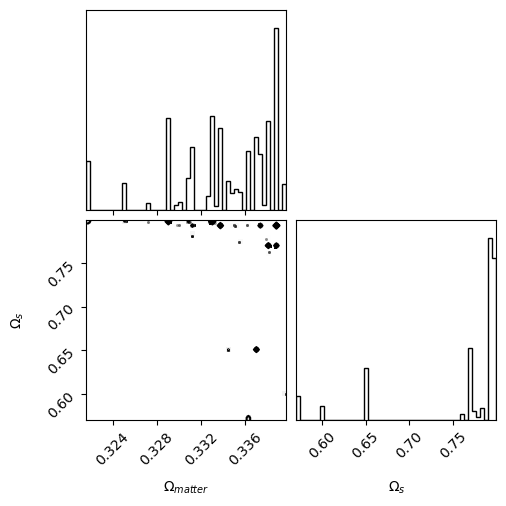

In [17]:
Test.mcmc_corner_plot()

Removed no burn in


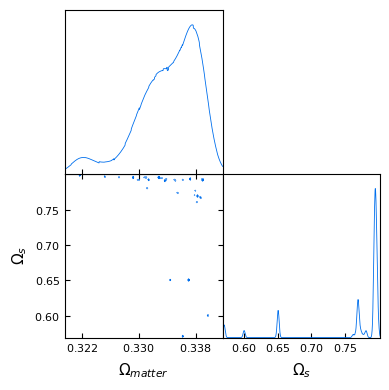

In [18]:
Test.mcmc_get_dist_plot()

In [19]:
Test.print_best_parameters()

Mean of Omega_matter = 0.3342309379239896
Standard deviation of Omega_matter = 0.004534381674035545
Mean of Omega_s = 0.761689754929371
Standard deviation of Omega_s = 0.06496440214118245


859 [0.00000000e+00 9.74428340e+17 2.74456260e+03 8.39610366e+01]
[  50.92233365   83.96103662 2744.56259959]


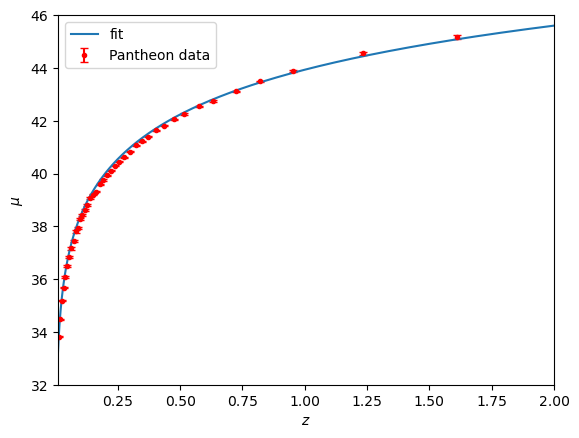

In [20]:
Test.plot_best_fit_SNe(MD, dataset)

859 [0.00000000e+00 9.74428340e+17 2.74456260e+03 8.39610366e+01]
[  50.92233365   83.96103662 2744.56259959]


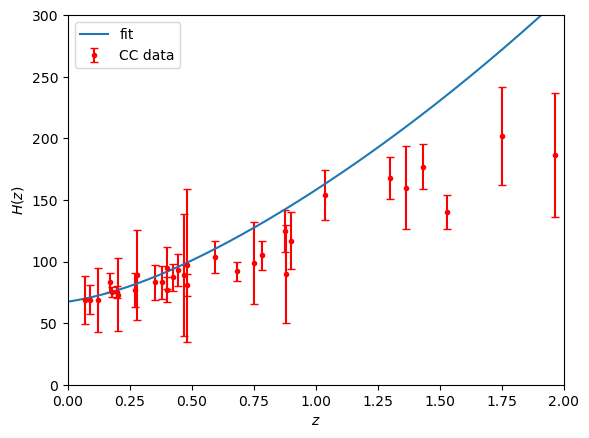

In [21]:
Test.plot_best_fit_CC(MD, dataset)

859 [0.00000000e+00 9.74428340e+17 2.74456260e+03 8.39610366e+01]
[  50.92233365   83.96103662 2744.56259959]


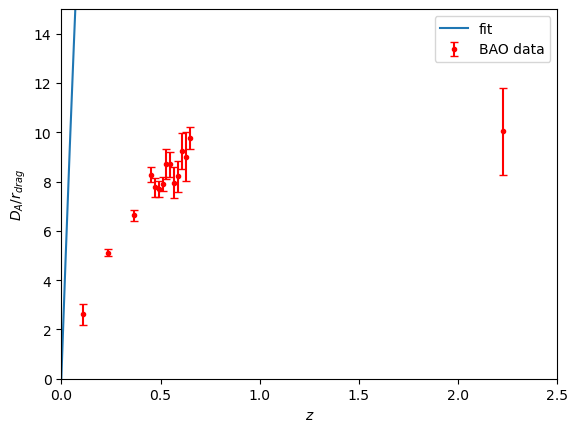

In [22]:
Test.plot_best_fit_BAO(MD, dataset)

In [23]:
Test.print_CMB_priors(MD)

859 [0.00000000e+00 9.74428340e+17 2.74456260e+03 8.39610366e+01]
[  50.92233365   83.96103662 2744.56259959]

 --- CMB distance priors -------------------------------------
 
 [R_obs, la_obs]                   = [  1.7661 301.7293]
 [R_fitted, la_fitted]                = [1.0849309145040396, 63.07469653856576]
 
 -------------------------------------------------------------


In [24]:
Test.print_HBBN(MD)

859 [0.00000000e+00 9.74428340e+17 2.74456260e+03 8.39610366e+01]
[  50.92233365   83.96103662 2744.56259959]

 --- Hubble param at BBN -------------------------------------
 
 HBBN from LCDM               = 4.76589971472913e+17
 HBBN from fit                = 2289429123459.808
 
 -------------------------------------------------------------


# Testing

In [25]:
#Best fit
#args_fit  = (0.2, 5.44e-5, 1.013, 0.2, 0.70, 0.65, -1.000, 0.500) for this set of params the curve fits for SNe and CC look good
#args_fit  = (0.28, 5.44e-5, 1.013, 0, 0.70, 0.92, -1.0, 0.5) for this set of params the curve fits for SNe and CC look good
#args_fit  = (0.28, 5.44e-5, 1.013, 0.02, 0.674, 0.92, -1.0, 0.5) for this set of params the curve fits for SNe and CC look good
args_fit  = (m1, 5.44e-5, 1.013, Ok_planck, 0.674, m2, -1.000, 0.500)

#higher Ok, like 0.1,0.2 pushes the CC curved down at the end towards z=2. Also higher Os has same effect in range 0.7 -> 0.9
#different values for Og and s1 (last two values) change nothing in the fit curve.


NameError: name 'm1' is not defined

In [ ]:
args = [0.31346140460311706, 5.44e-05, 0.685, 0.0, 0.674, 0.6310045128428221, -1.0, 0.5]

z, mu, R, la, HBBN = calc_mcmc_input(MD, *args)

In [ ]:
MD.print_results()